In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import warnings

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

/usr/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#A13OOAT2ORKH6V:3EWIJTFFVPMYW8IUWPUOOQWSVFU0E8,1,1,2937,Bear_4_2,Bear,category2D,pancakes,waffles,False,6032
#participant:assignmentId,trial,blockTrial,trialStartTime,monster,family,category,preferredFood,choice,correct,rt

def stringToInt(arr, position, values):
    for i, v in enumerate(values):
        arr[arr[:,position] == v, position] = i
    return arr

#csvFile = 'data/test.csv'
csvFile = '../data/monsters_data_pilot_041417.csv'

# Get all columns
#csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', skip_header=1)
# Only id(0), category(6), correct(9) 
csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', usecols=(0,6,9), skip_header=1)

# Pre-process CSV
# Get categories
categories = [c for c in np.unique(csv[:,1])]
# Get unique ids
ids = [i for i in np.unique(csv[:,0]) ]
# For converting string to int boolean
bo = [b'False', b'True']

csvInt = csv.copy()
# Convert fields to ints for easy processing
for i,j in enumerate([ids, categories, bo]):
    csvInt = stringToInt(csvInt, i, j)
csvInt = csvInt.astype('int')

# Split by user
splitCsv = [csvInt[csvInt[:,0]==i] for i in np.unique(csvInt[:,0])]

In [3]:
users = 5
tasks = 4

In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:5000px;  /* output max-height */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [8]:
def plotError(window, lookback, plotAll=fixed(False)):
    
    # ===========================================================================================
    # Error Part
    if plotAll:
        # Set up error subplots
        fig = plt.figure(figsize=(15, 15))
        ax, c = [], 0
        for i in range(3):
            for j in range(2):
                ax.append(plt.subplot2grid((3, 2), (i, j)))
                c+=1
                if c == users:
                    break
        plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    errors=[];
    for u in range(users):
        # With a list in case I want to store them like cumCounts, movAvg should be moved out of this loop though
        # To be indexed by user too
        movAvg=[];
        # Plot error moving average per task for this user u only
        for t in range(tasks):
            # e = 1-accuracy (where accuracy)
            movAvg.append(1-pd.rolling_mean(splitCsv[u][splitCsv[u][:,1]==t, 2], window)[window-1:]);
            if plotAll:
                ax[u].plot(movAvg[t], label=categories[t])
        errors.append(movAvg);
        if plotAll:
            ax[u].legend()
            ax[u].set_title(''.join(['Person ', str(u+1), ' | Error']))
            ax[u].set_ylabel('Error')
            ax[u].set_xlabel('Task (and window) dependent step ')
    
    if plotAll:
        plt.tight_layout();
        plt.show()
    # Use a global vars so it can retrieve window size and error list to use it with error difference
    global Window
    Window = window
    global Errors
    Errors = errors
    #return errors, window;
    
    # ===========================================================================================
    # LP Part
    def errorChange(arr, lookback=1, getInitDiff=True):
        # Reverse it
        arr = arr[::-1]
        # LP = - [error(now) - error(past)]
        # window: a look-back to consider the difference  diff[t] = a[t] - a[t-window]
        lp = [-i+j for i, j in zip(arr[:-lookback], arr[lookback:])]
        # if it's set to true then it will append the initial (noisy) differences that were left behind by the nature
        # of having a rolling window. Thus it will calculate the differences (only one step) and append them
        if getInitDiff:
            lp += np.diff(arr[-lookback:]).tolist()
        # Reverse it
        lp = lp[::-1]
        return lp

    # Set up subplots for LP
    if plotAll:
        fig = plt.figure(figsize=(15, 15))
        ax, c = [], 0
        for i in range(3):
            for j in range(2):
                ax.append(plt.subplot2grid((3, 2), (i, j)))
                c+=1
                if c == users:
                    break
        plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    # Store every task LP per user
    lpU = []
    for u in range(users):
        # Stores LP per task for user u
        lpT = []
        for t in range(tasks):
            lpT.append( errorChange(Errors[u][t], lookback, getInitDiff=False) )
            if plotAll:
                # If i make errorChange multidimensional
                #ax[u].plot(lpT[u][t], label=categories[t])
                ax[u].plot(lpT[t], label=categories[t])
                # adjust so it start at 0 when getInitDiff=true
                #ax[u].plot([x for x in range(lookback,lookback+len(lpT))], lpT)
        # Store LP for all t for user u
        lpU.append(lpT)
        if plotAll:
            ax[u].legend()
            ax[u].set_title(''.join(['Person ', str(u+1), ' | Learning Progress']))
            ax[u].set_ylabel('Error rate')
            ax[u].set_xlabel('Task dependent step')

            ax[u].axhline(y=0,xmin=0,xmax=10,c="black",linewidth=0.5,zorder=0)
    
    if plotAll:
        plt.tight_layout()
        plt.show()
    global LPU
    LPU = lpU
    
    
    # ===========================================================================================
    # P(leave|LP) section
    
    # If detached then use global LPU
    #lpU = LPU

    categ = ['Category 1D', 'Category 2D', 'Category Ignore 1D', 'Category Random']
    for t in range(tasks):
        # One per user
        color = ['r', 'b', 'k', 'g', 'y']

        position = [0, 0.1, 0.2, 0.3, 0.4]
        fig, axes = plt.subplots(figsize=(15,10));
        plt.subplots_adjust(wspace=0.5, hspace=0.3);

        for u in range(users):
            # Now let's see if user continued with the previous task or switched

            # Get unique LP values and counts
            lp, counts = np.unique(lpU[u][t], return_counts=True)
            lpCounts = np.asarray((lp, counts)).T

            # Get the indices for task t
            indT, = np.where(splitCsv[u][:,1] == t)

            # Check if we even have LP measurements
            if len(lpU[u][t]) > 0:
                # Then get only those indices to which we have LP measurements
                indTLP = indT[-len(lpU[u][t]):]

                # Concatenate indices for this task with LP, LP and whether or not at this step user u 
                # continued with this same task
                data = [[np.array(indTLP)], [np.array(lpU[u][t]).T], [np.in1d(indTLP+1, indTLP)*1]]
                data = np.concatenate(data).T

                # Discretize the space in 0.05 slices from -0.5 to 0.5
                low, high, step = -0.5, 0.5, 0.05
                # Create bins
                bins = np.arange(low,high,step)
                # Group data in their corresponding bin according to the LP
                binplace = np.digitize(data[:,1], bins)

                # Realign bins
                bins = bins.tolist()
                bins.insert(0, low-step)

                # Now do some binning
                stay = []
                total = []
                pLeave = []
                for b in range(len(bins)):
                    # Go through every bin and get the indices of those that are in the current bin
                    newBins = np.where(binplace == b)
                    # For every bin count the number of times user u continued in this task
                    stay.append(np.sum(data[newBins,2]))
                    total.append(np.size(newBins))
                    # Get P(switch task|LP in this bin)
                    pLeave.append(1-(stay[-1]/total[-1]))
                    
            else:
                low, high, step = -0.5, 0.5, 0.05
                pLeave = [0]*len(np.arange(low,high,step))

            # Plot
            freq = pd.Series.from_array(pLeave)
            # format x labels
            x_labels = ["%.2f" % b for b in bins]
            ax = freq.plot(kind='bar', color=color[u], alpha=0.5, subplots=True, legend=True, 
                           sharex=False, sharey=False, label=''.join(['Subject ', str(u+1)]), position=position[u]);

            axes.set_xlabel("LP")
            axes.set_ylabel("P(Switch task|LP)")
            axes.set_xticklabels(x_labels);
            axes.set_title(''.join(['Task ', str(t+1), ' | ', categ[t]]));
            axes.set_ylim([0,1])
            
        plt.tight_layout();
        plt.show()

    
 
#errors, window = plotError()
#interact(plotError, window=(1,20,1))

Window  10  Lookback LP  2


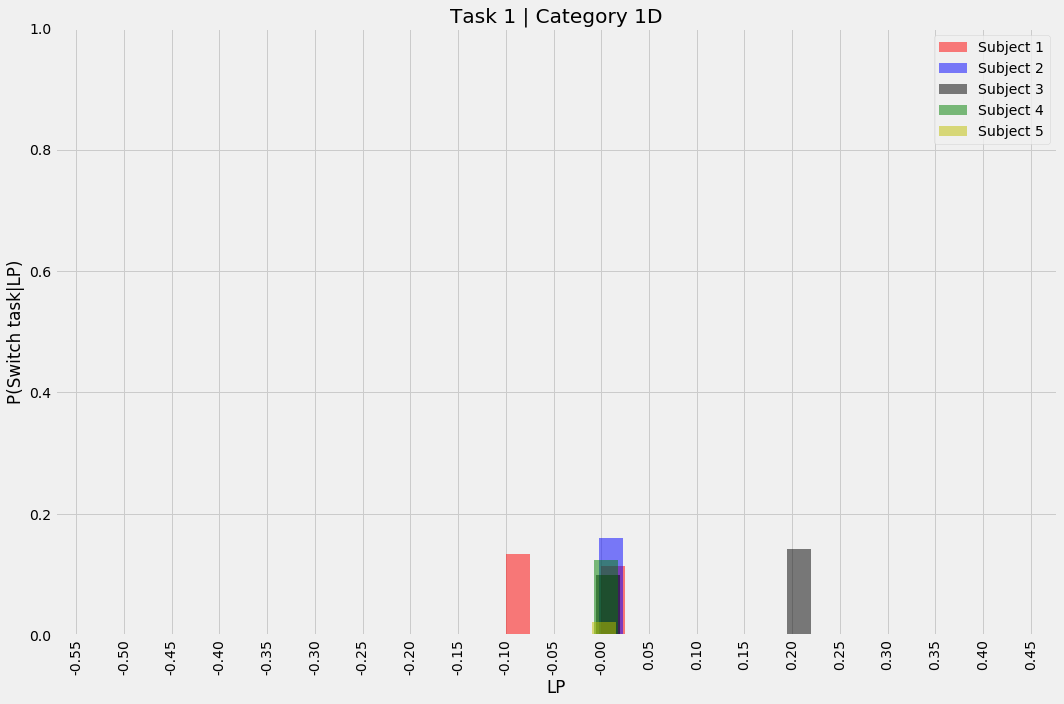

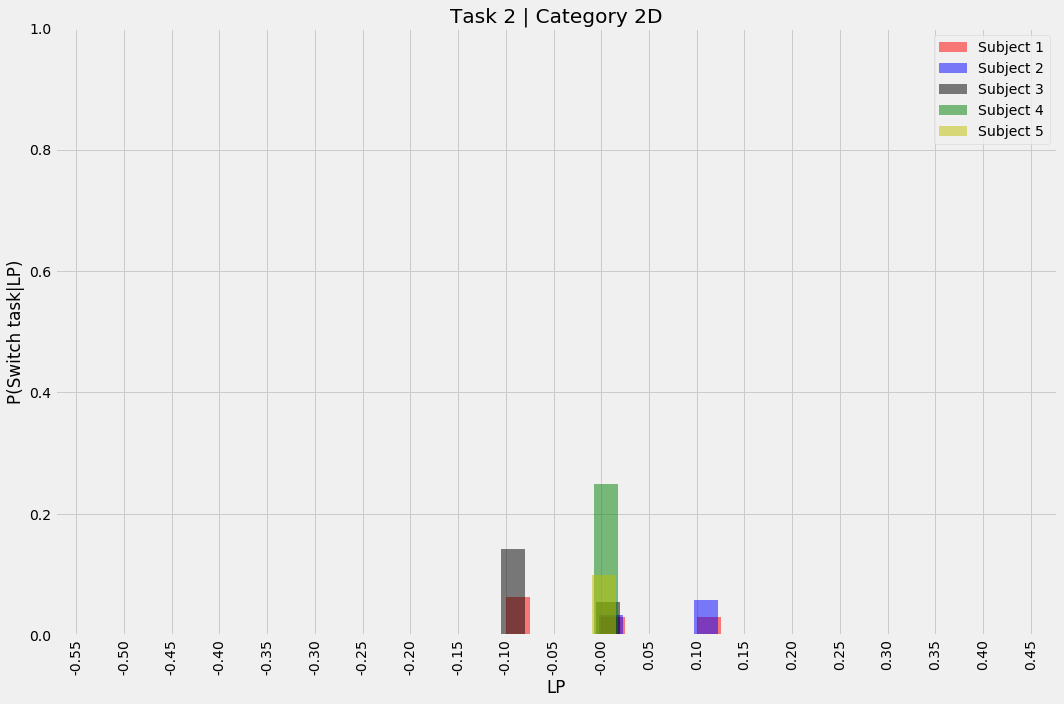

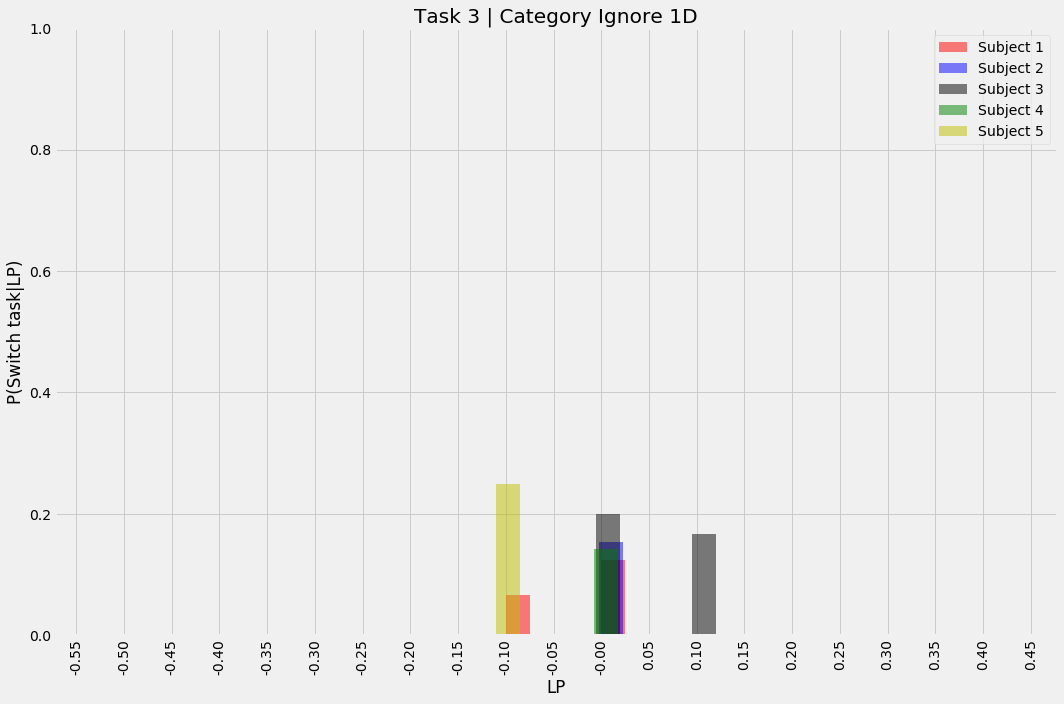

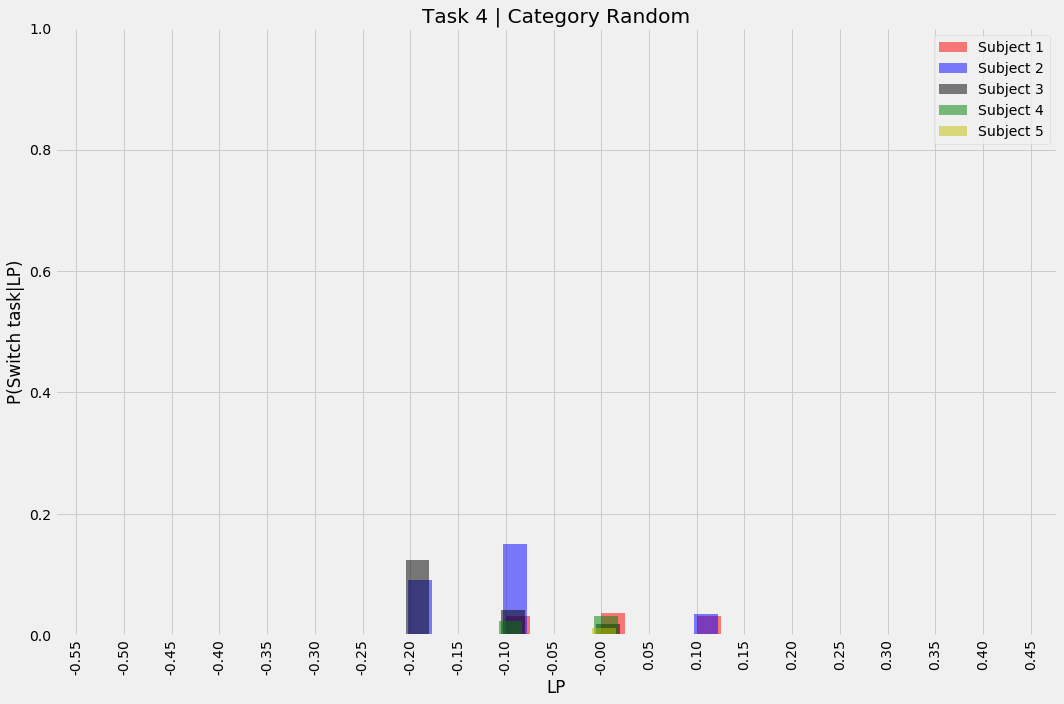

Window  10  Lookback LP  5


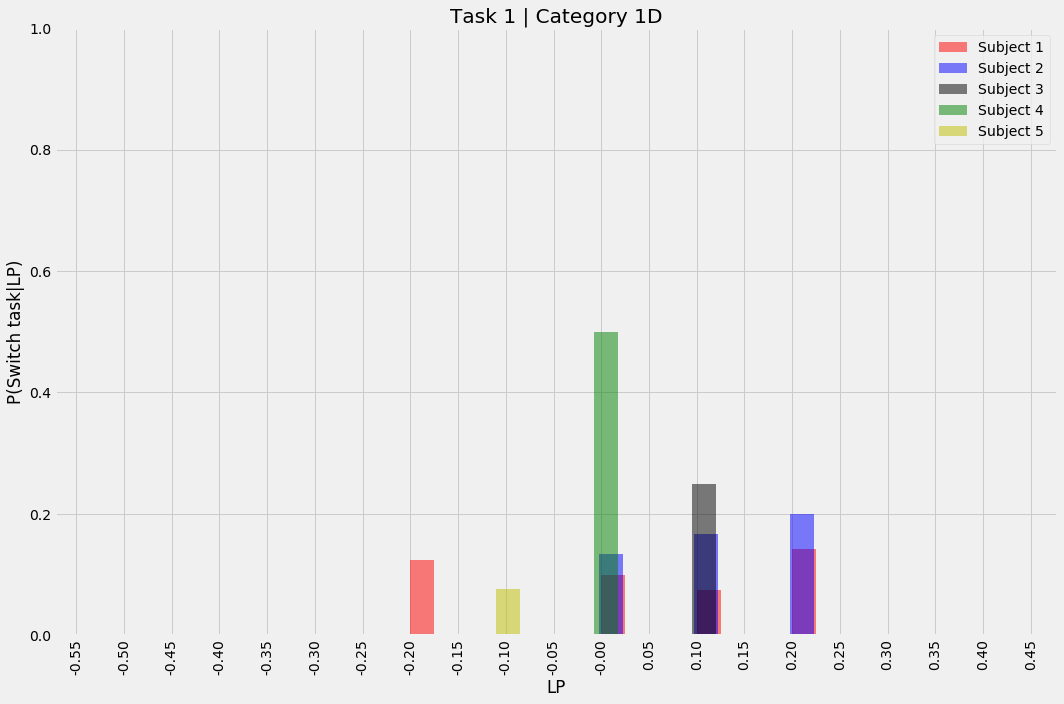

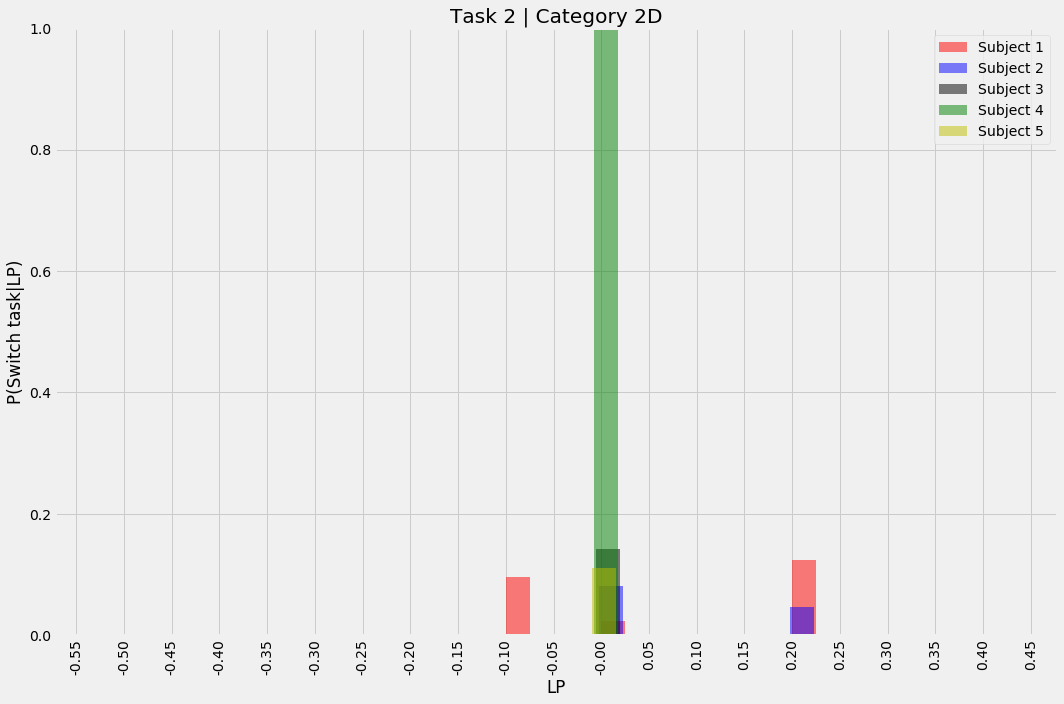

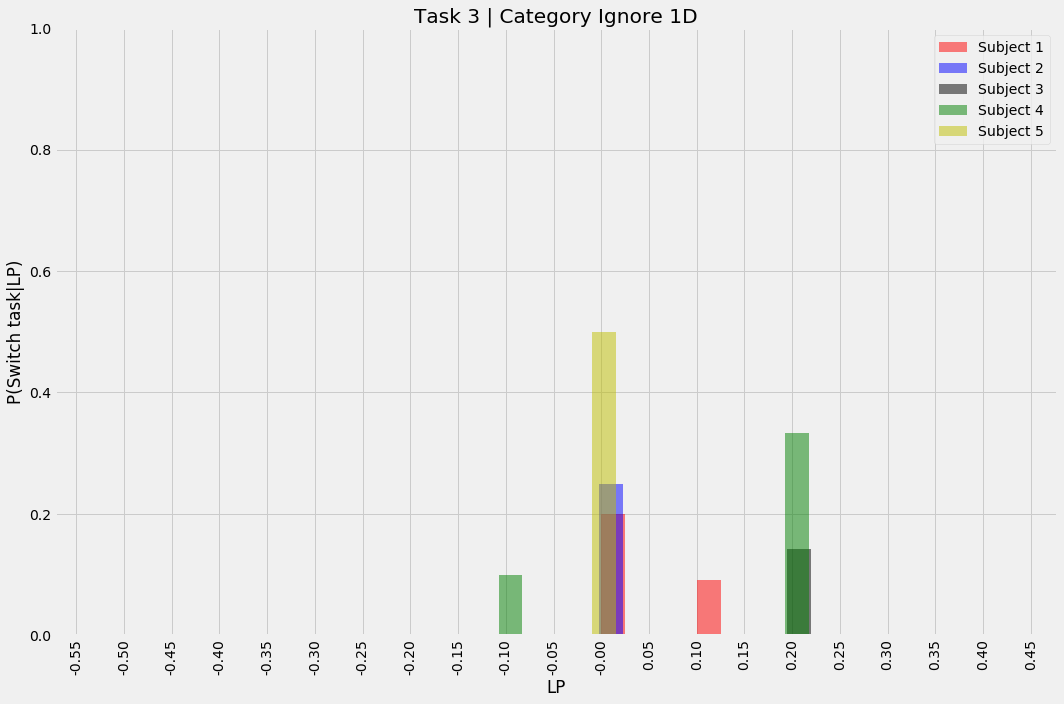

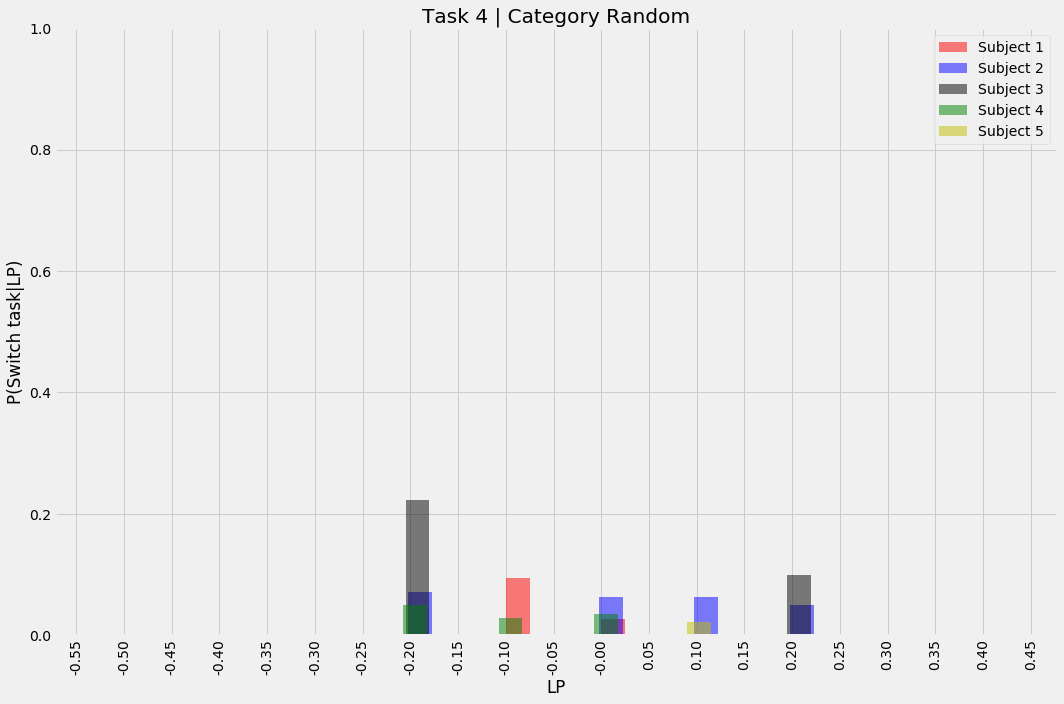

Window  10  Lookback LP  10


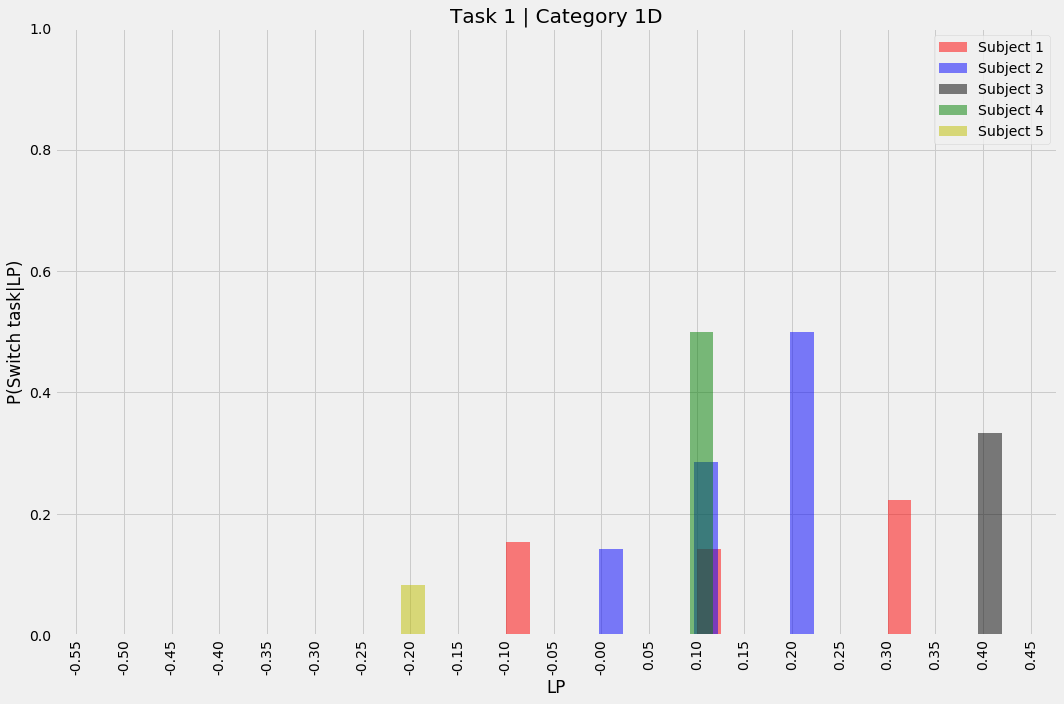

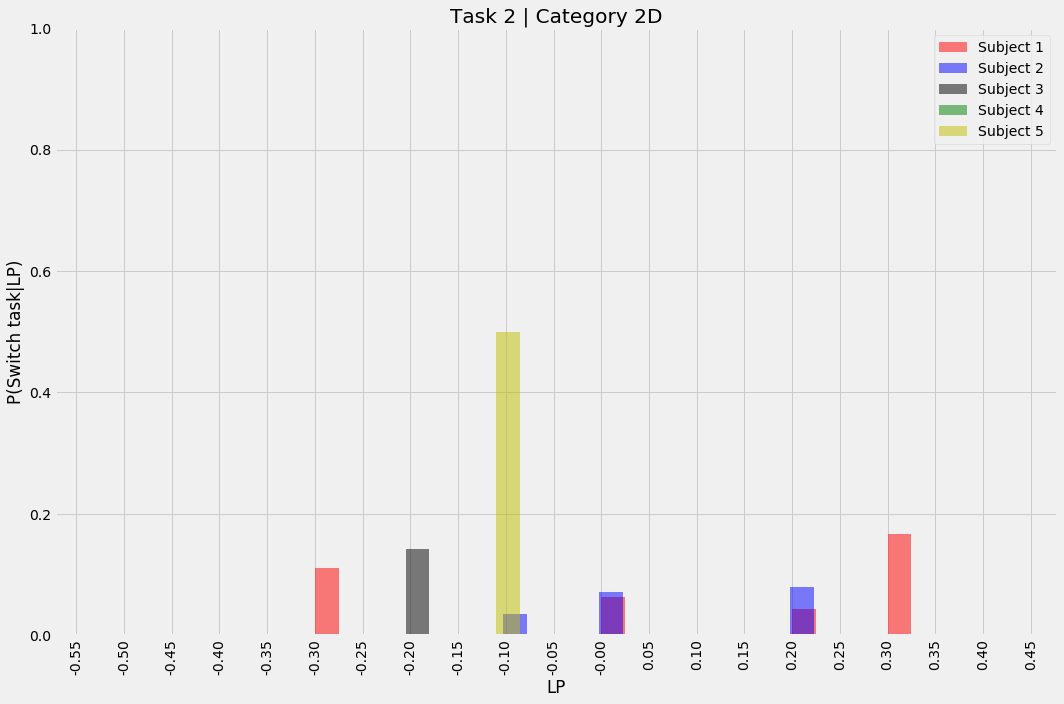

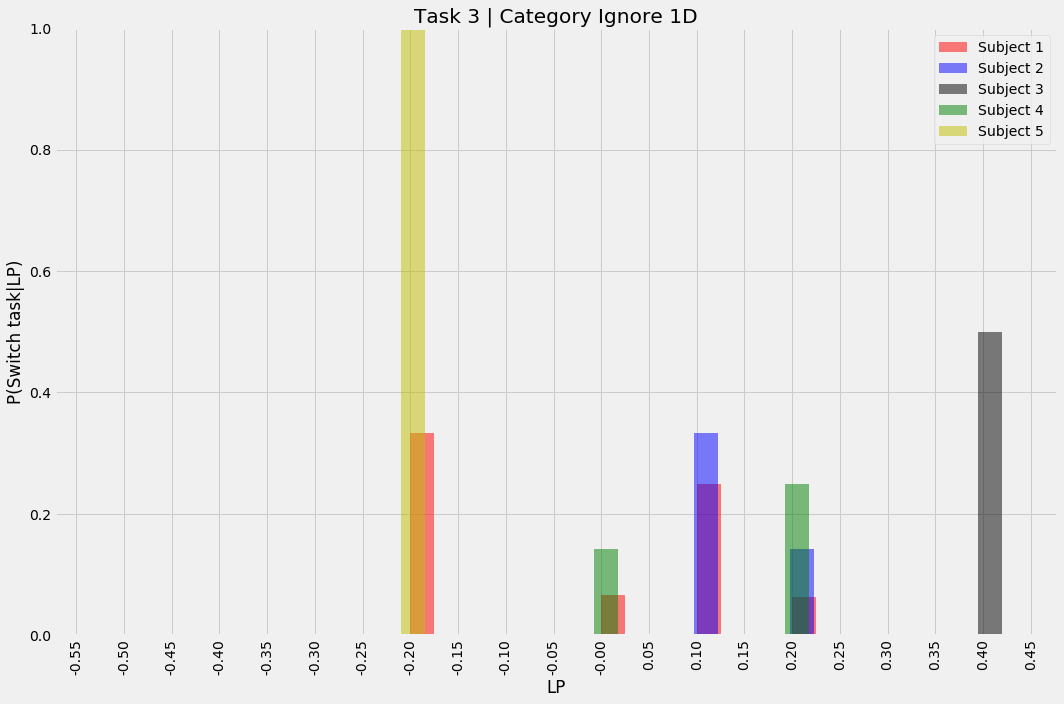

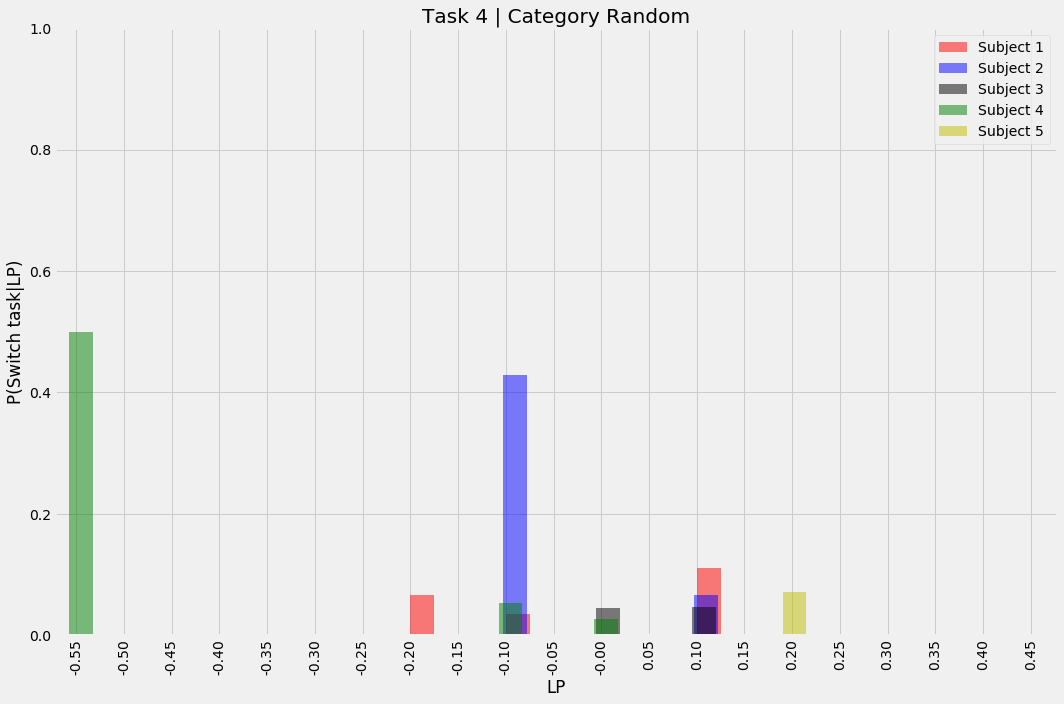

Window  10  Lookback LP  15


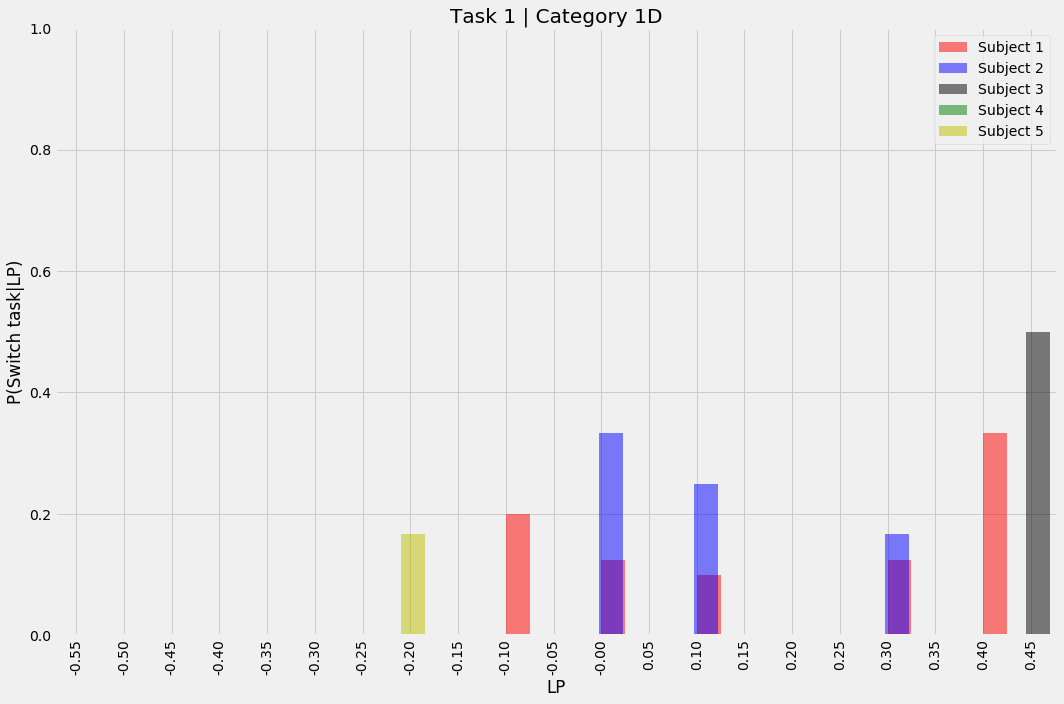

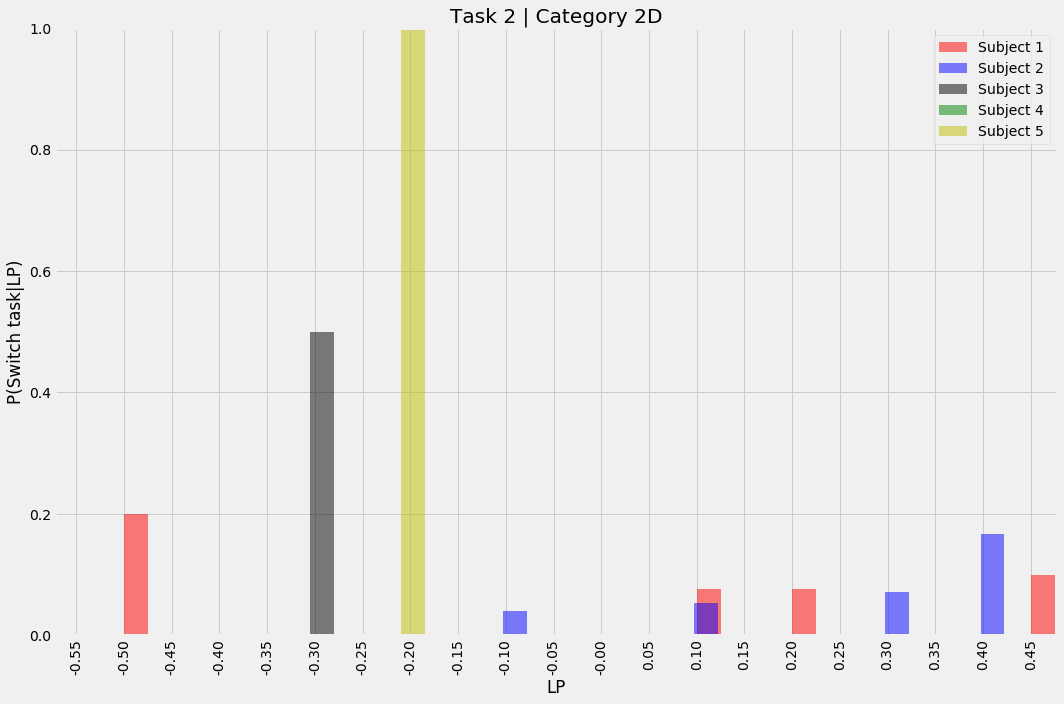

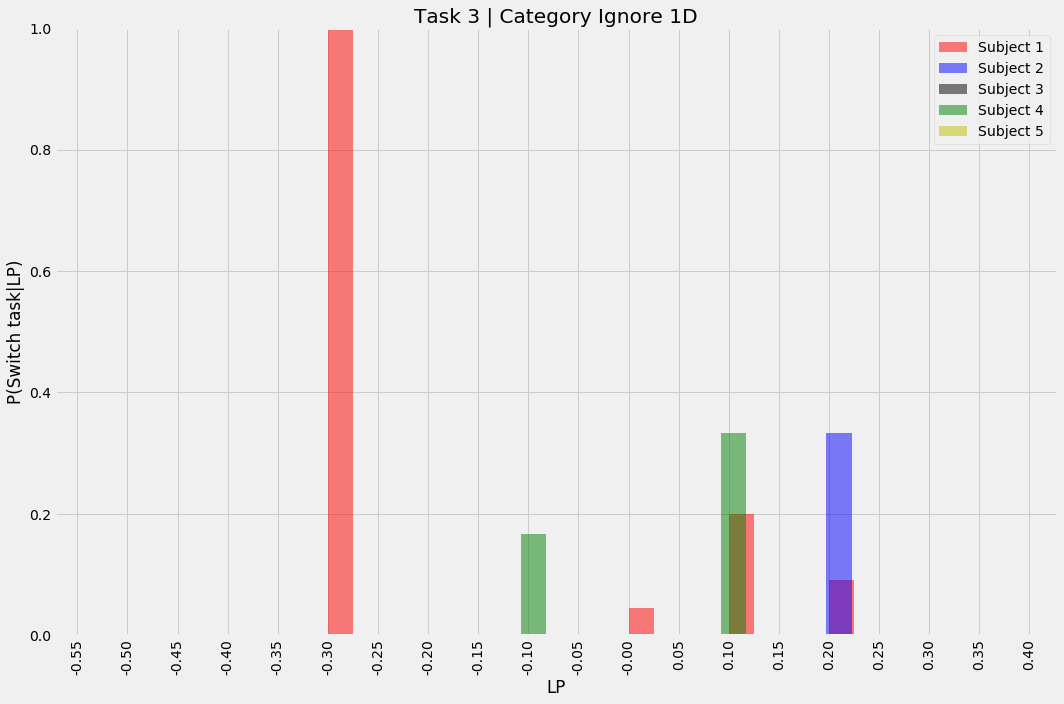

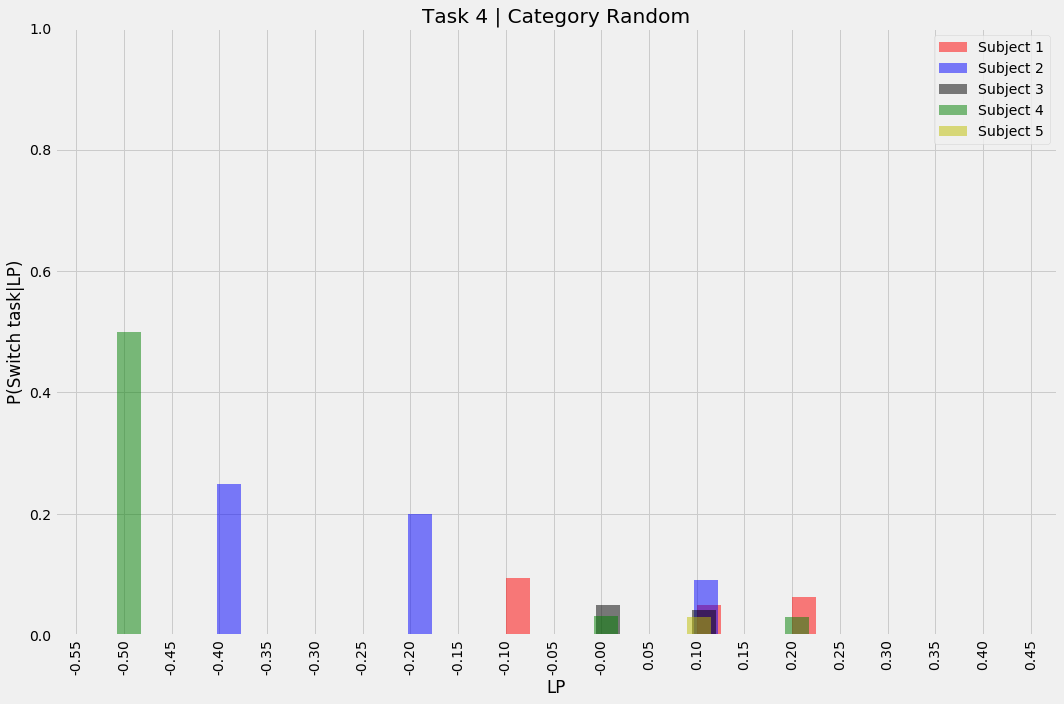

Window  10  Lookback LP  20


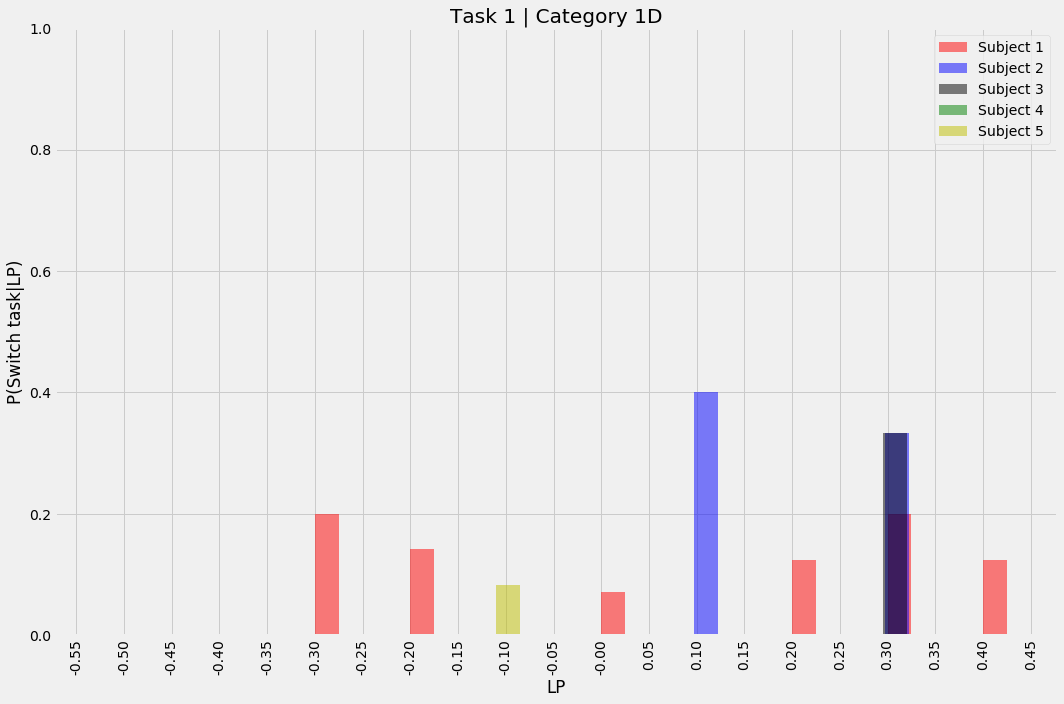

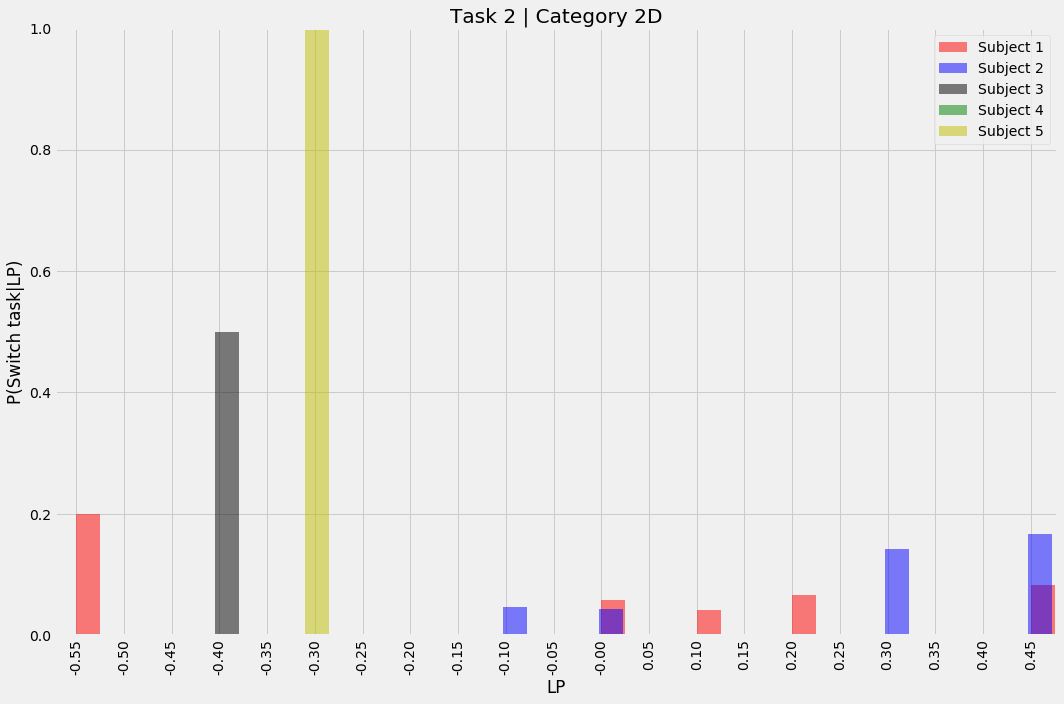

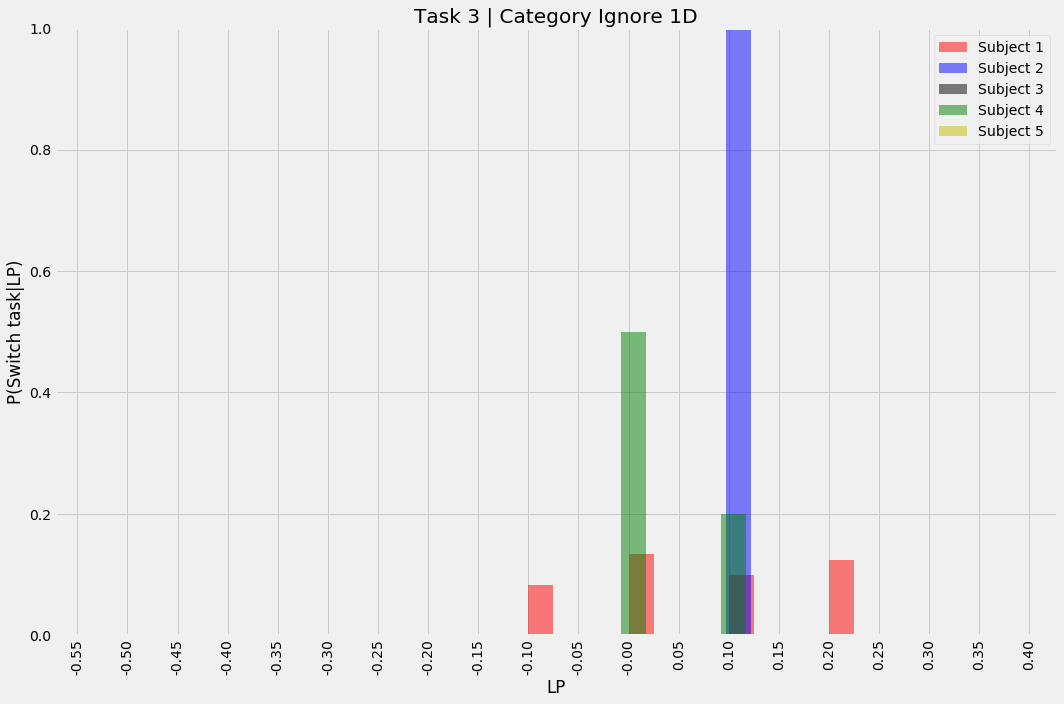

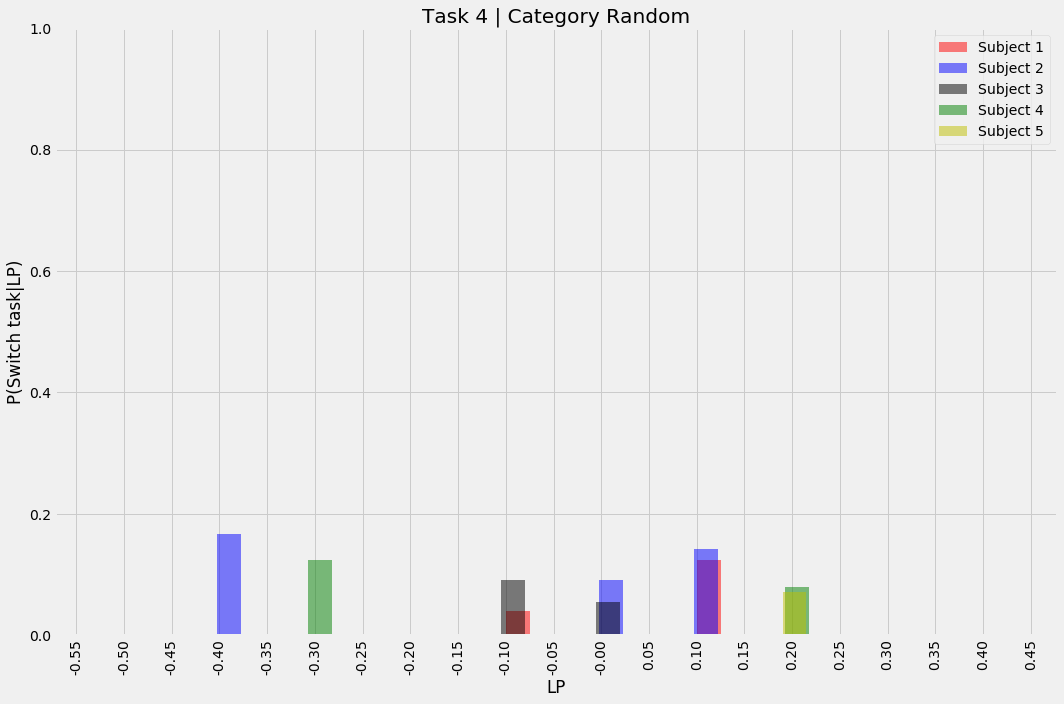

Window  10  Lookback LP  25


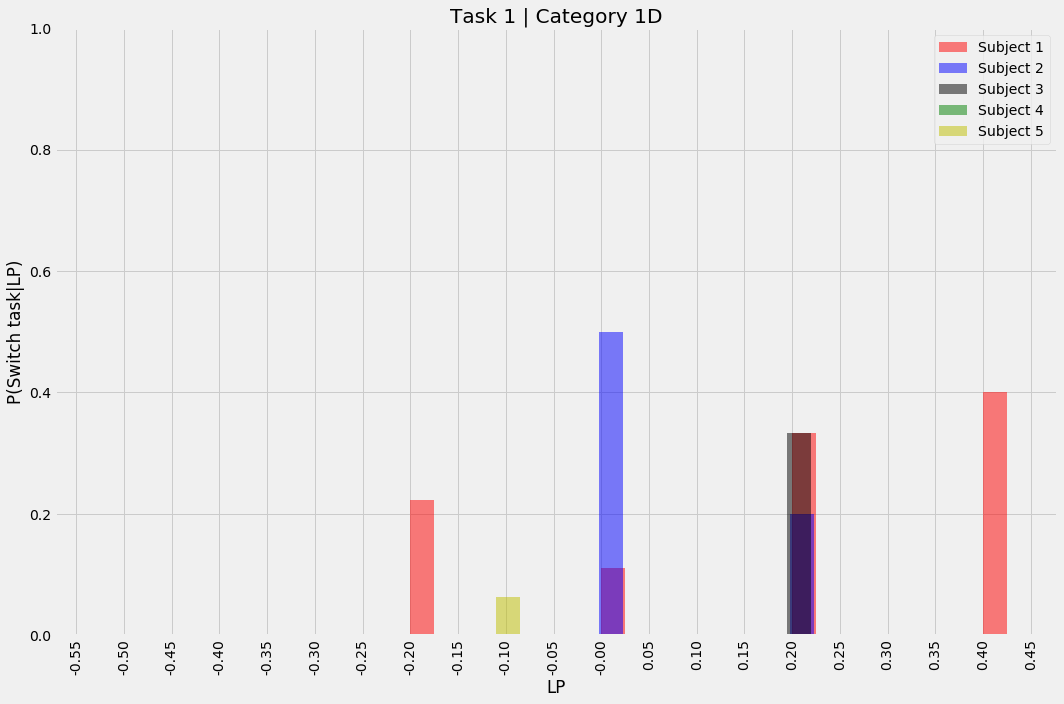

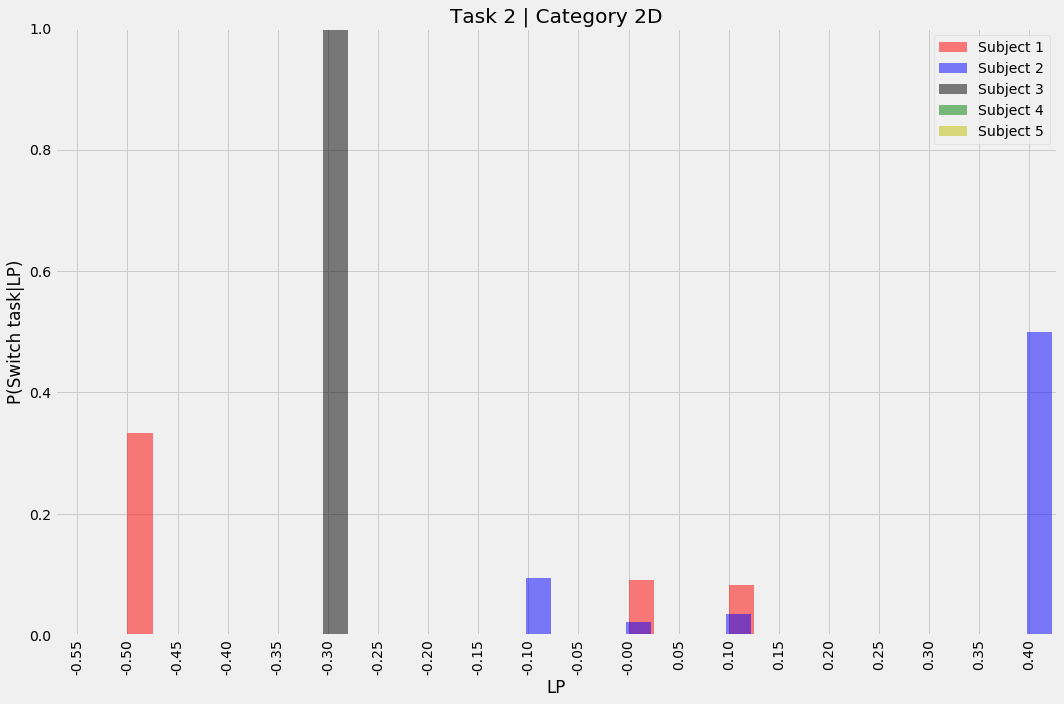

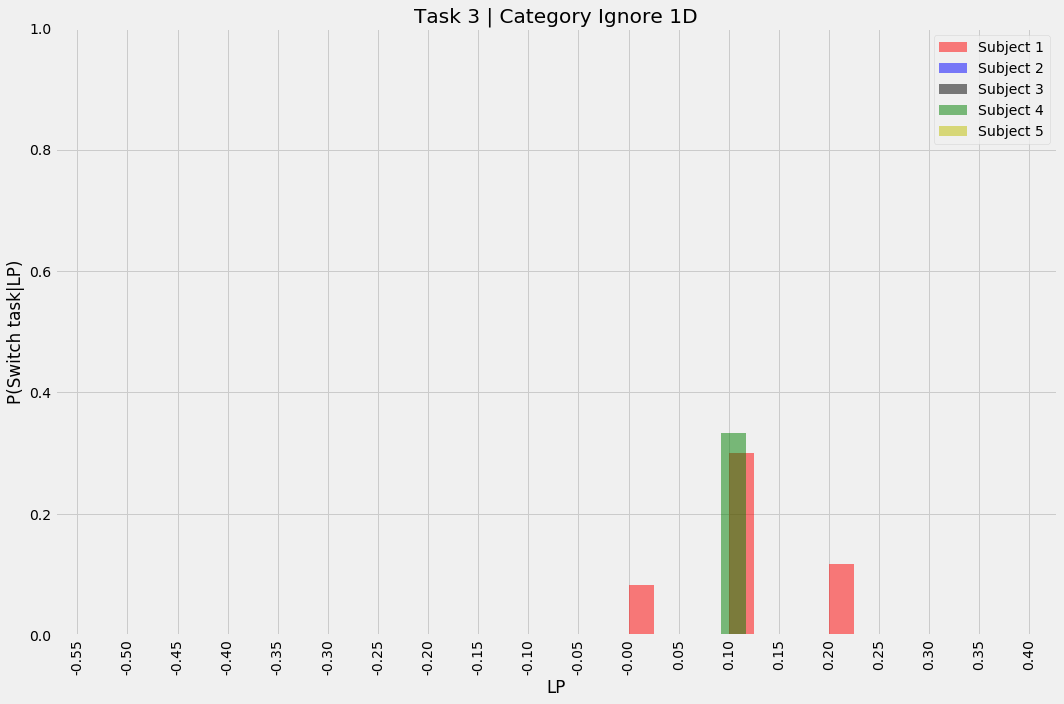

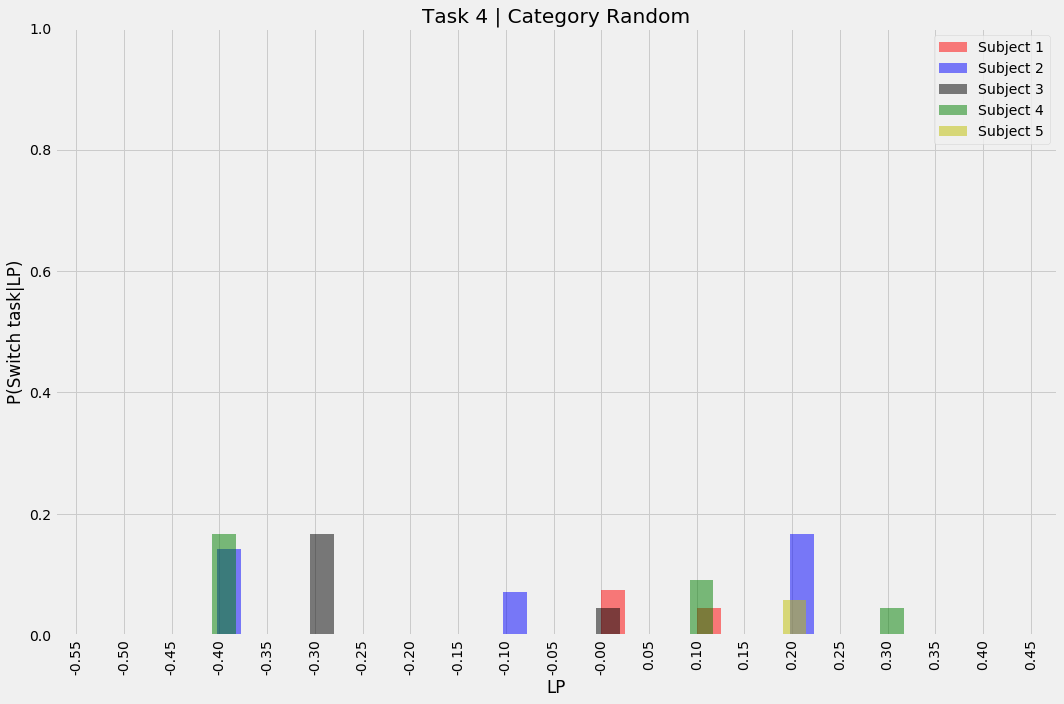

Window  10  Lookback LP  30


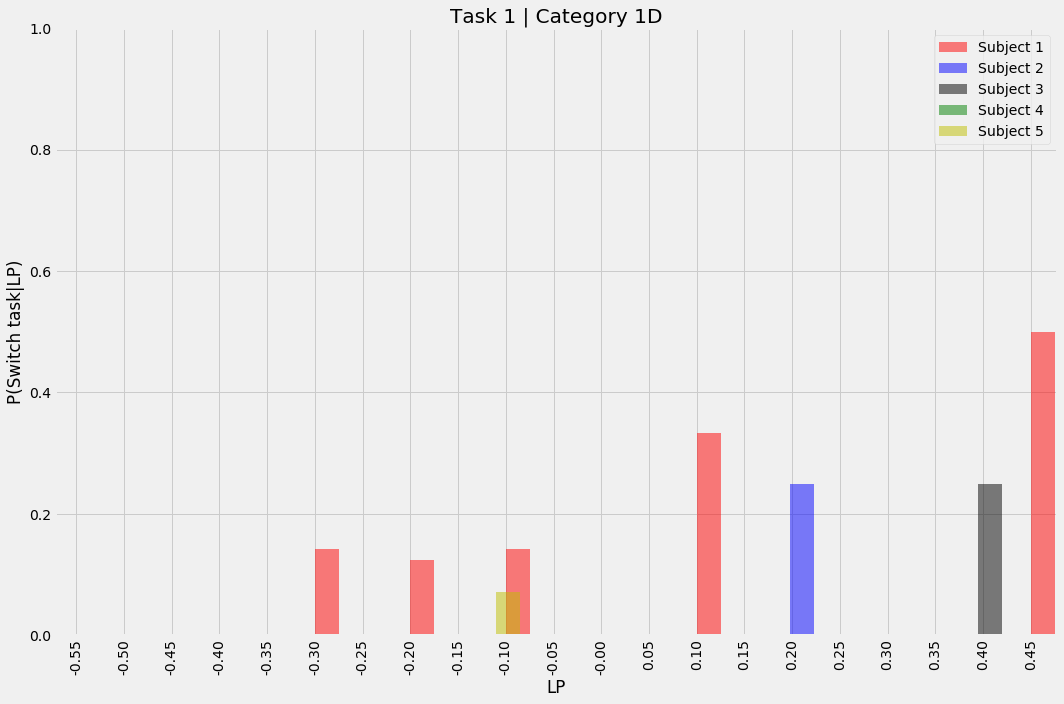

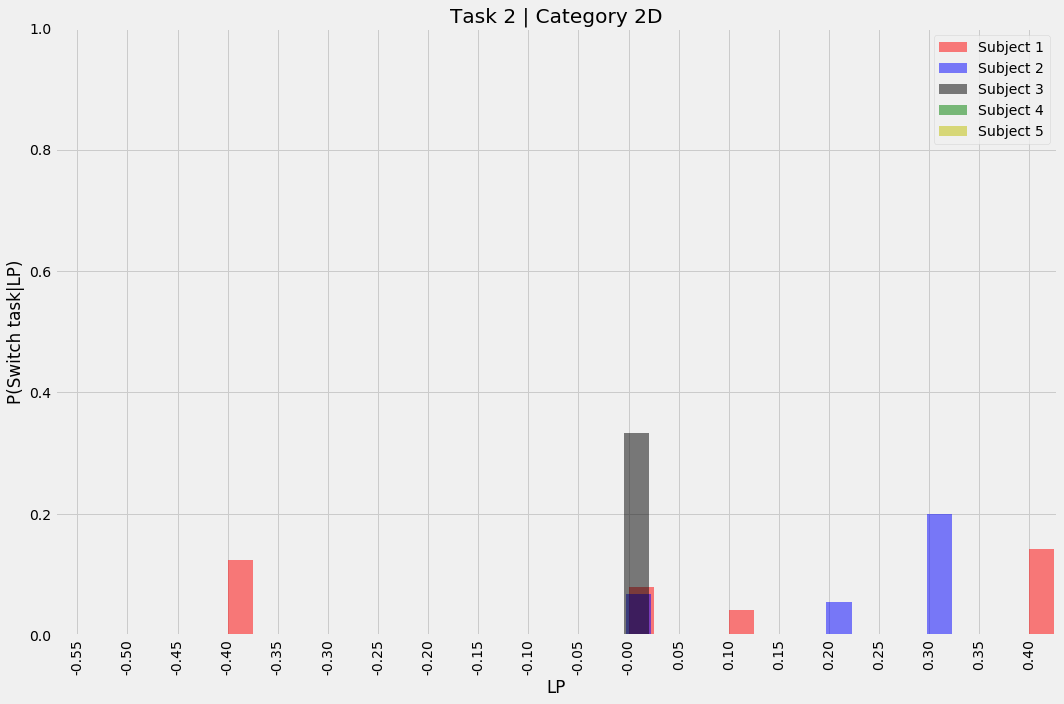

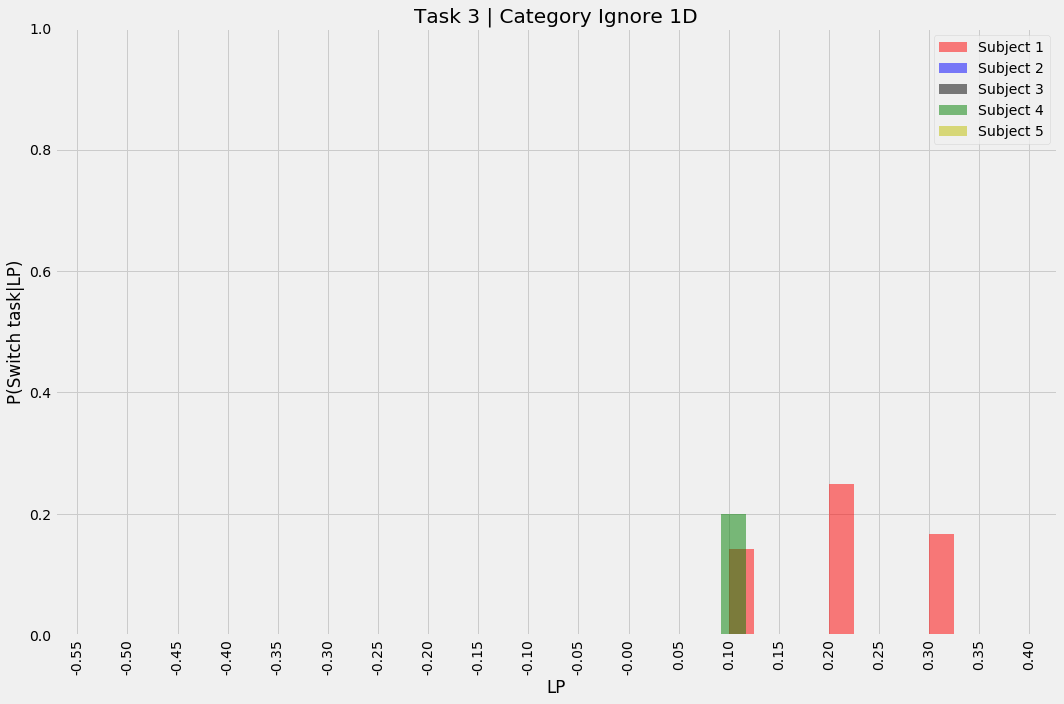

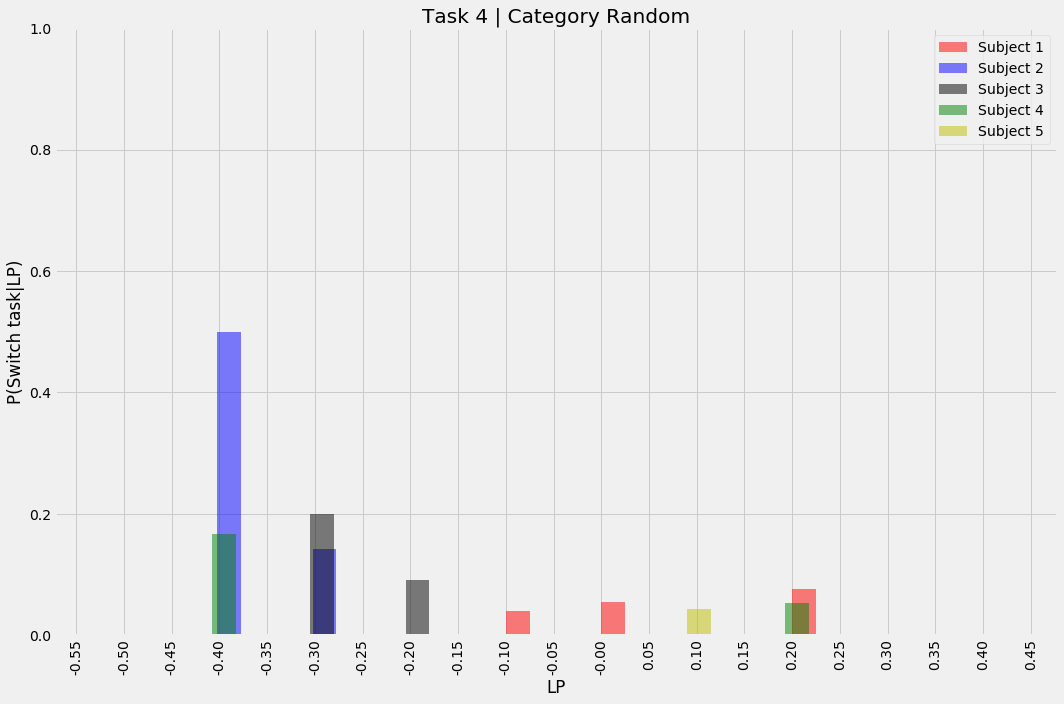

Window  15  Lookback LP  2


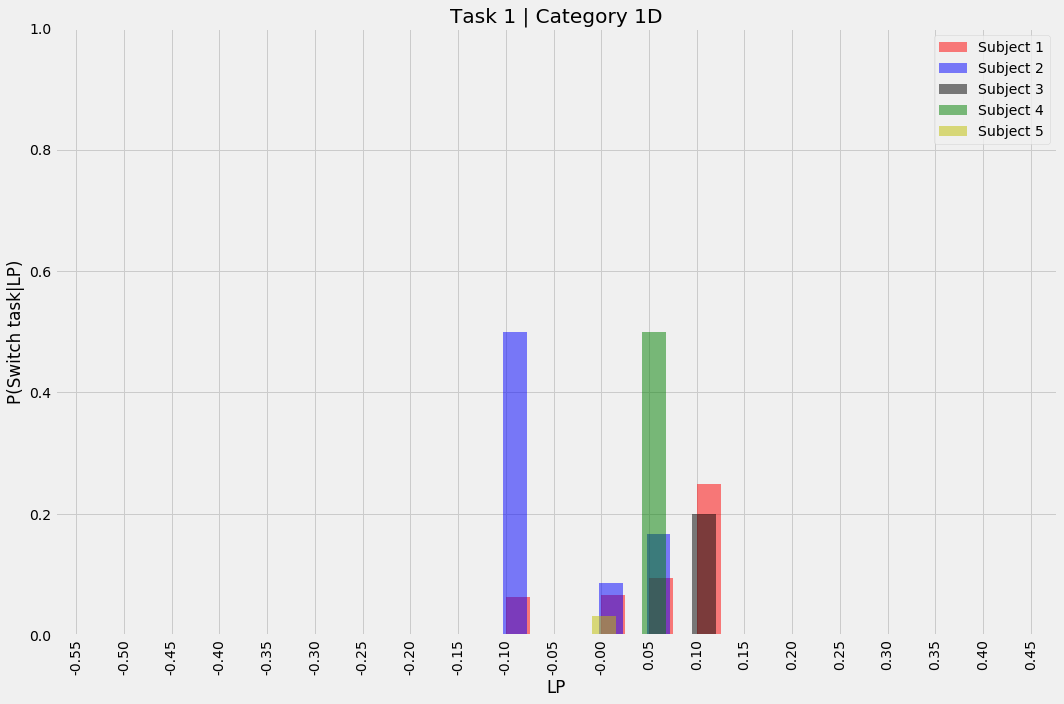

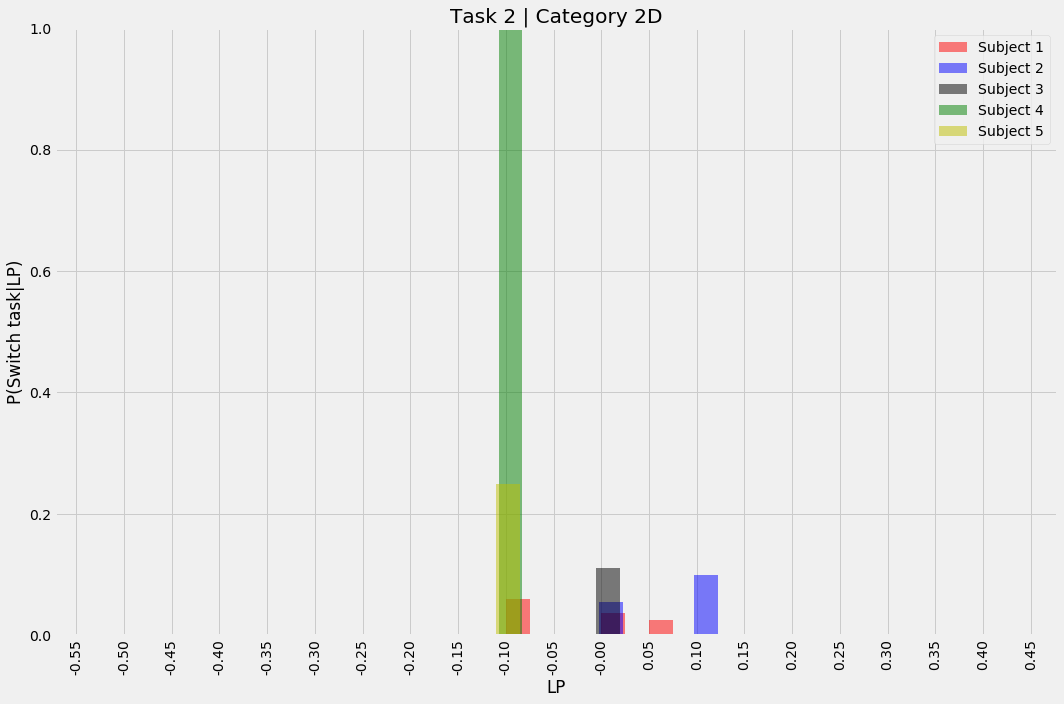

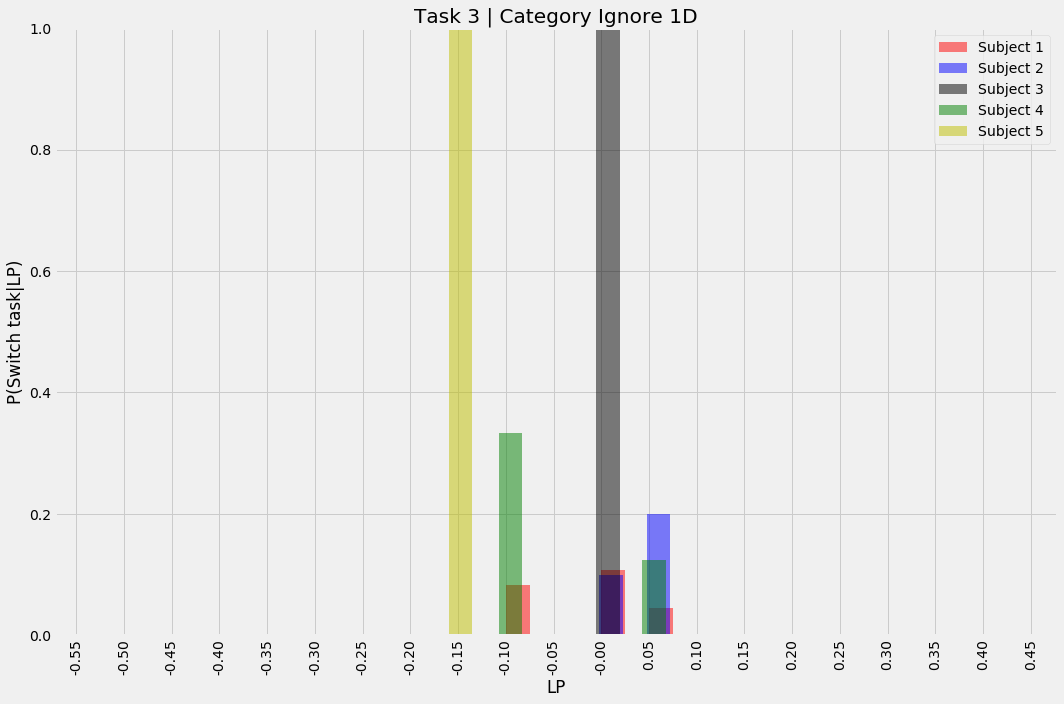

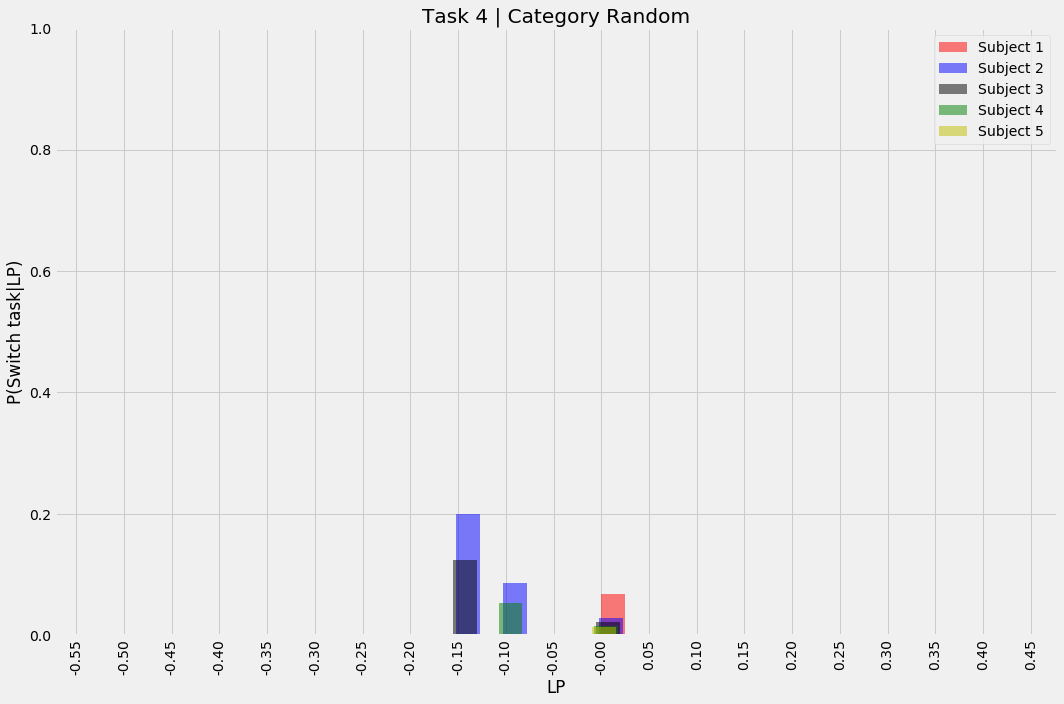

Window  15  Lookback LP  5


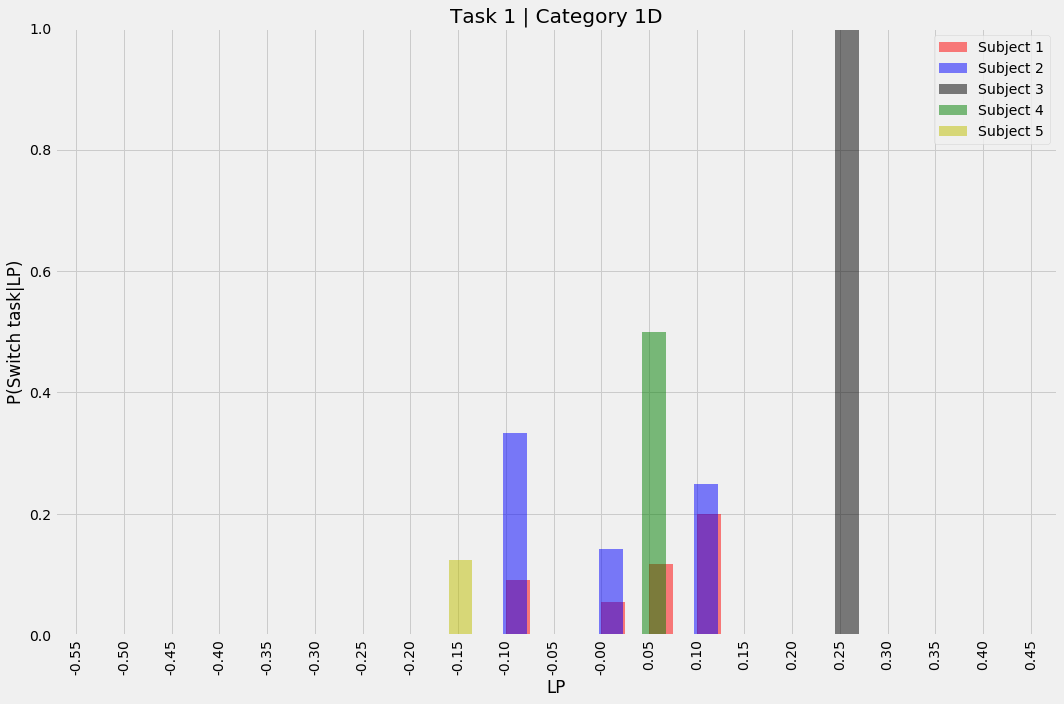

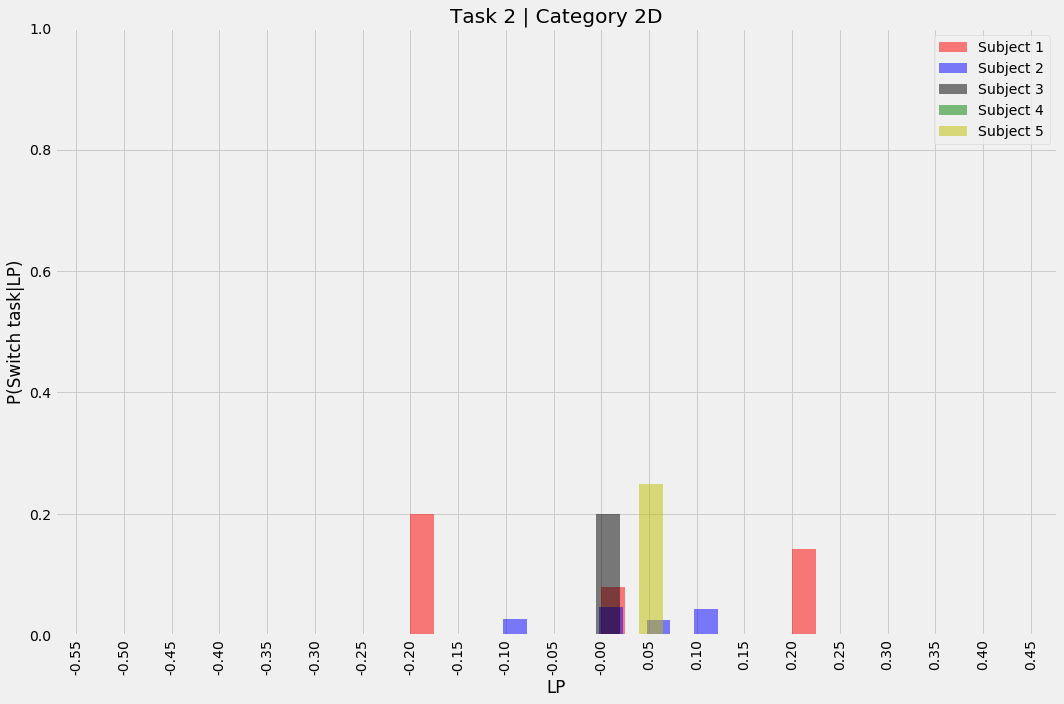

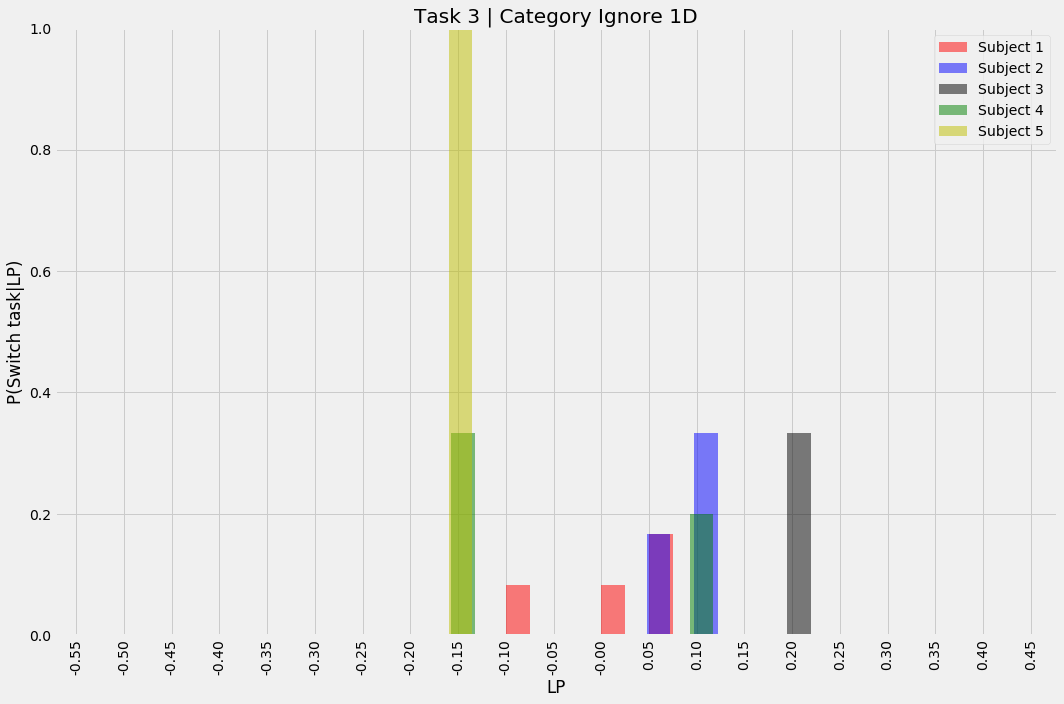

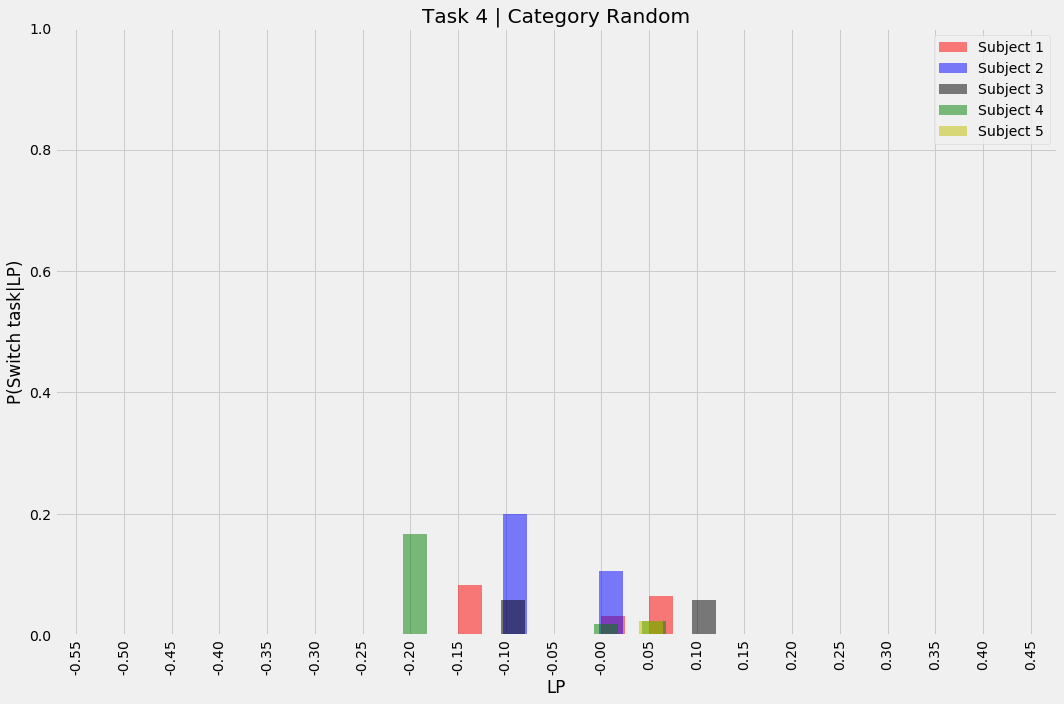

Window  15  Lookback LP  10


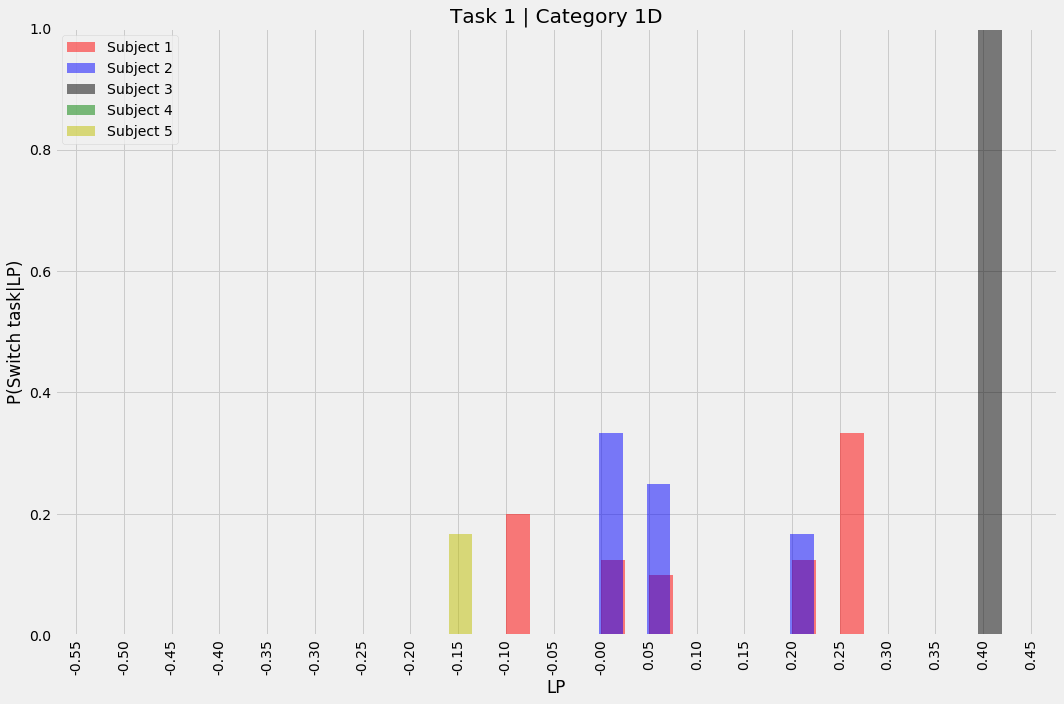

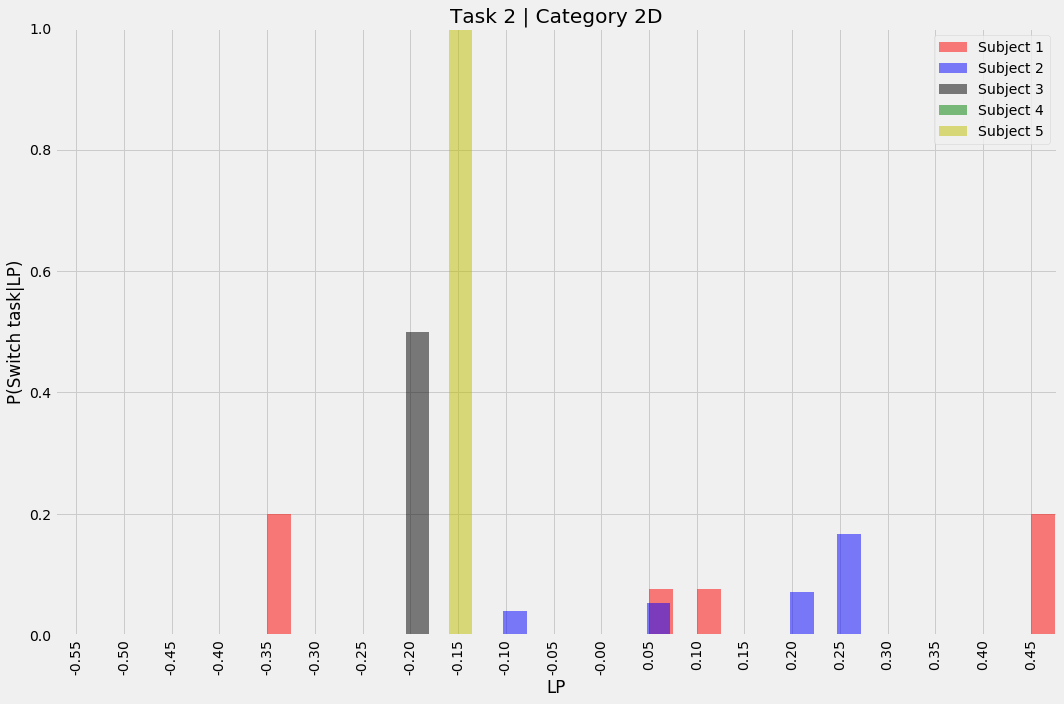

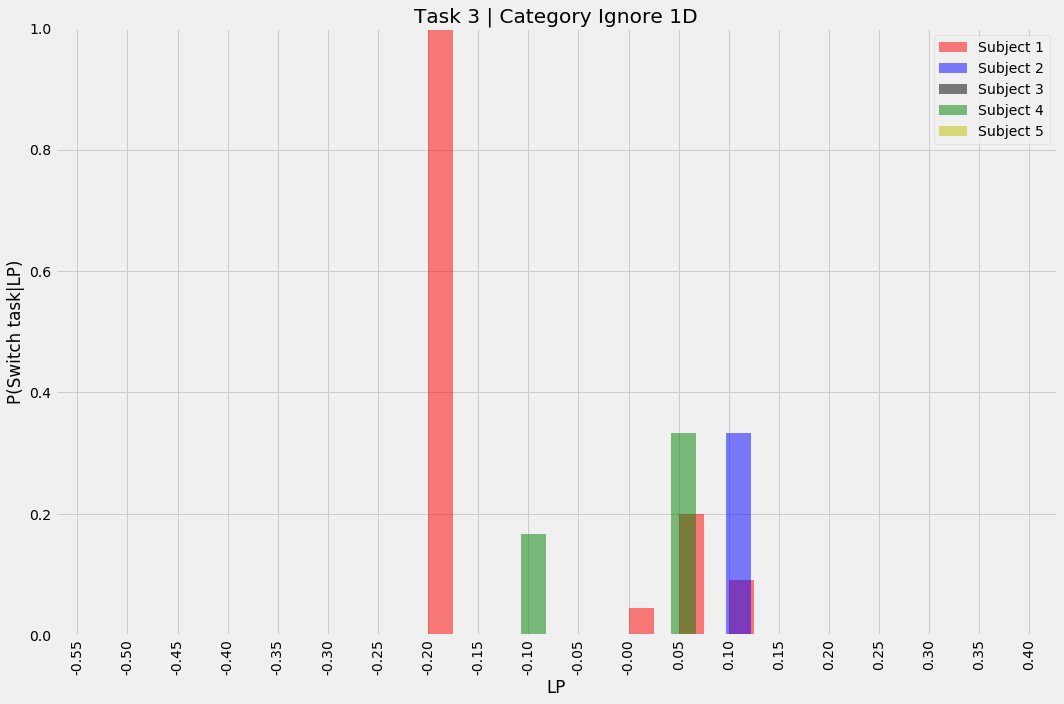

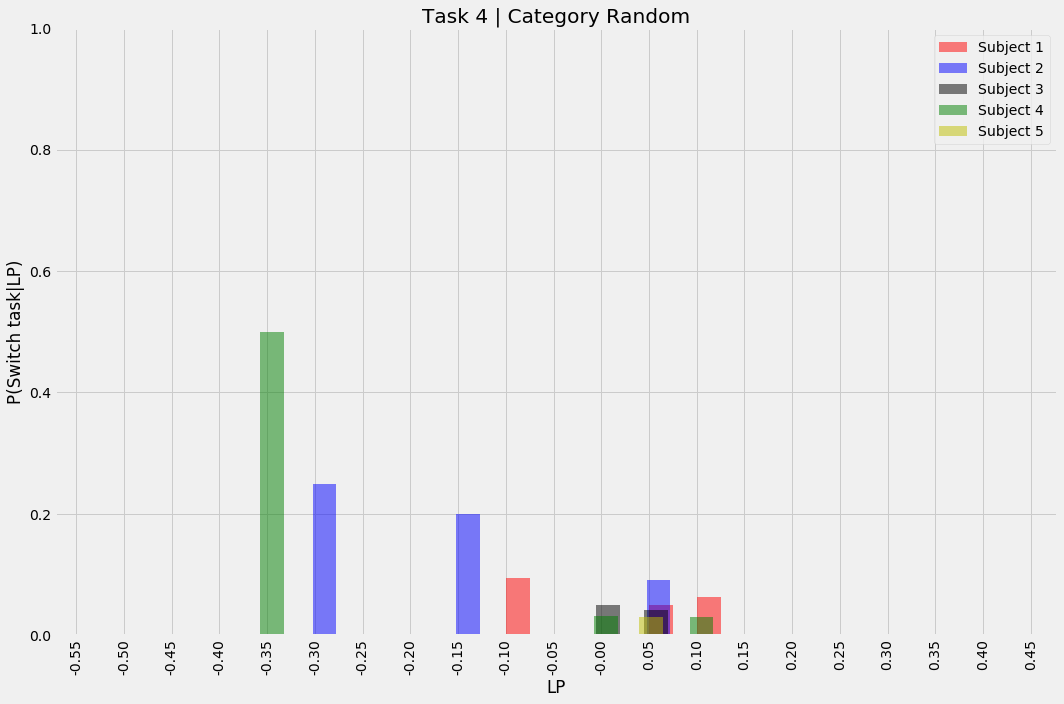

Window  15  Lookback LP  15


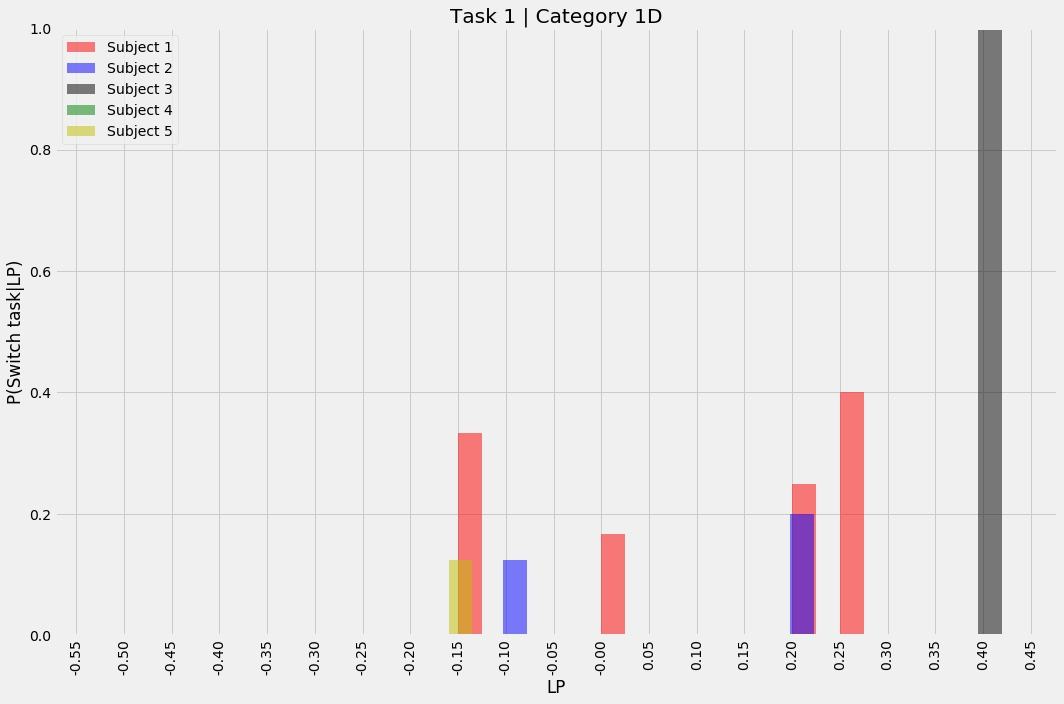

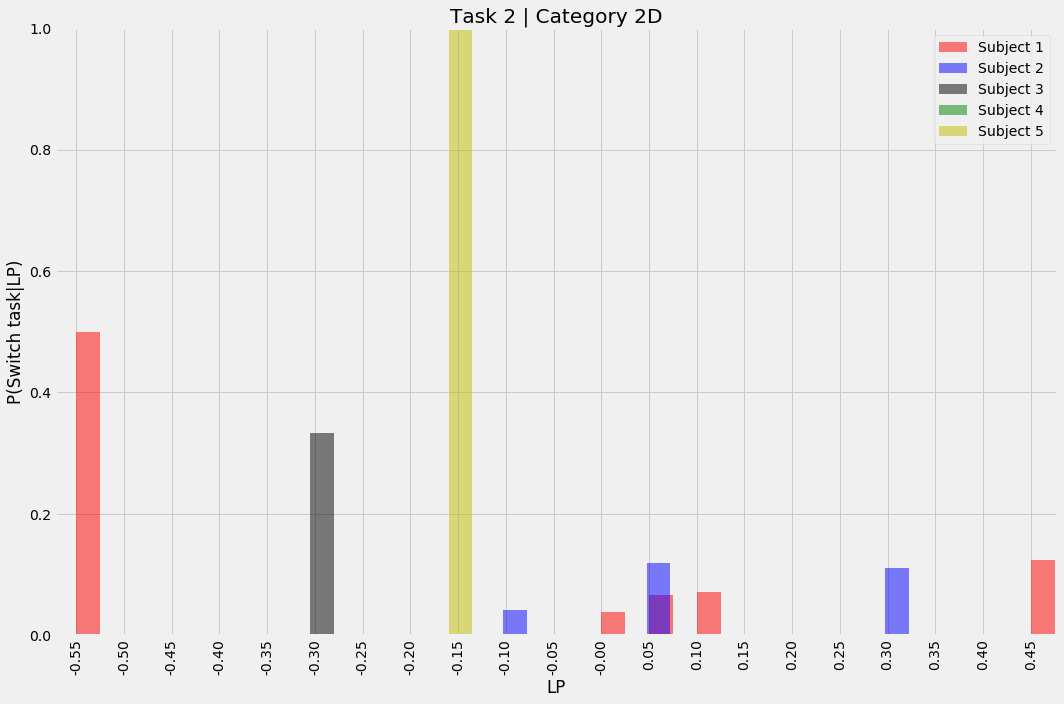

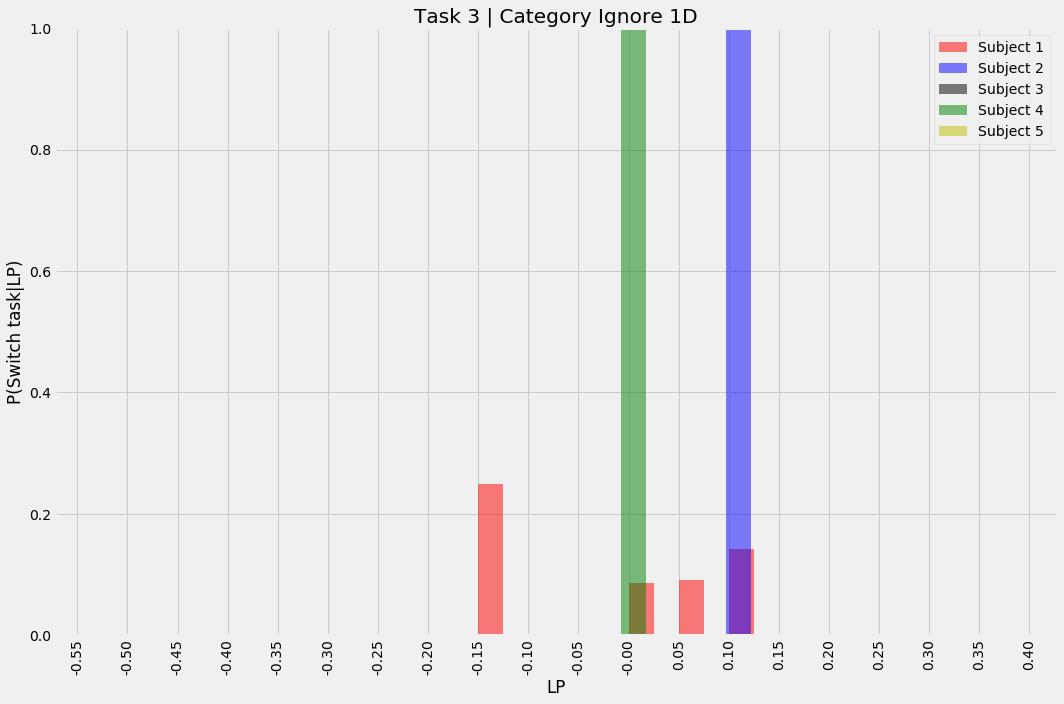

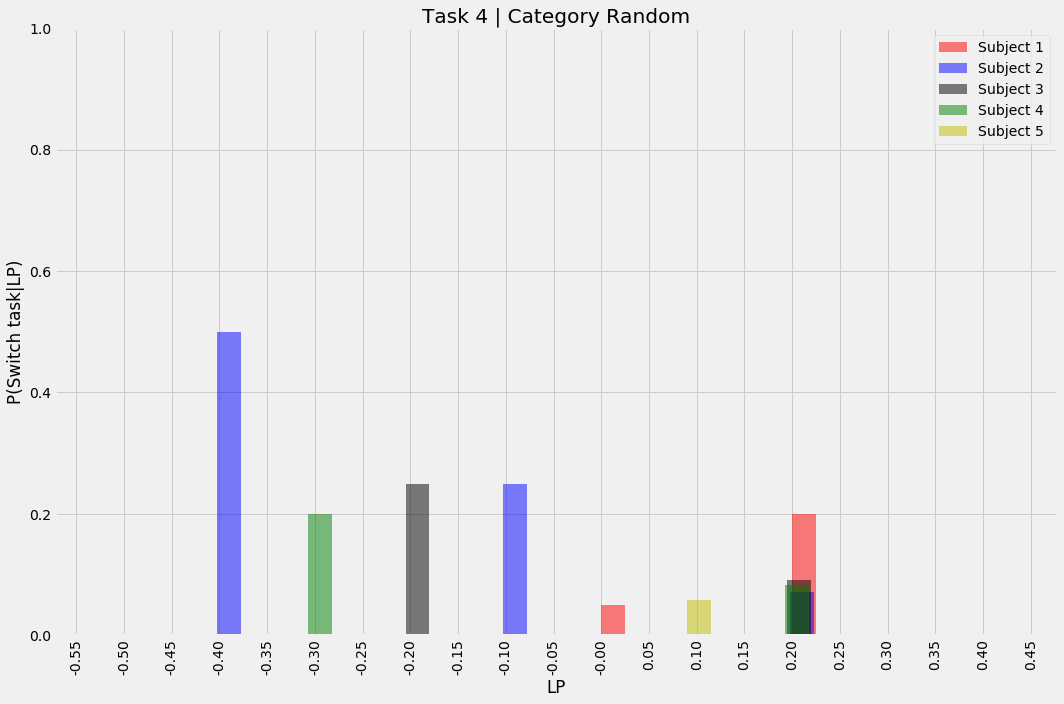

Window  15  Lookback LP  20


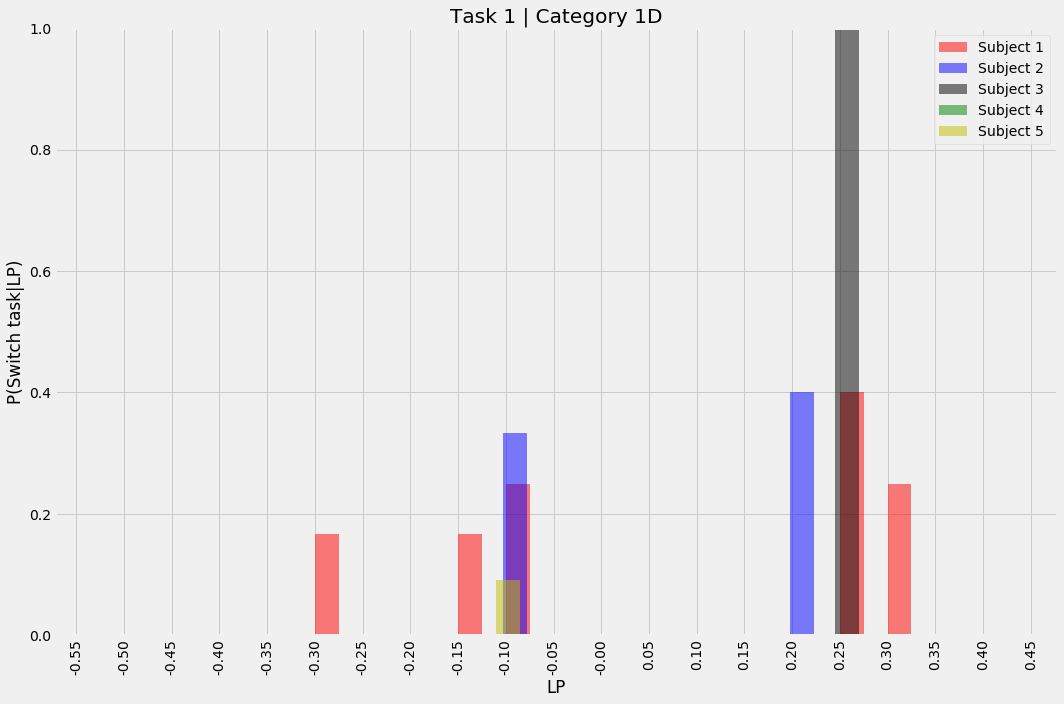

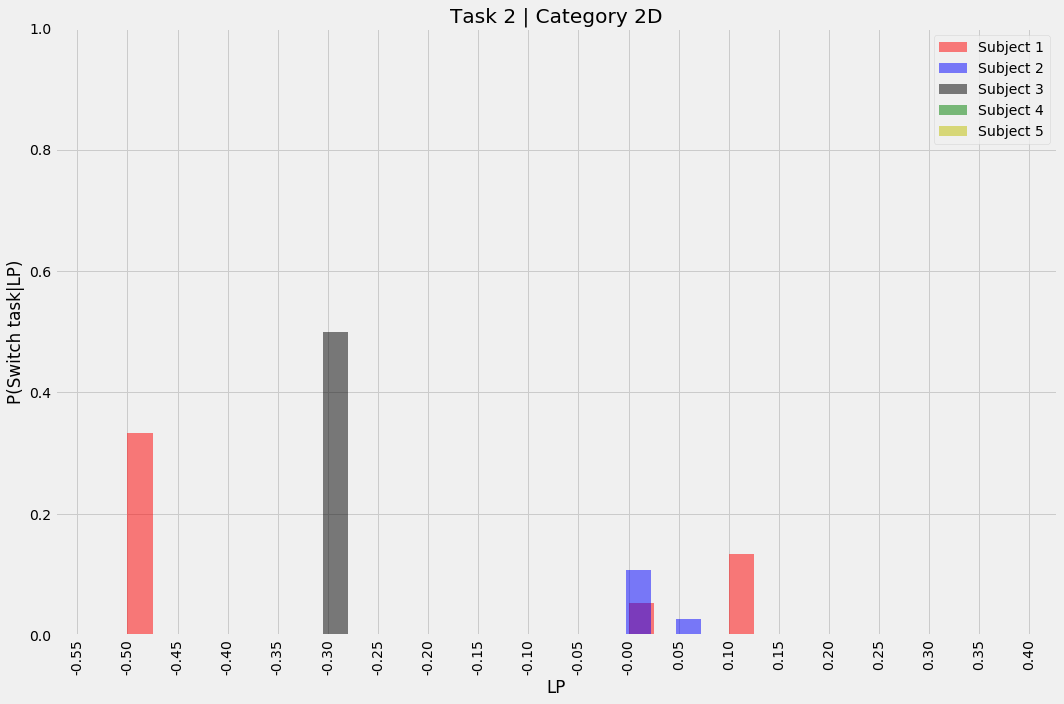

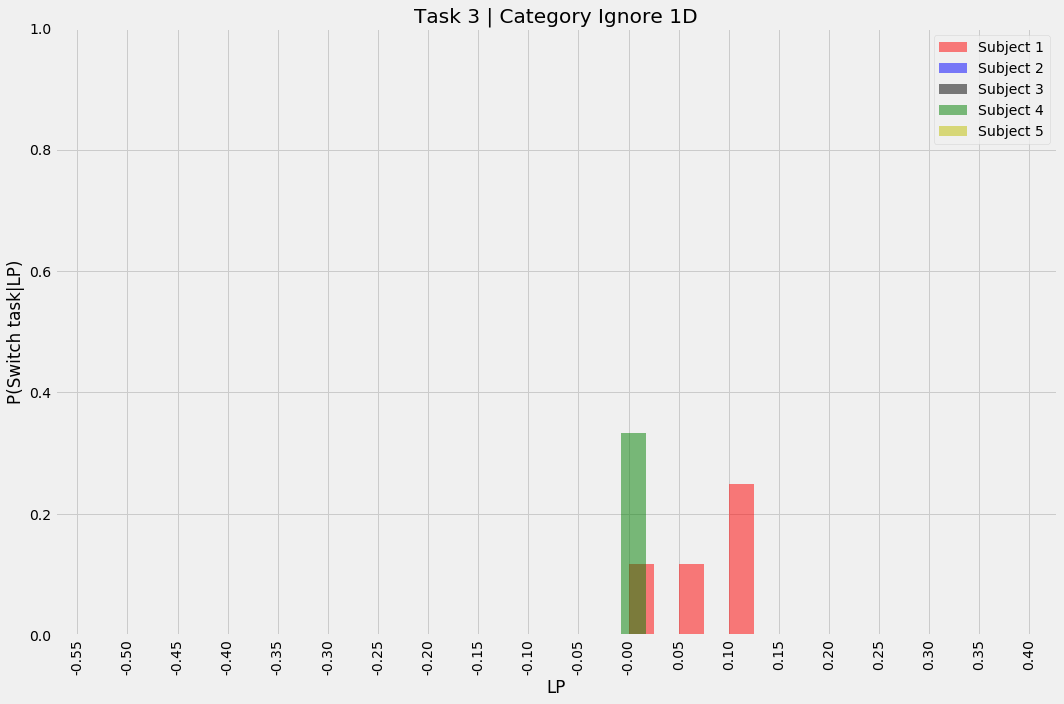

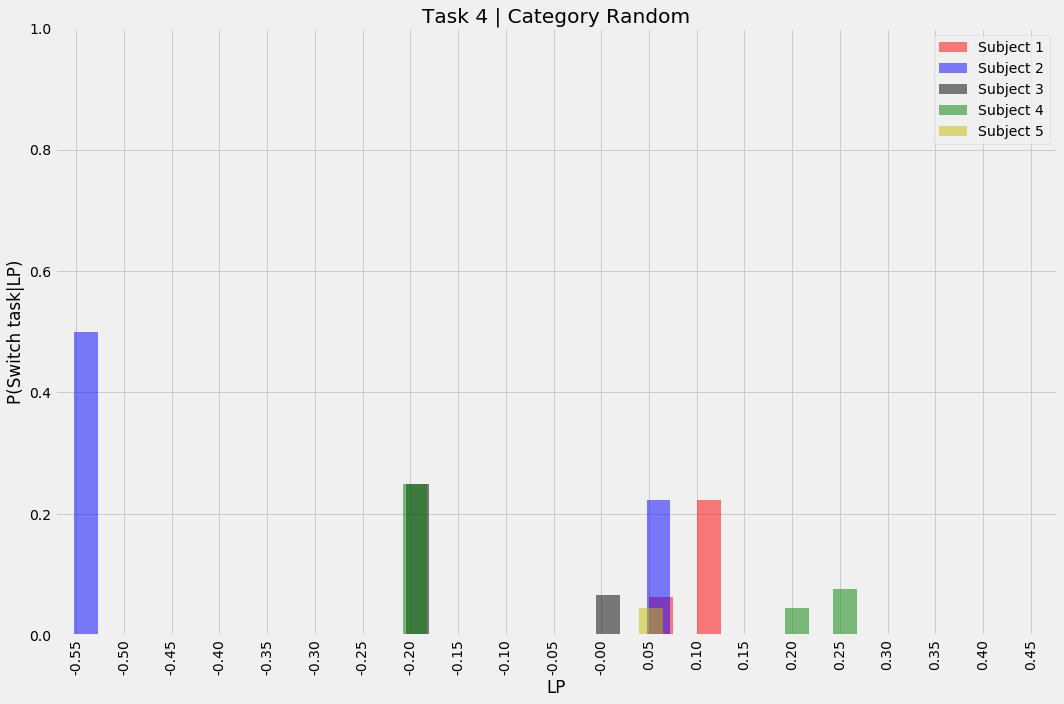

Window  15  Lookback LP  25


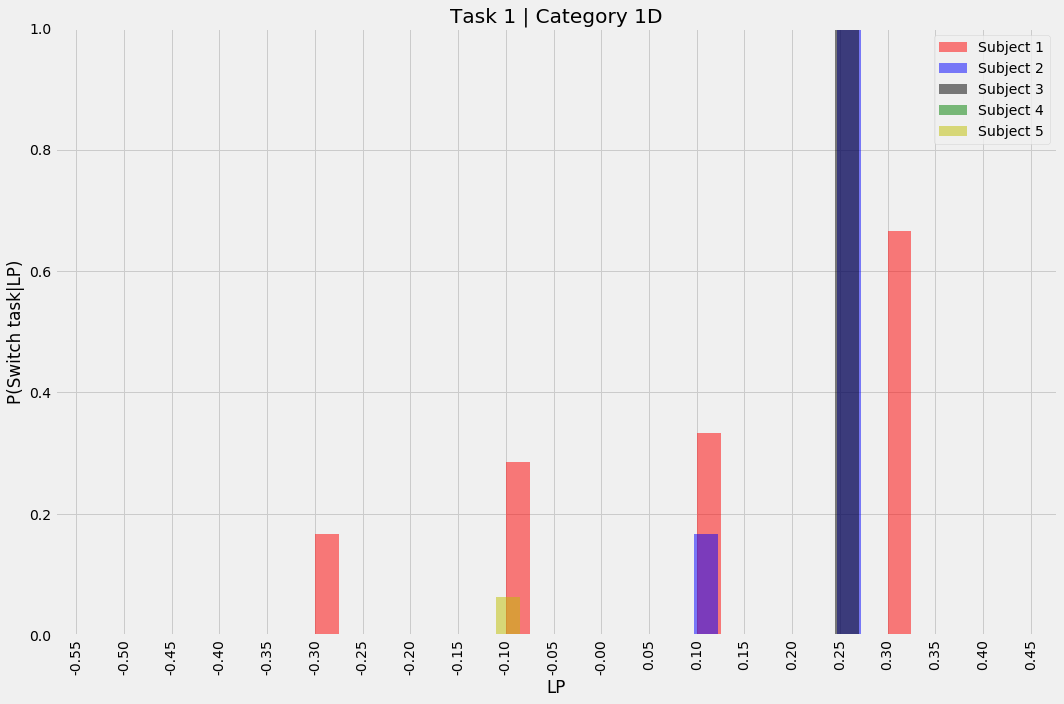

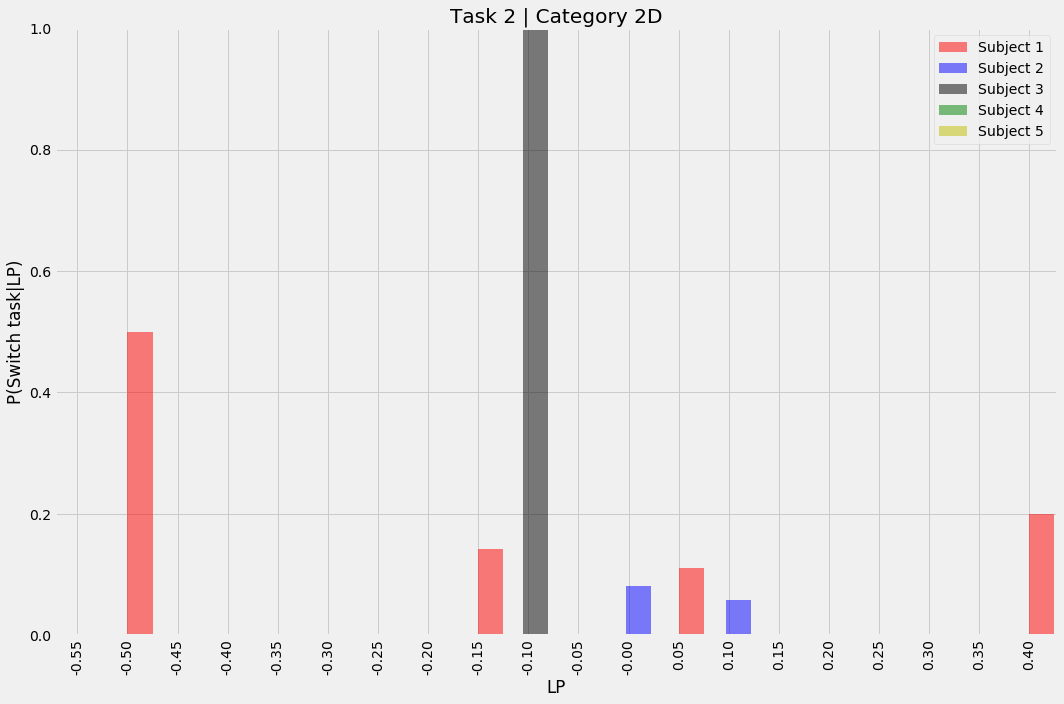

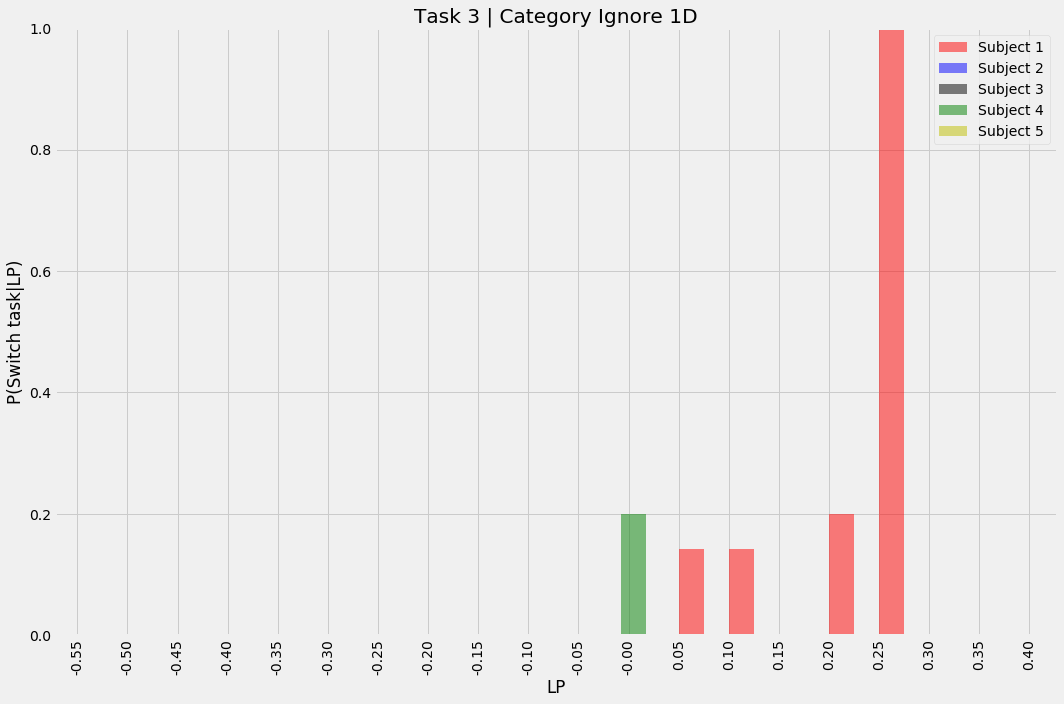

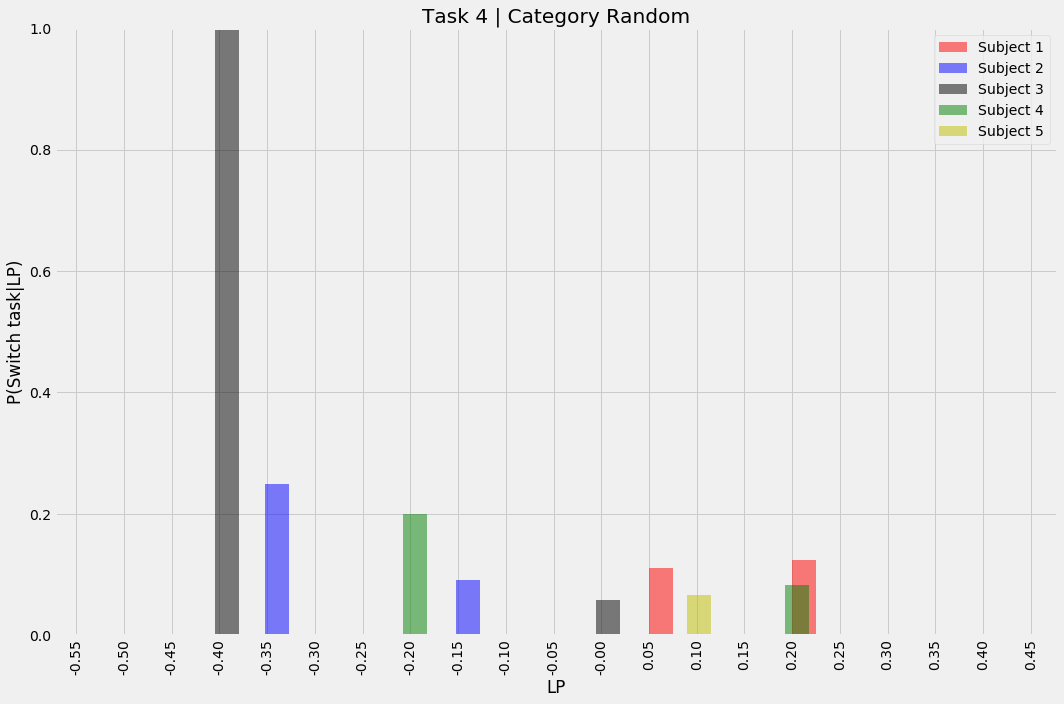

Window  15  Lookback LP  30


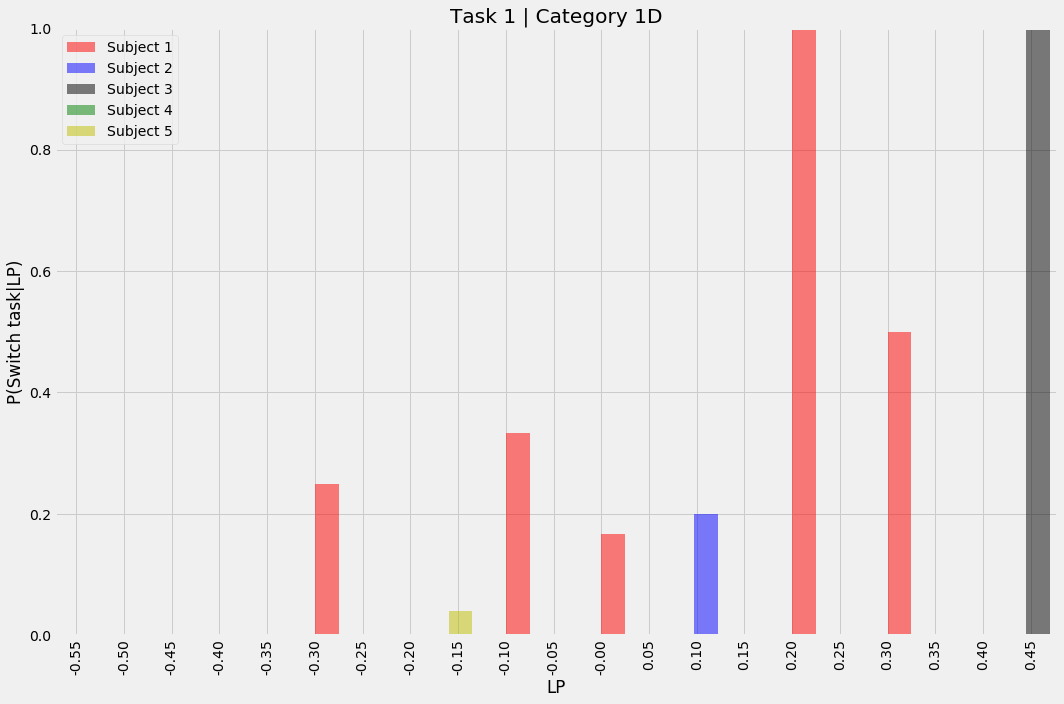

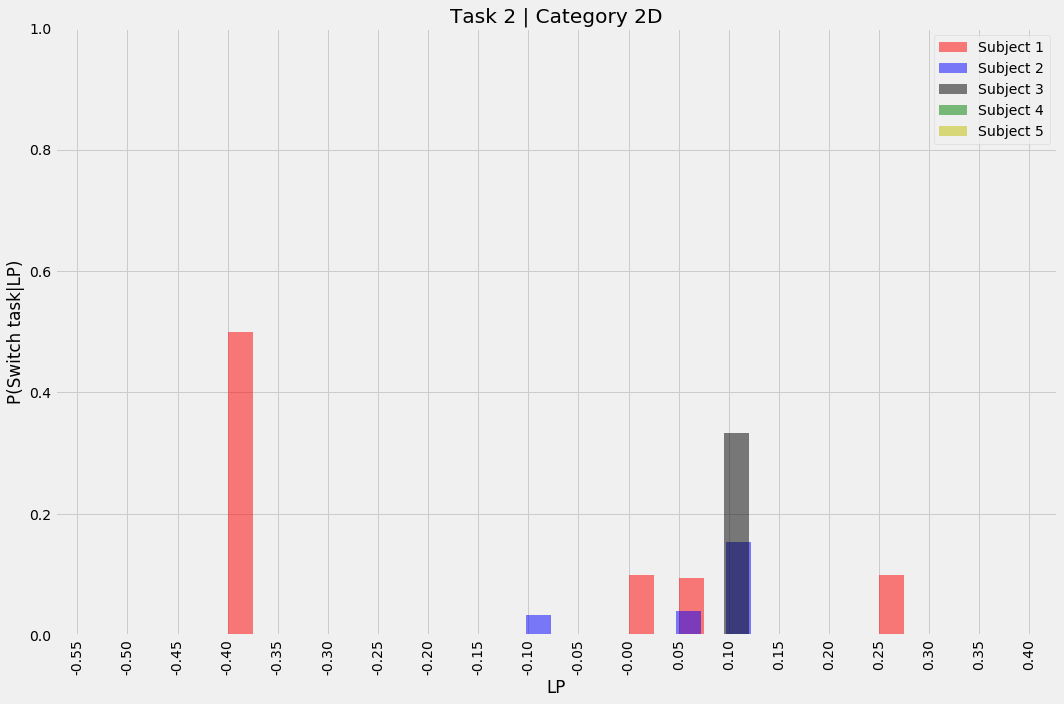

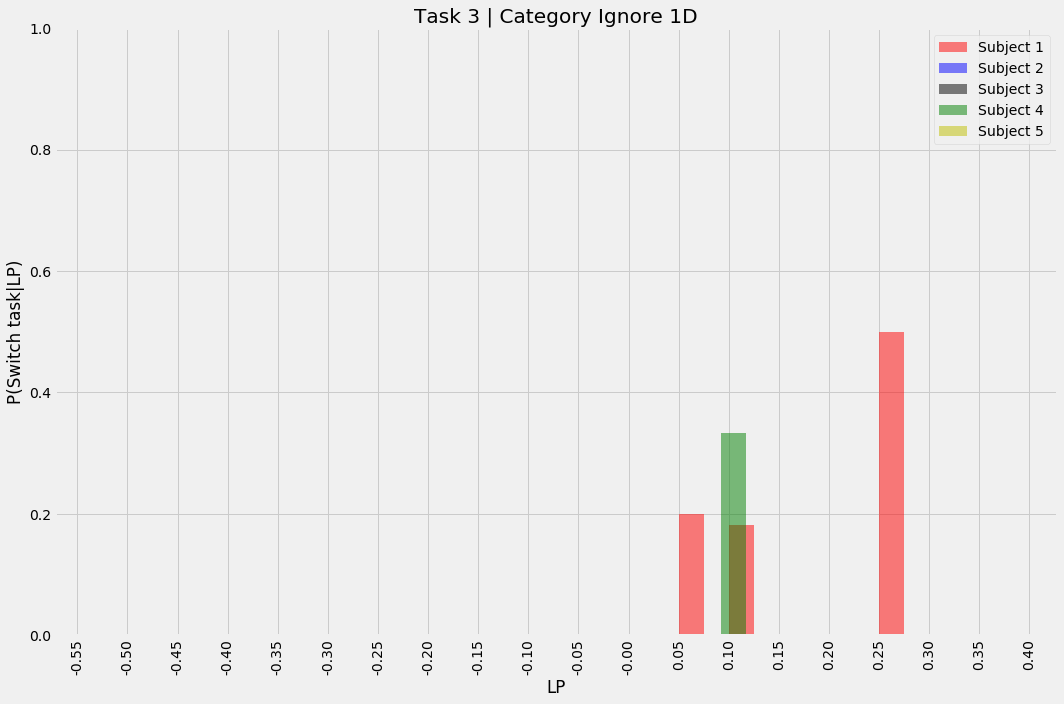

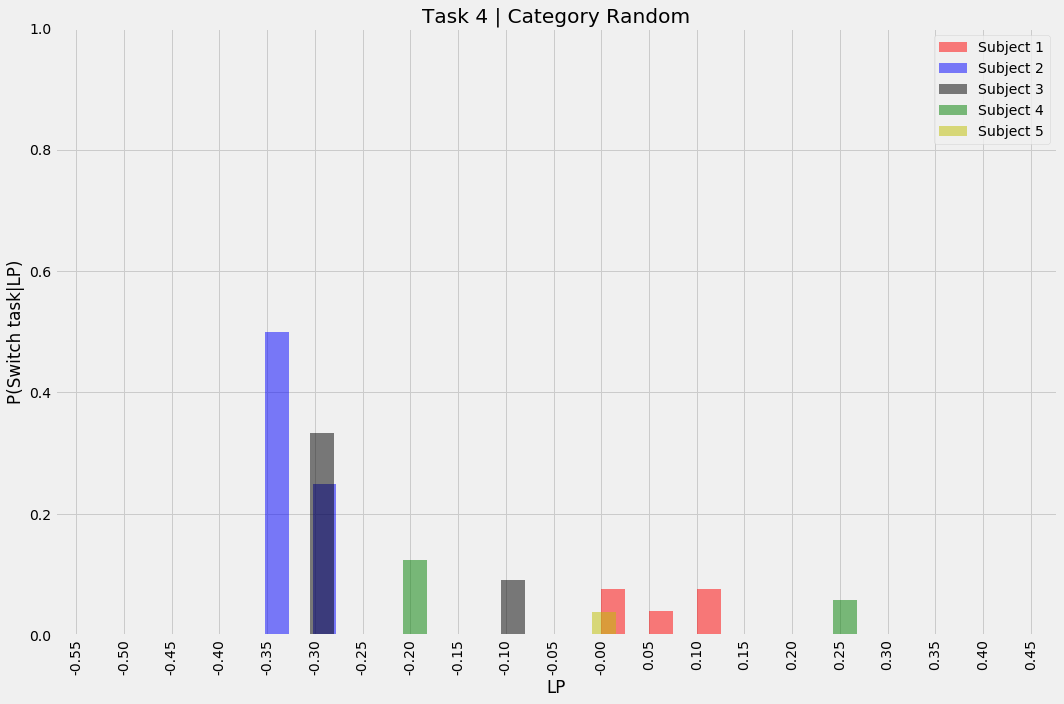

Window  20  Lookback LP  2


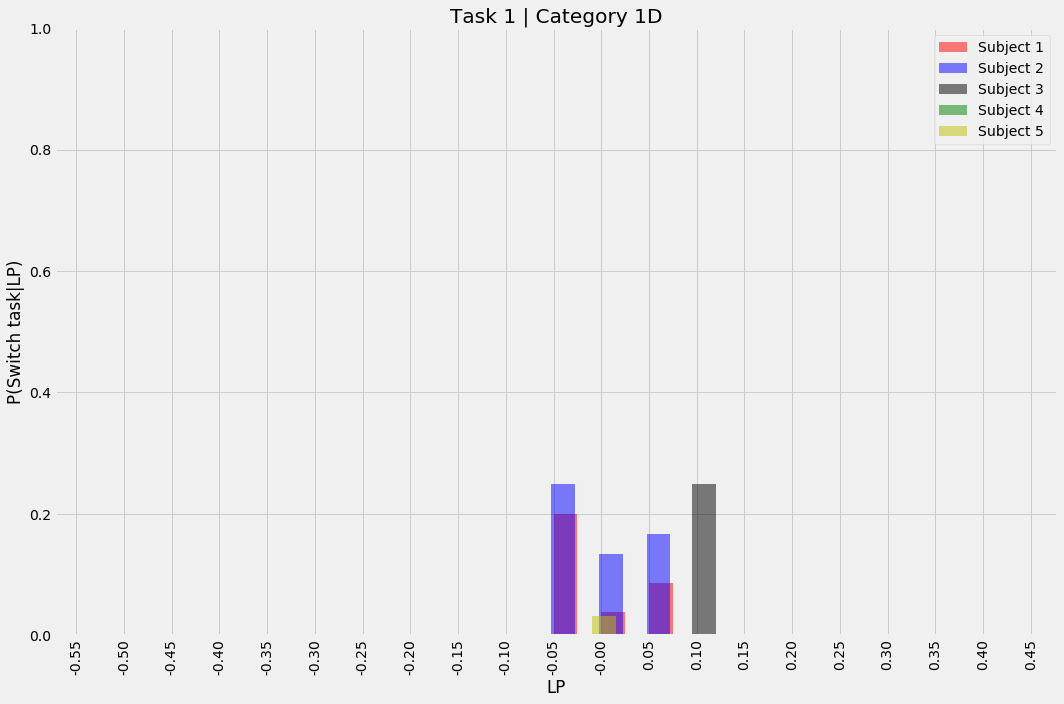

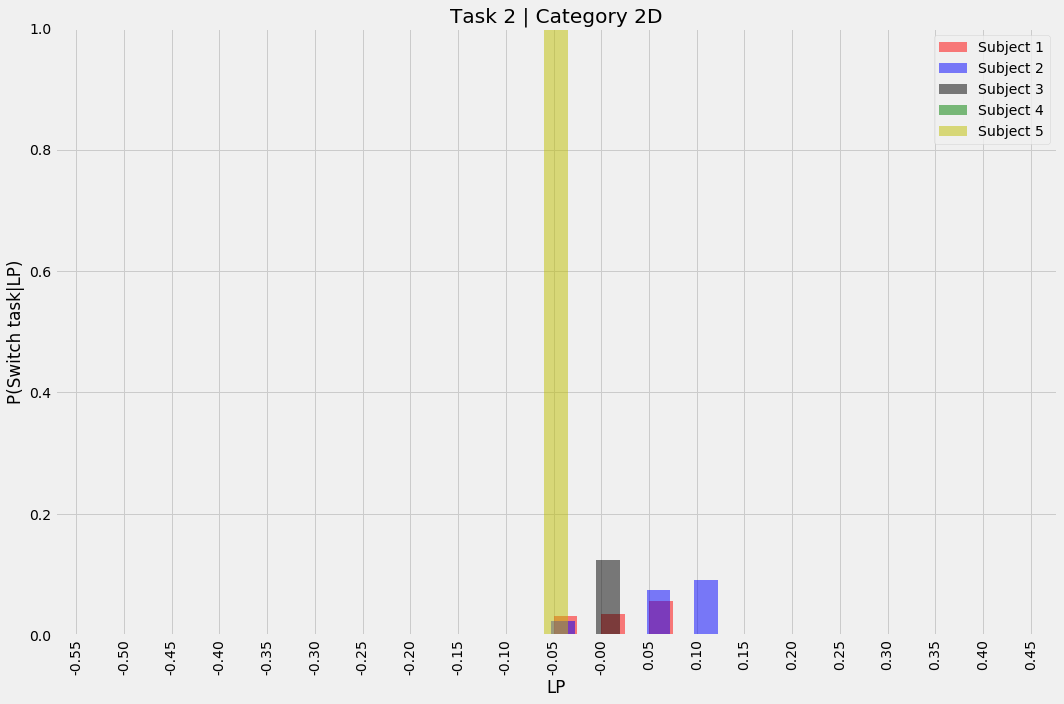

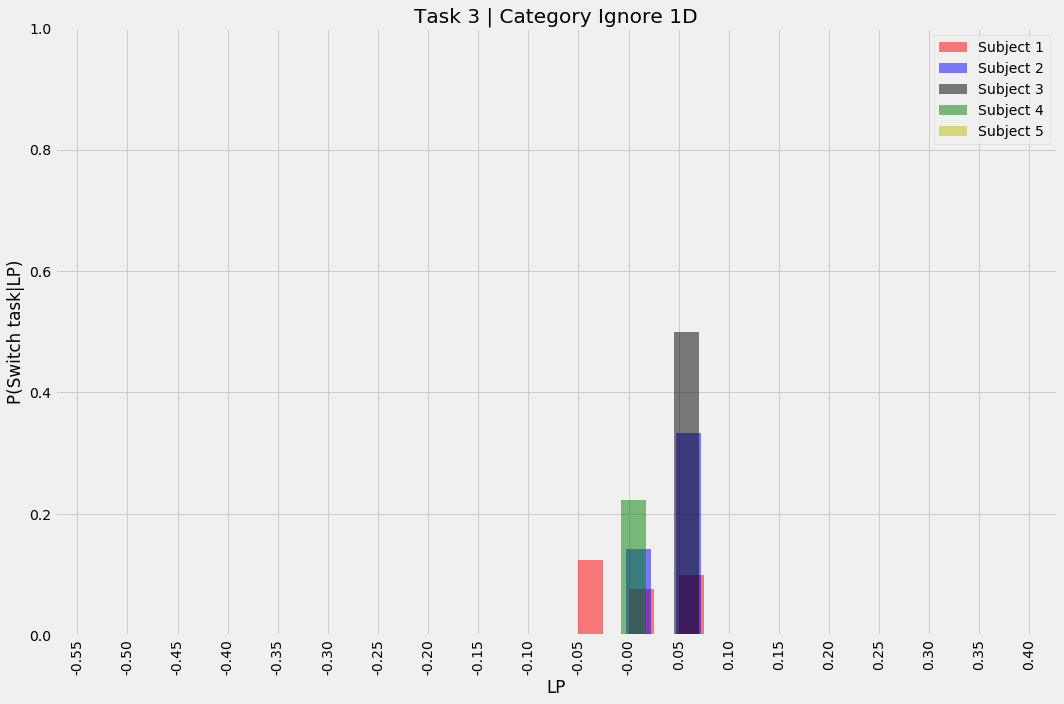

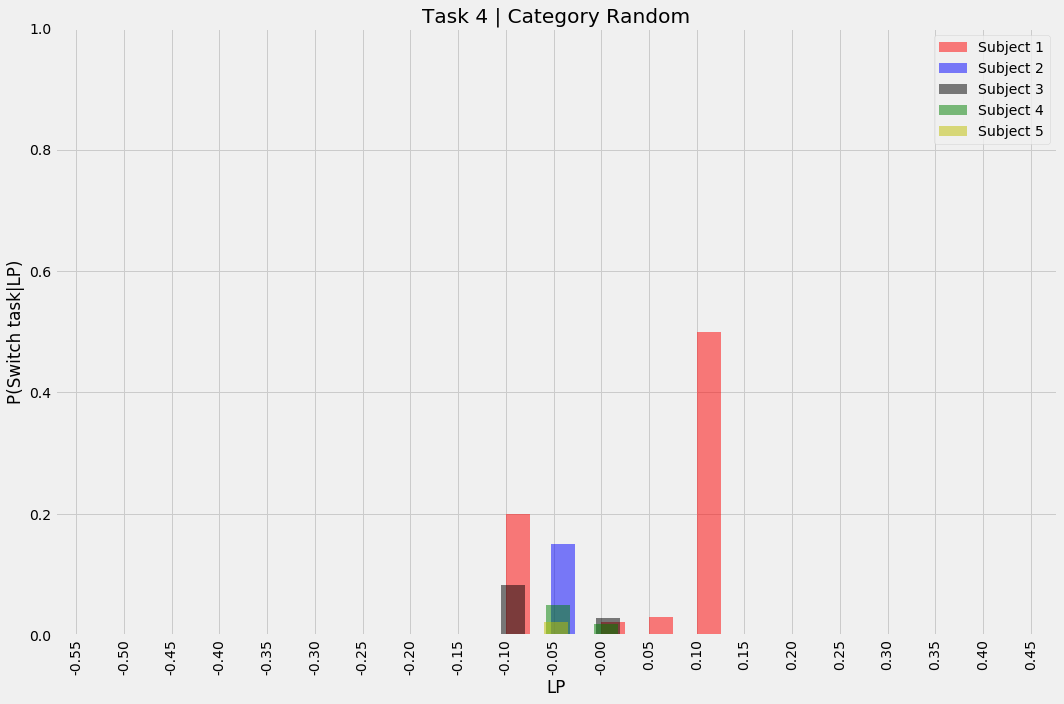

Window  20  Lookback LP  5


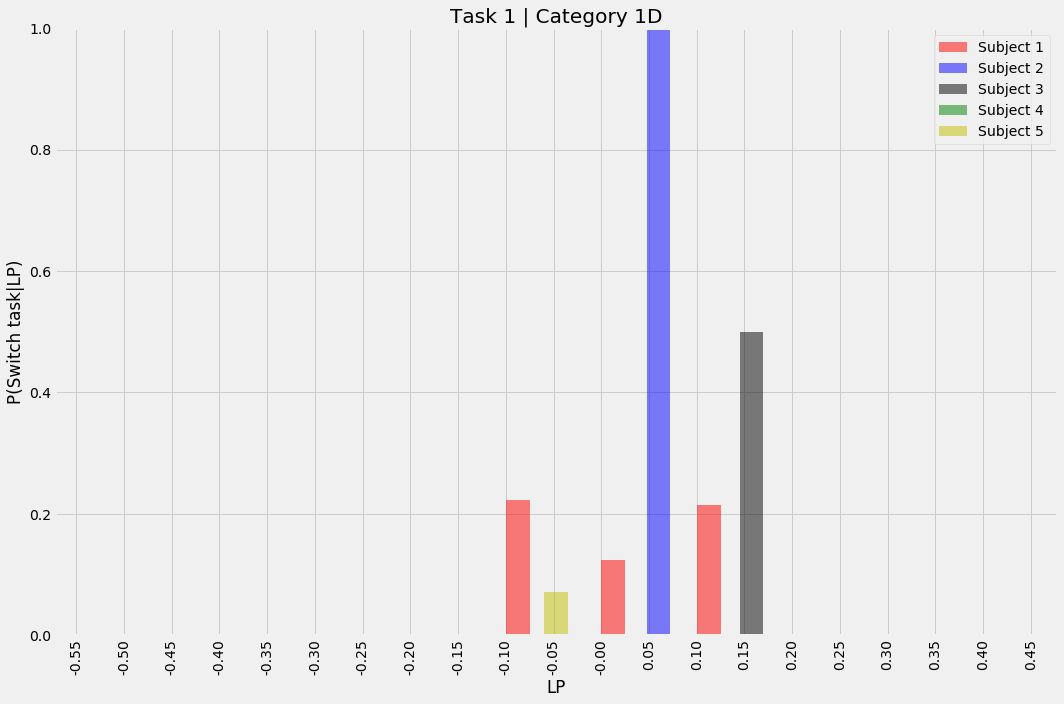

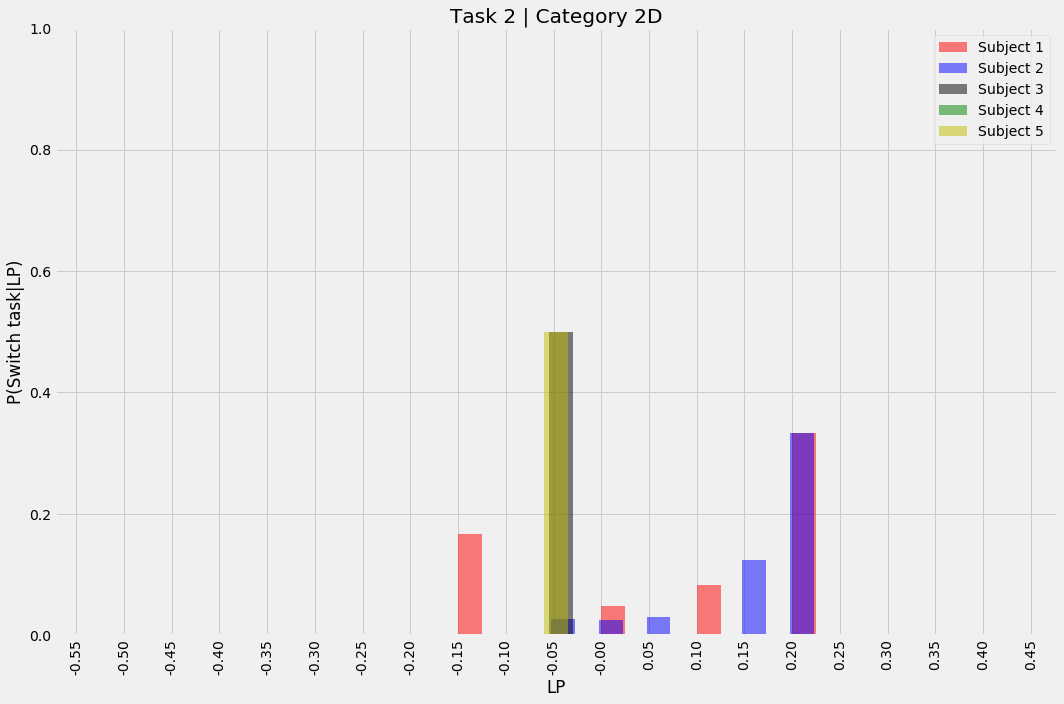

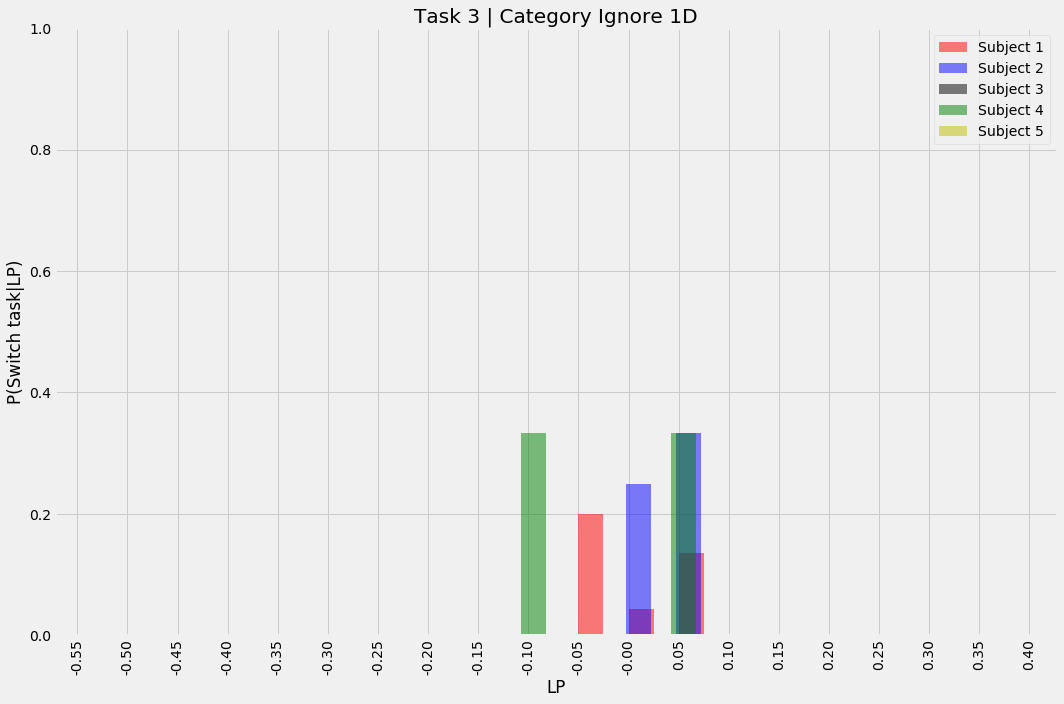

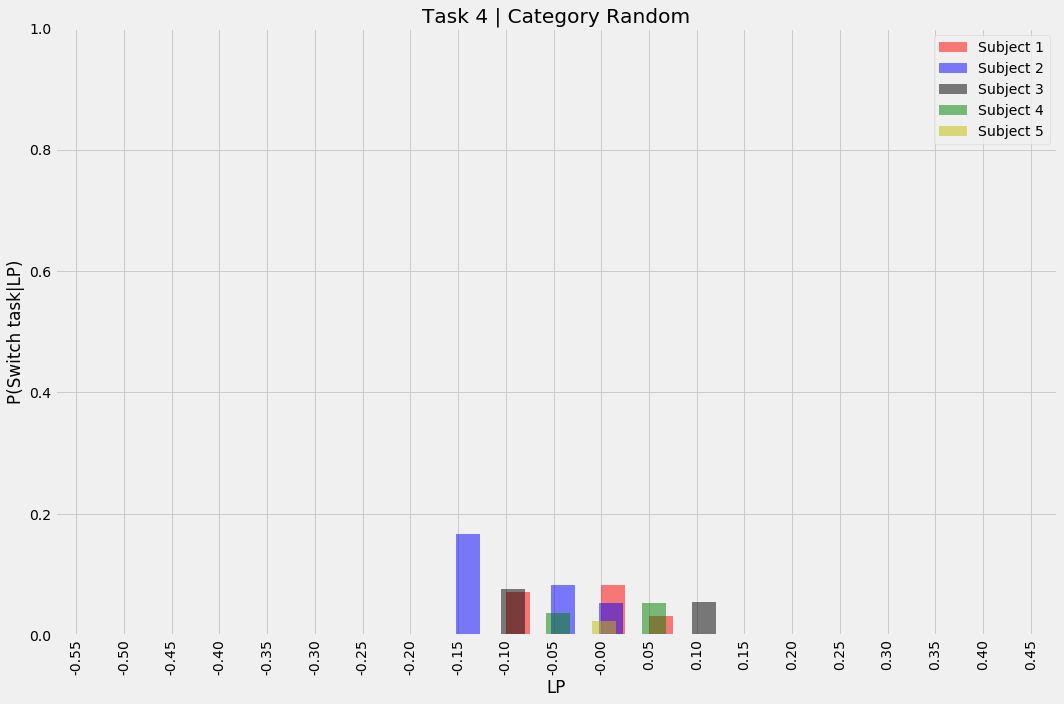

Window  20  Lookback LP  10


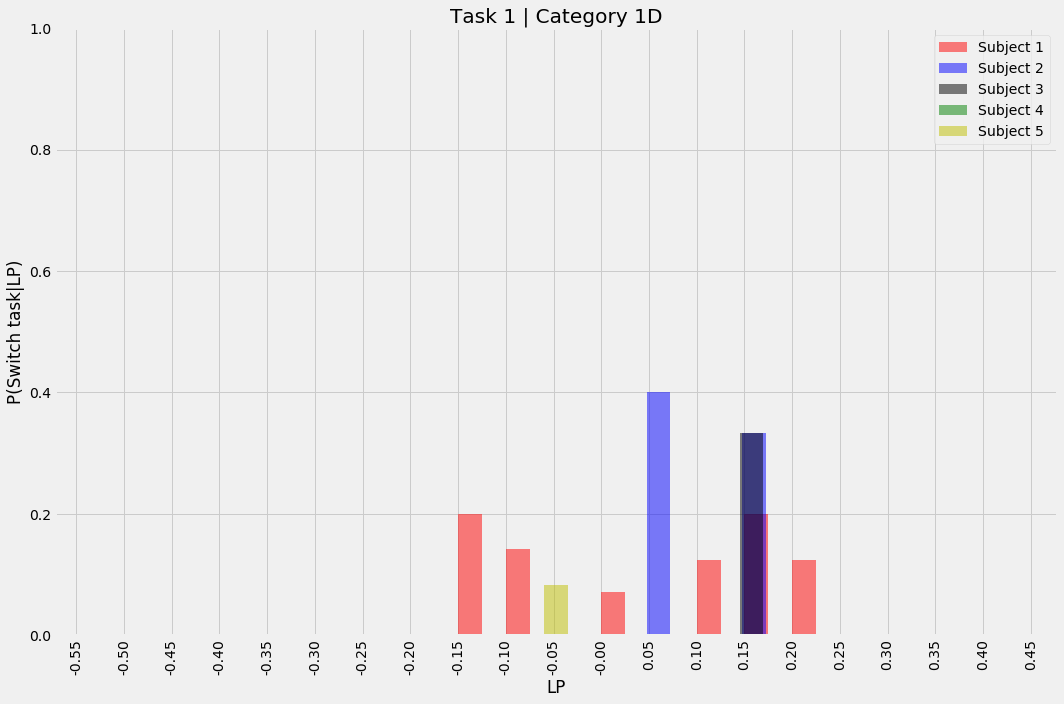

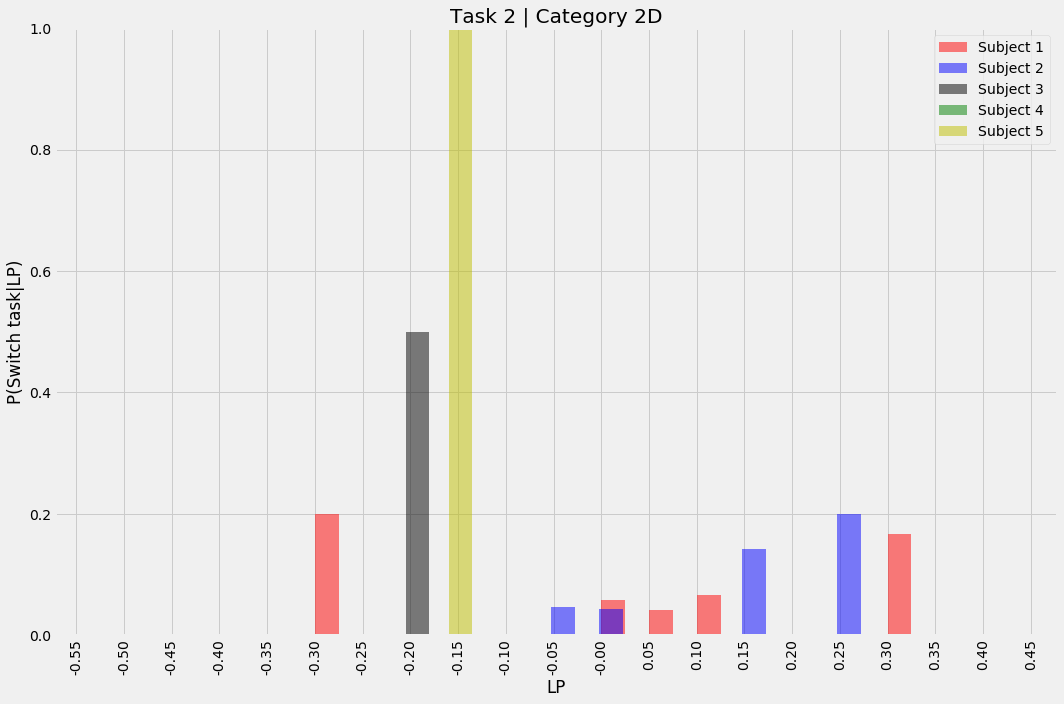

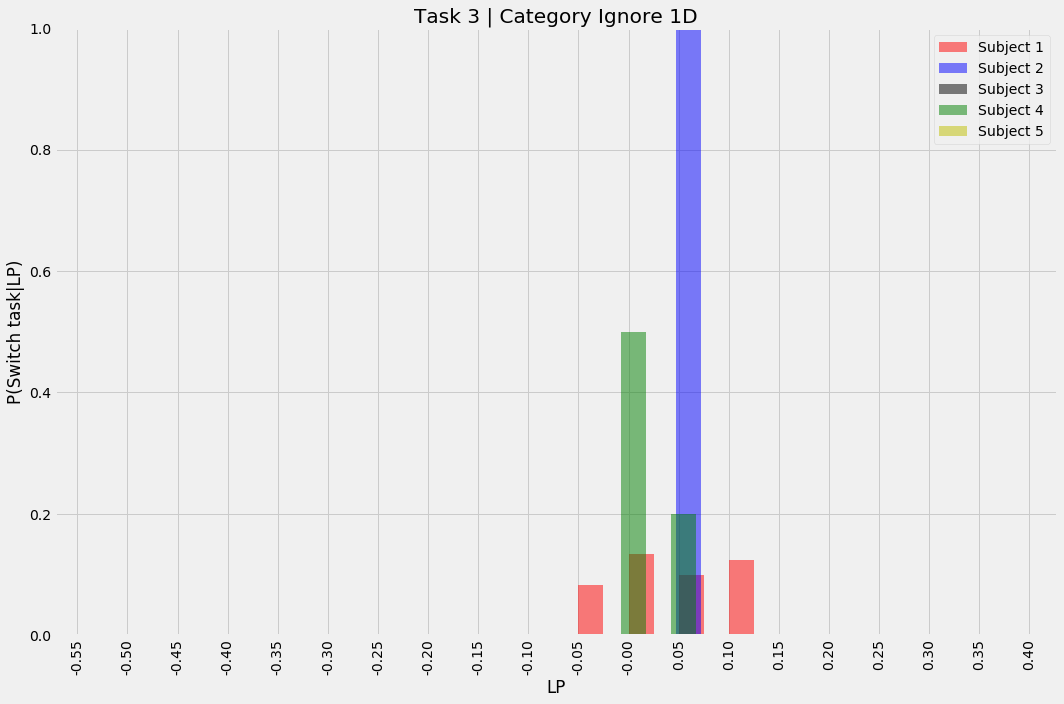

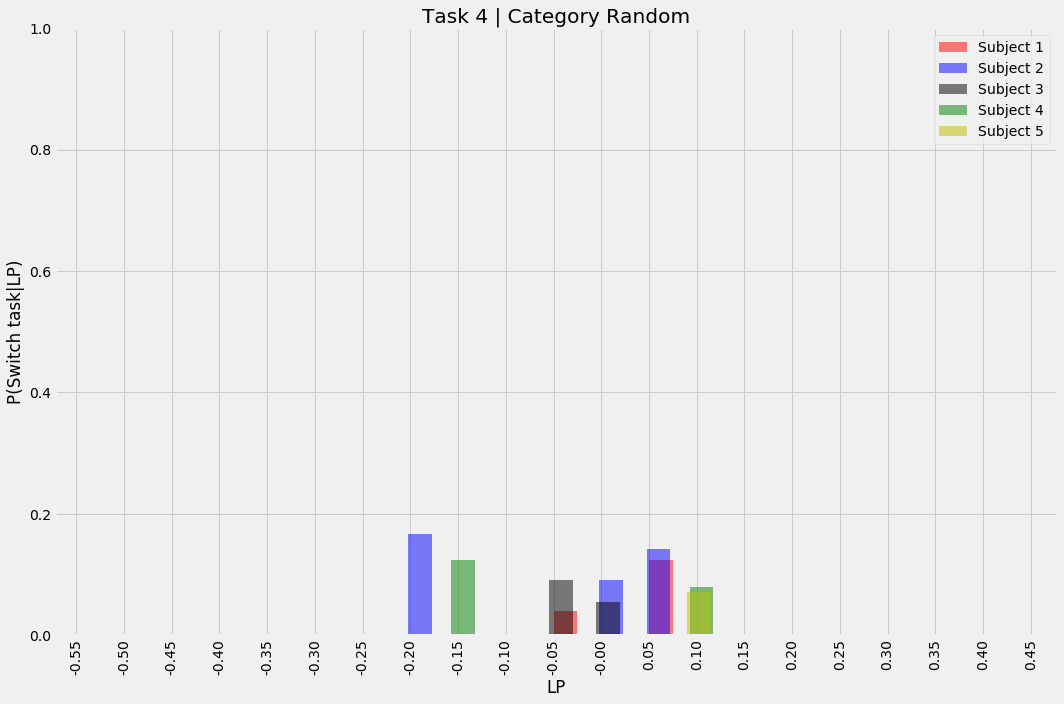

Window  20  Lookback LP  15


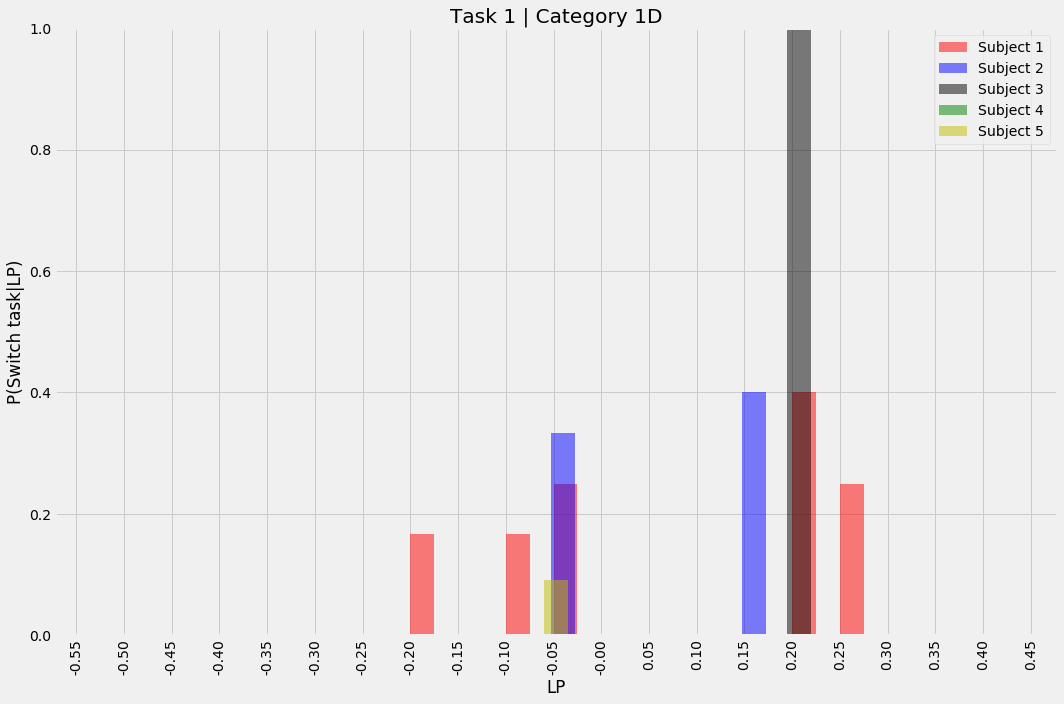

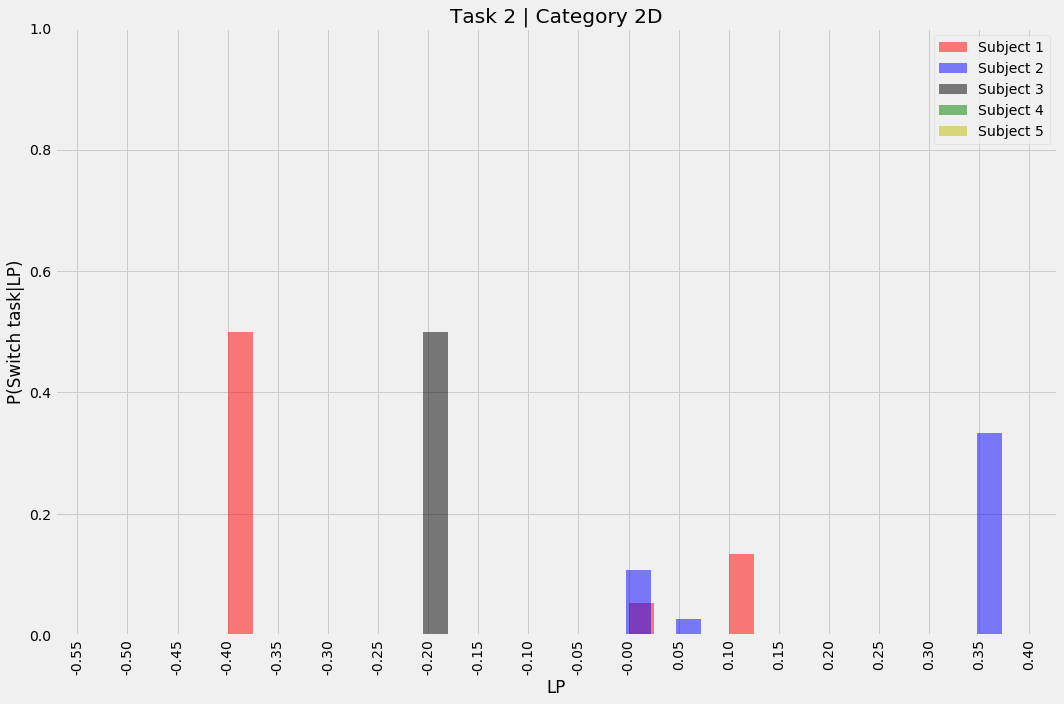

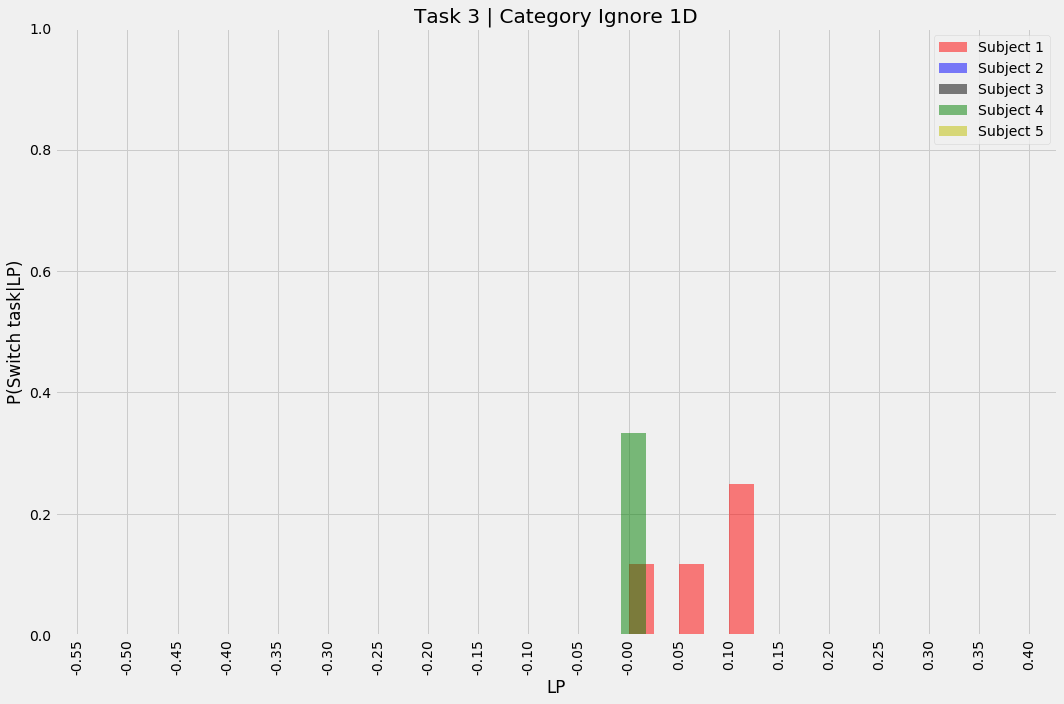

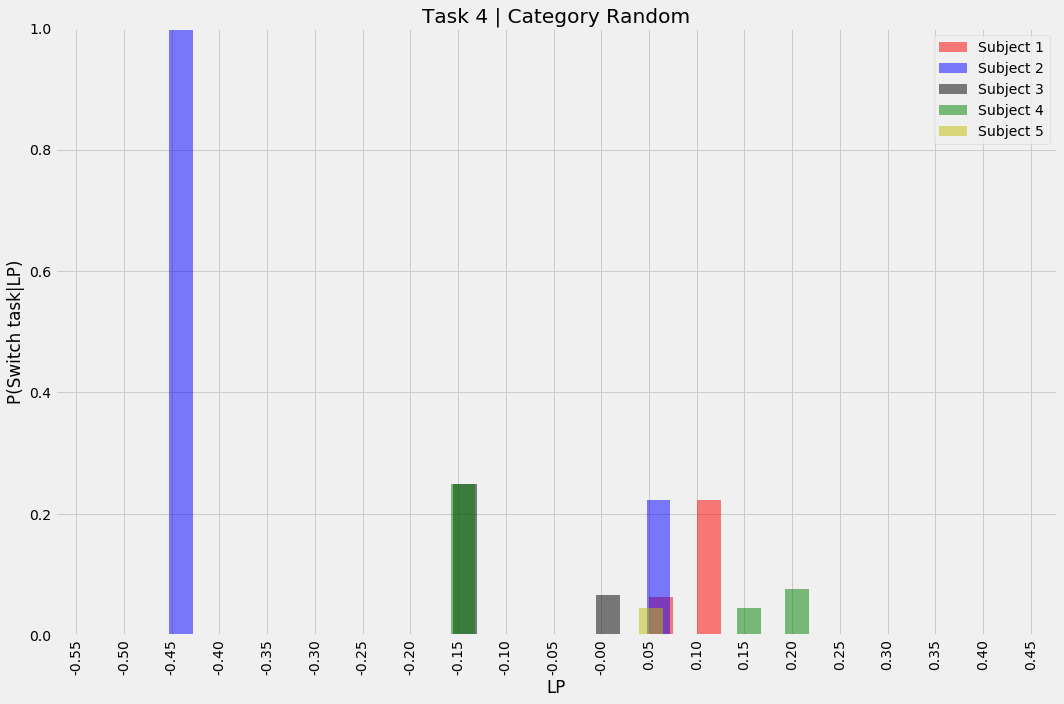

Window  20  Lookback LP  20


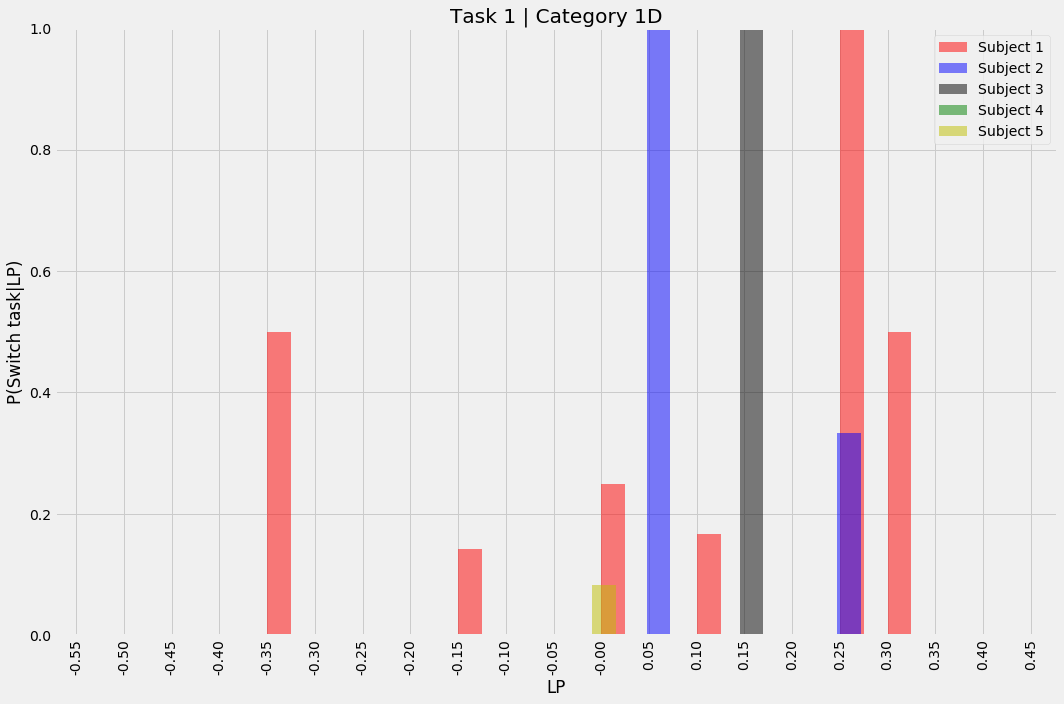

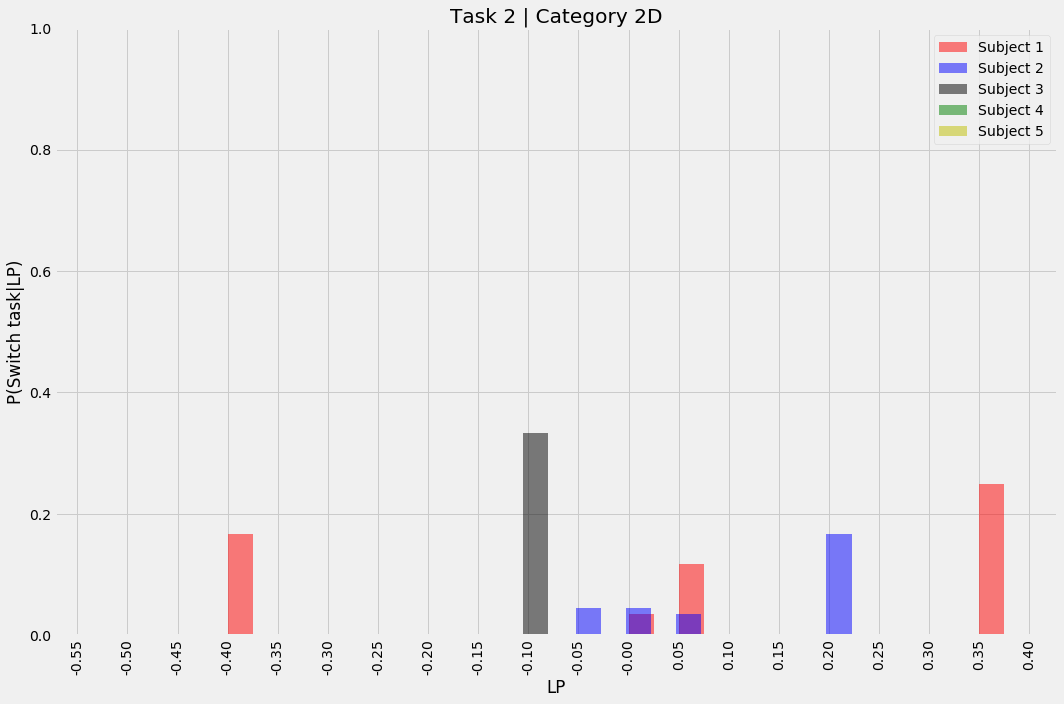

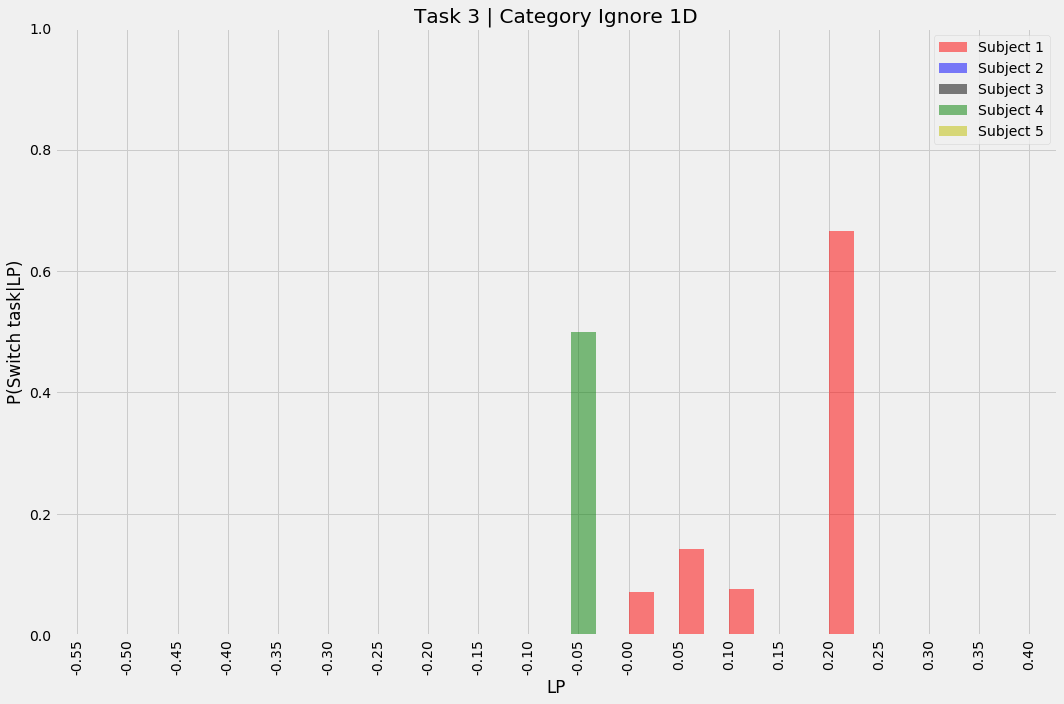

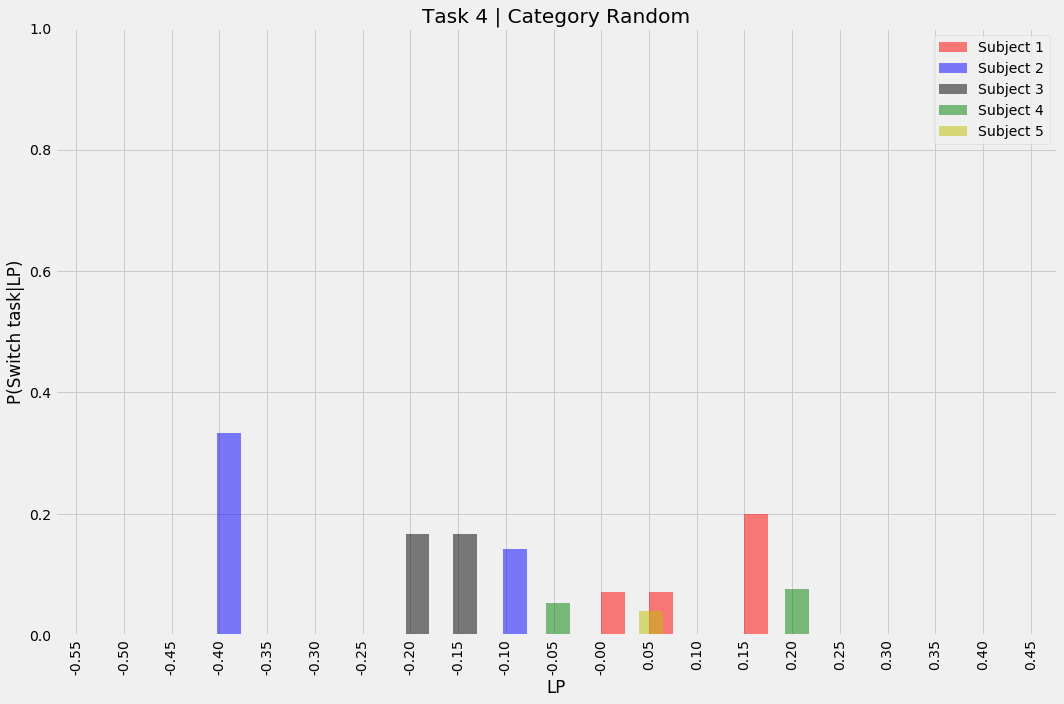

Window  20  Lookback LP  25


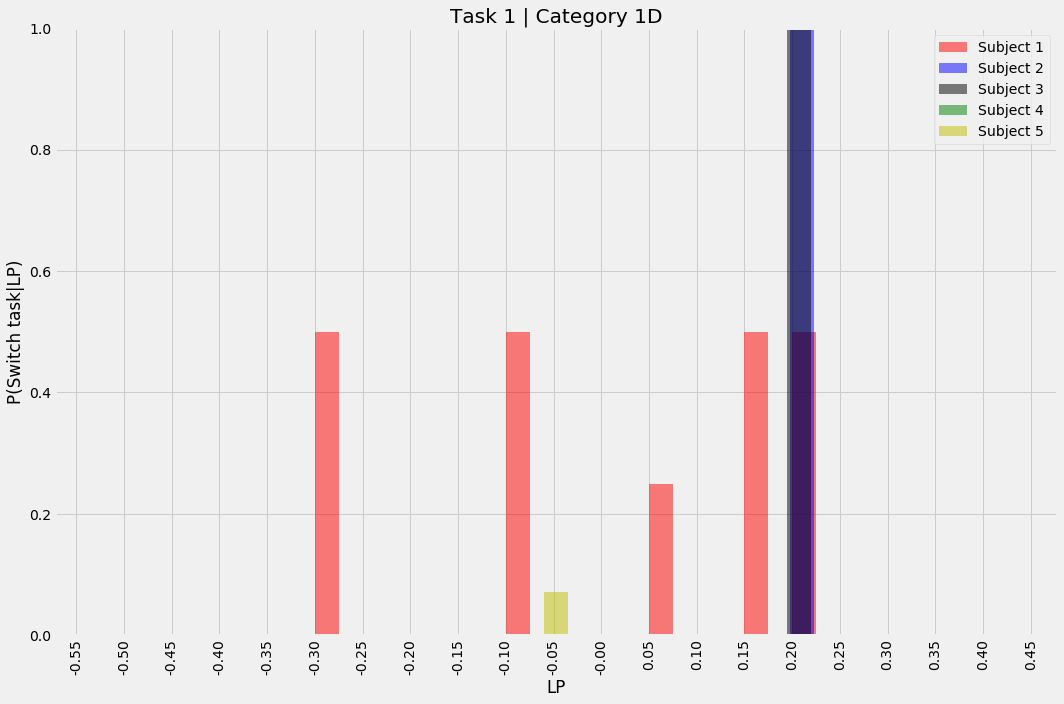

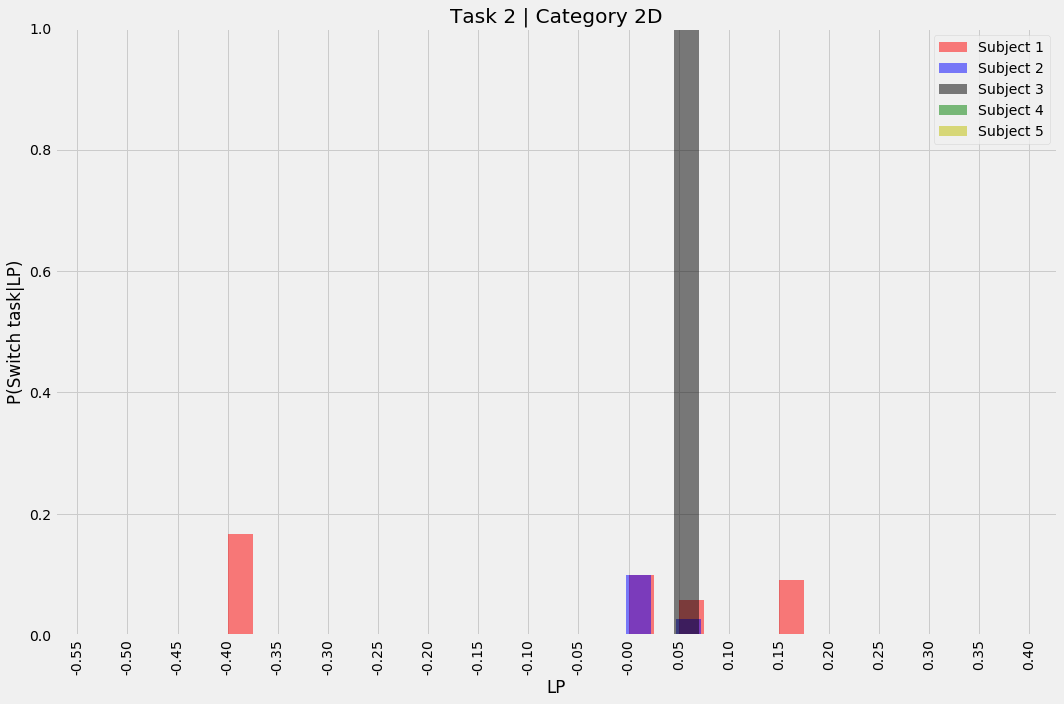

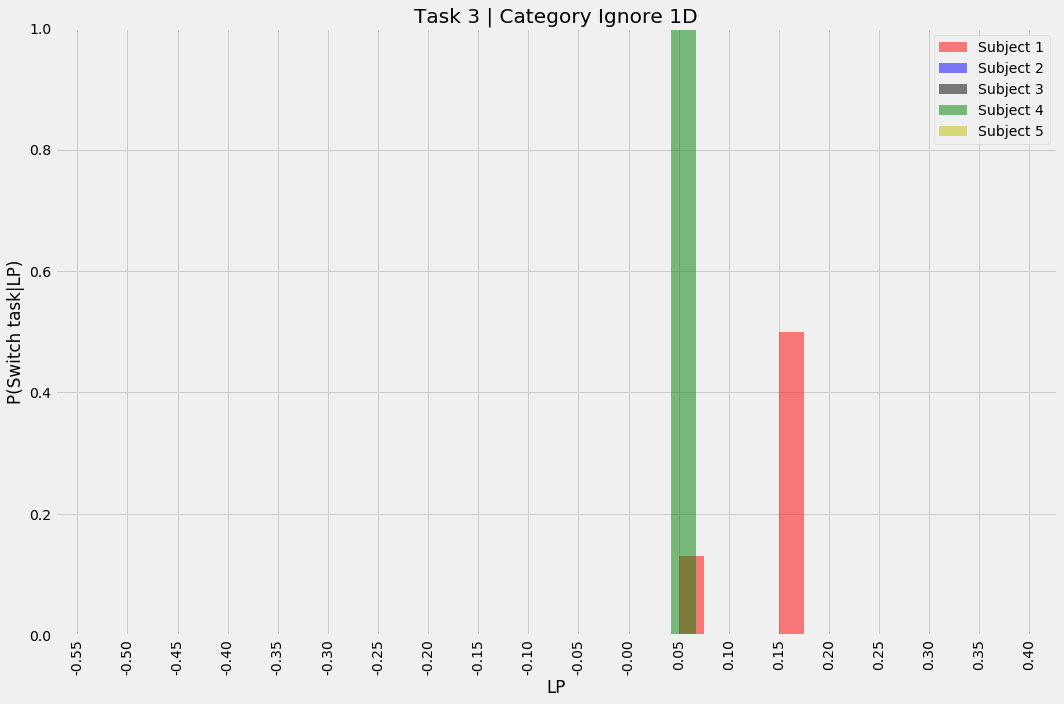

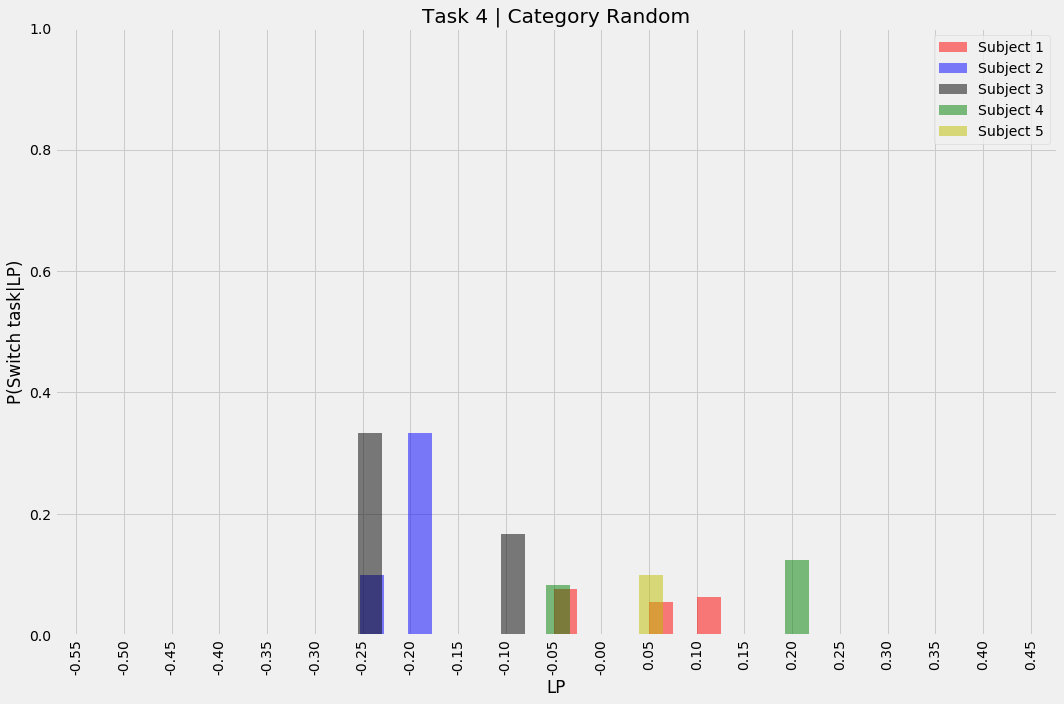

Window  20  Lookback LP  30


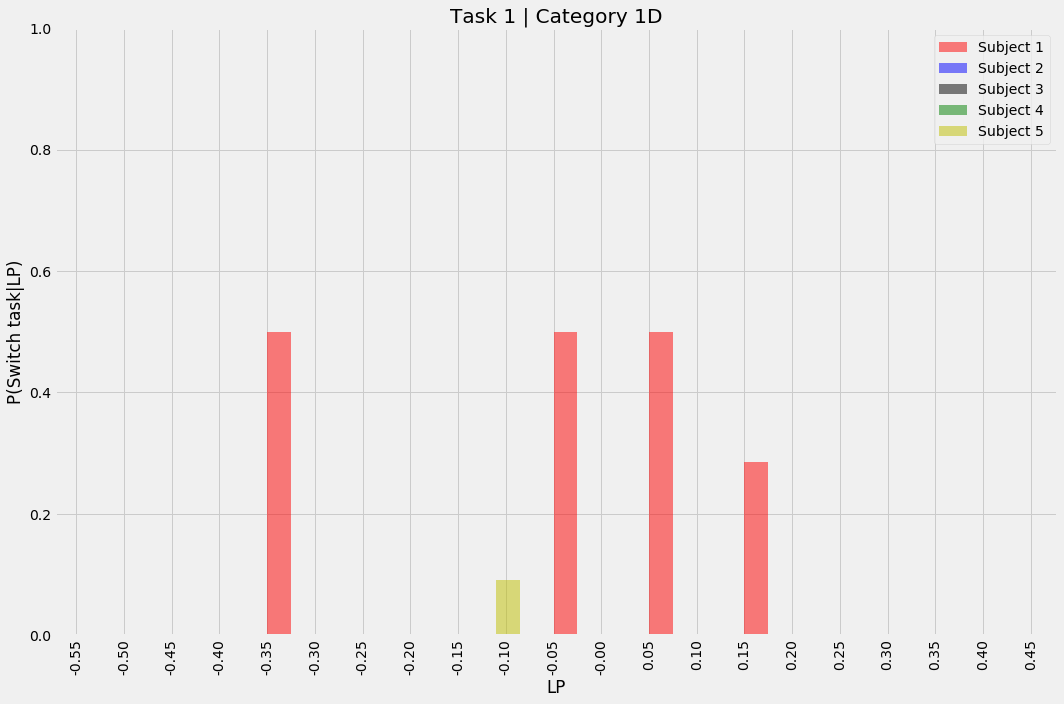

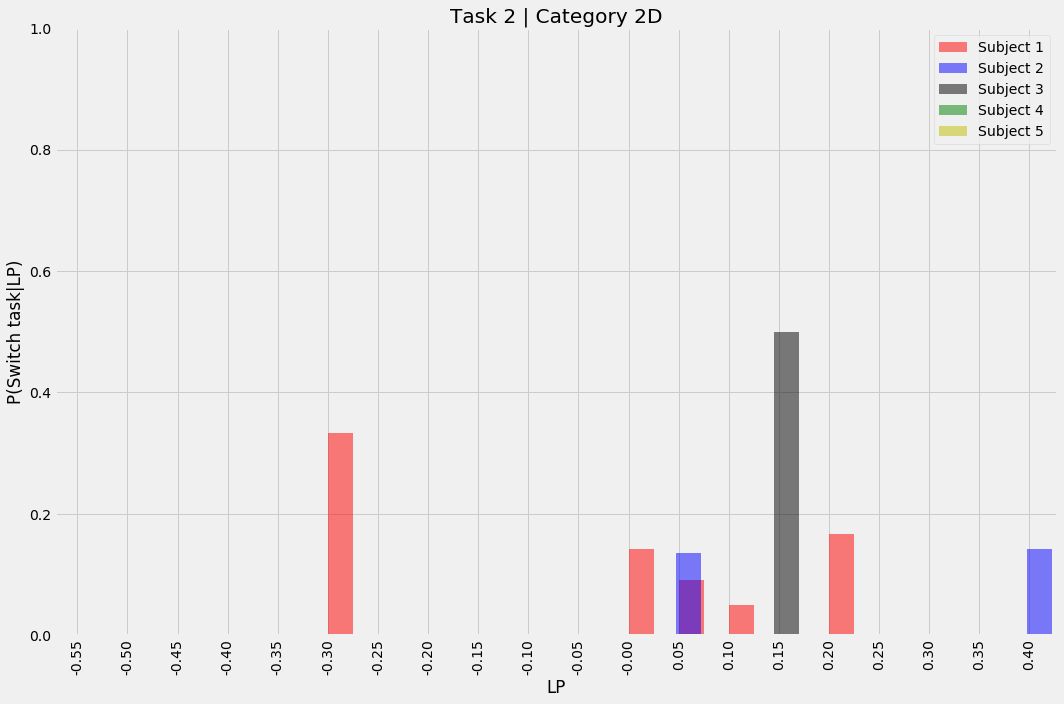

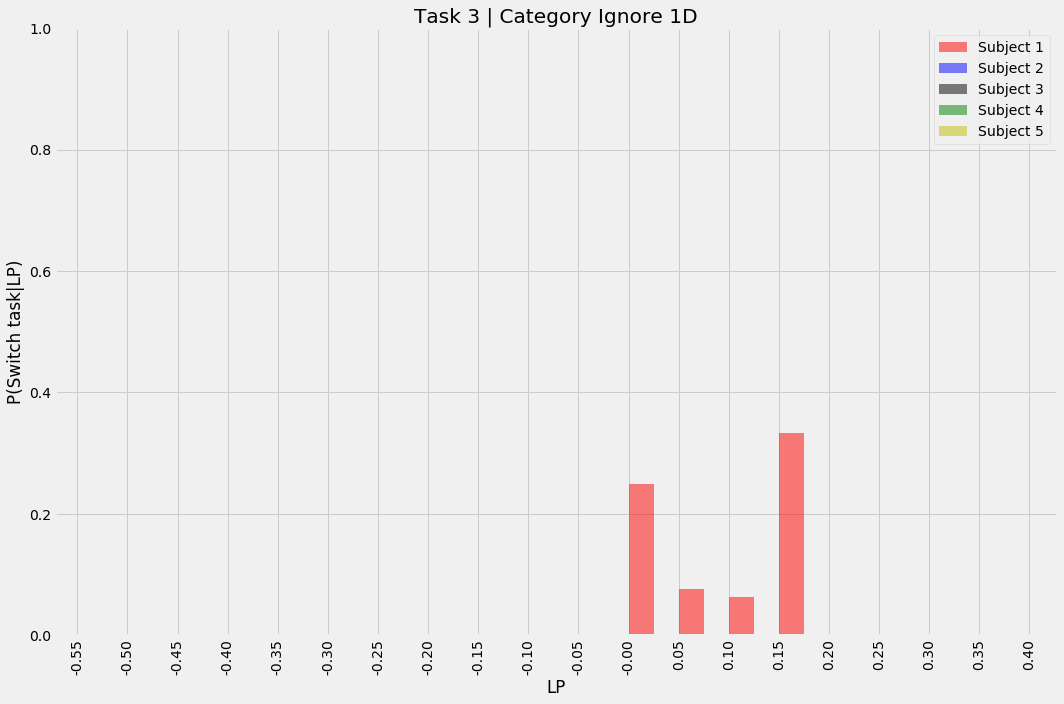

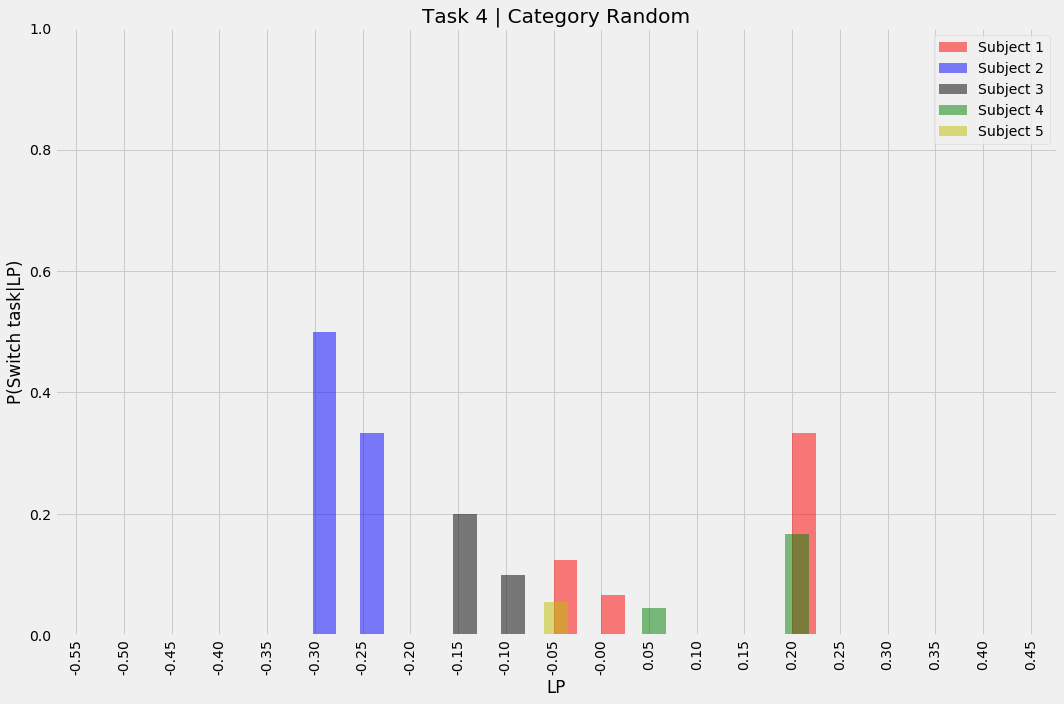

Window  25  Lookback LP  2


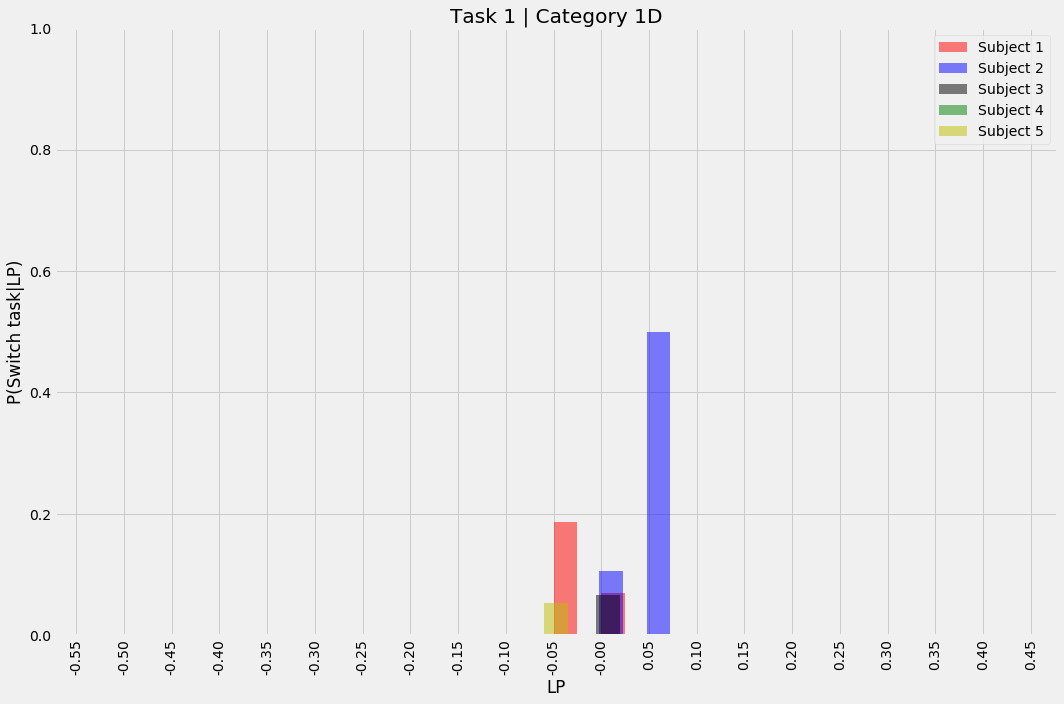

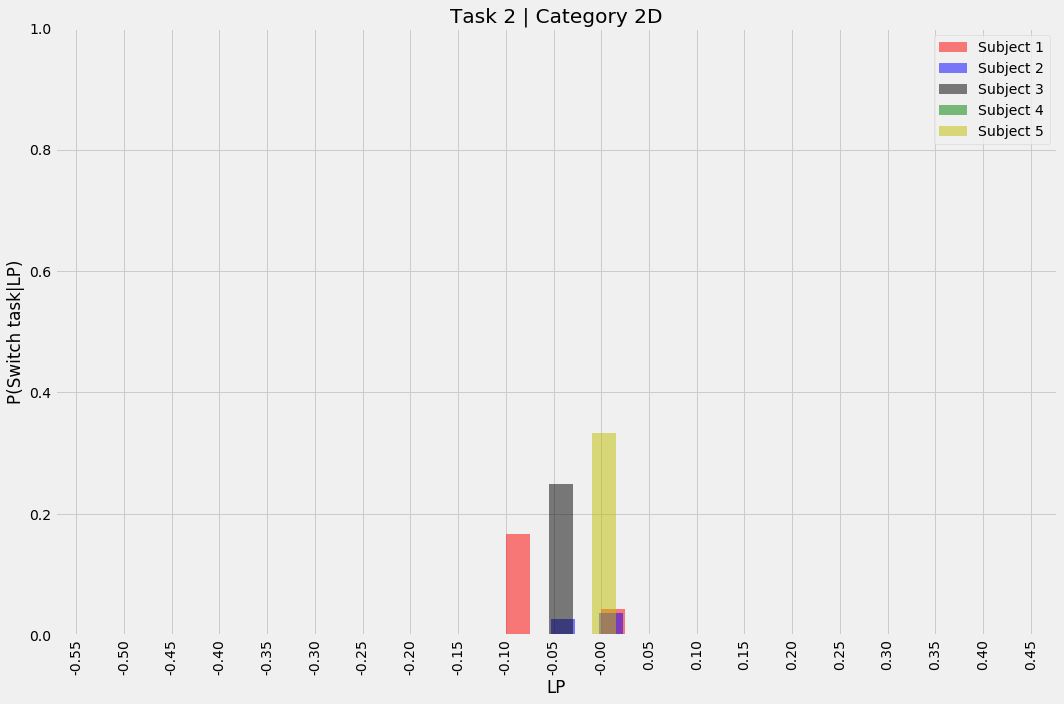

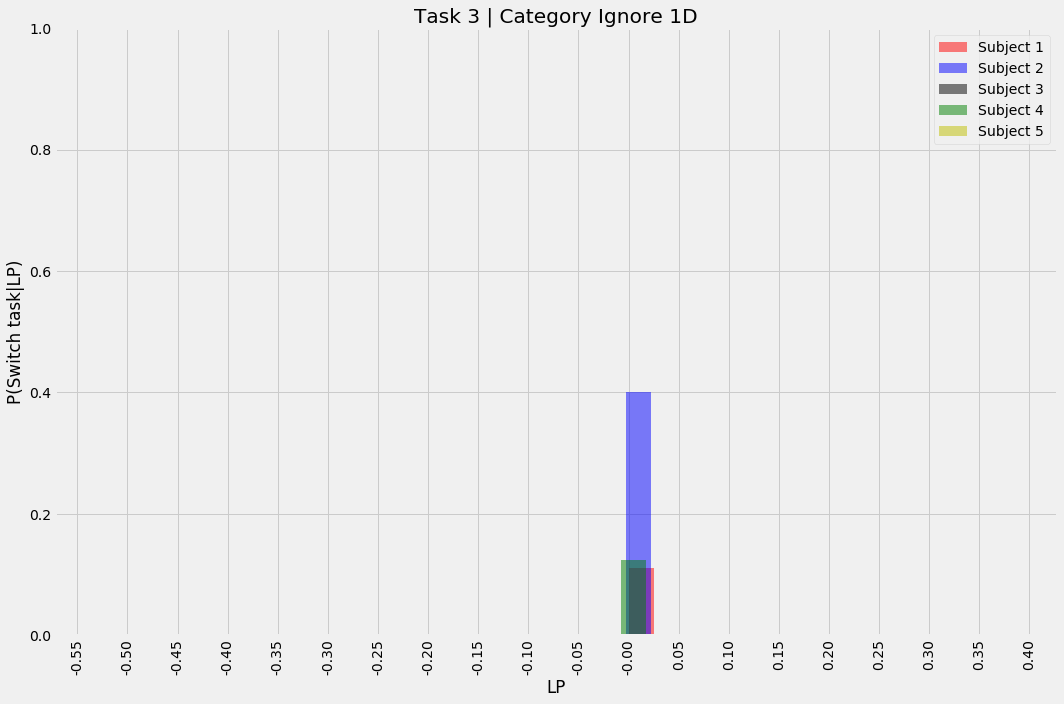

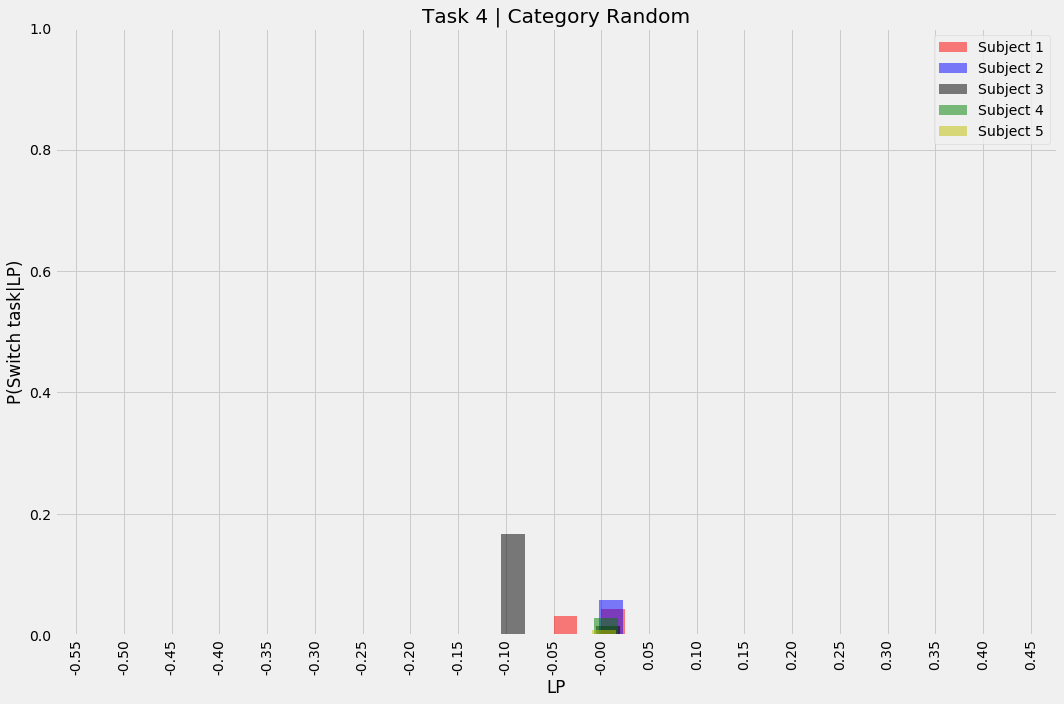

Window  25  Lookback LP  5


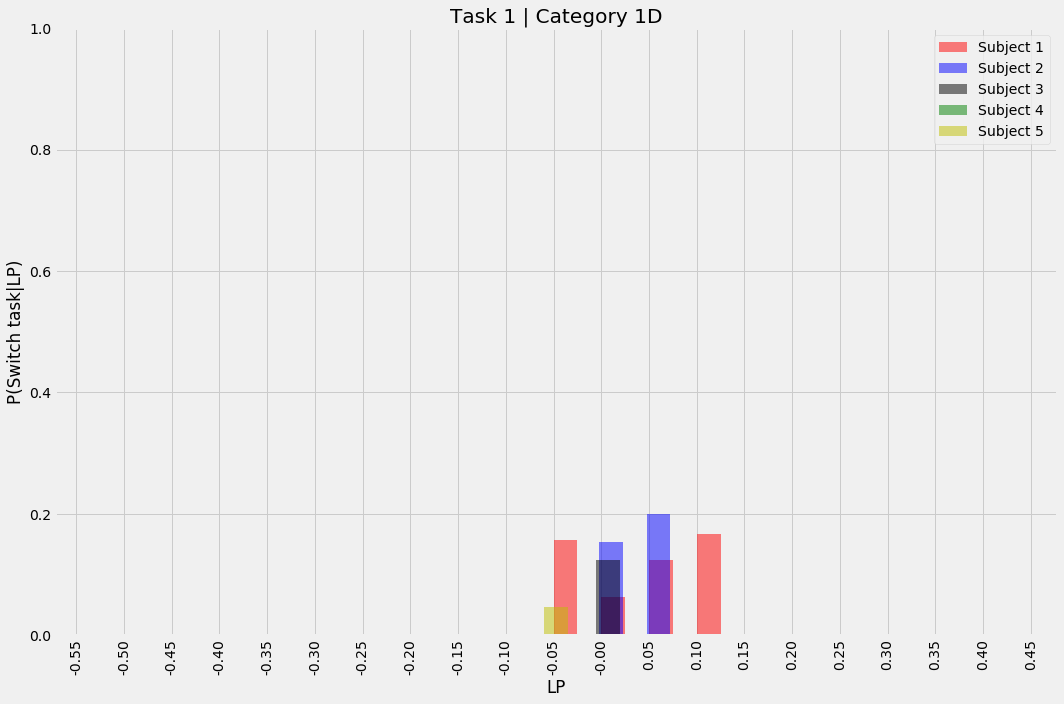

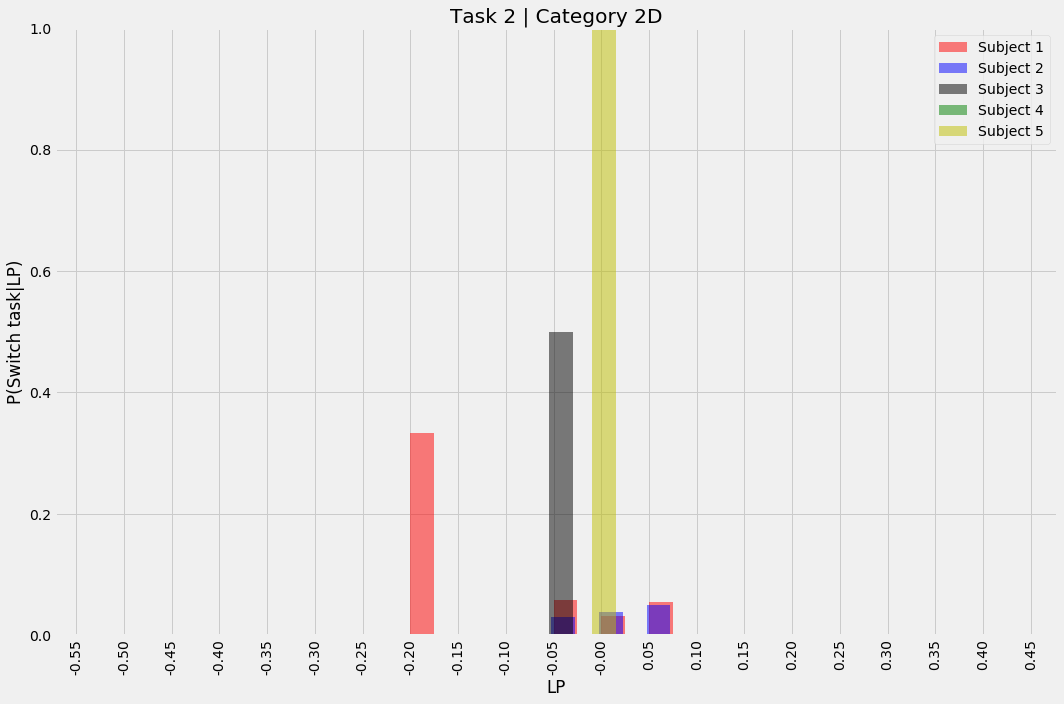

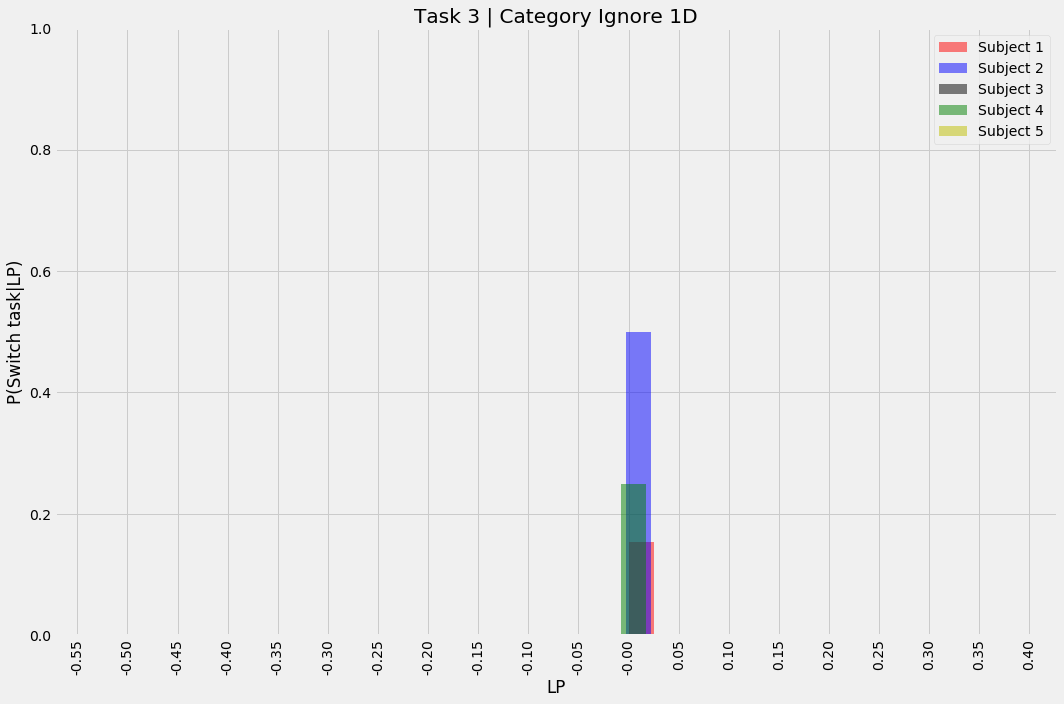

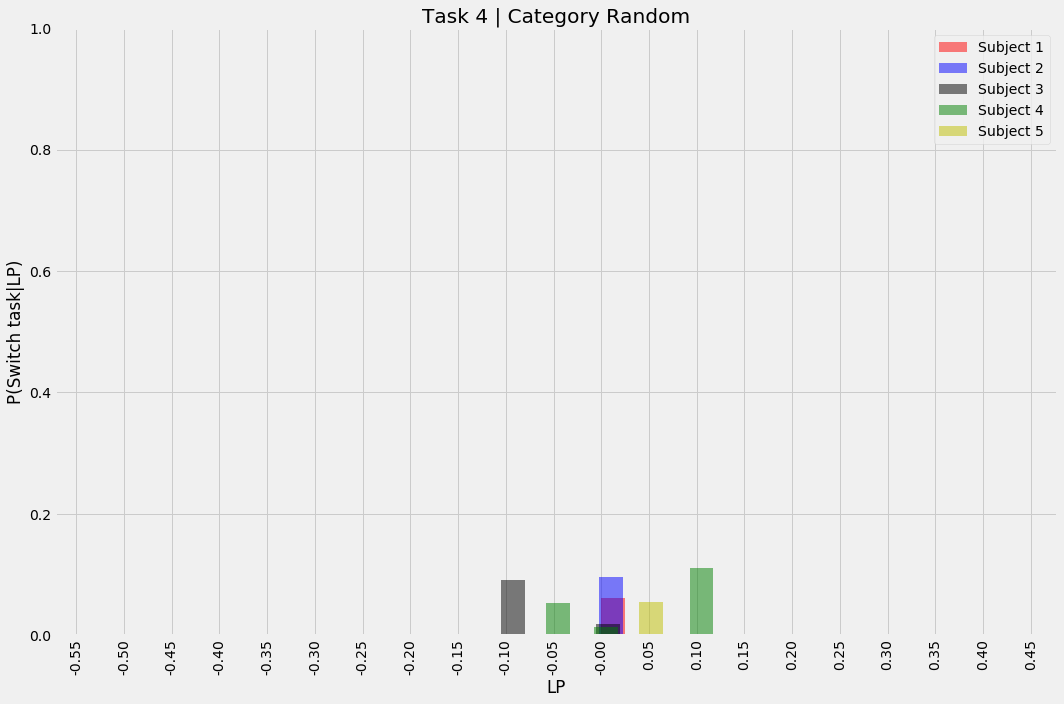

Window  25  Lookback LP  10


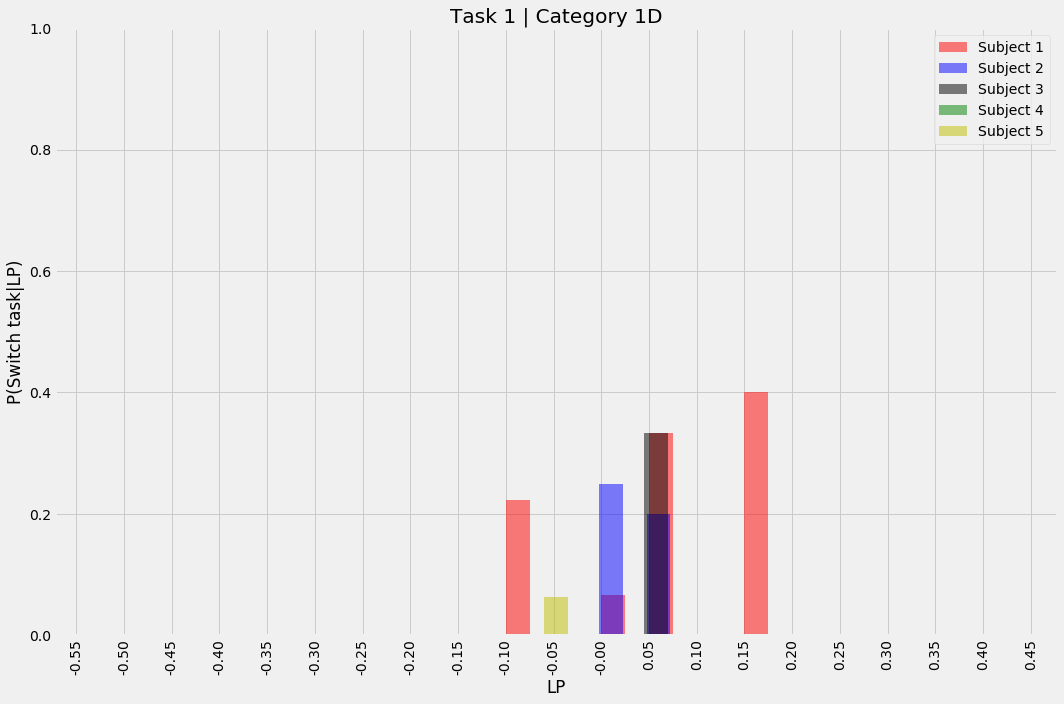

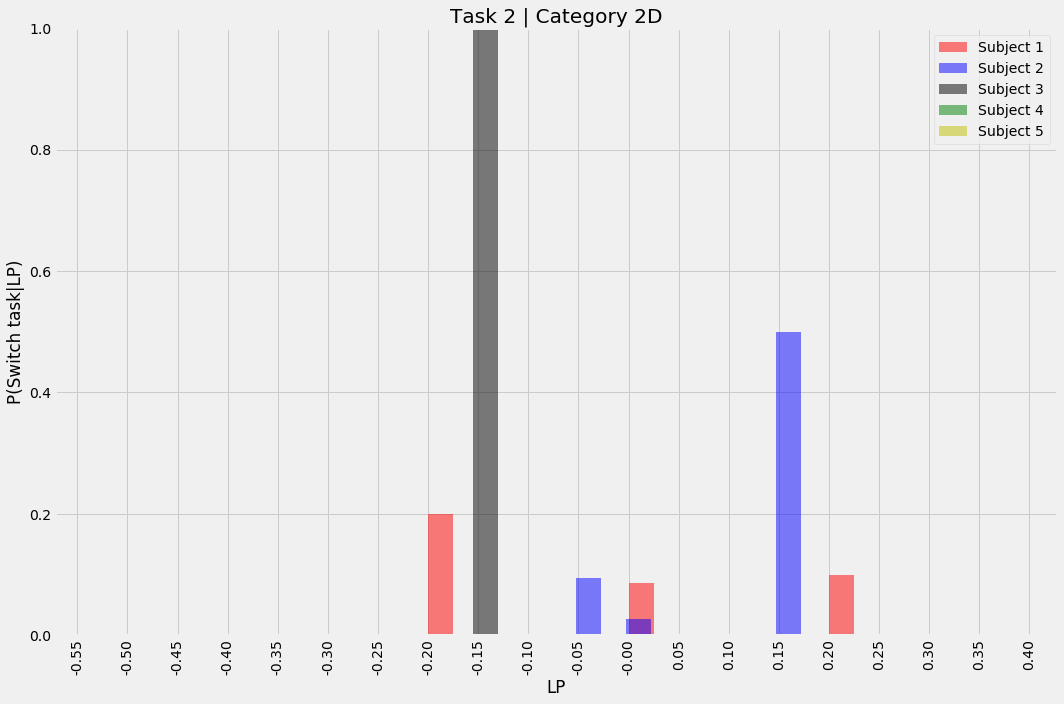

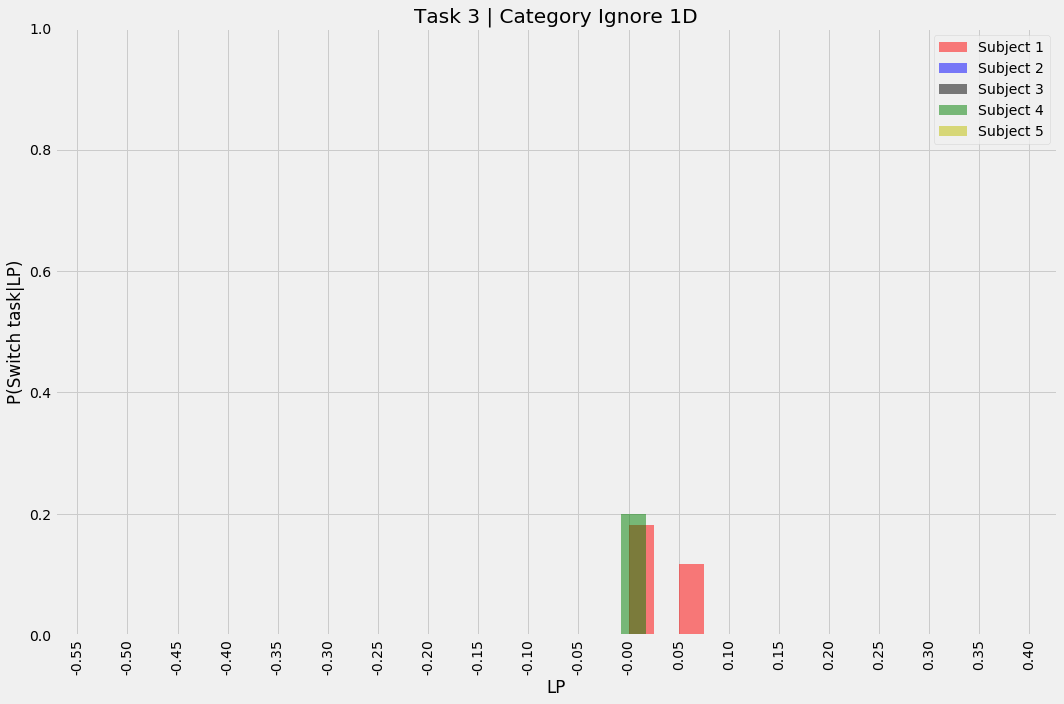

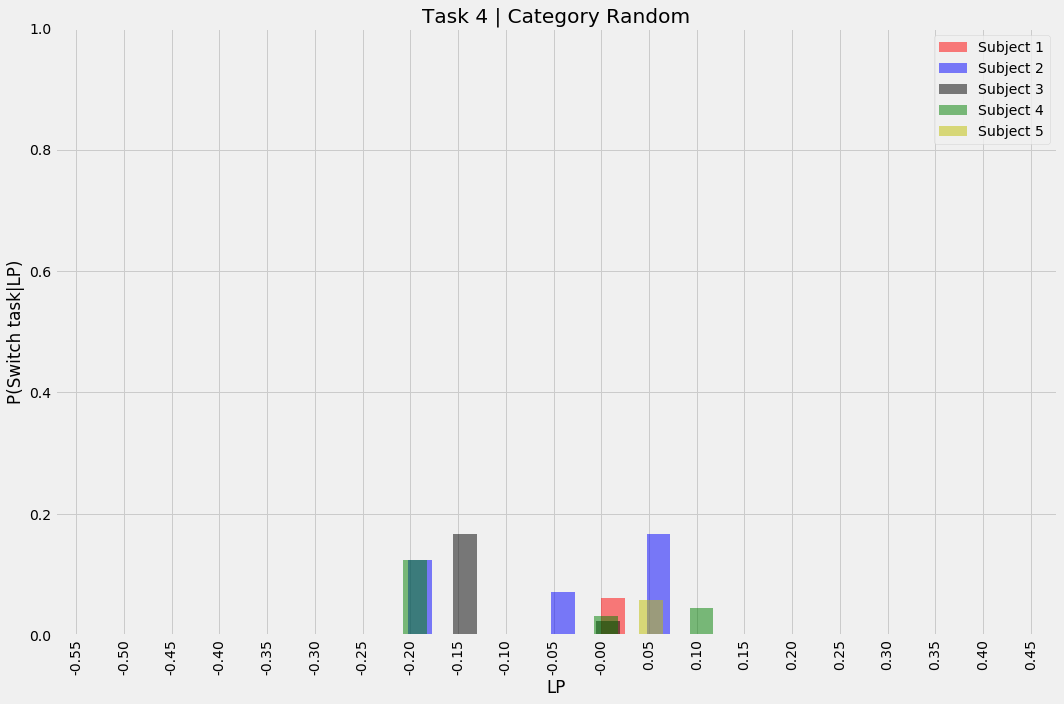

Window  25  Lookback LP  15


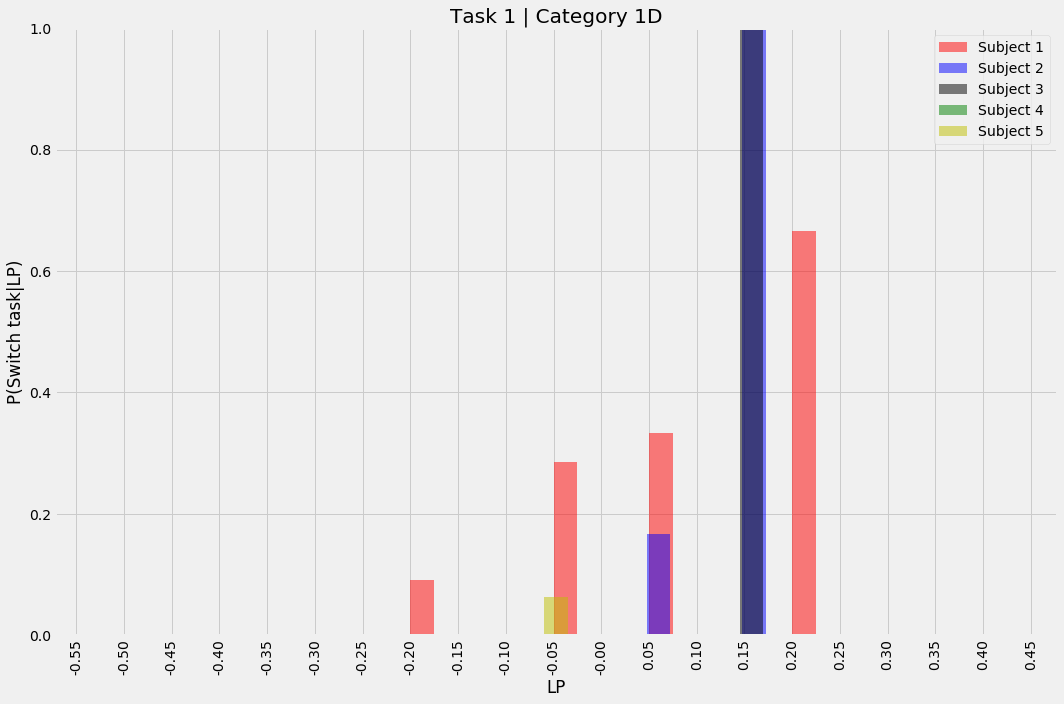

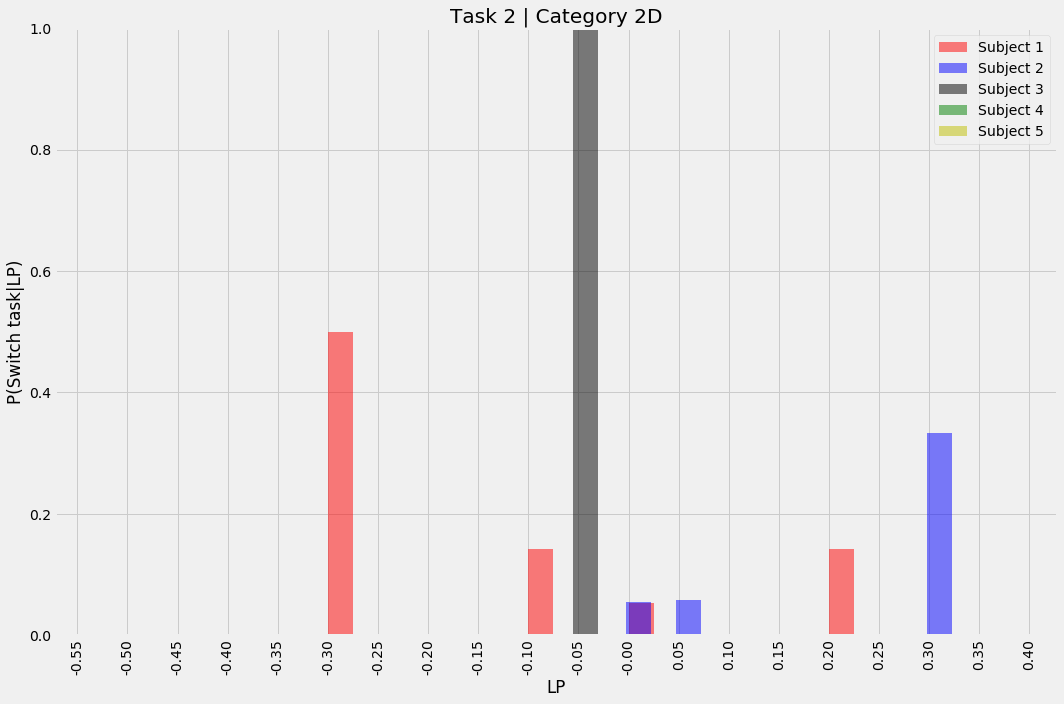

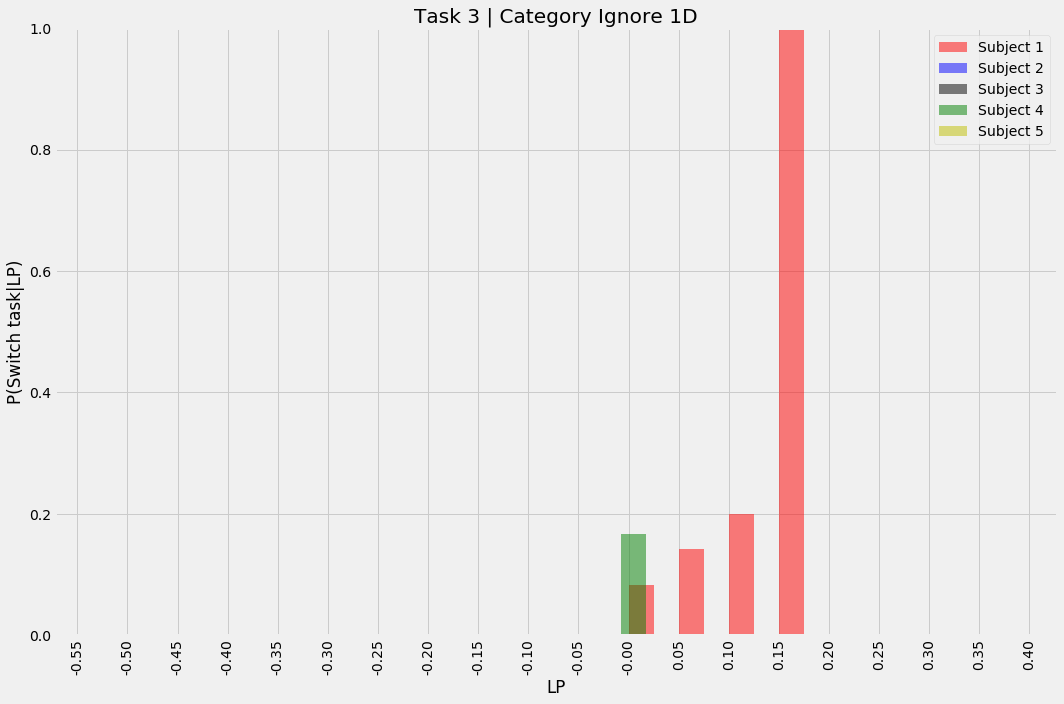

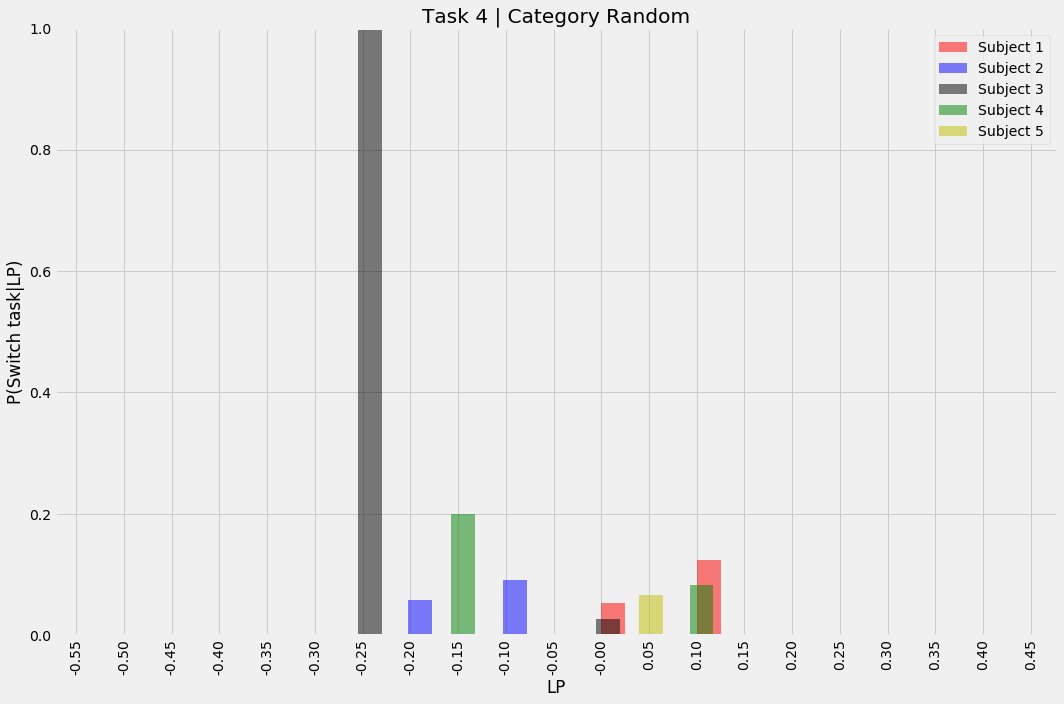

Window  25  Lookback LP  20


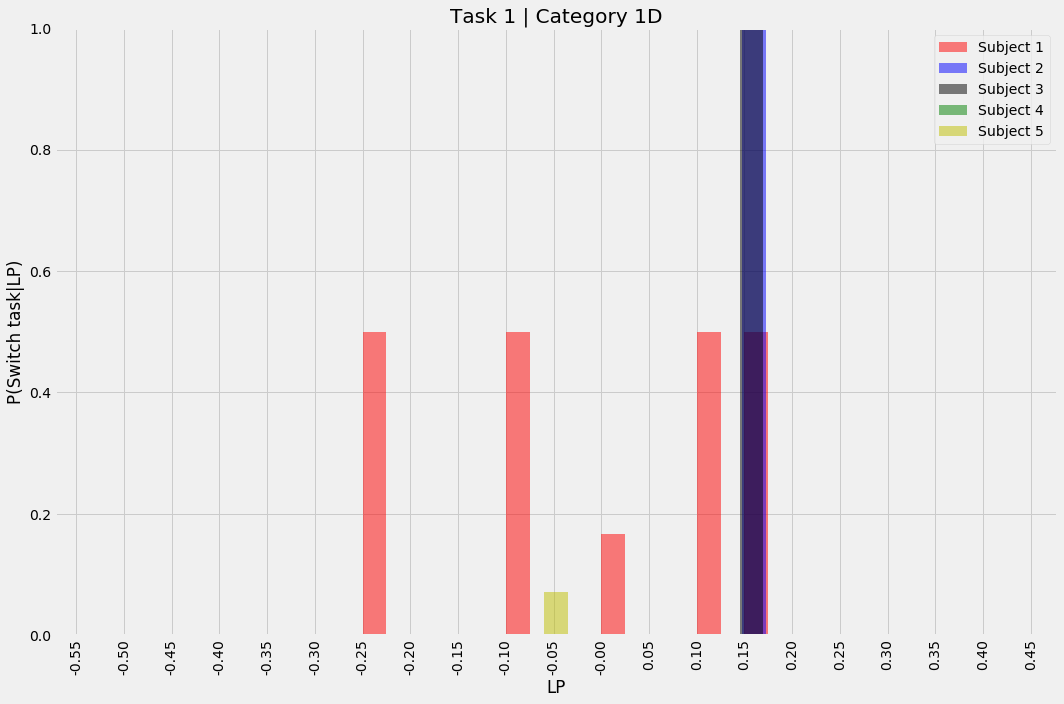

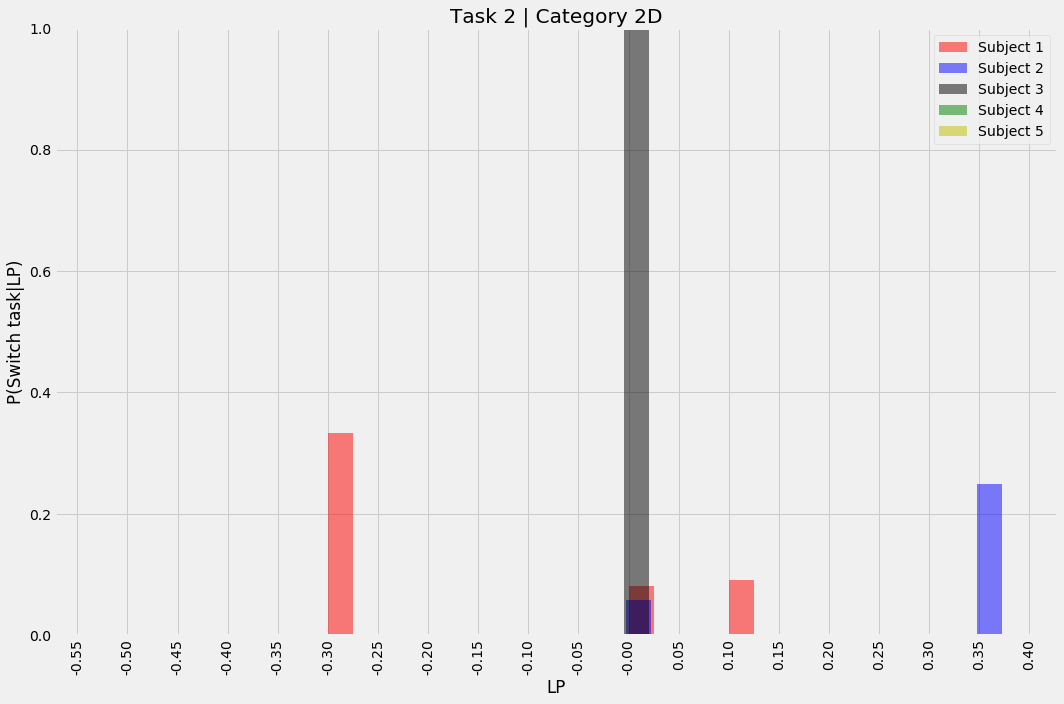

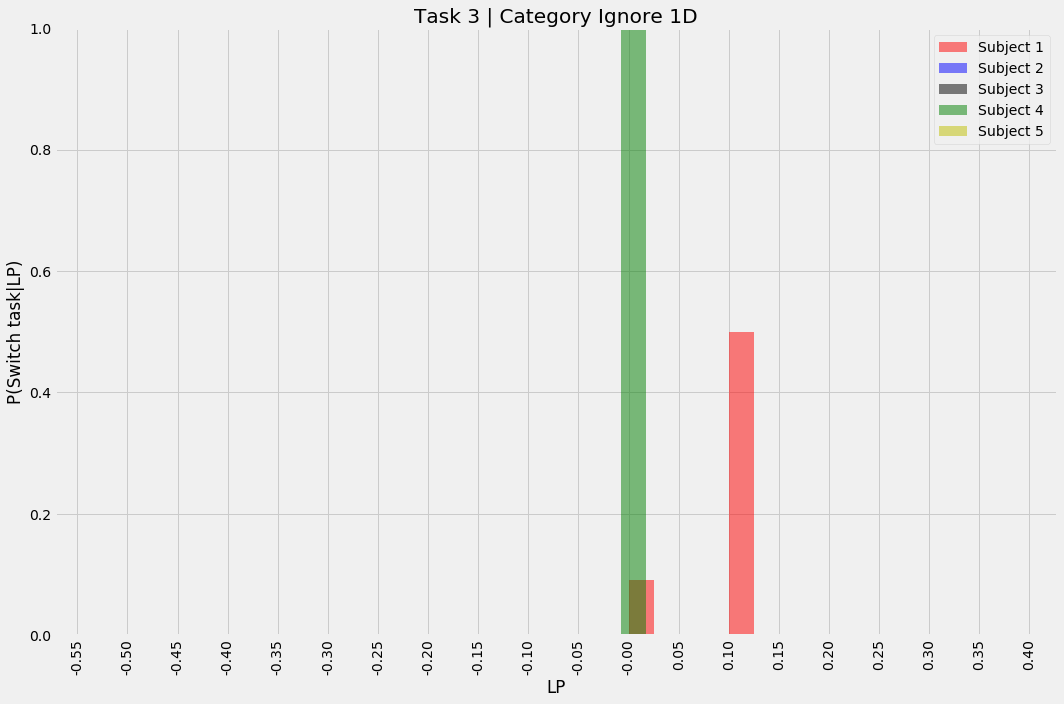

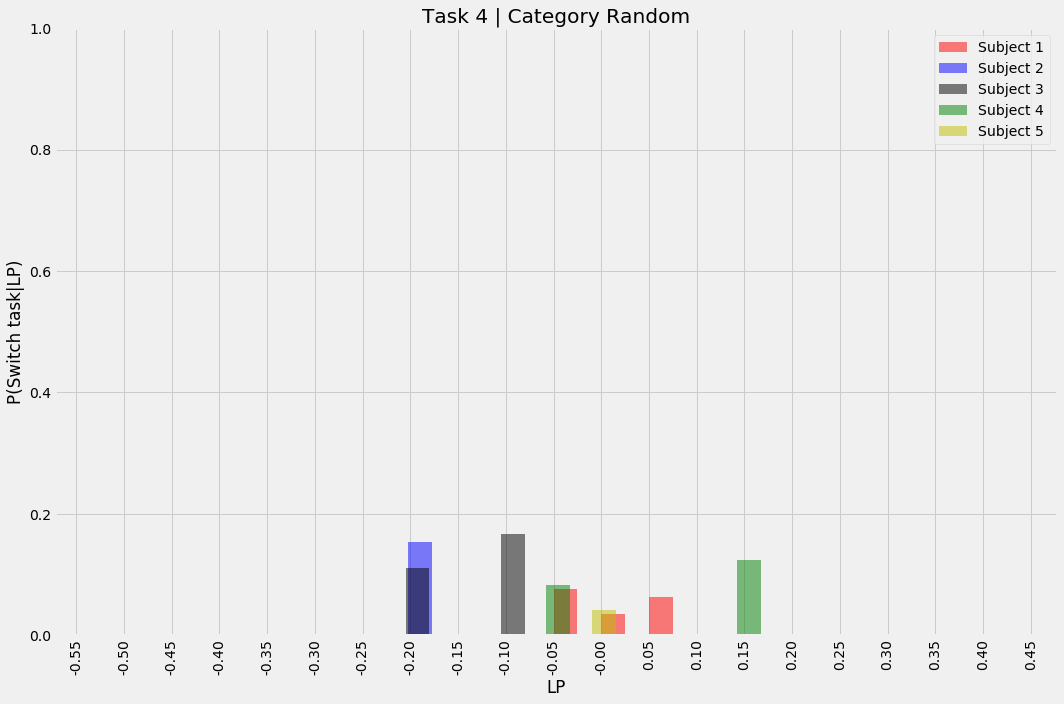

Window  25  Lookback LP  25


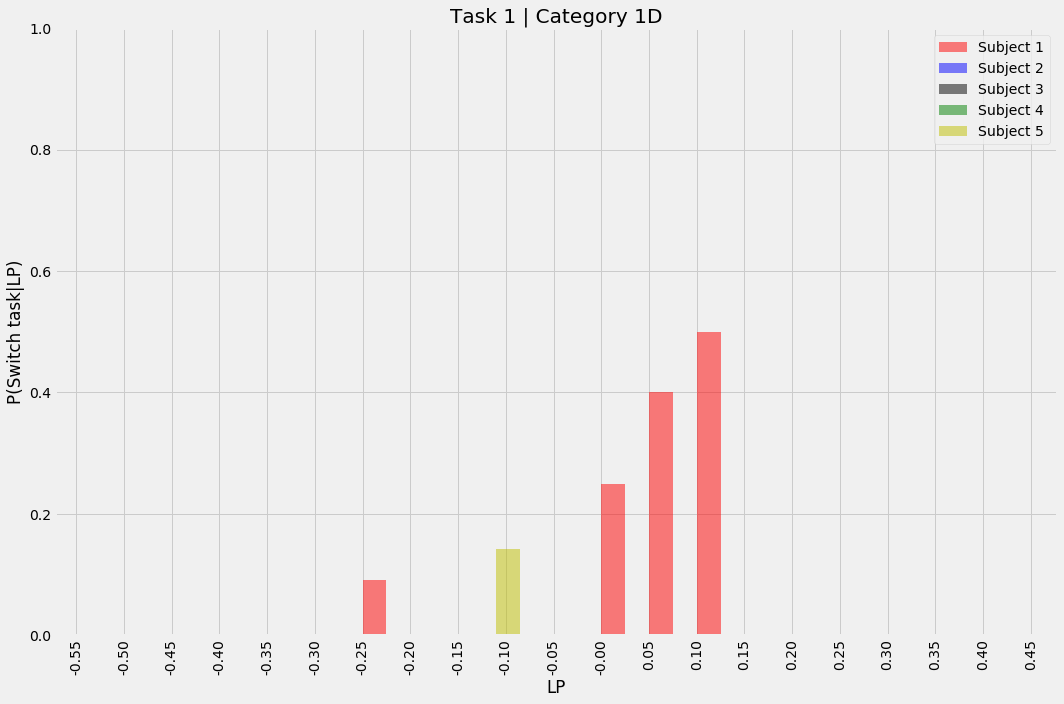

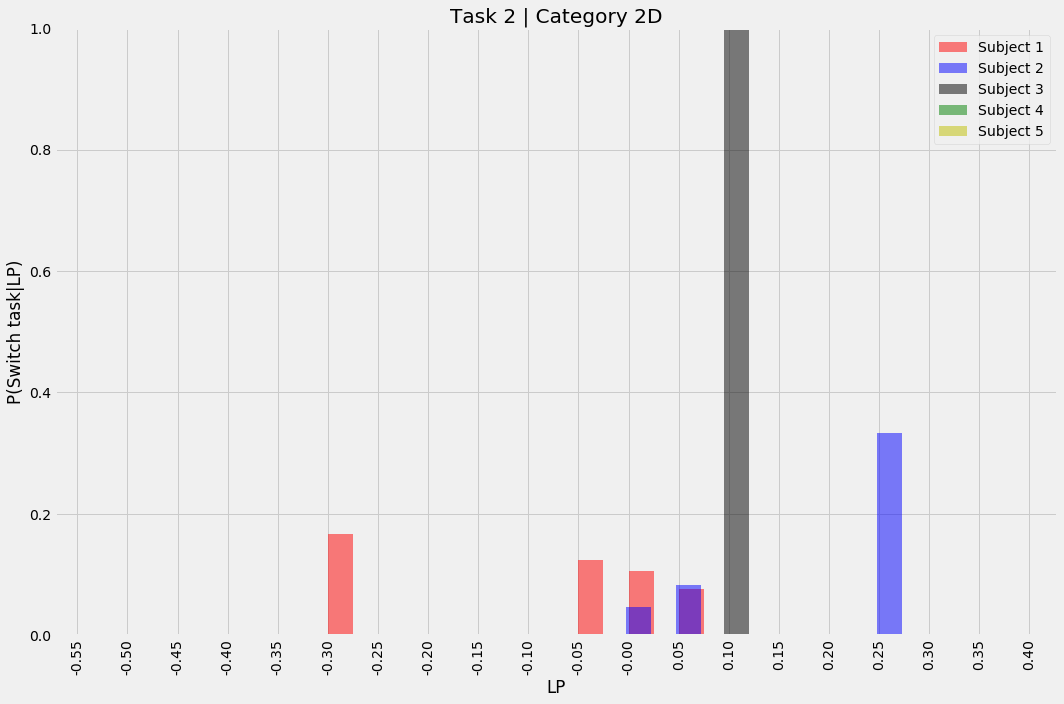

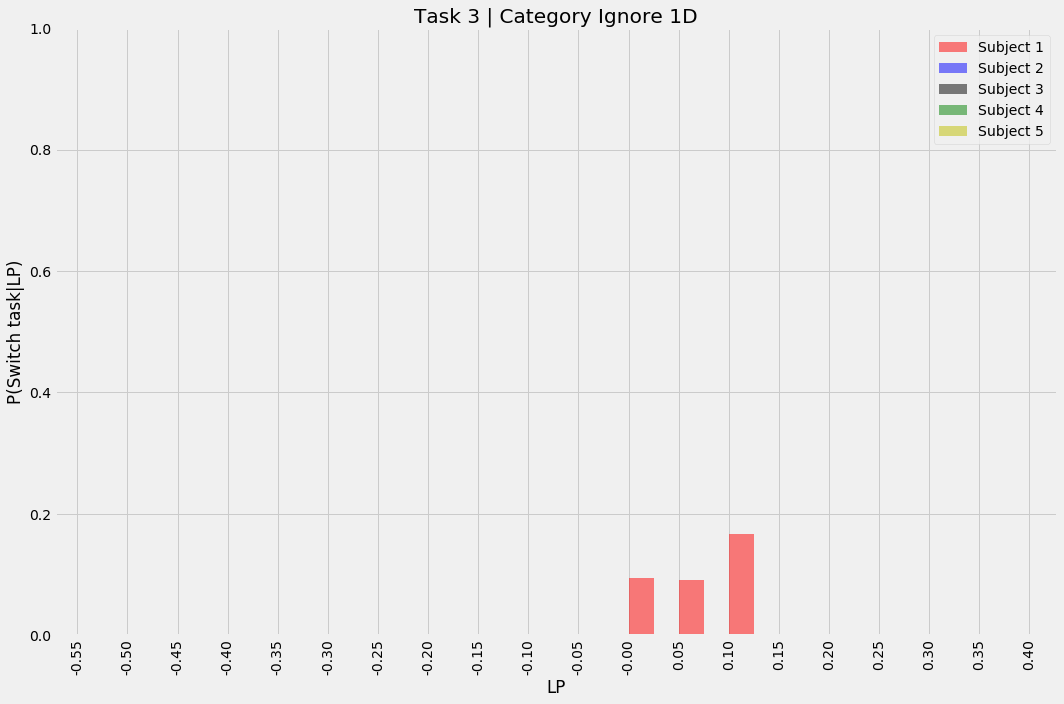

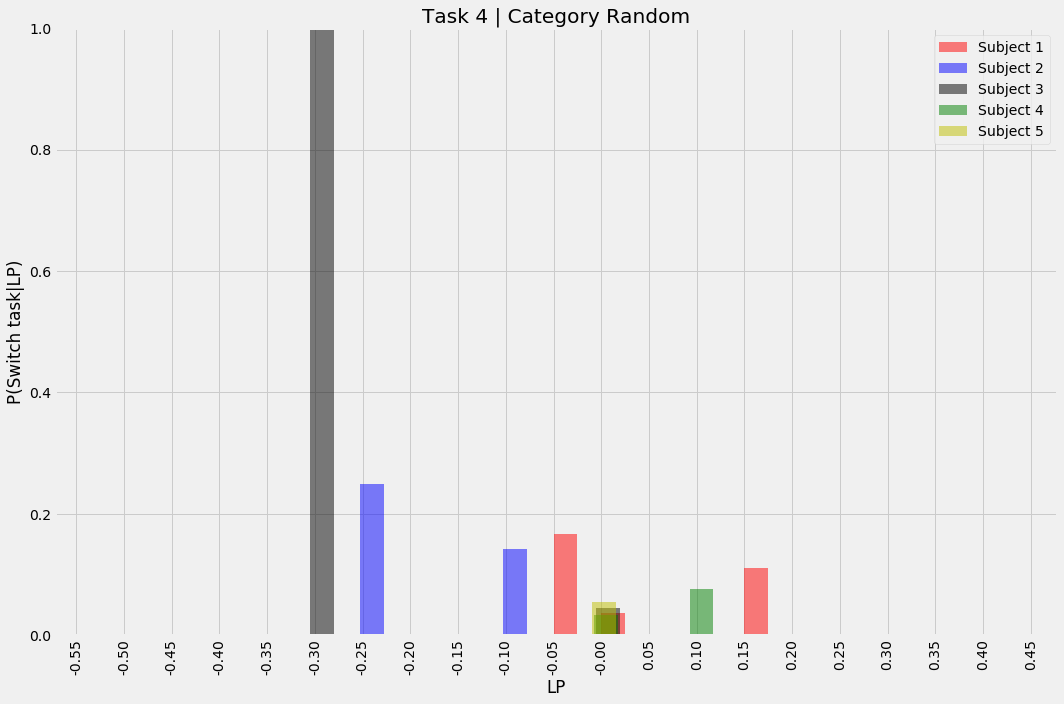

Window  25  Lookback LP  30


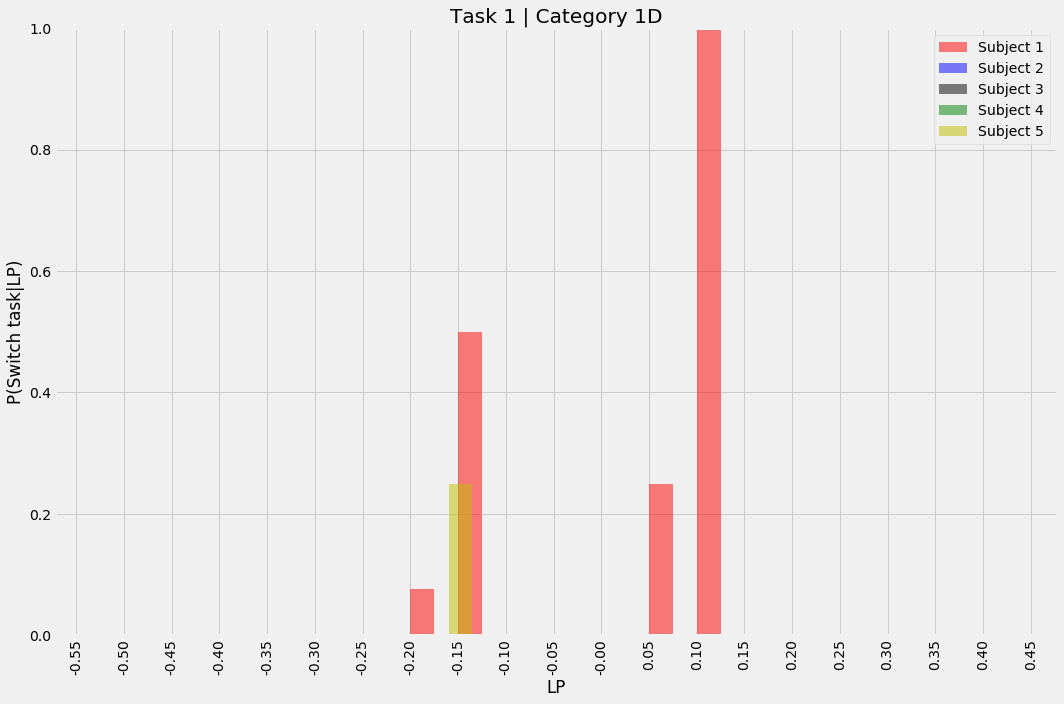

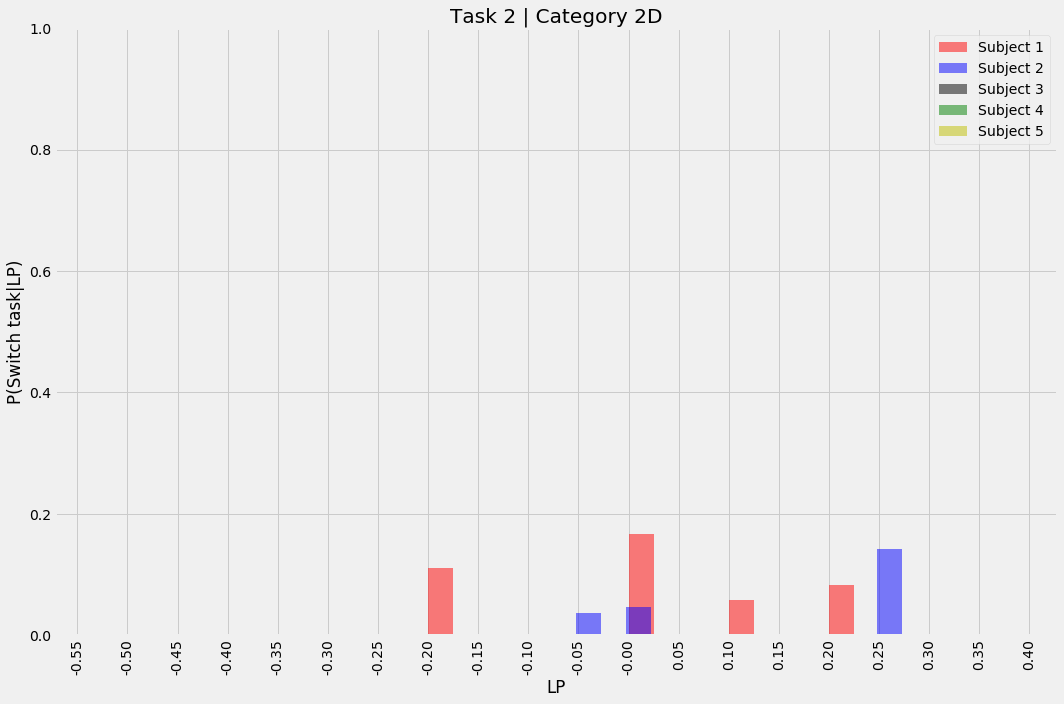

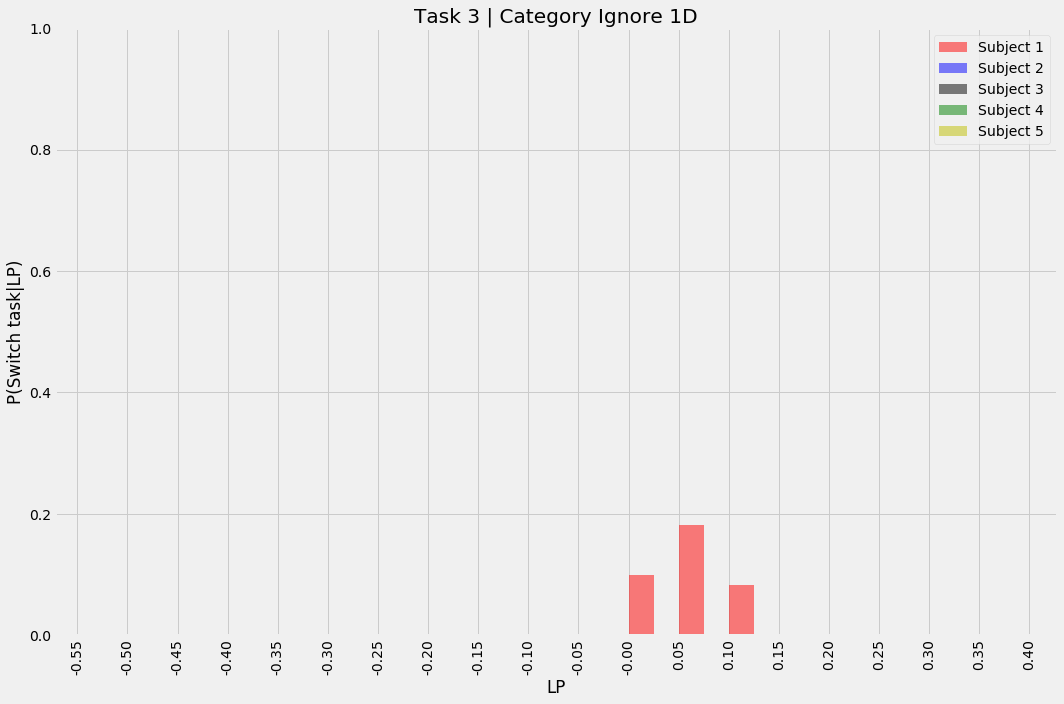

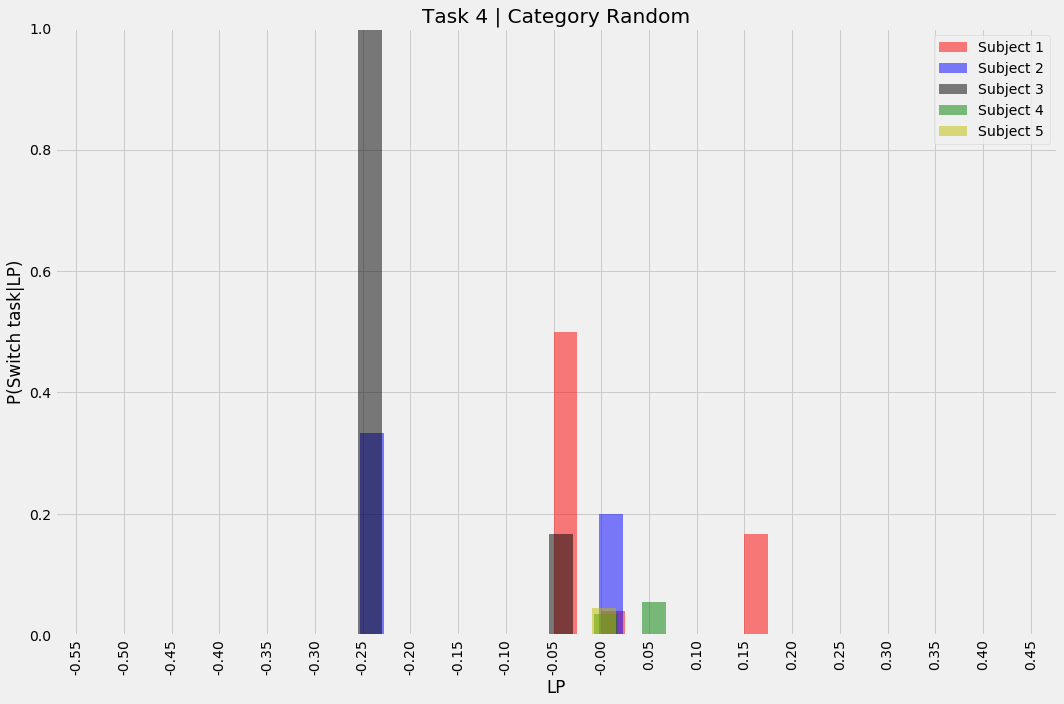

Window  30  Lookback LP  2


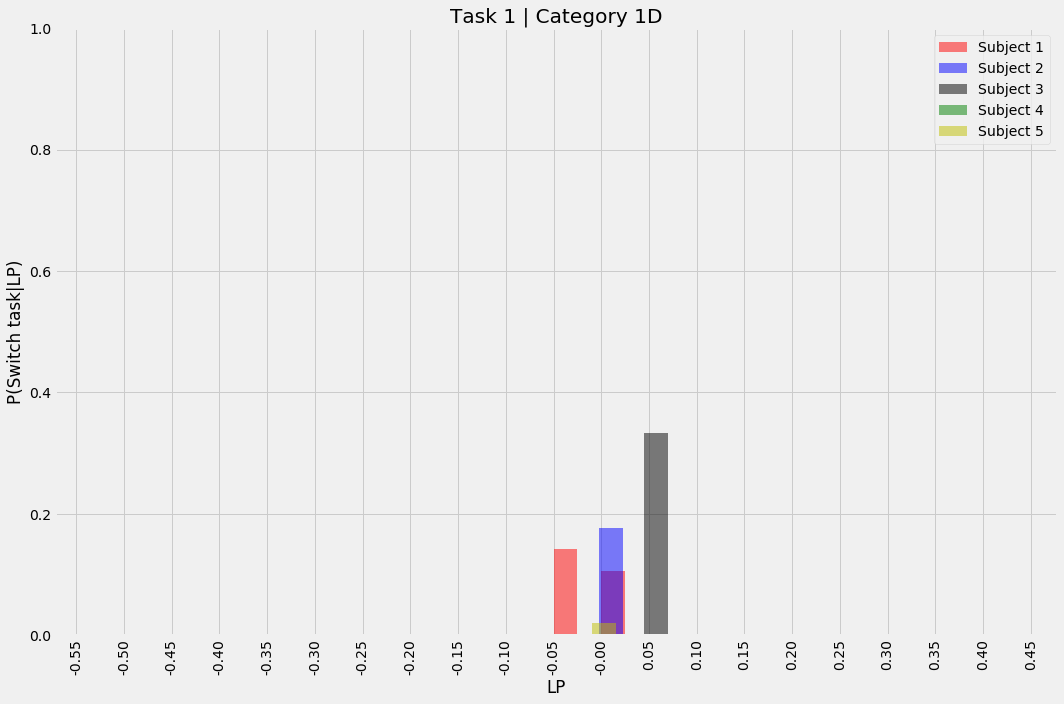

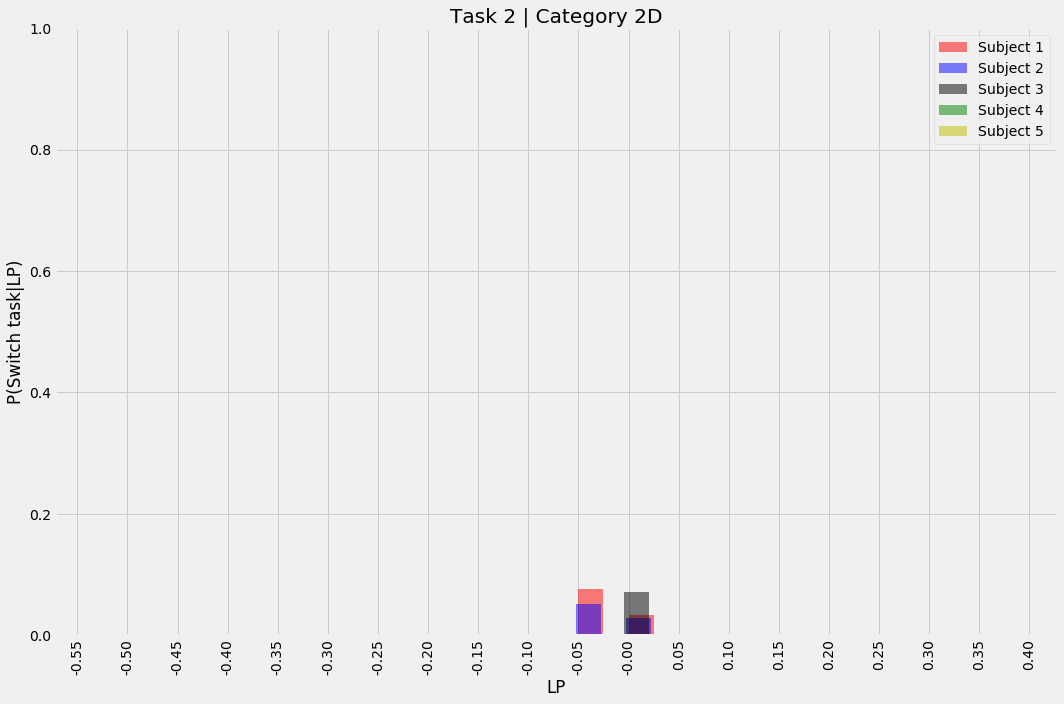

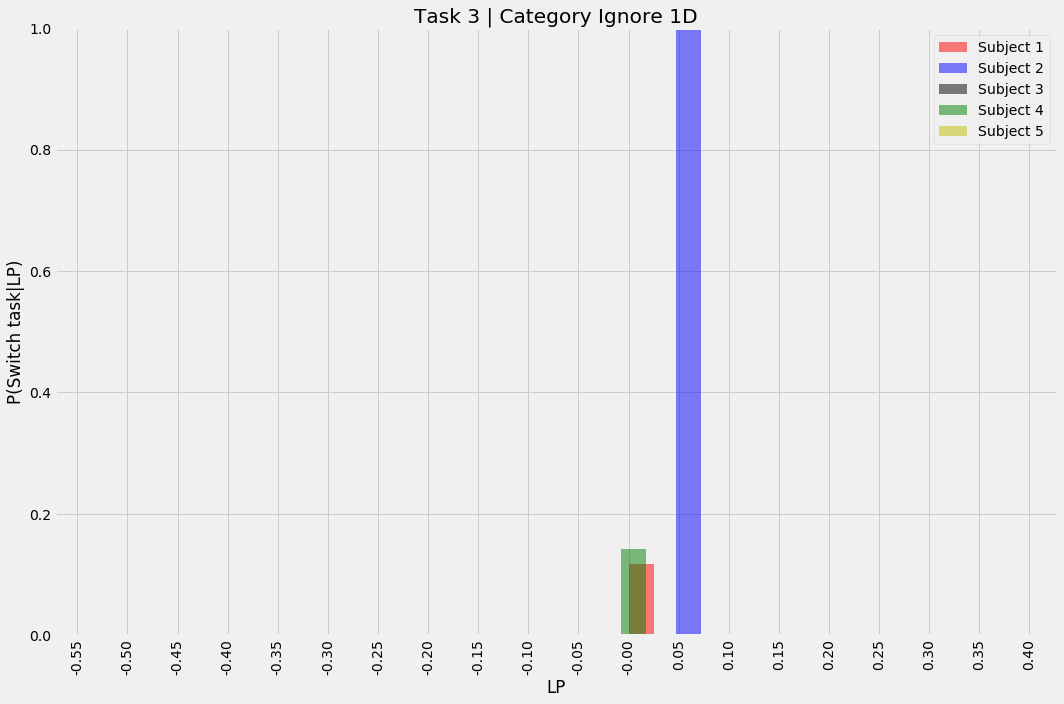

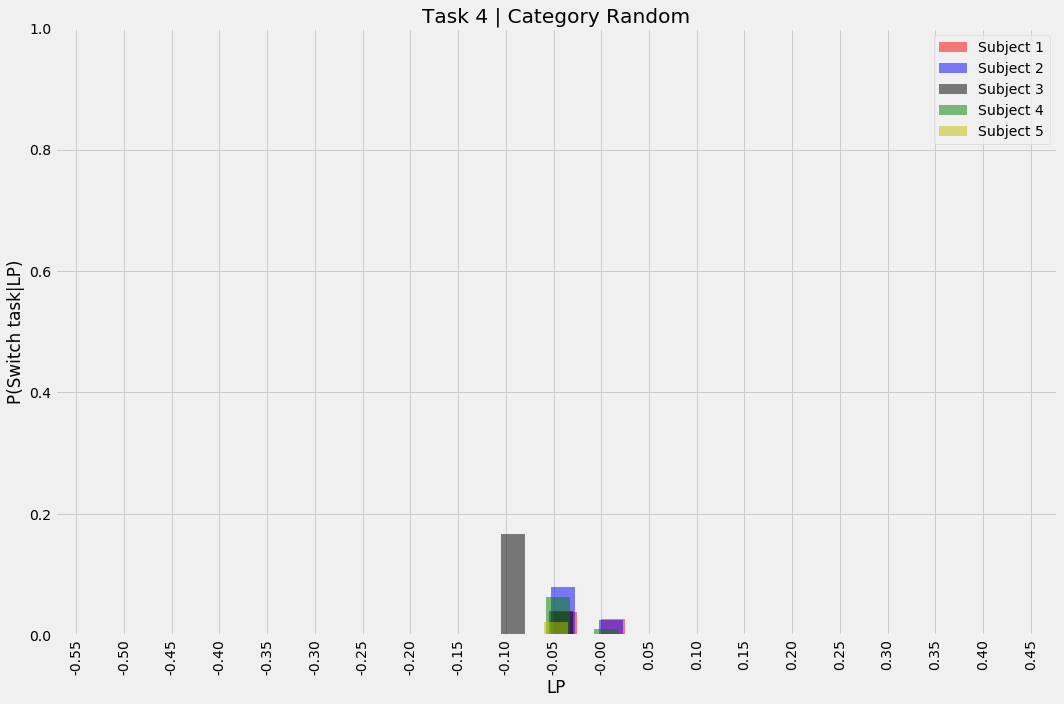

Window  30  Lookback LP  5


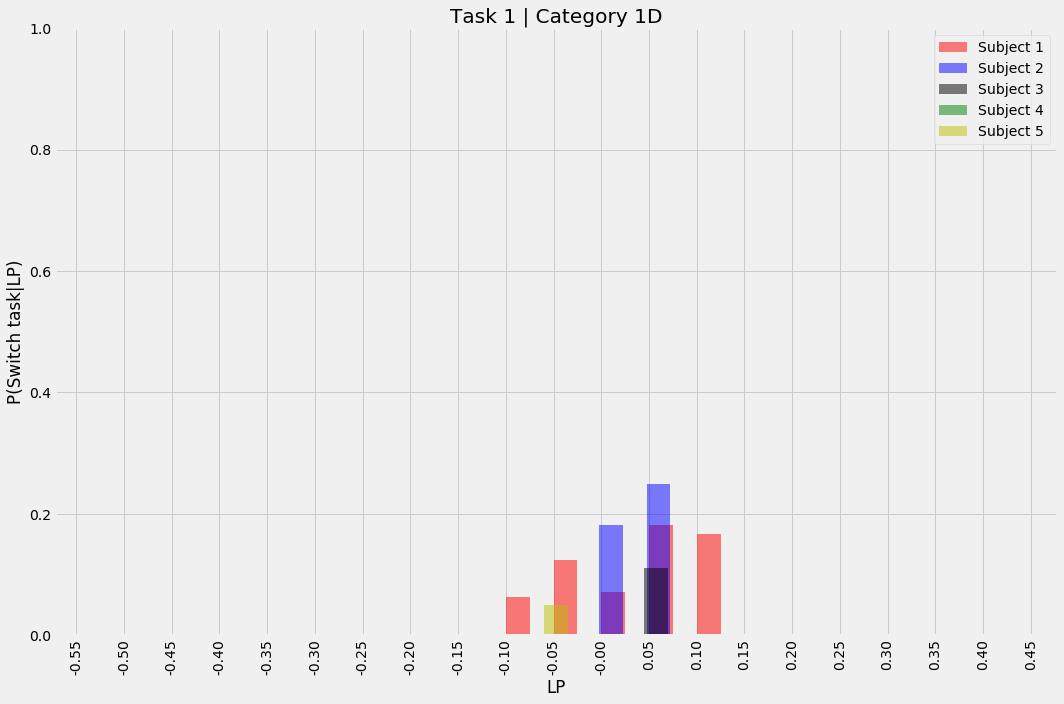

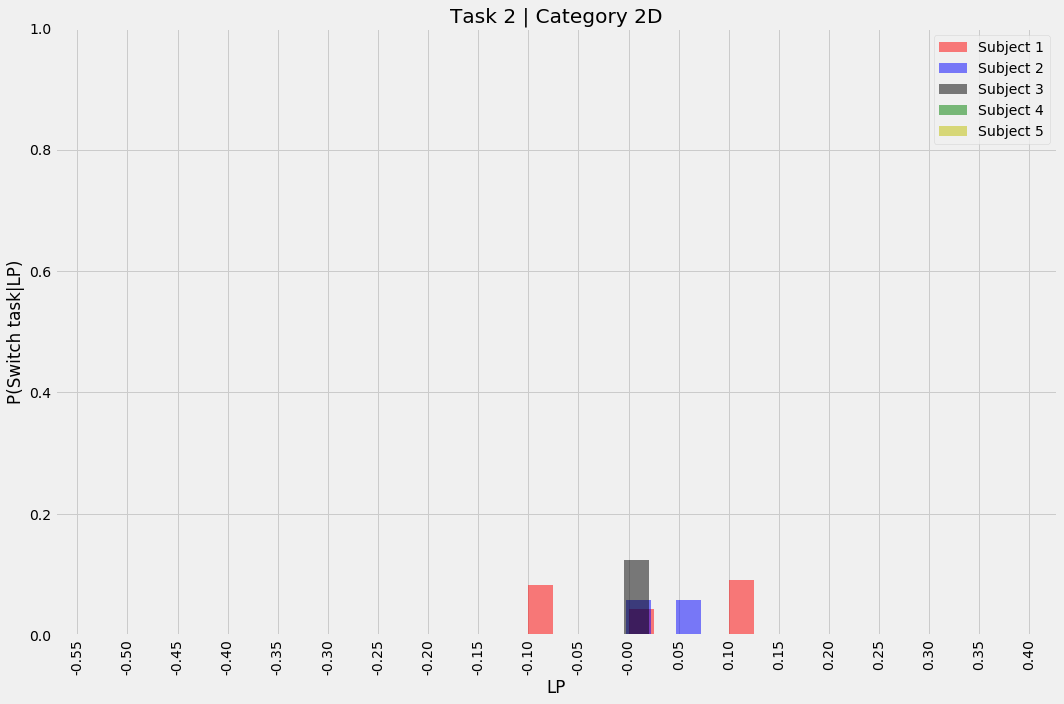

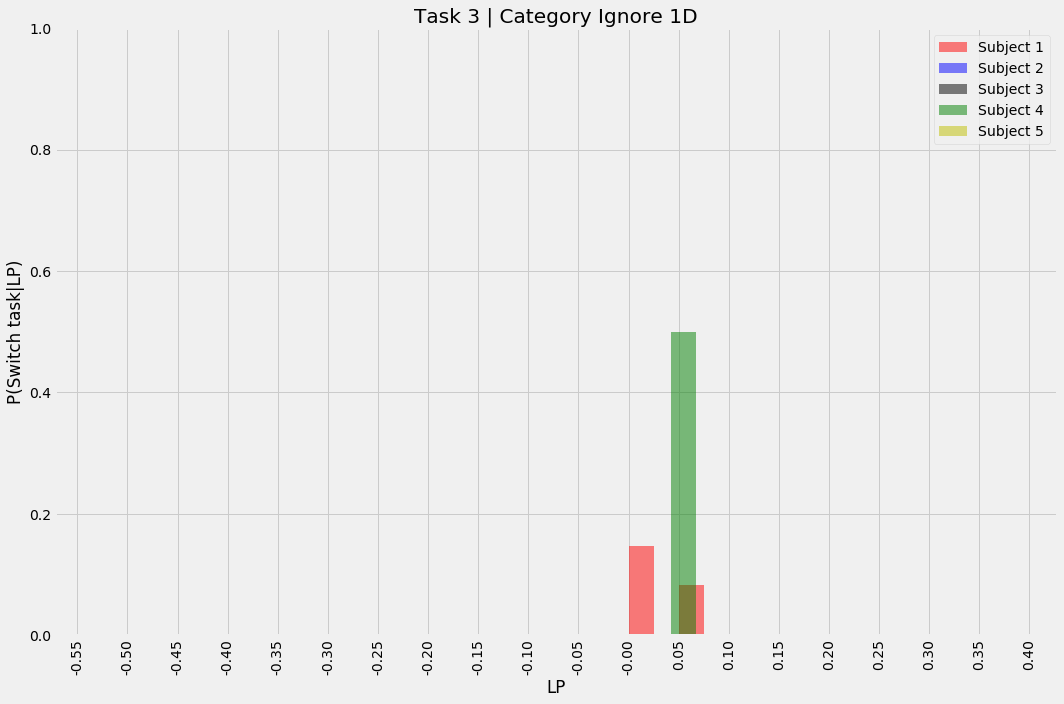

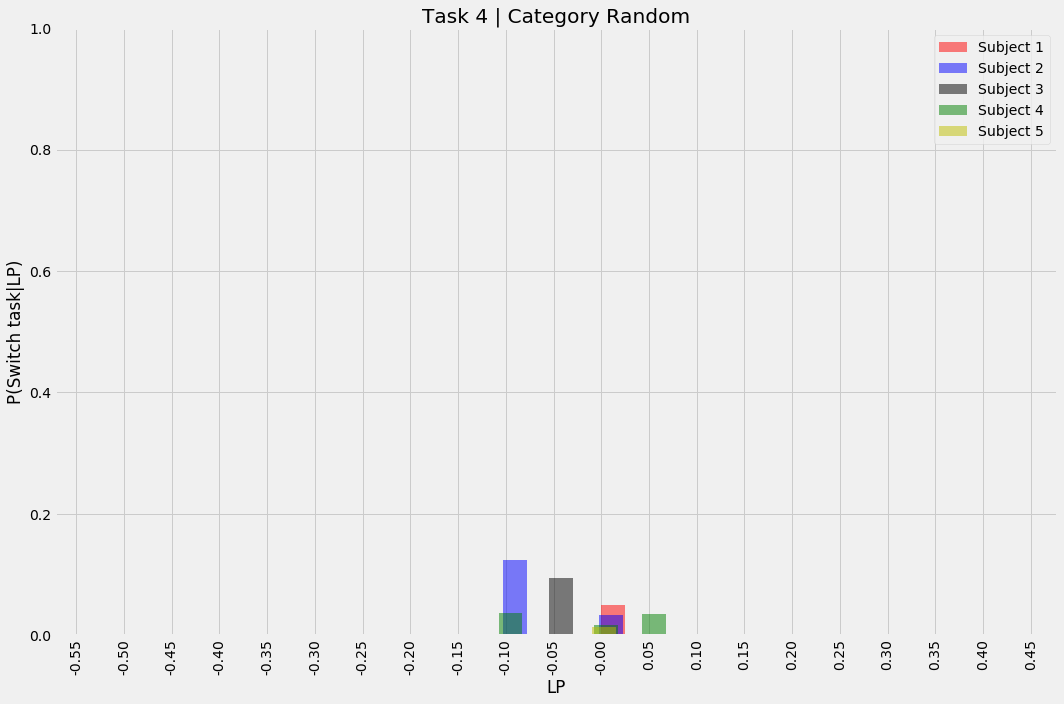

Window  30  Lookback LP  10


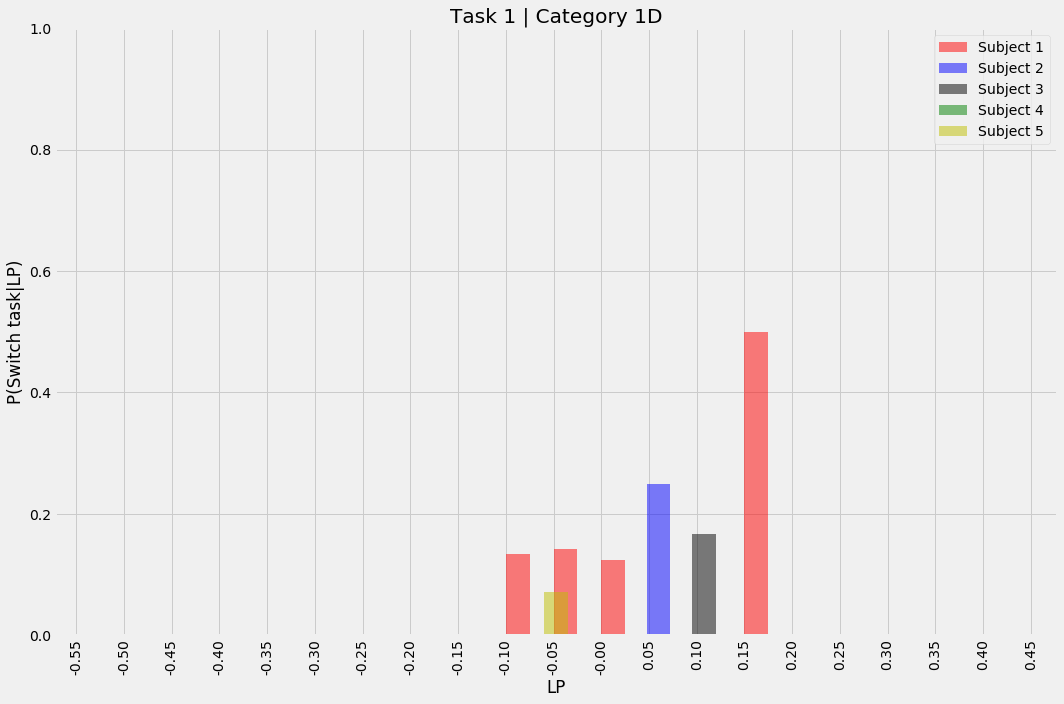

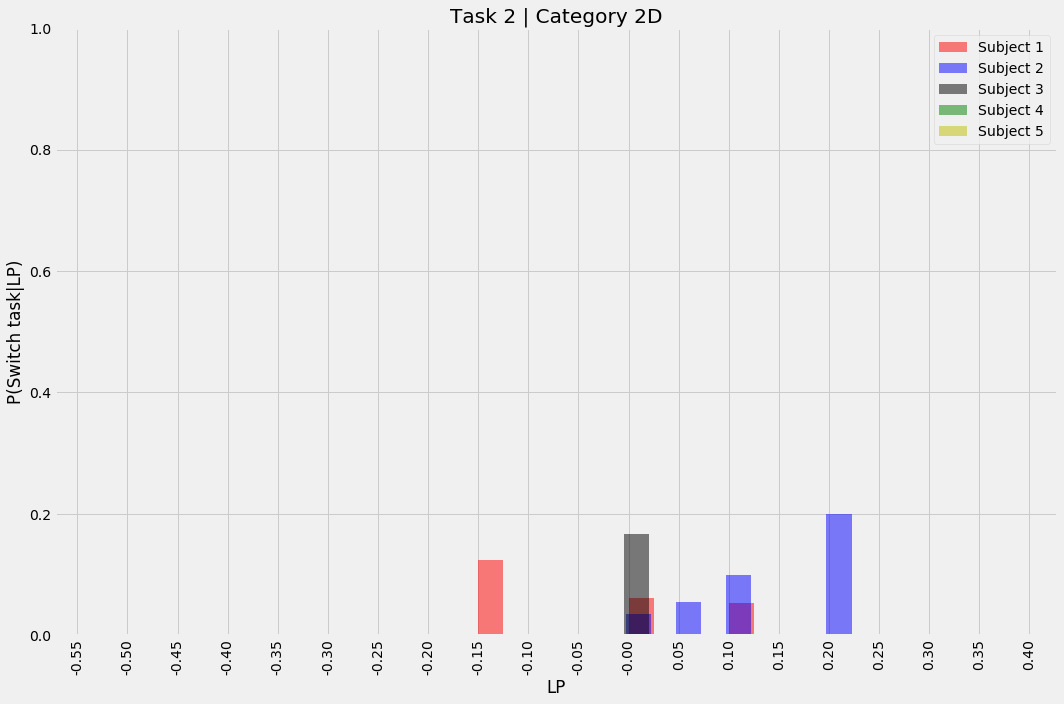

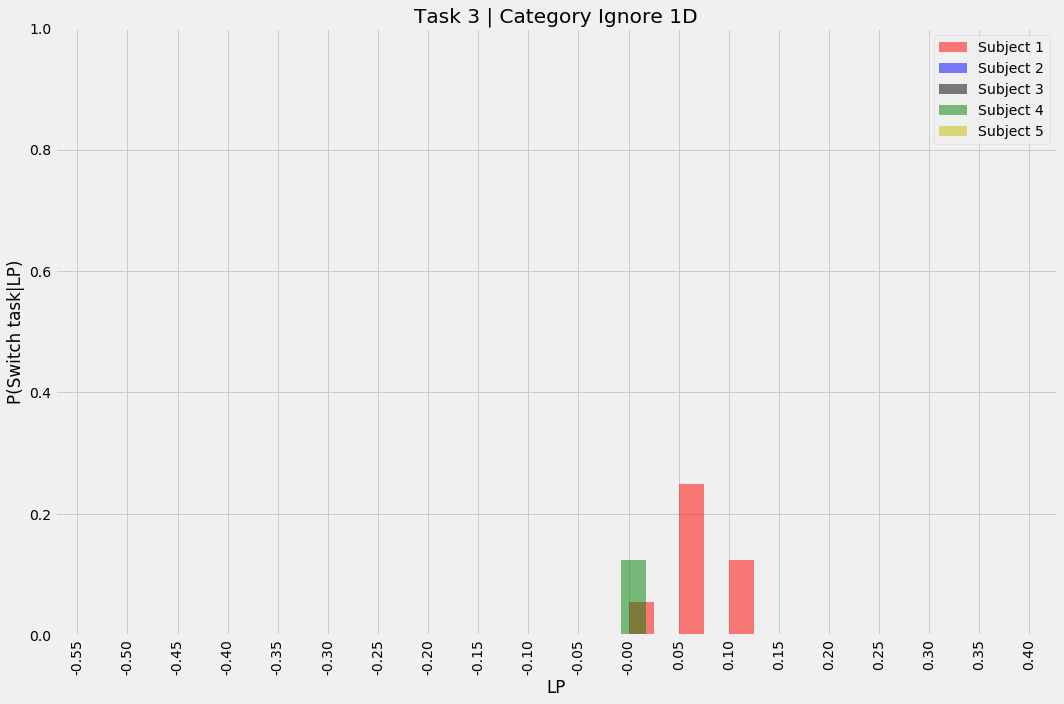

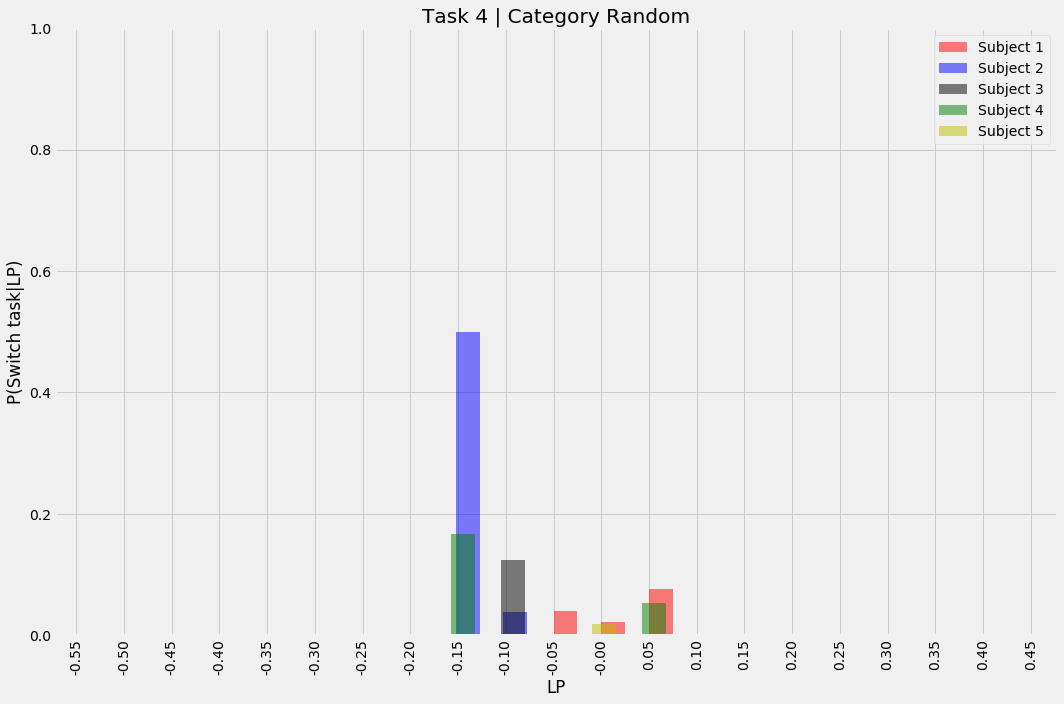

Window  30  Lookback LP  15


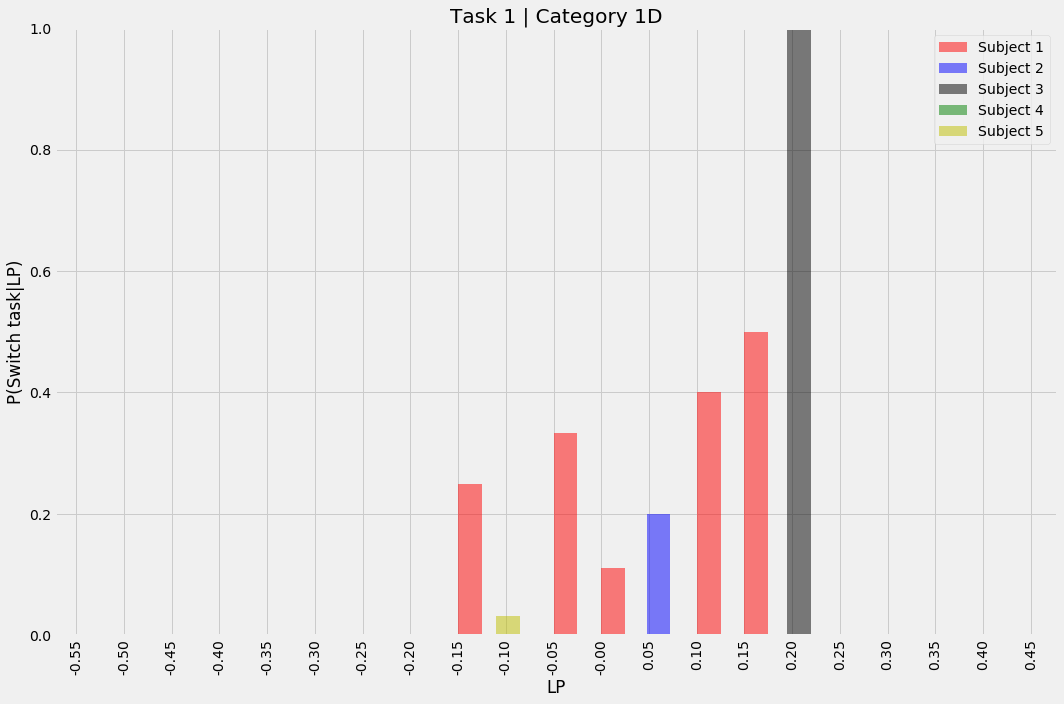

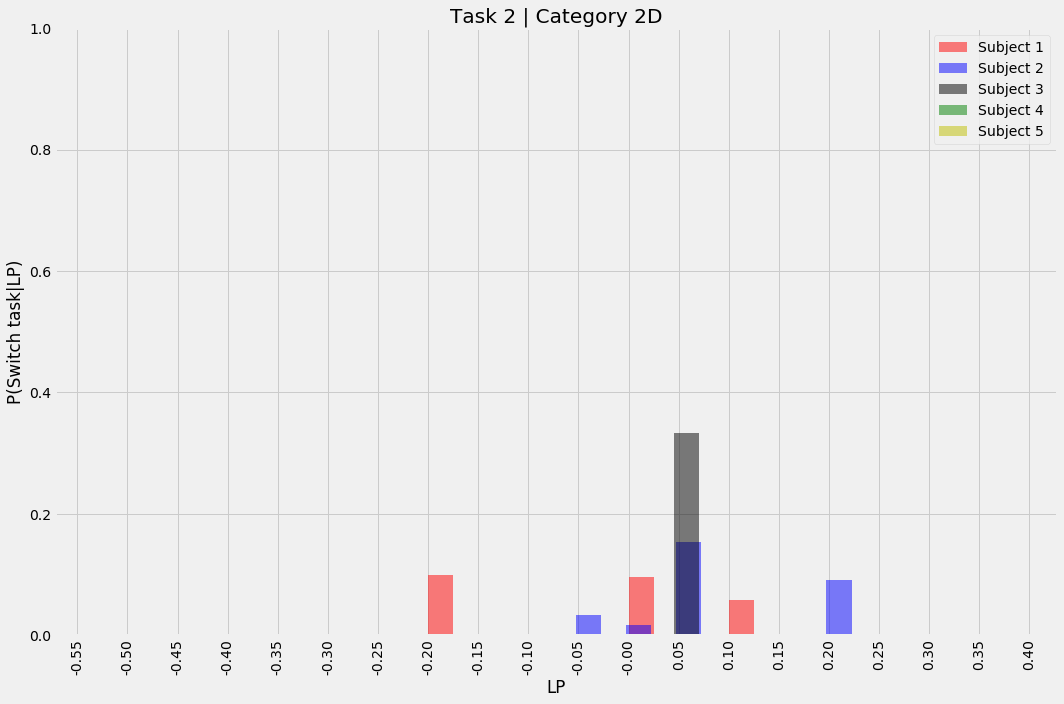

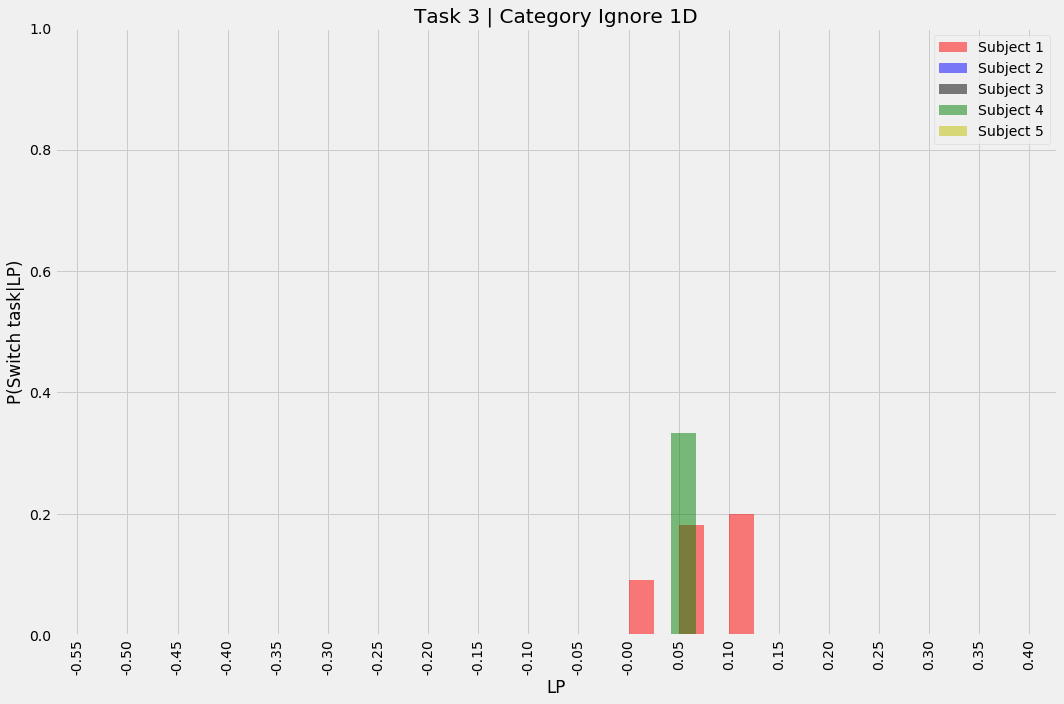

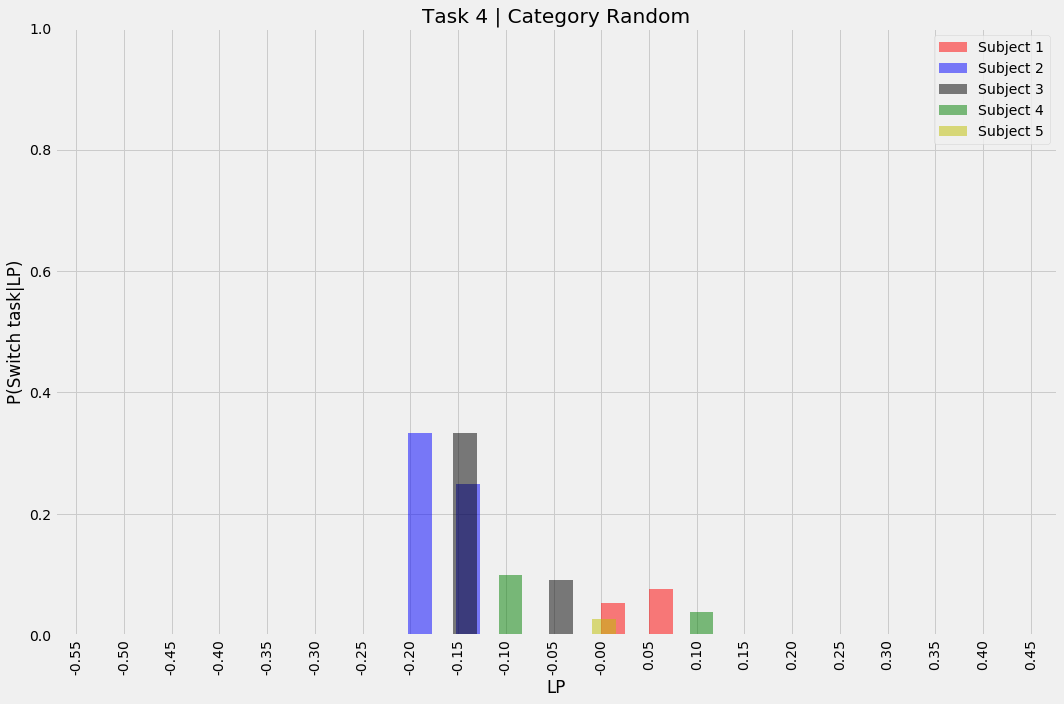

Window  30  Lookback LP  20


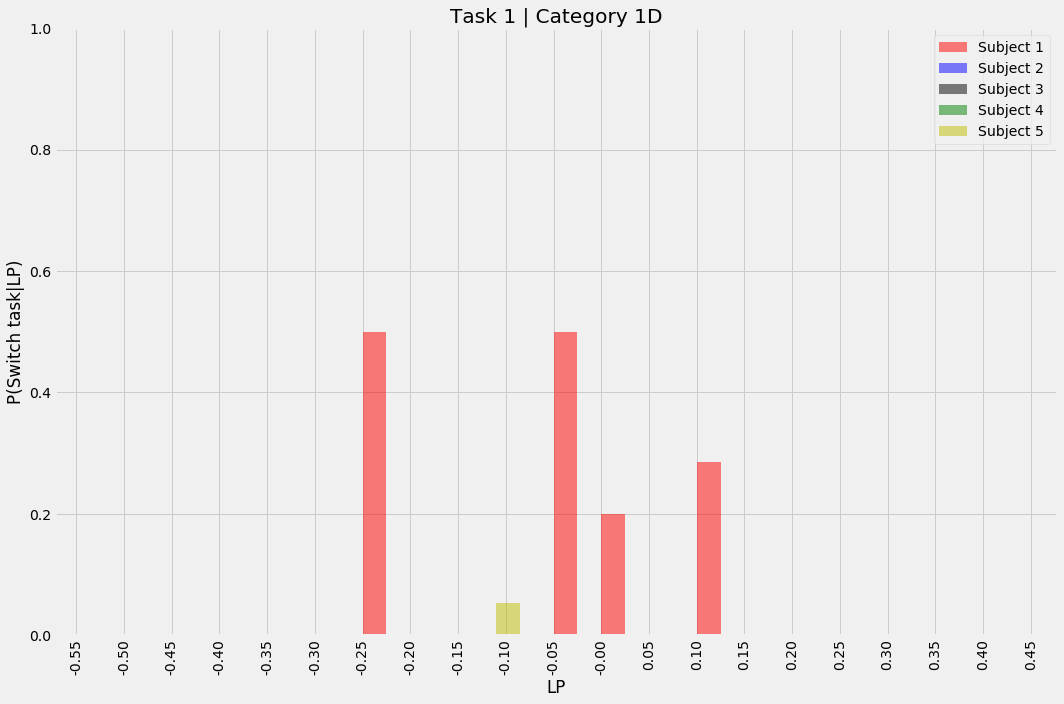

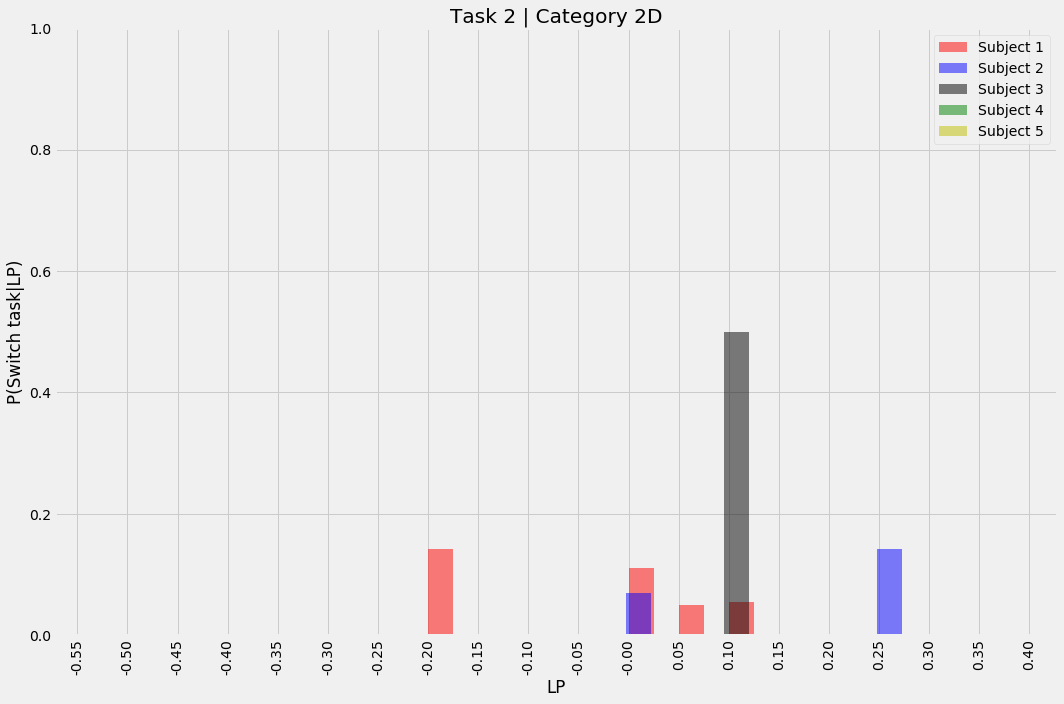

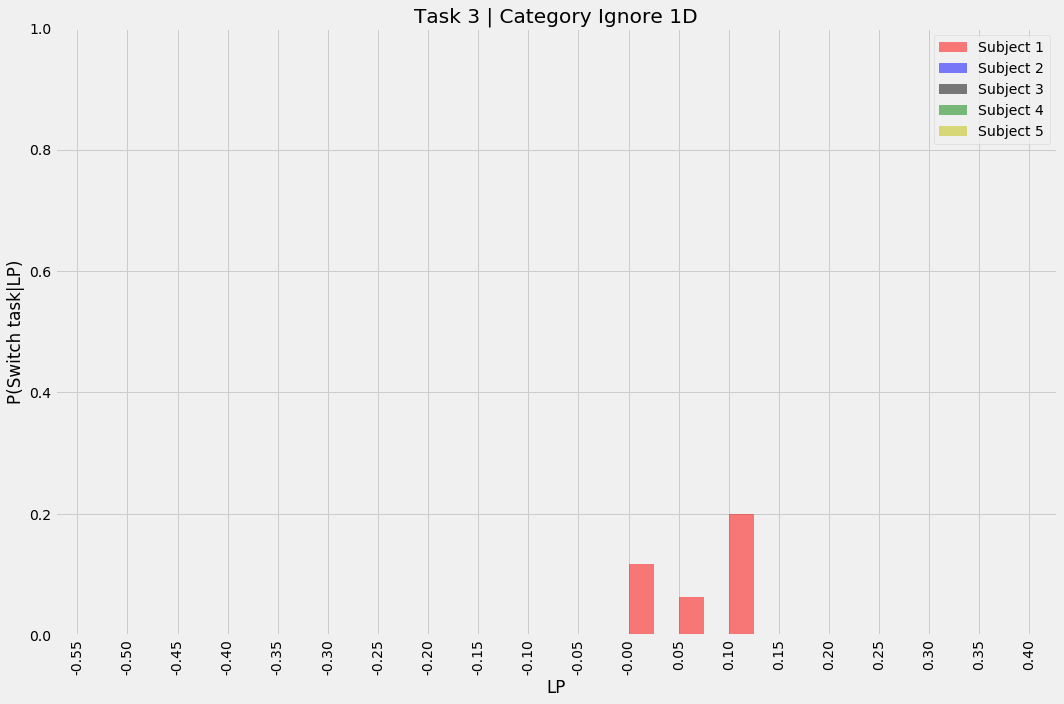

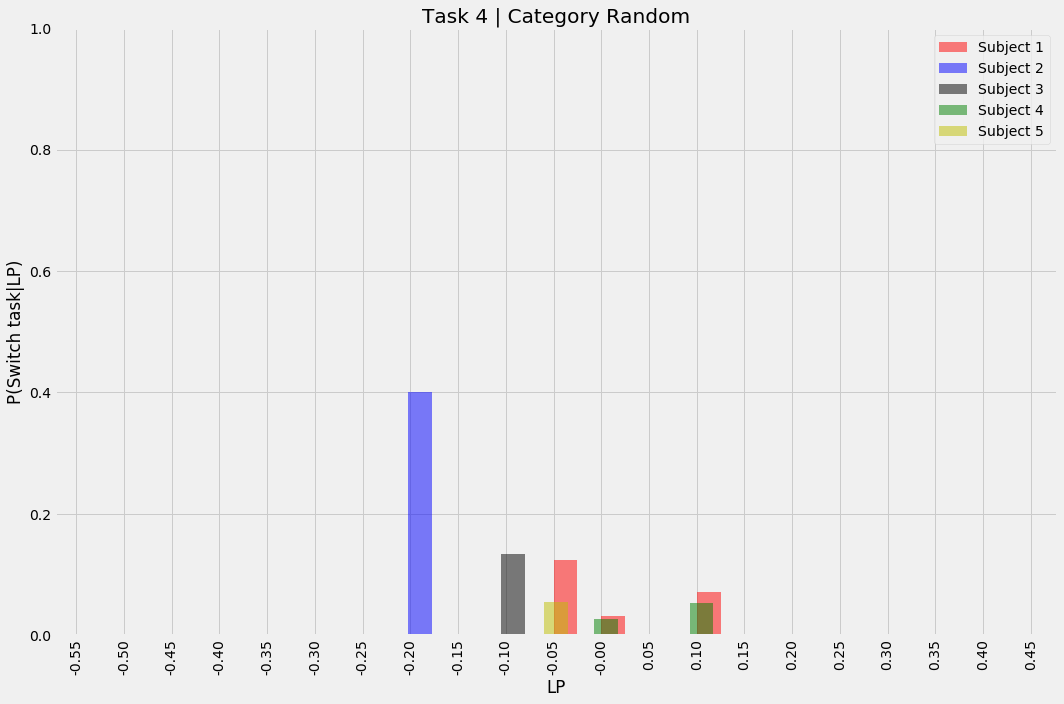

Window  30  Lookback LP  25


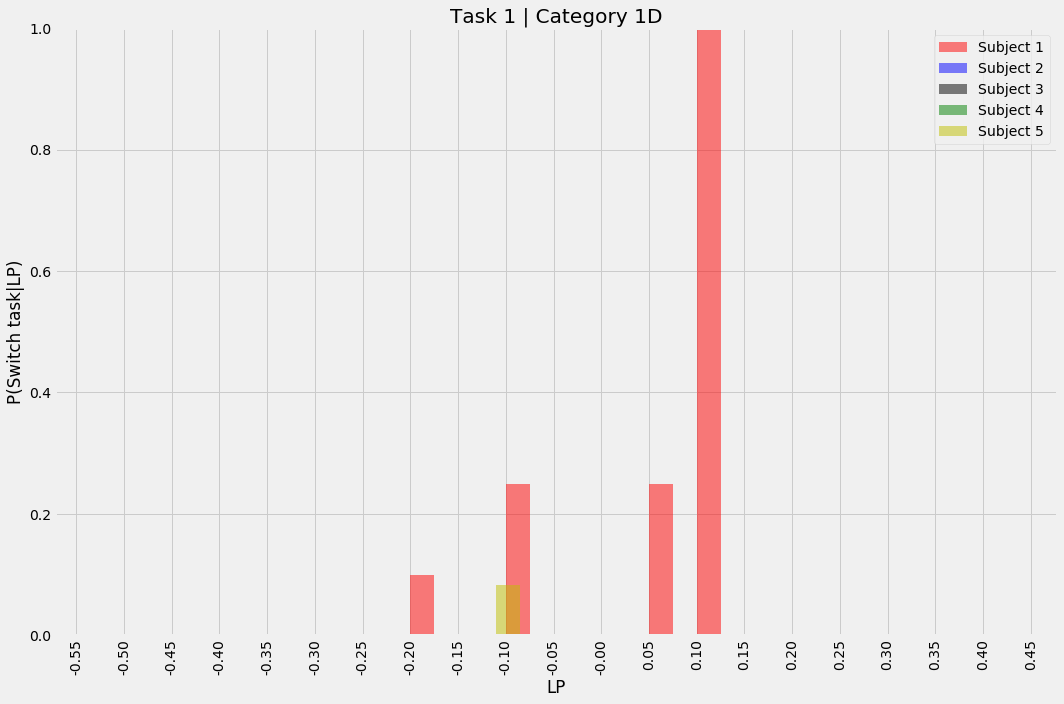

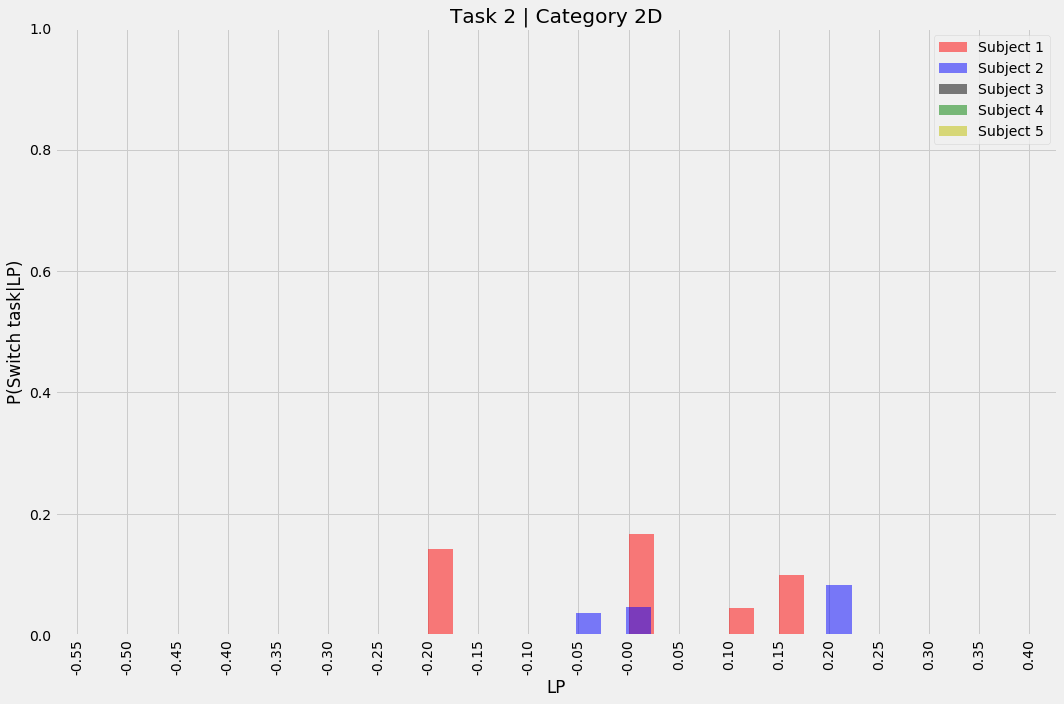

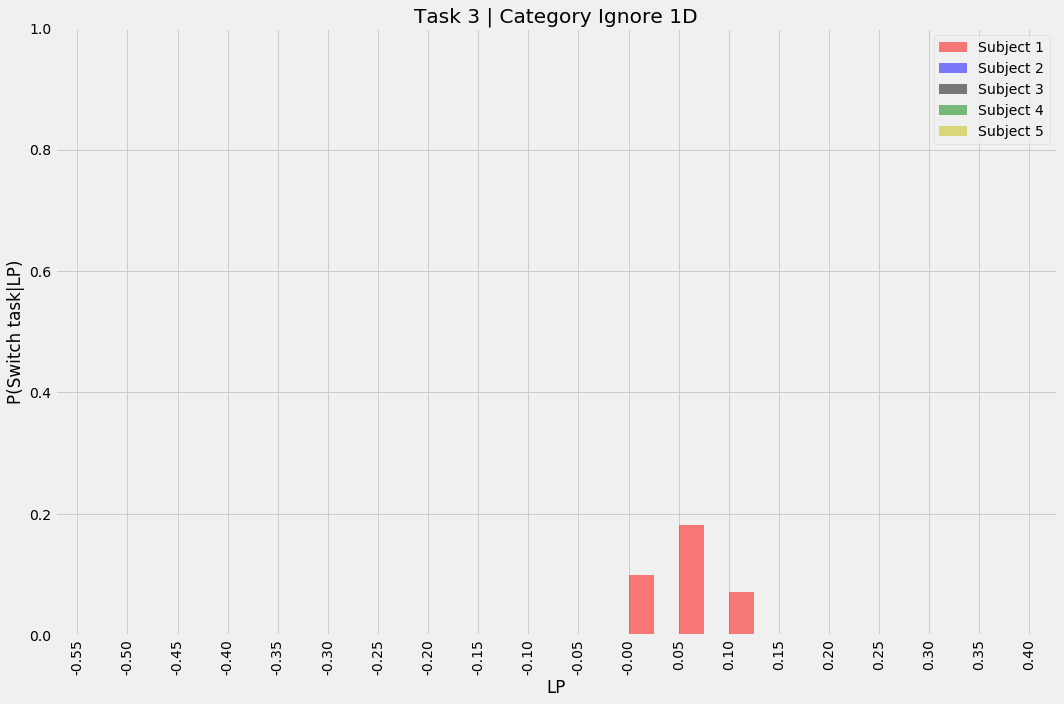

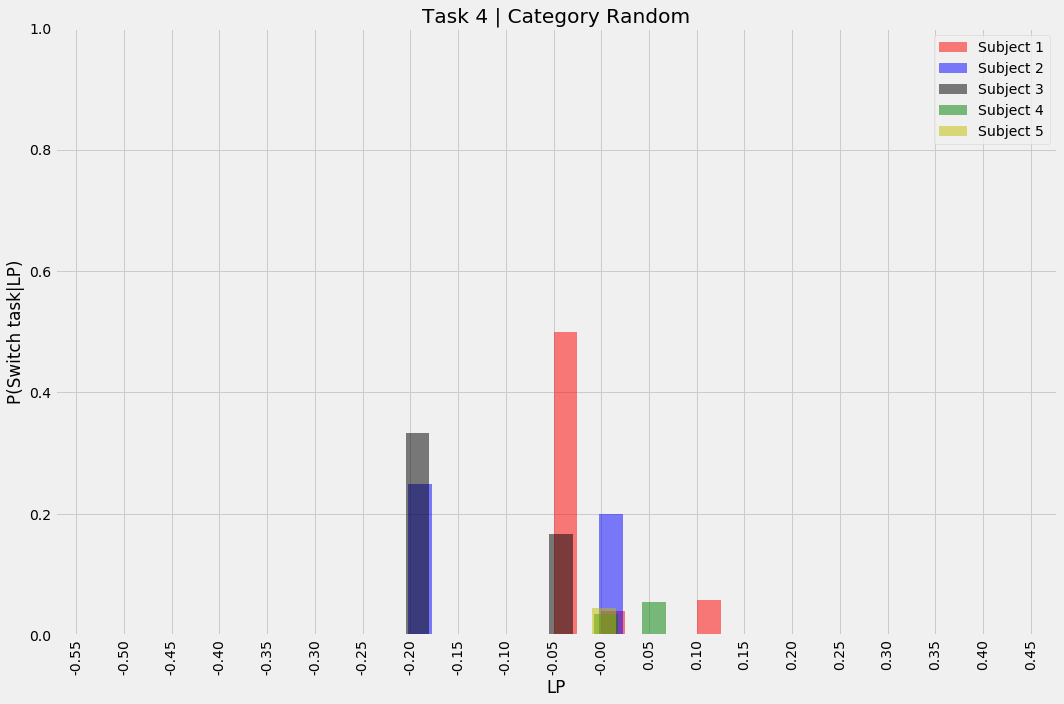

Window  30  Lookback LP  30


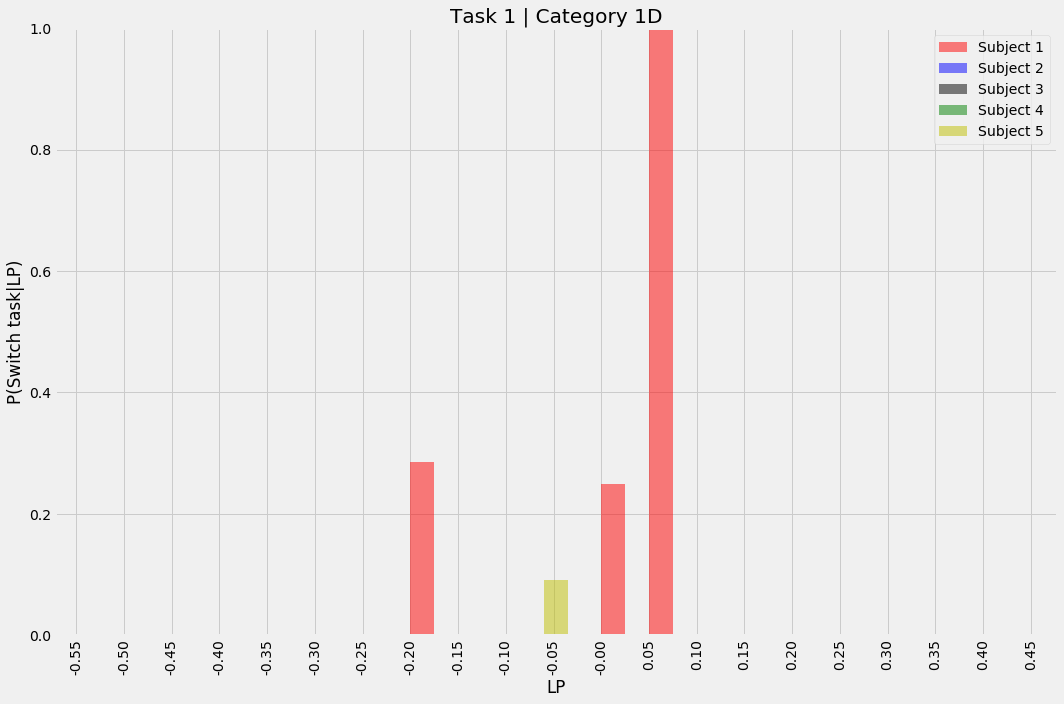

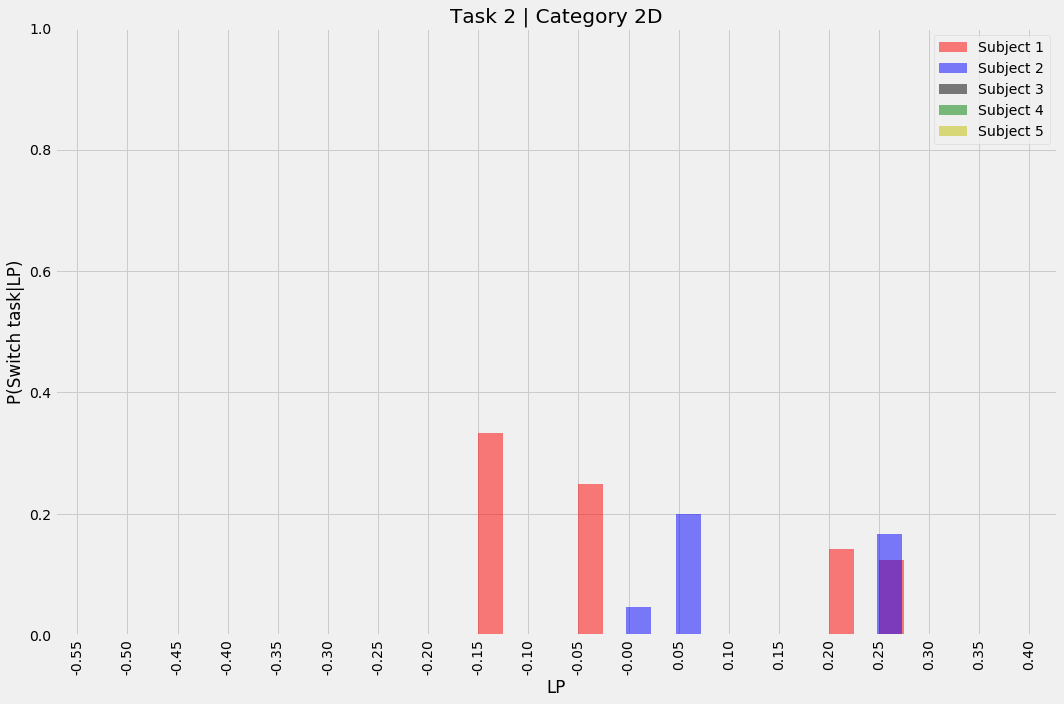

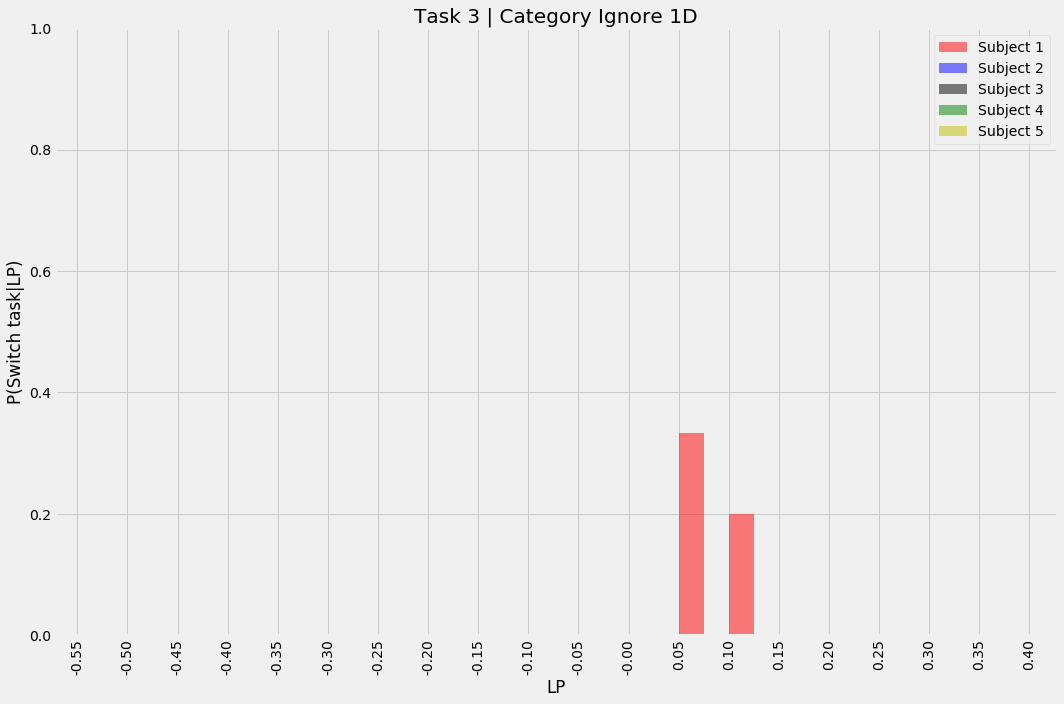

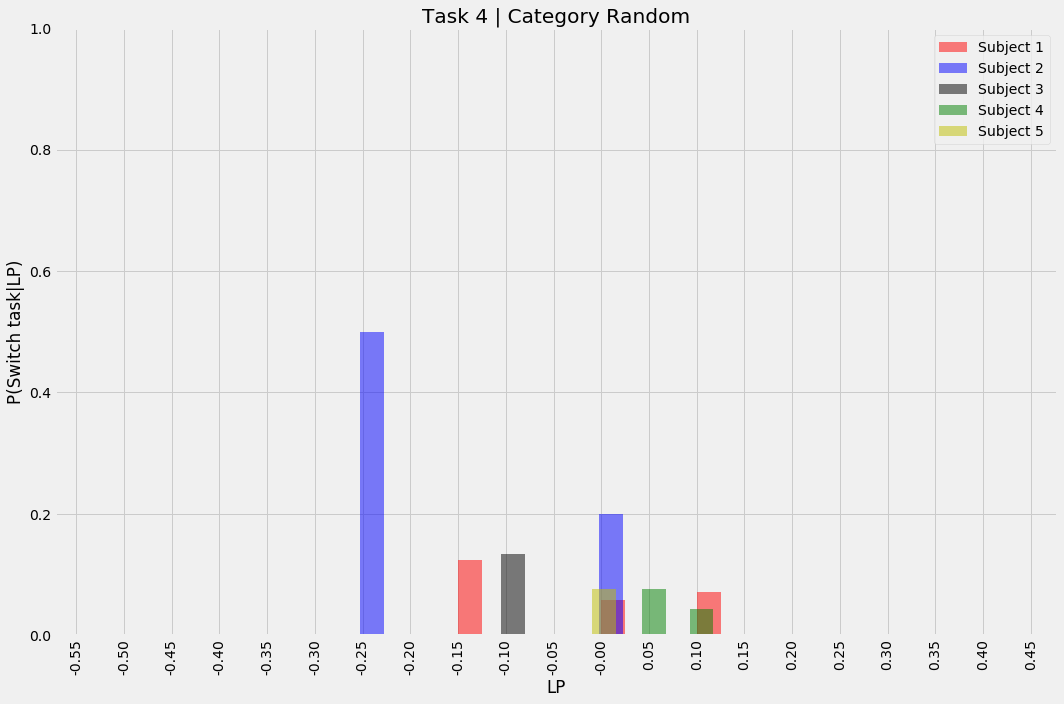

Window  35  Lookback LP  2


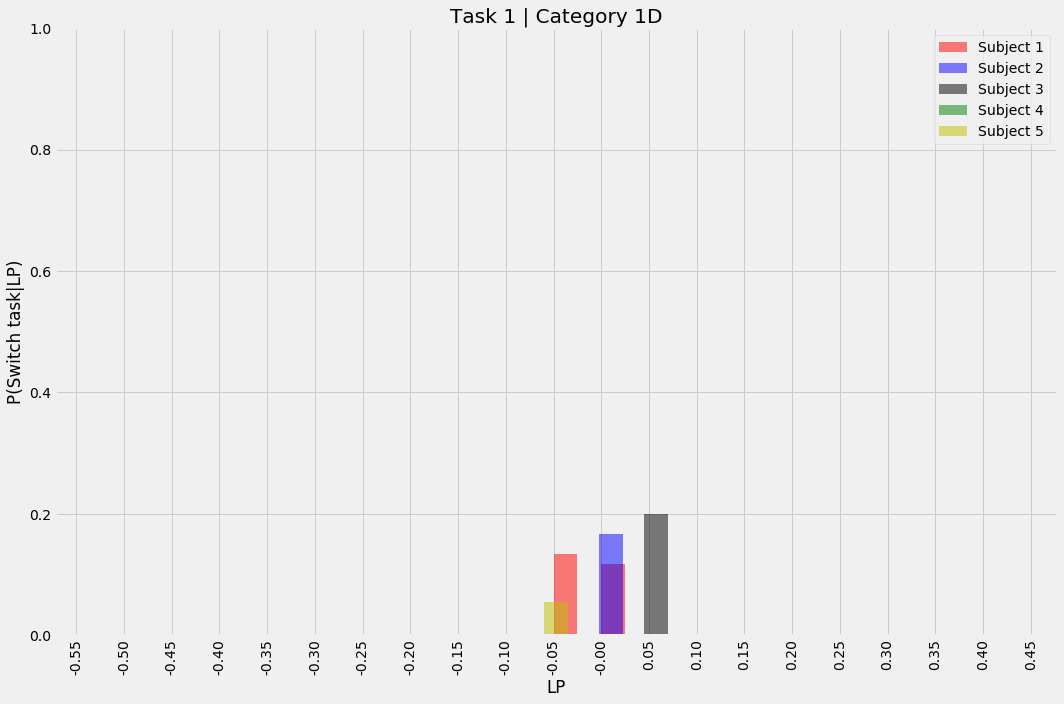

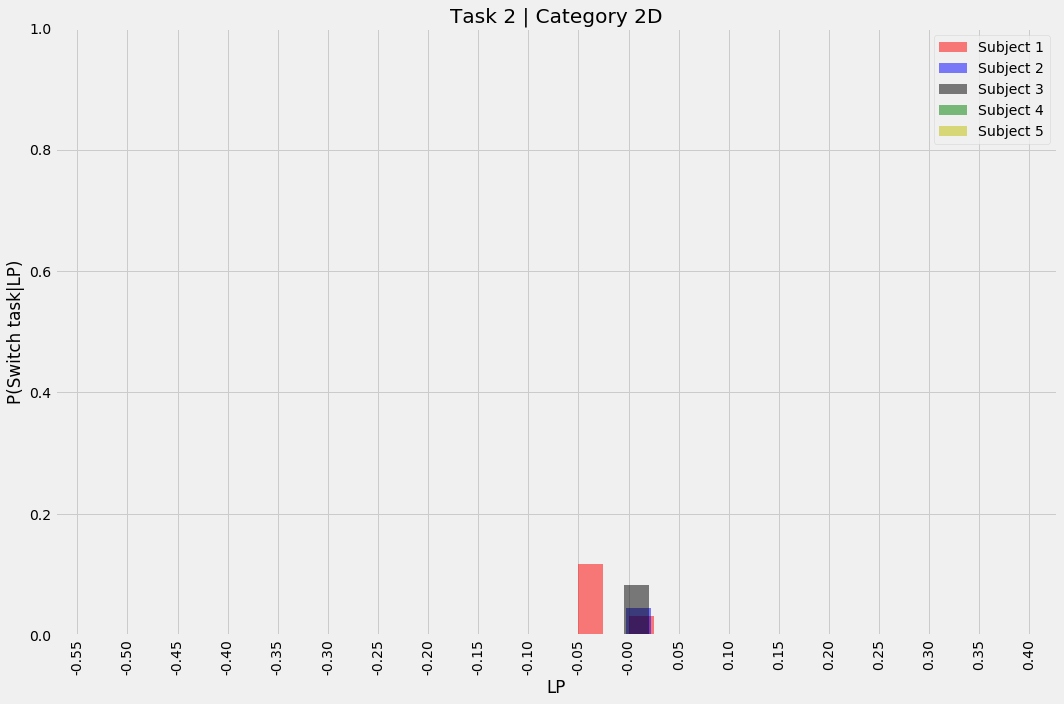

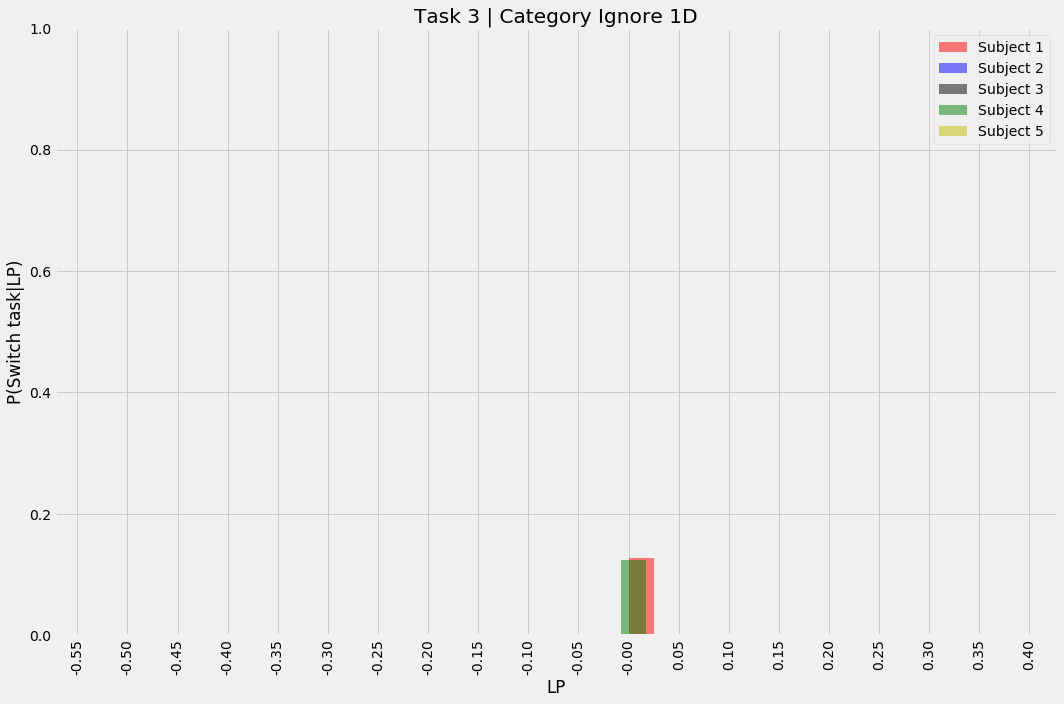

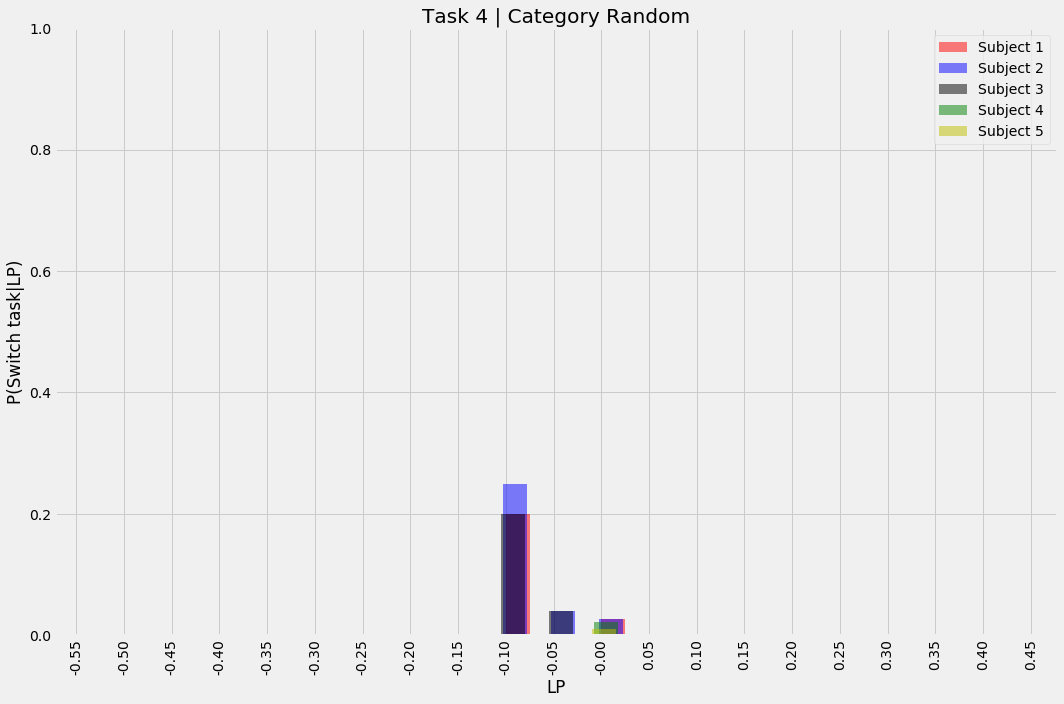

Window  35  Lookback LP  5


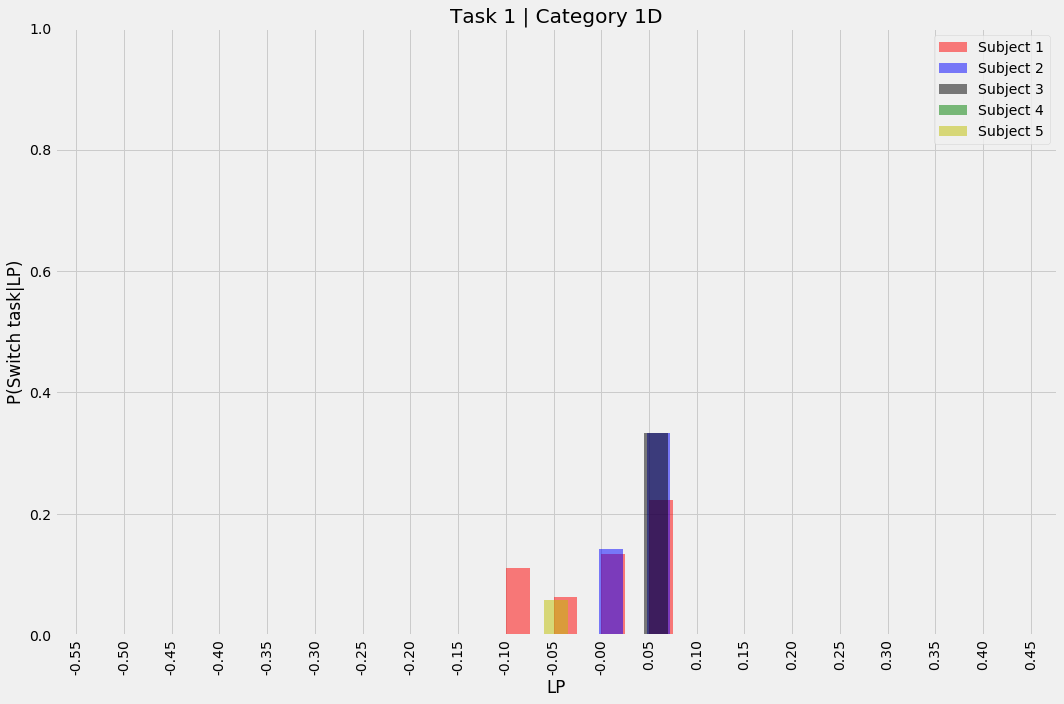

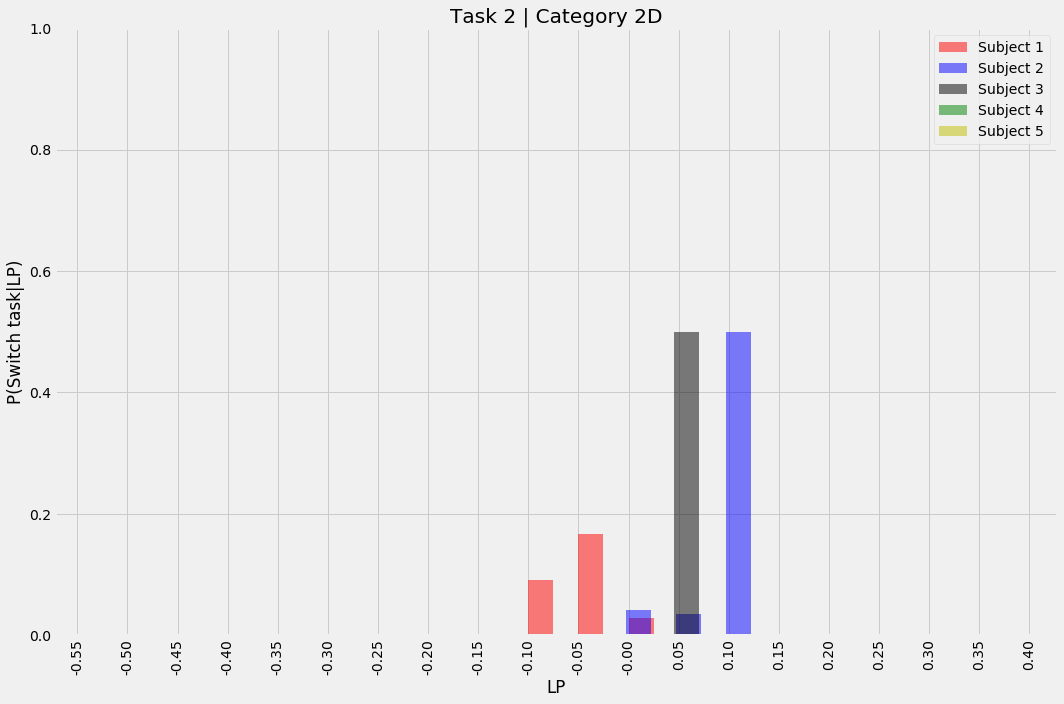

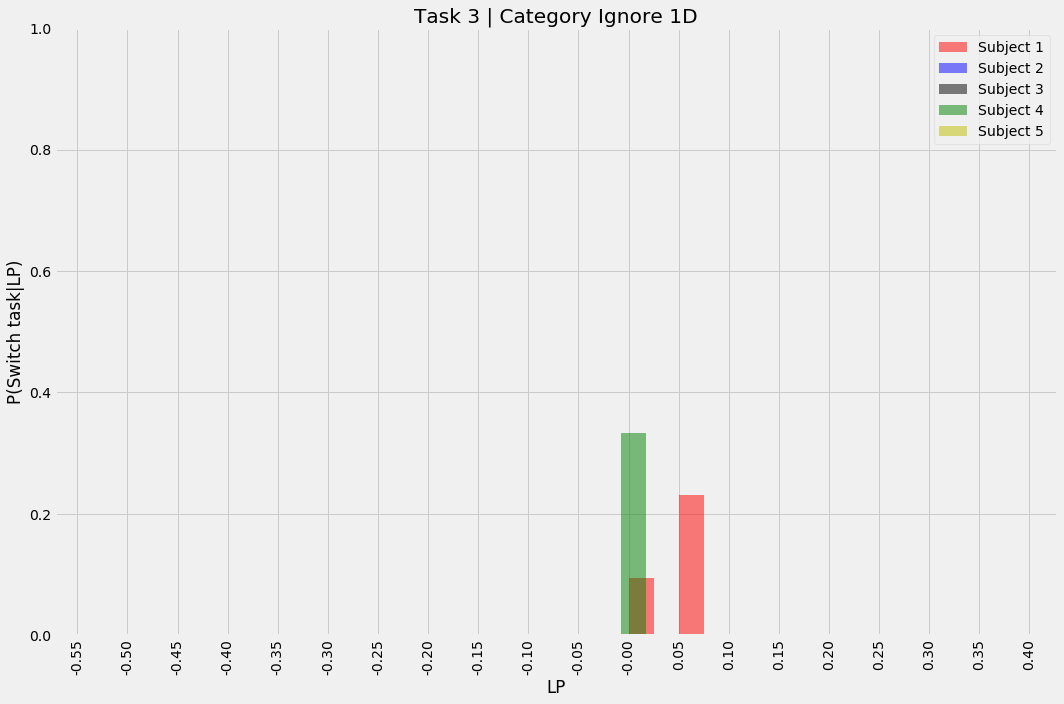

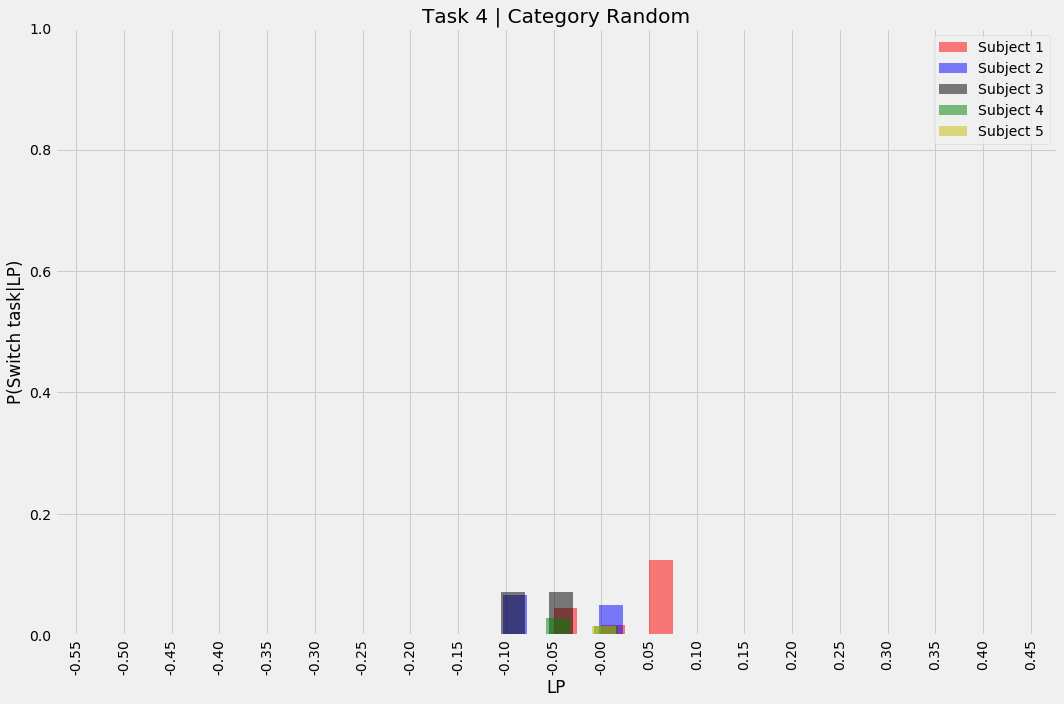

Window  35  Lookback LP  10


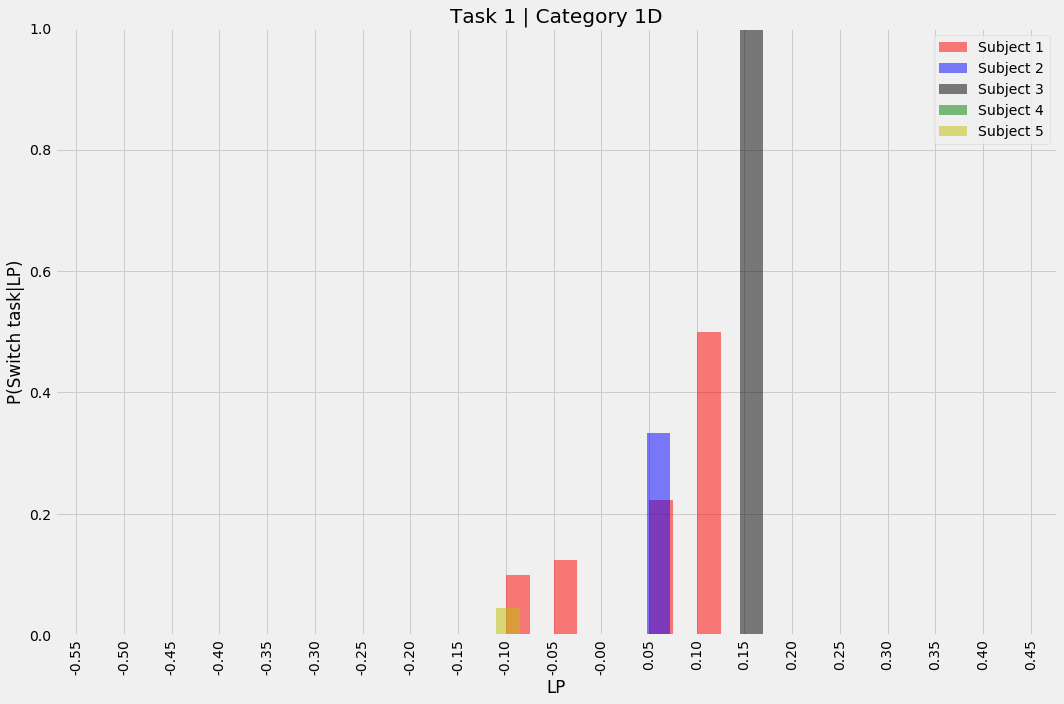

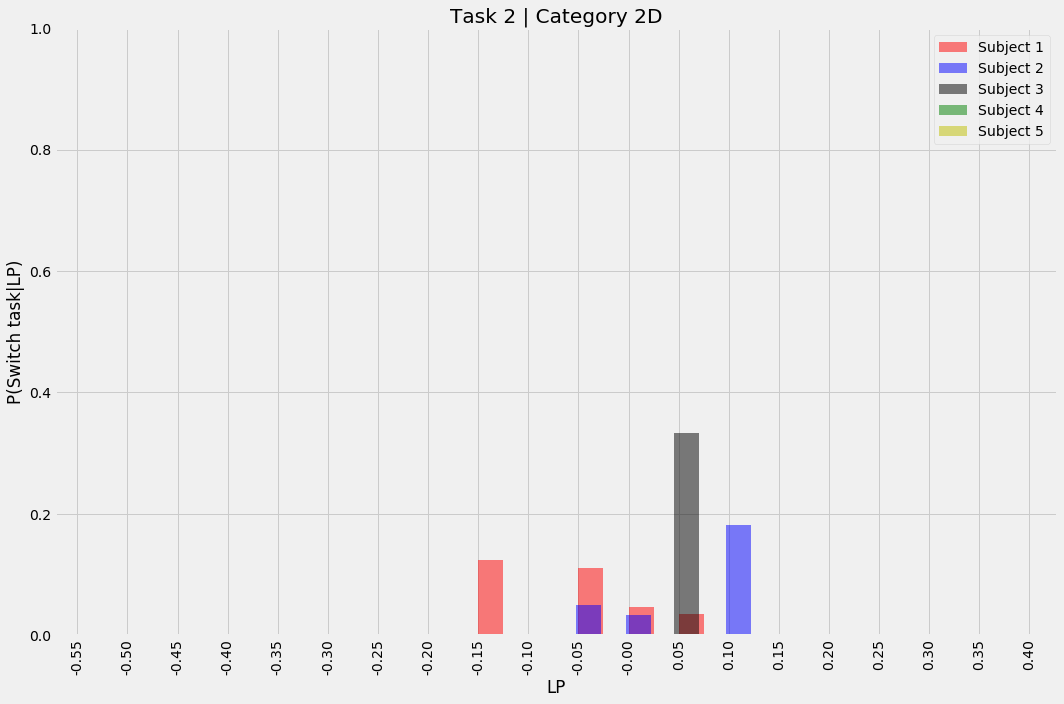

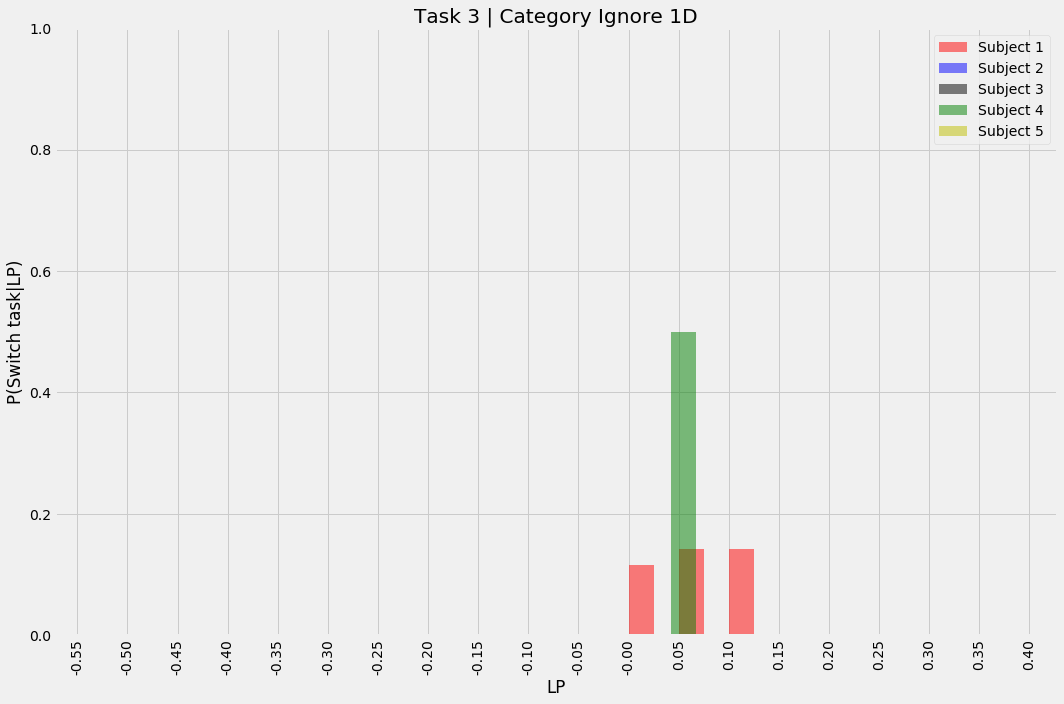

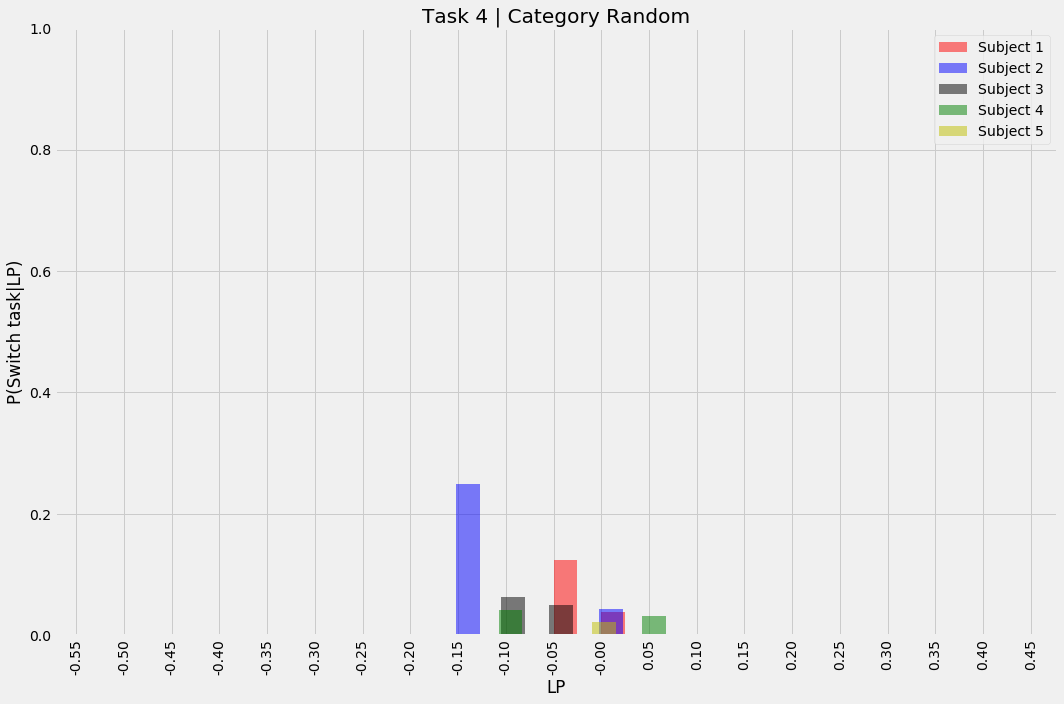

Window  35  Lookback LP  15


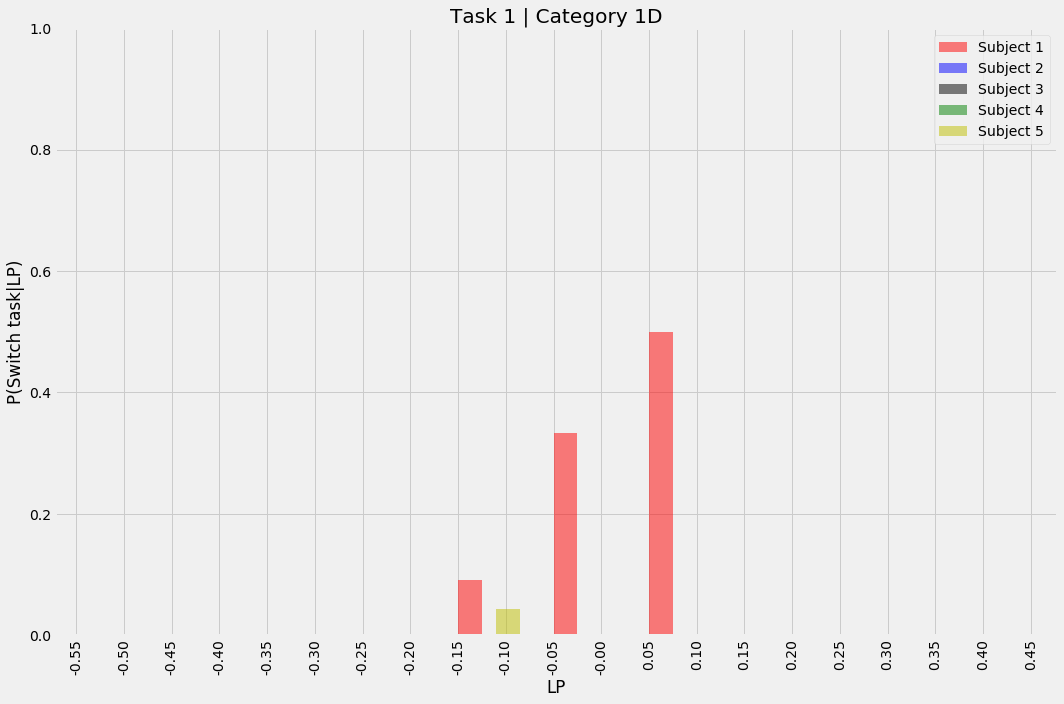

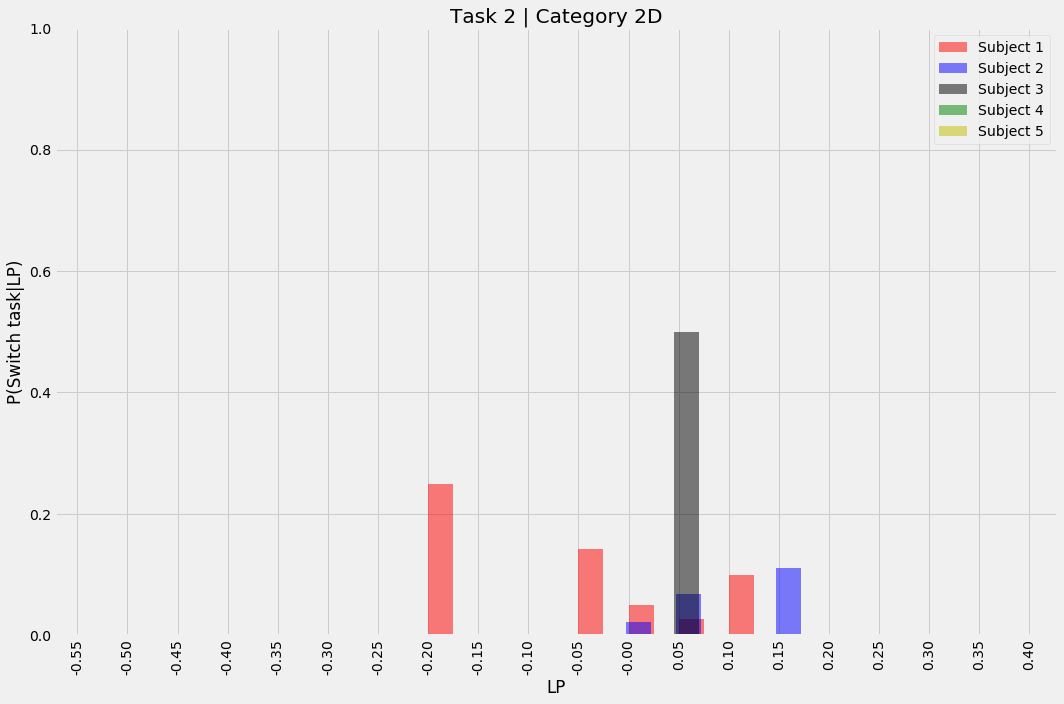

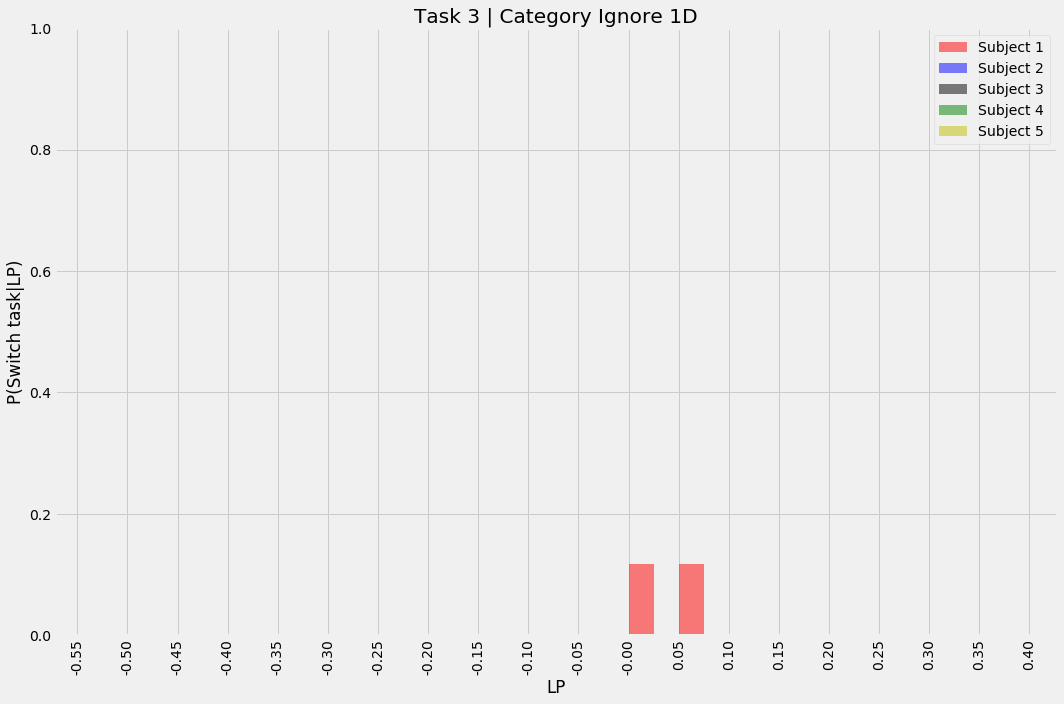

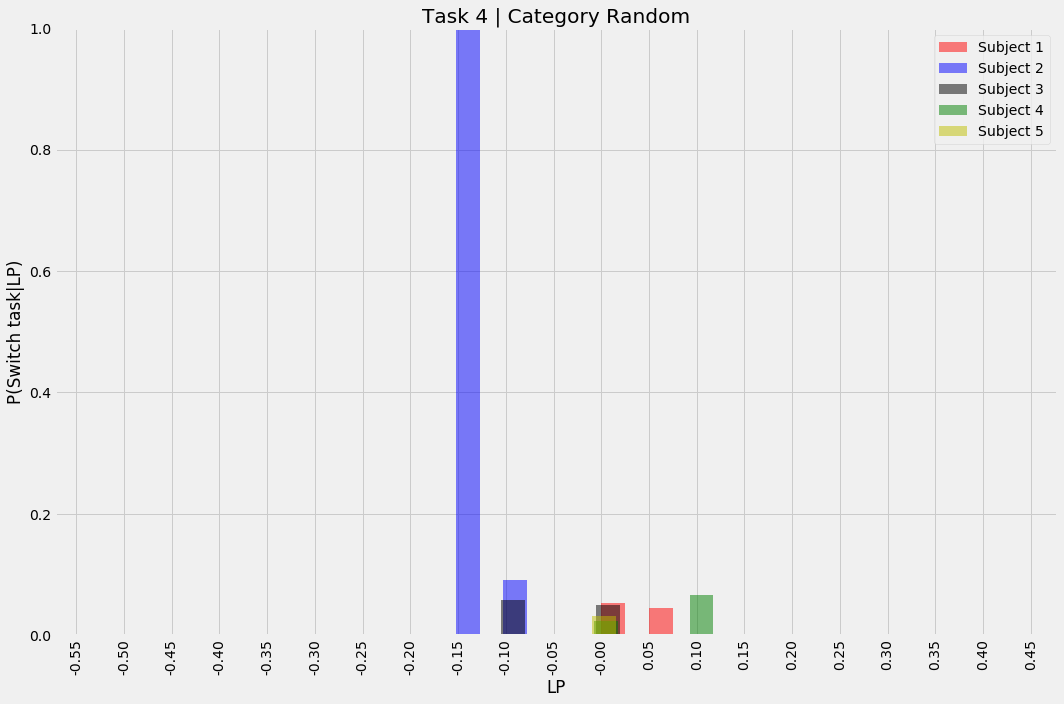

Window  35  Lookback LP  20


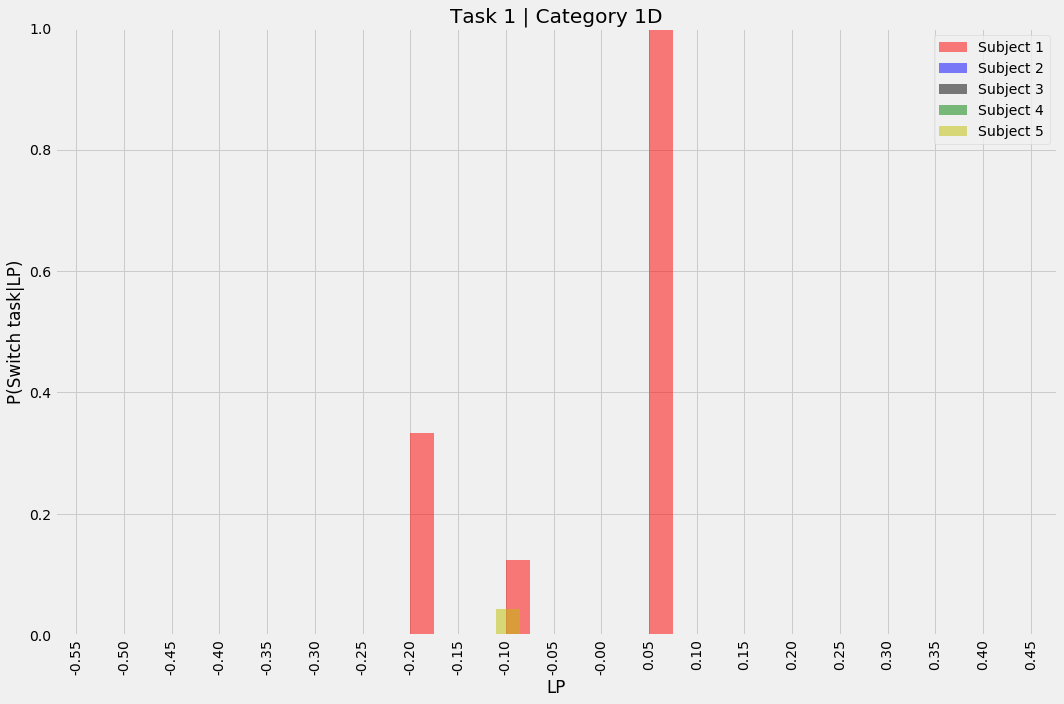

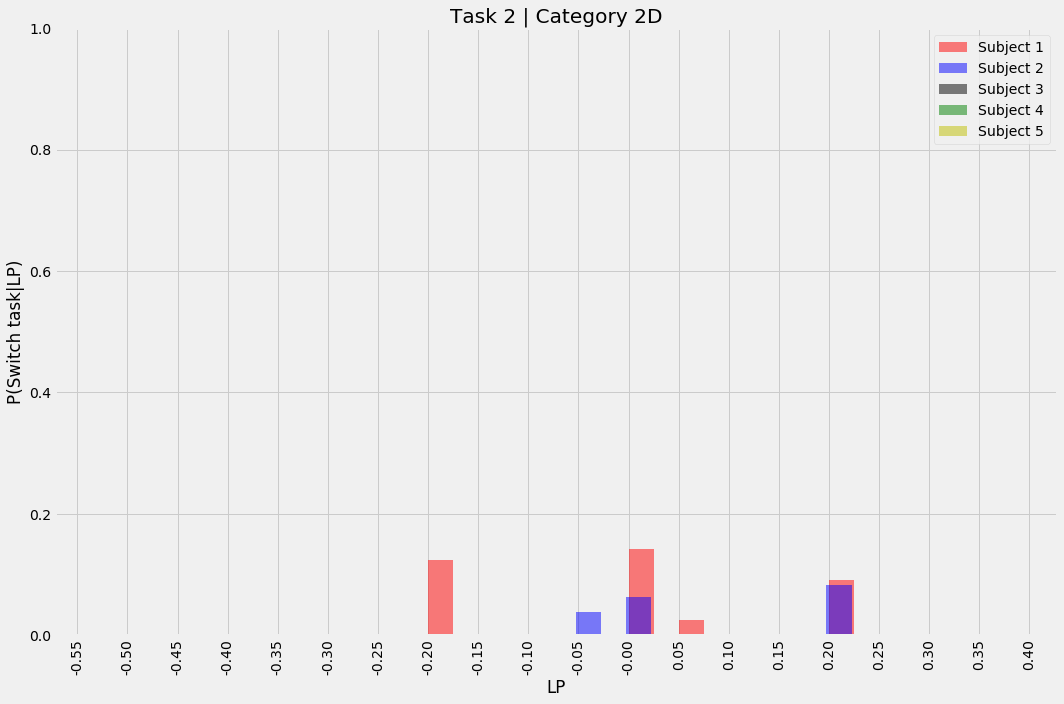

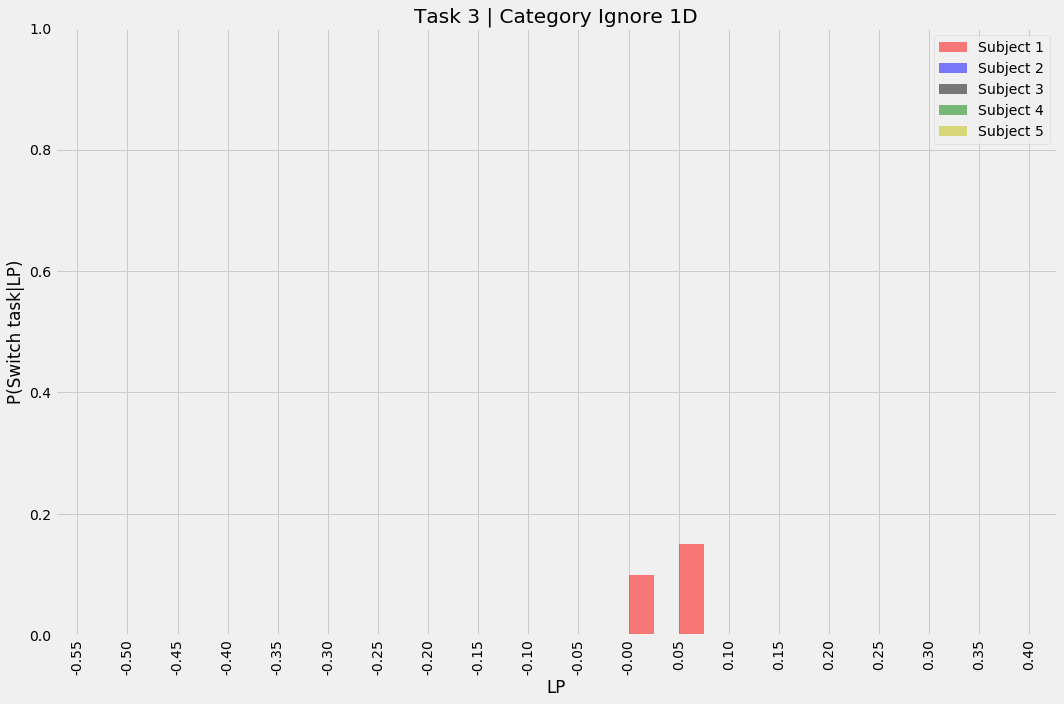

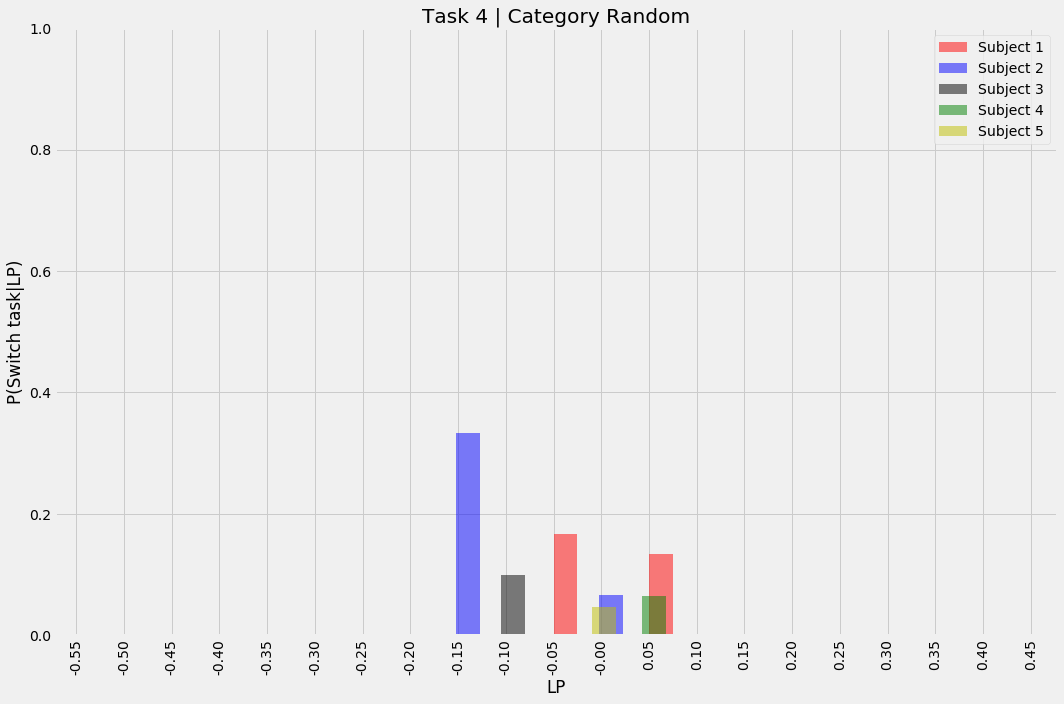

Window  35  Lookback LP  25


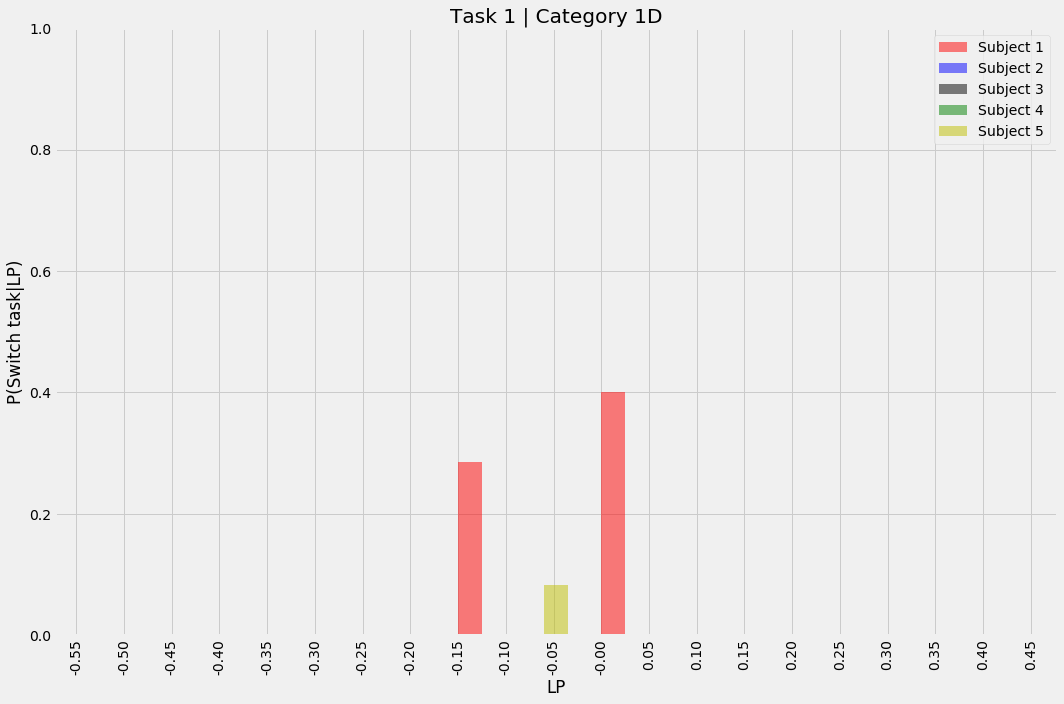

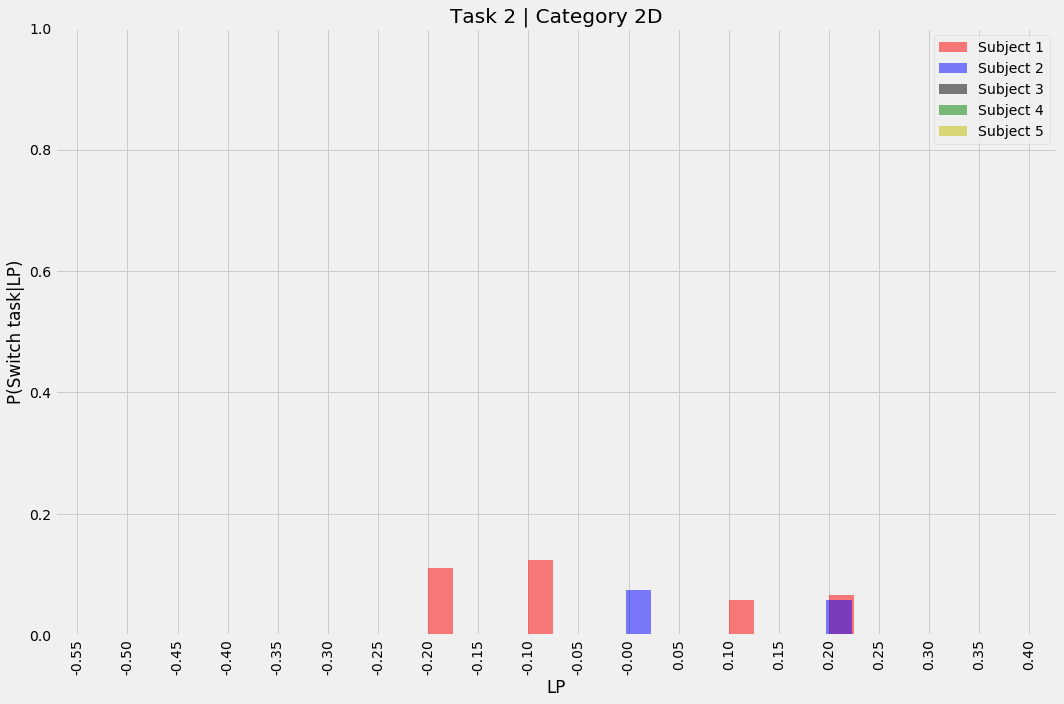

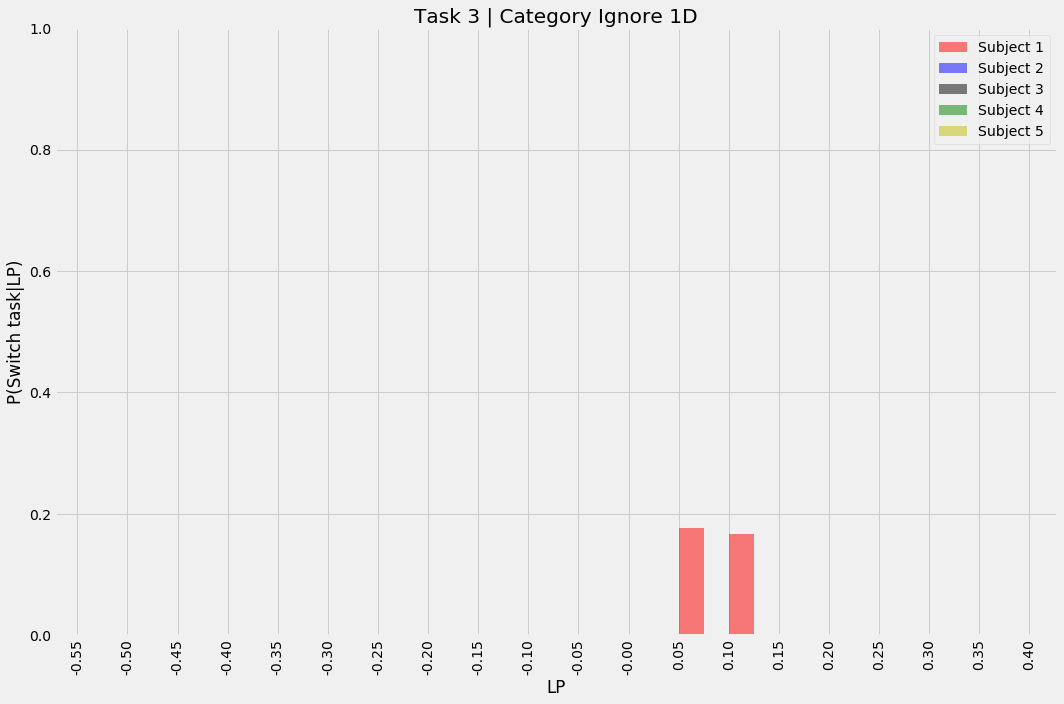

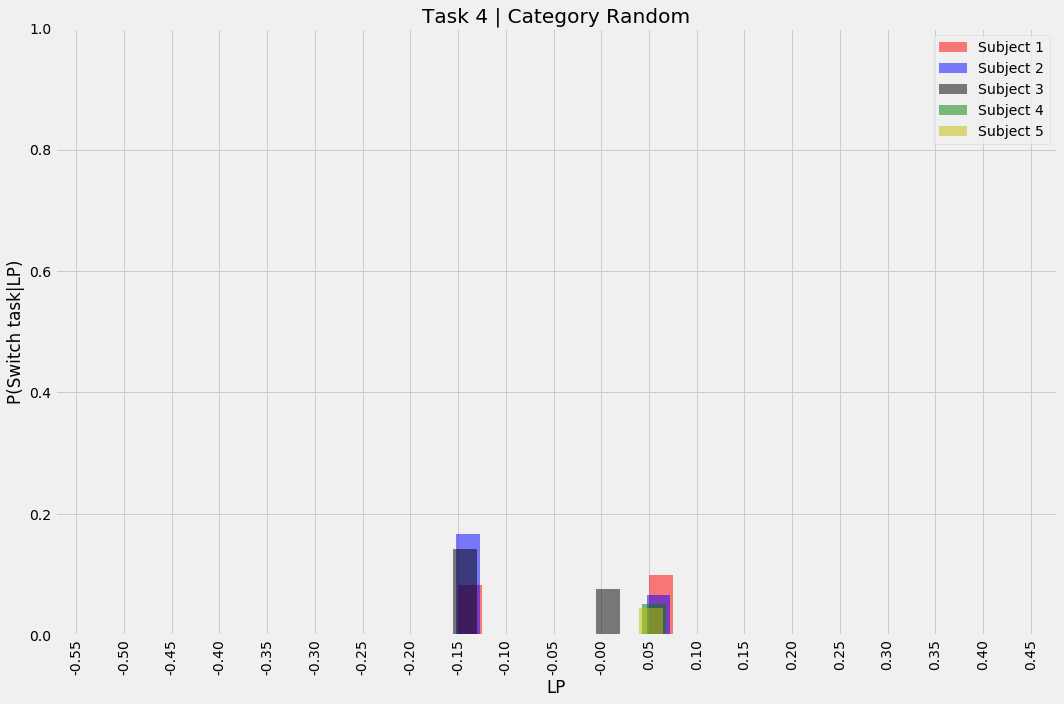

Window  35  Lookback LP  30


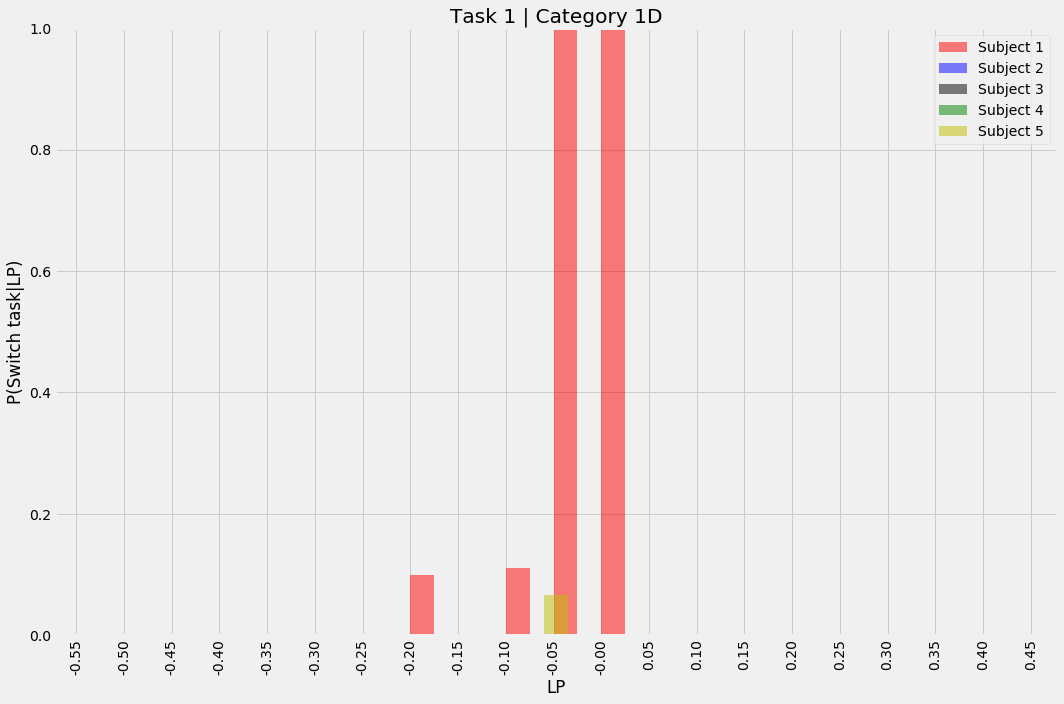

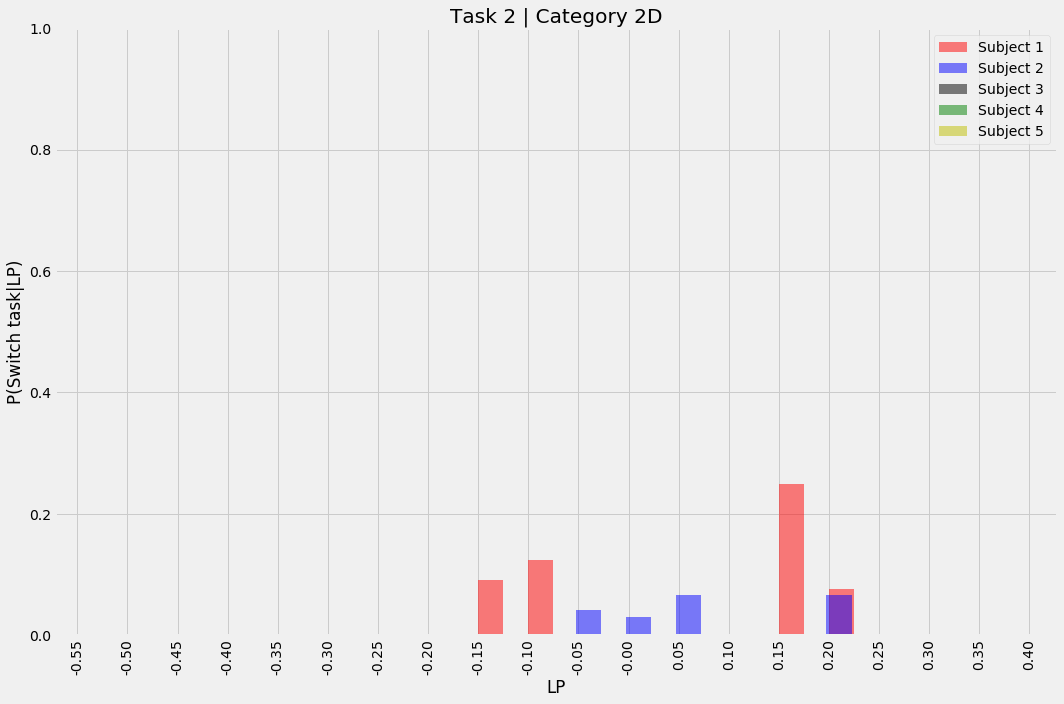

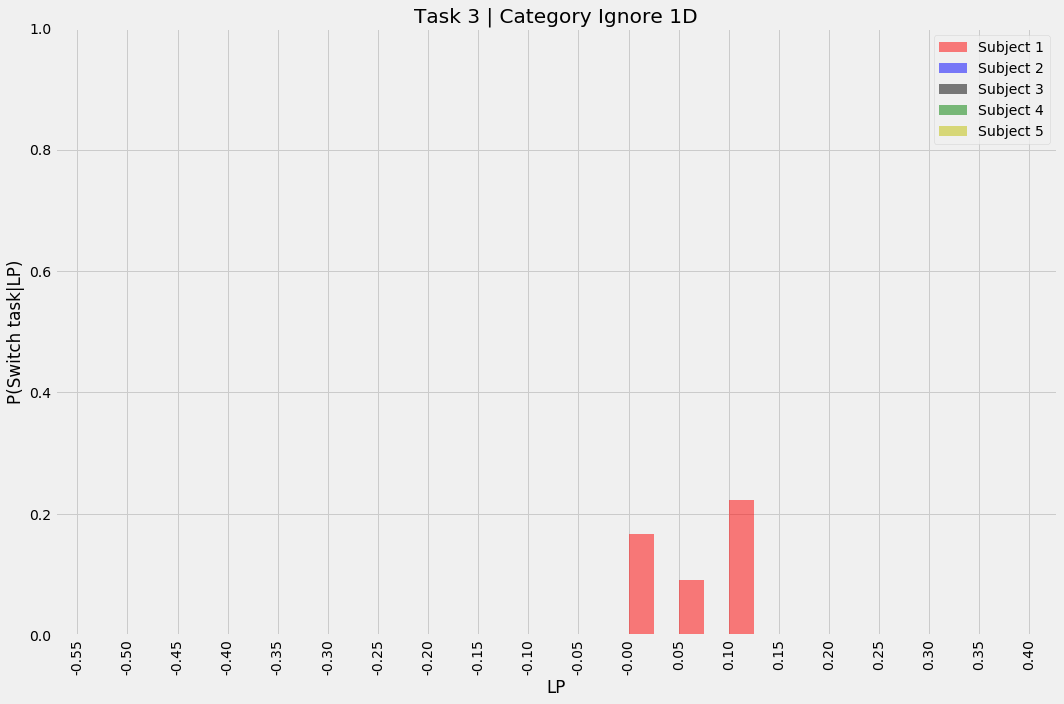

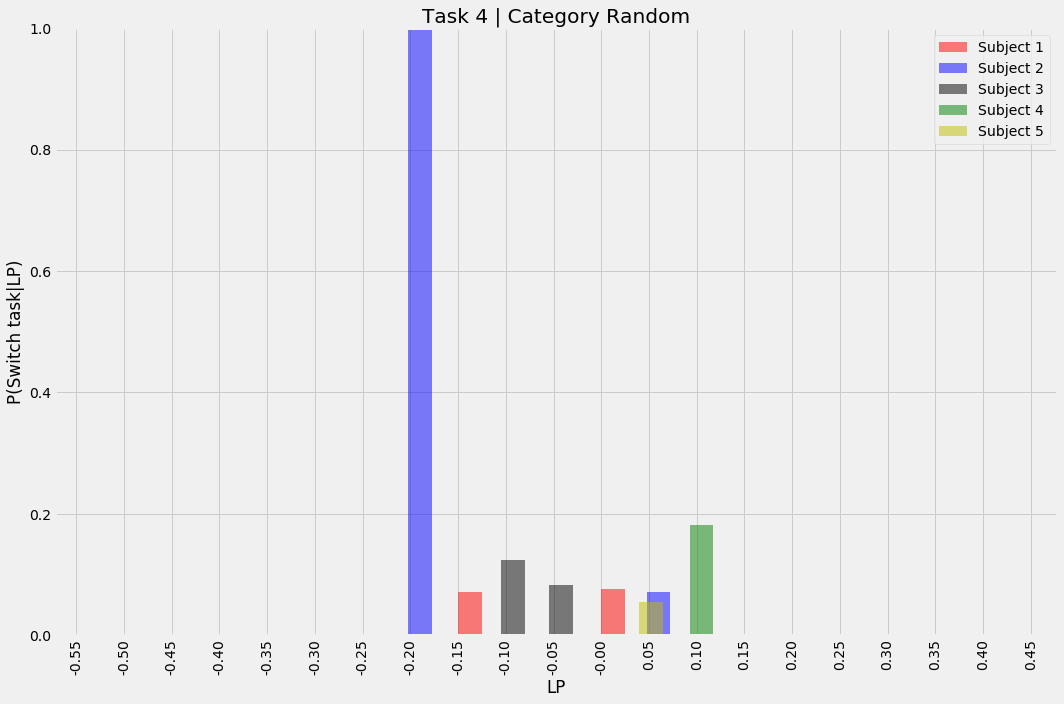

Window  40  Lookback LP  2


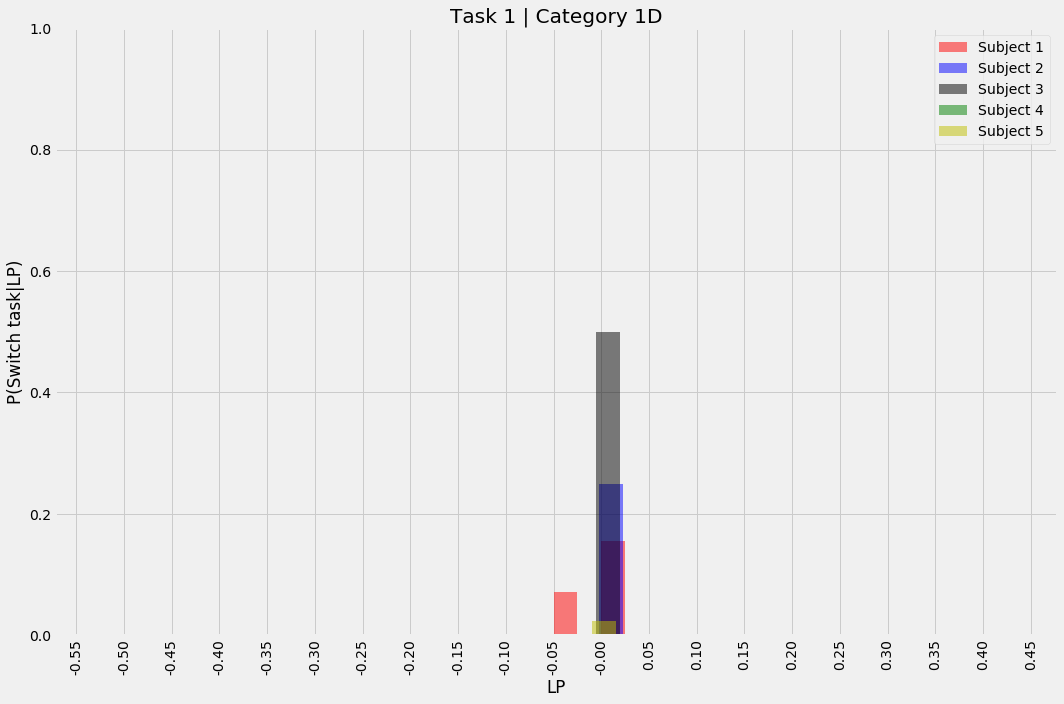

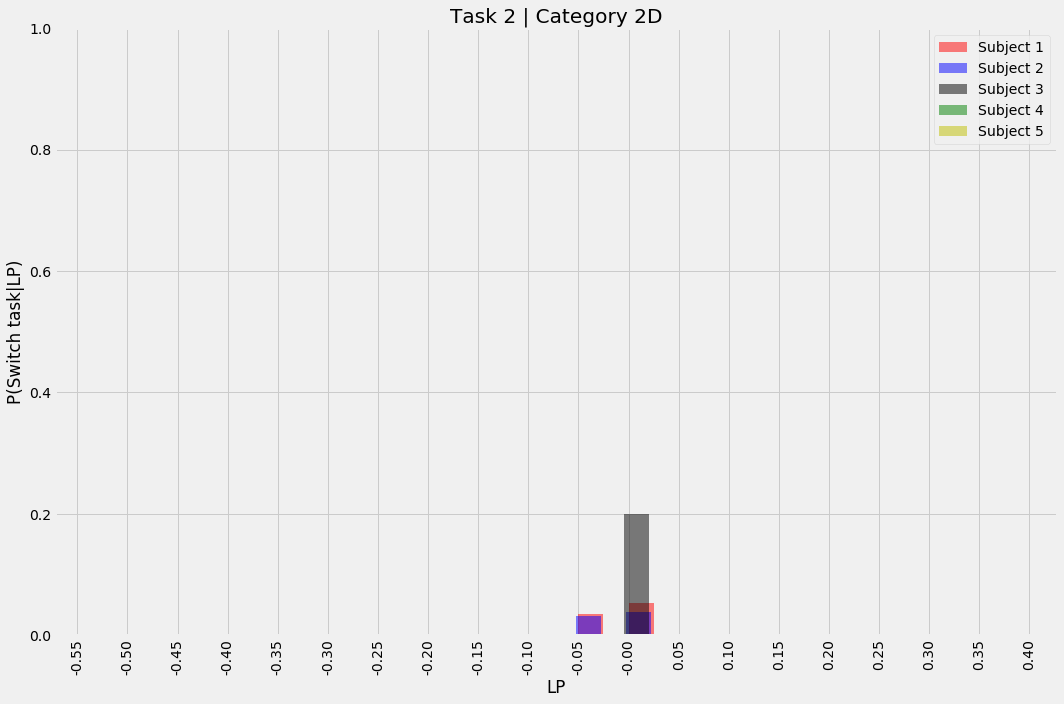

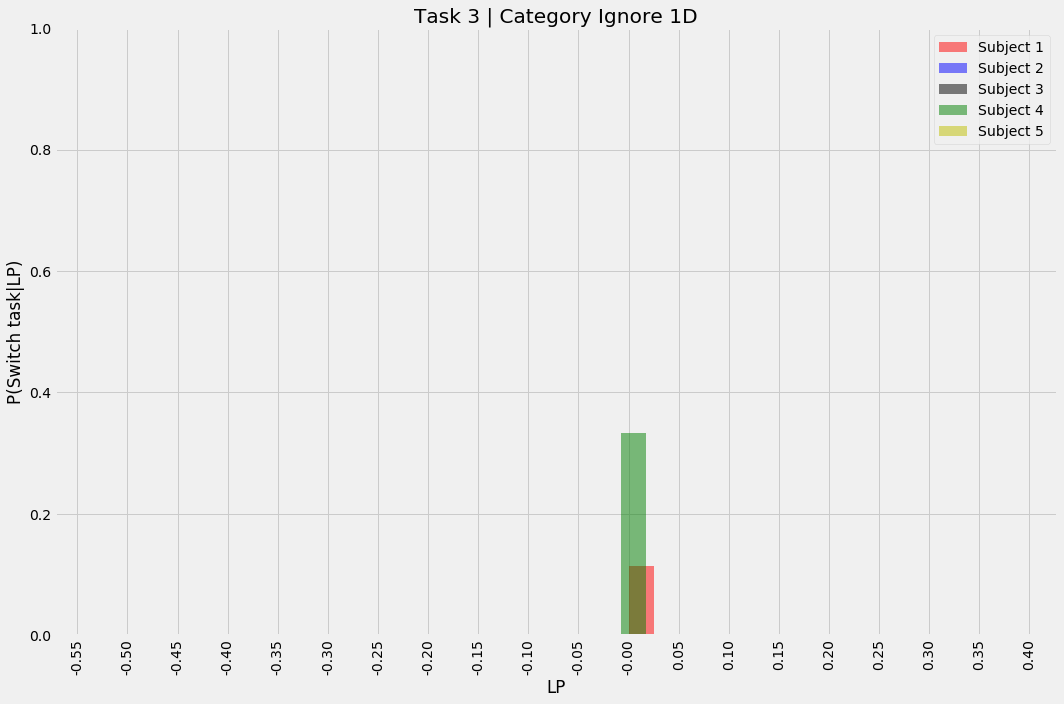

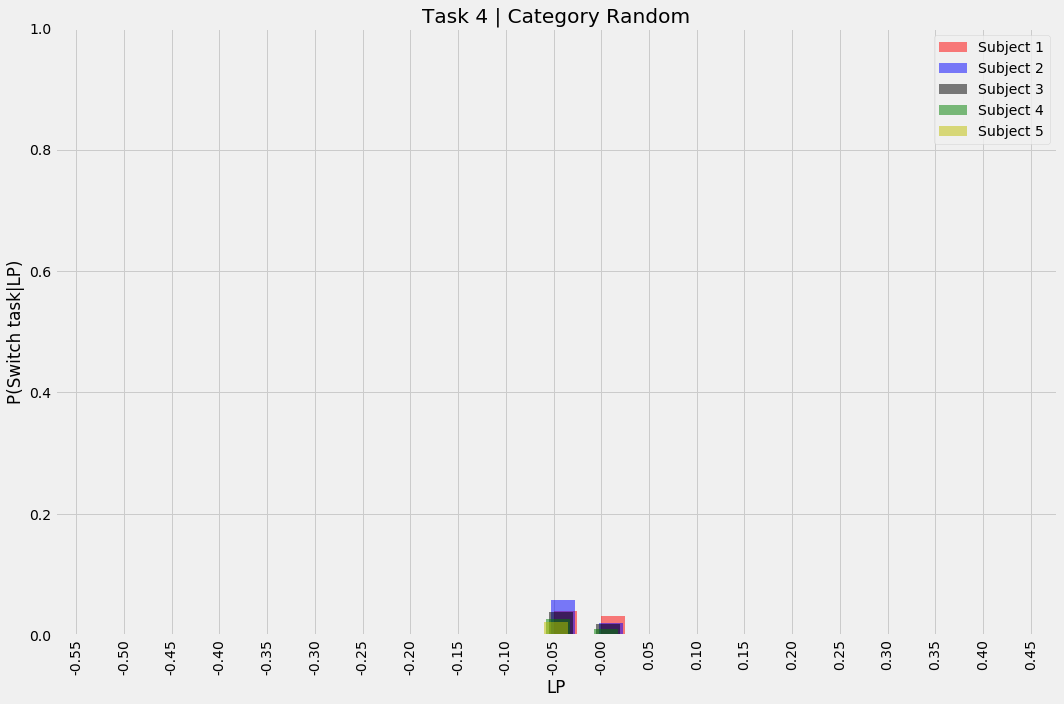

Window  40  Lookback LP  5


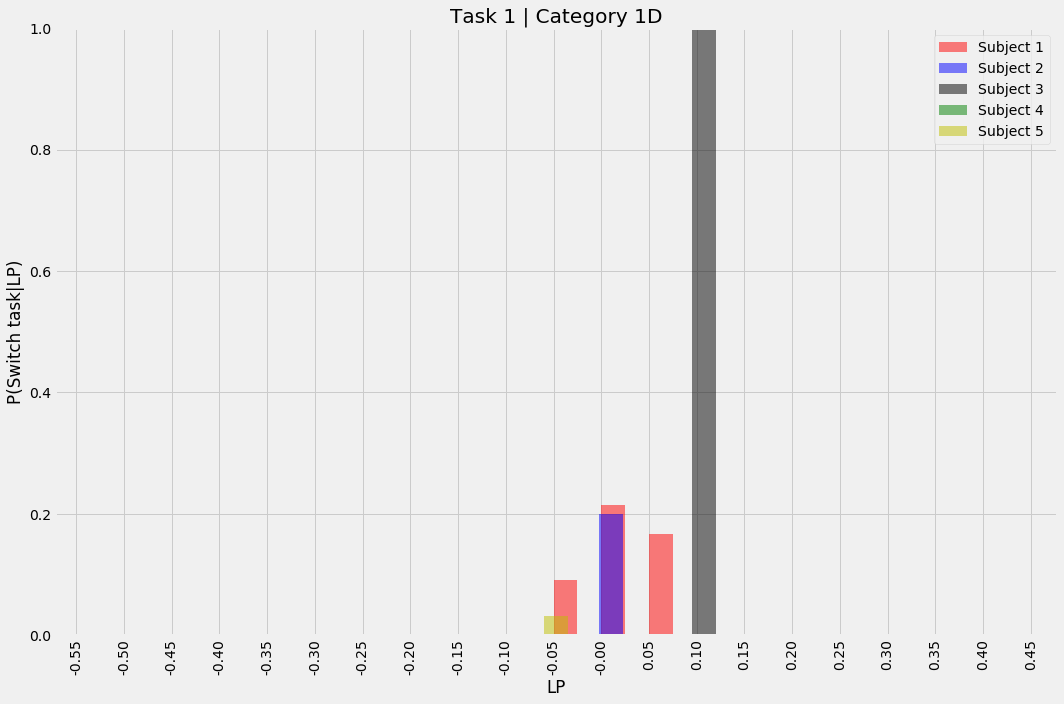

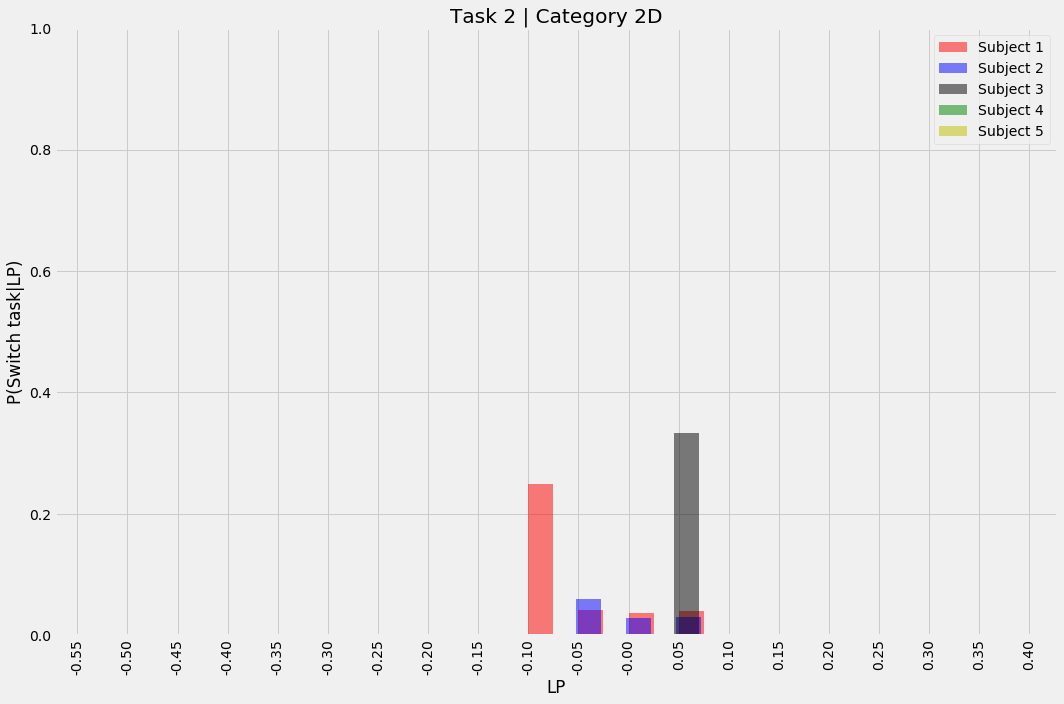

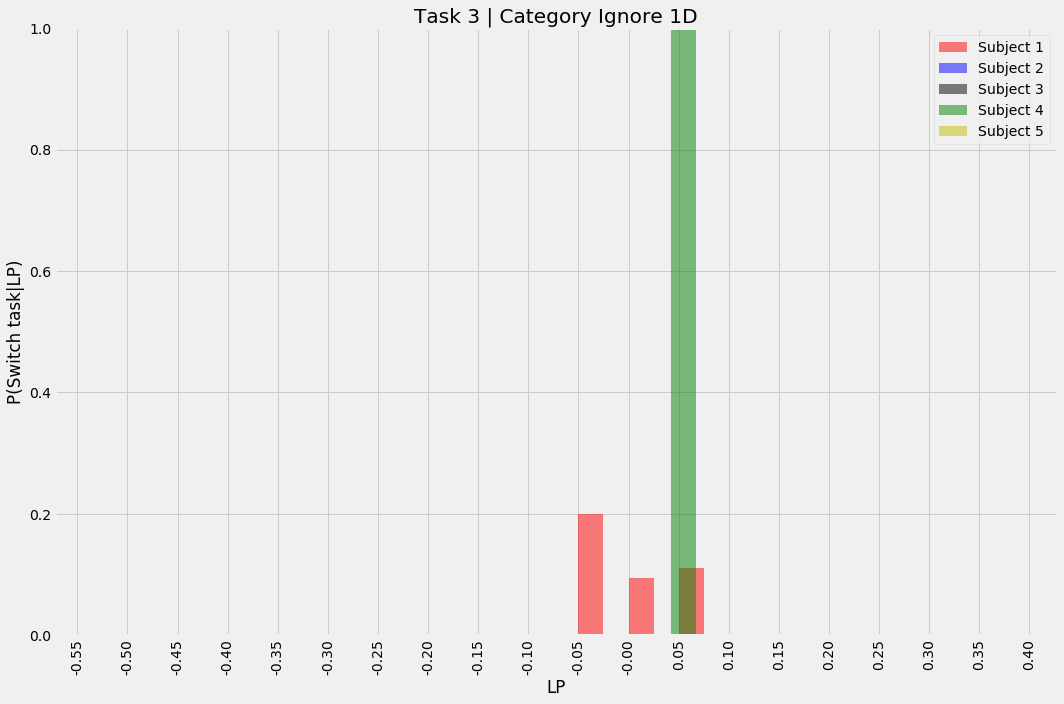

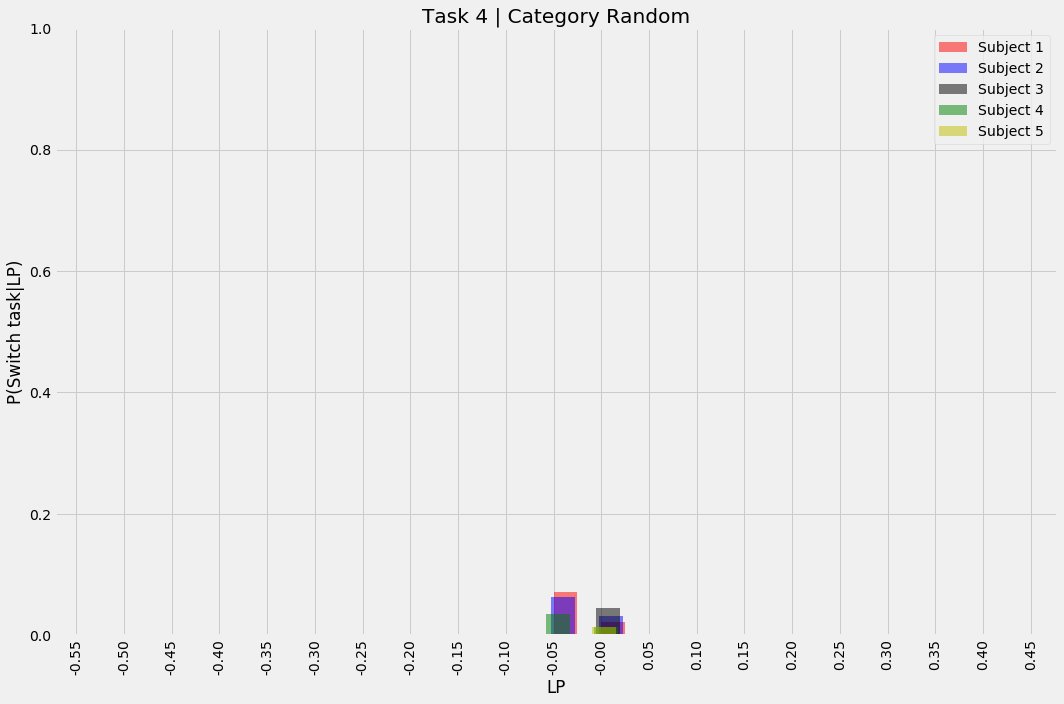

Window  40  Lookback LP  10


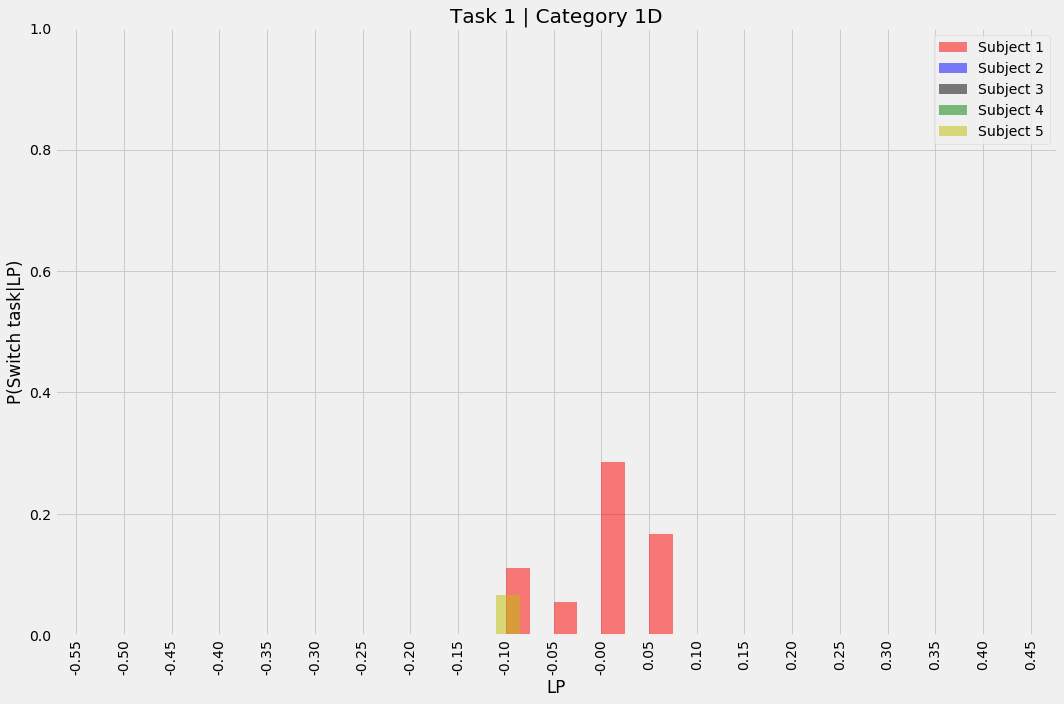

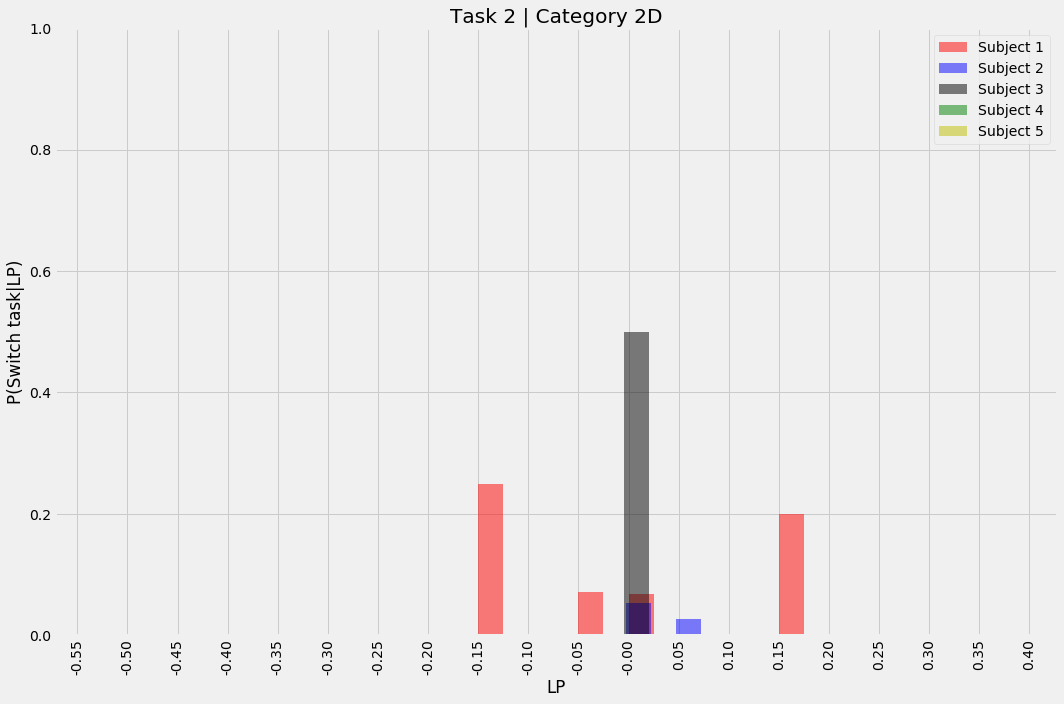

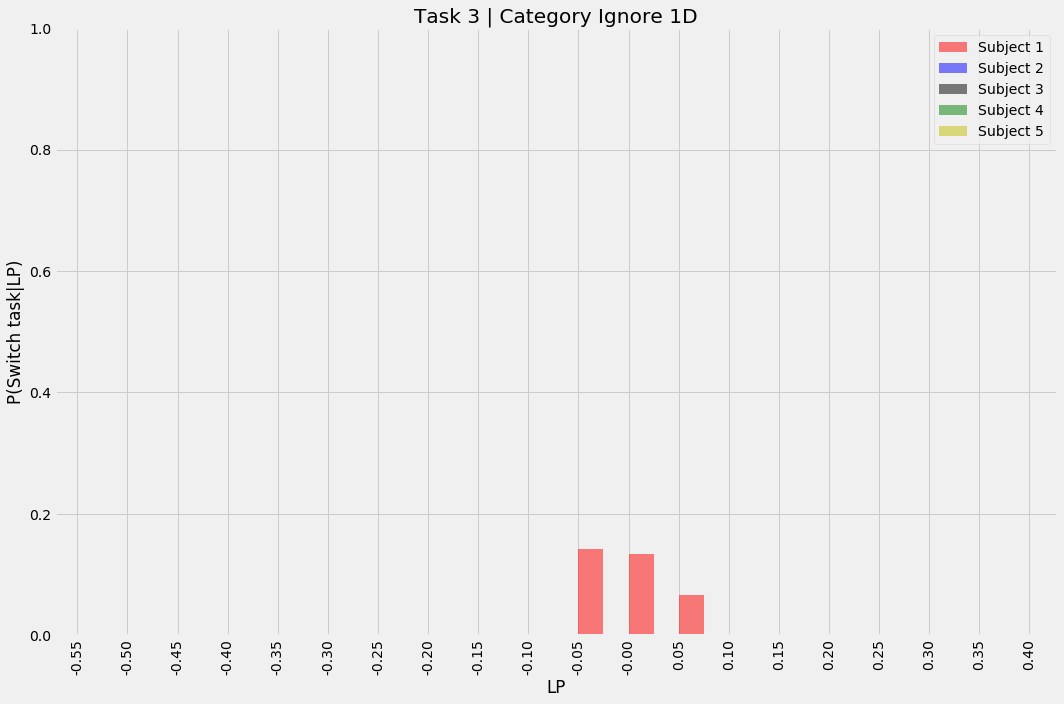

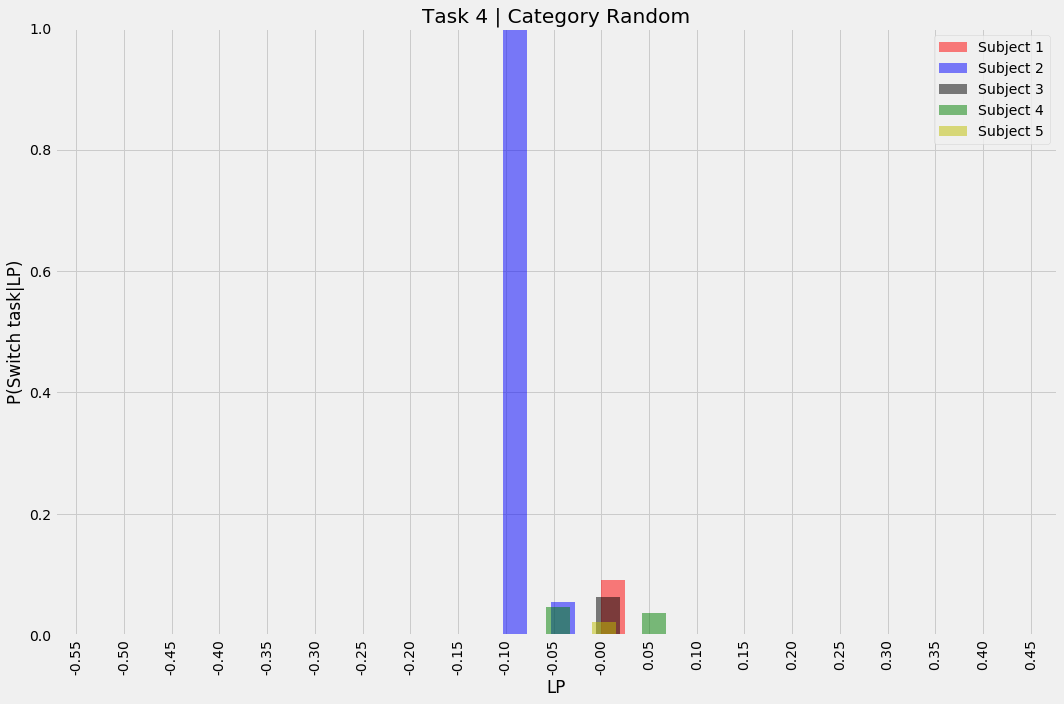

Window  40  Lookback LP  15


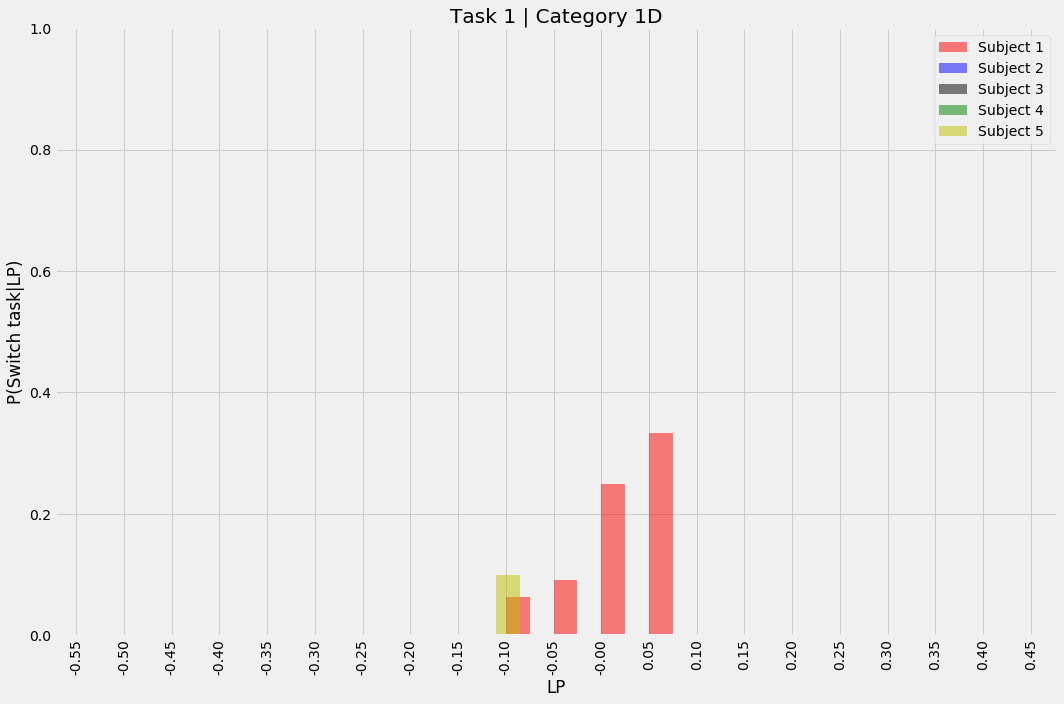

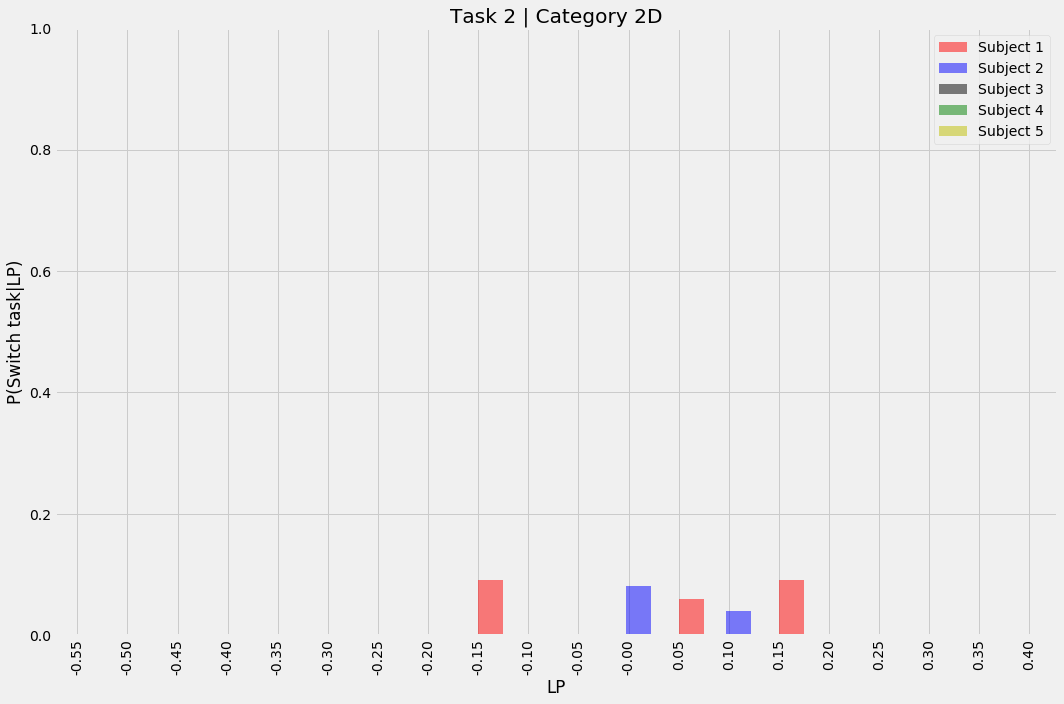

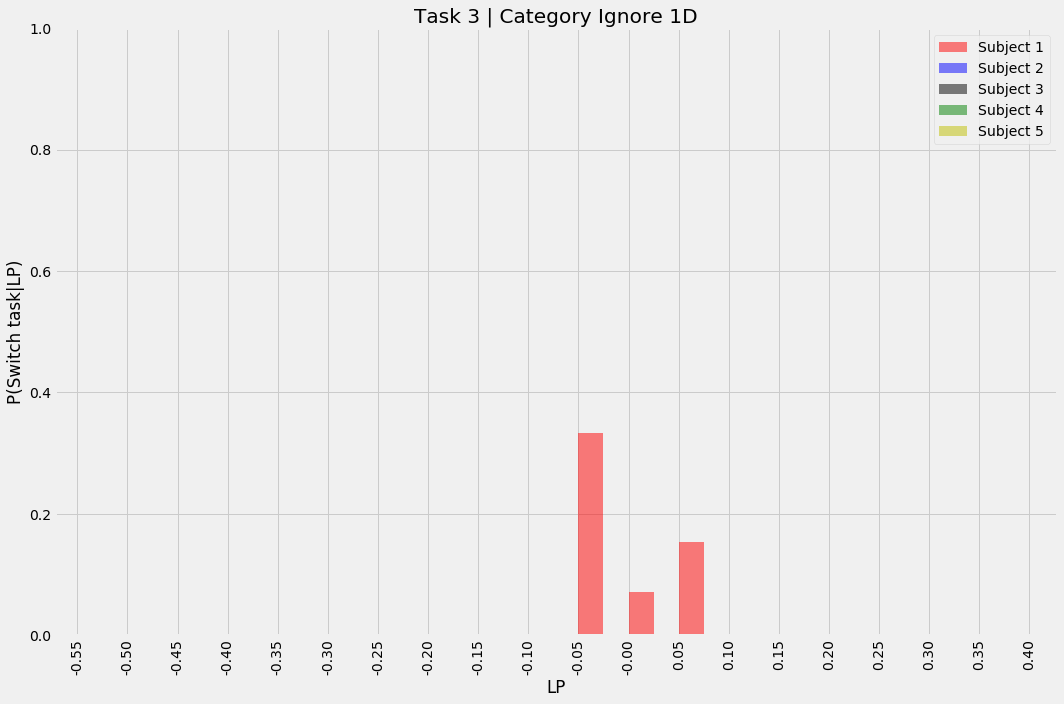

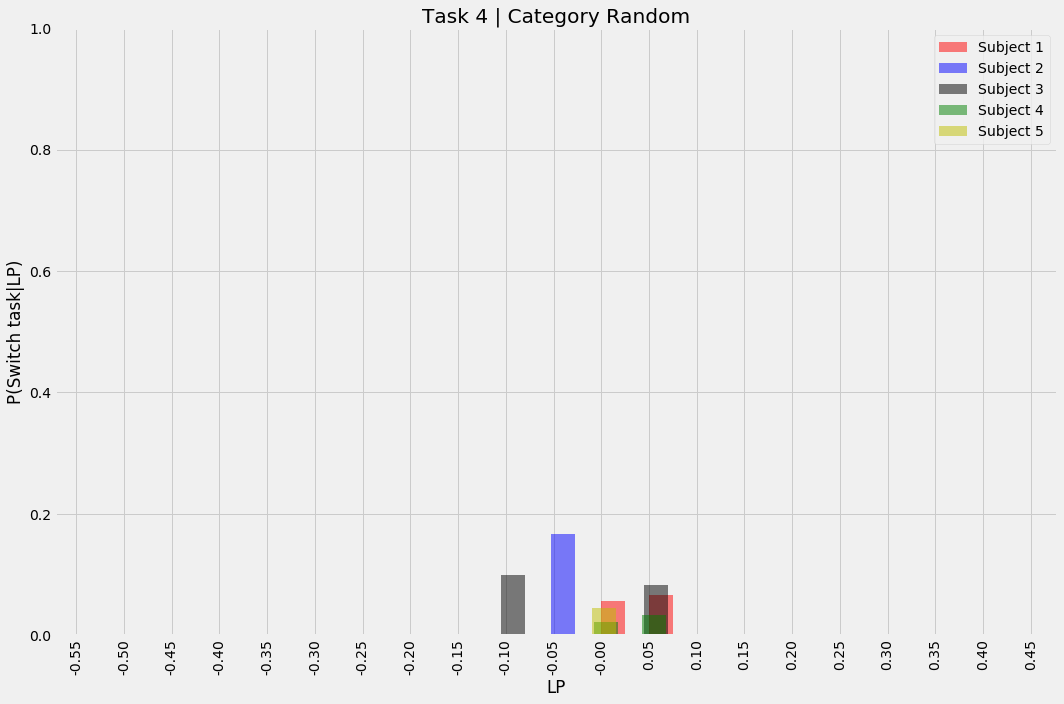

Window  40  Lookback LP  20


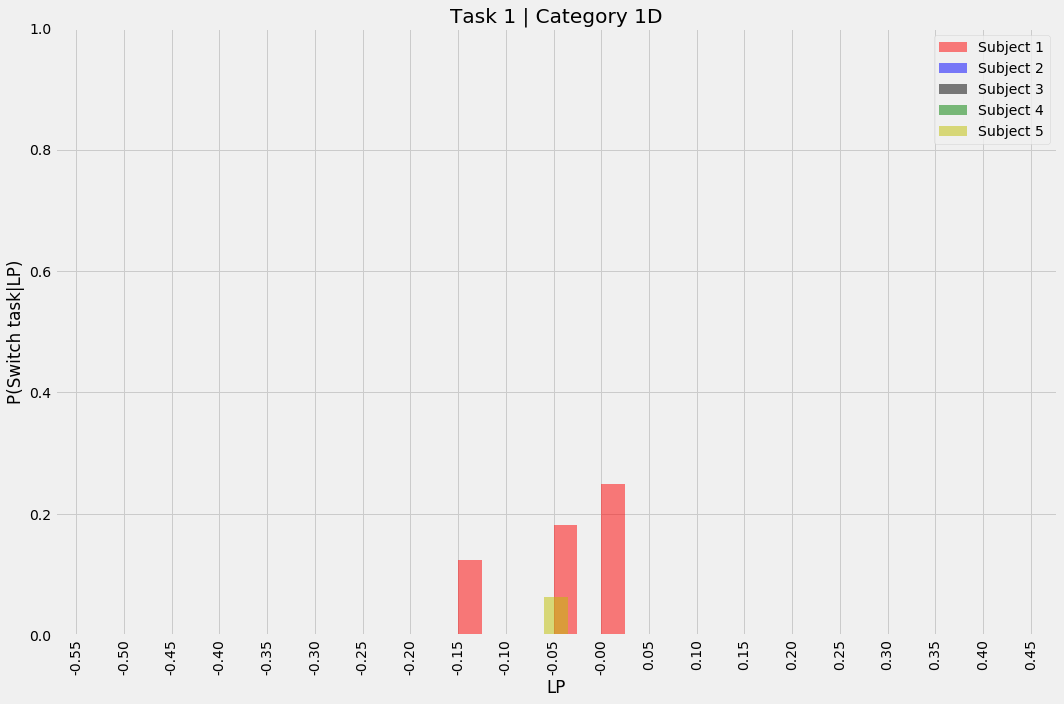

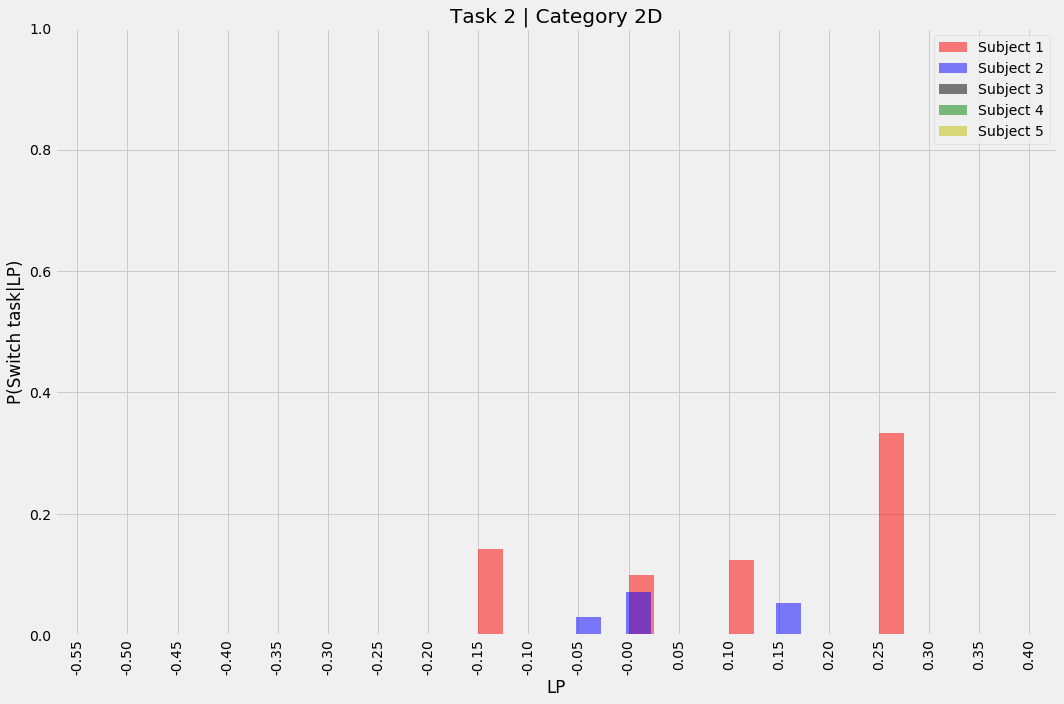

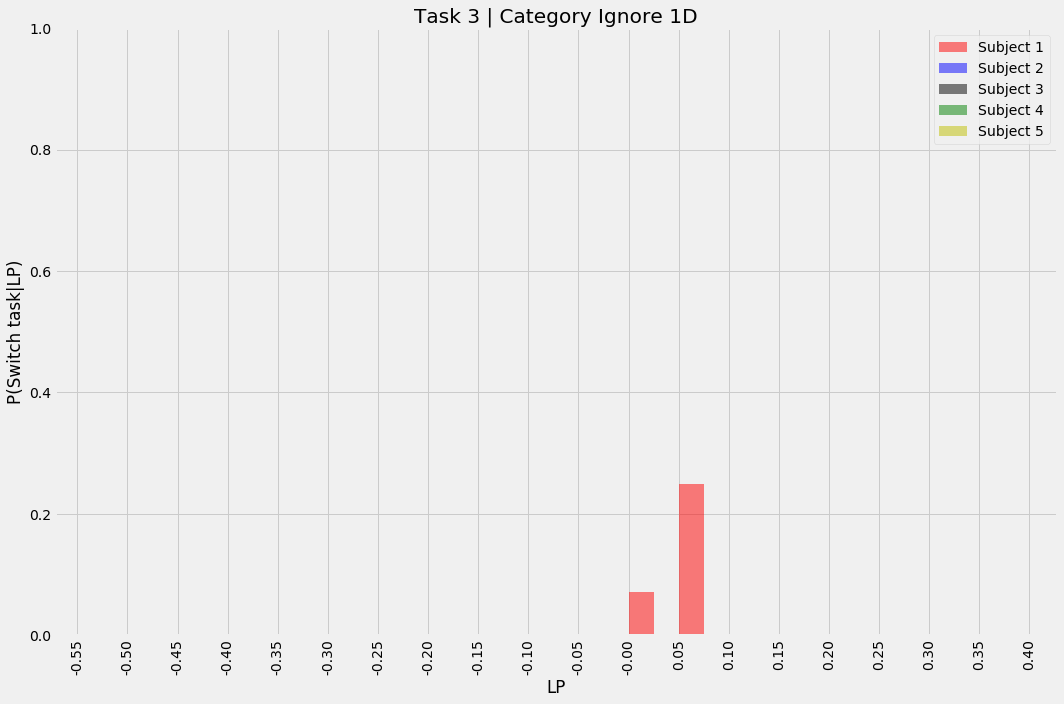

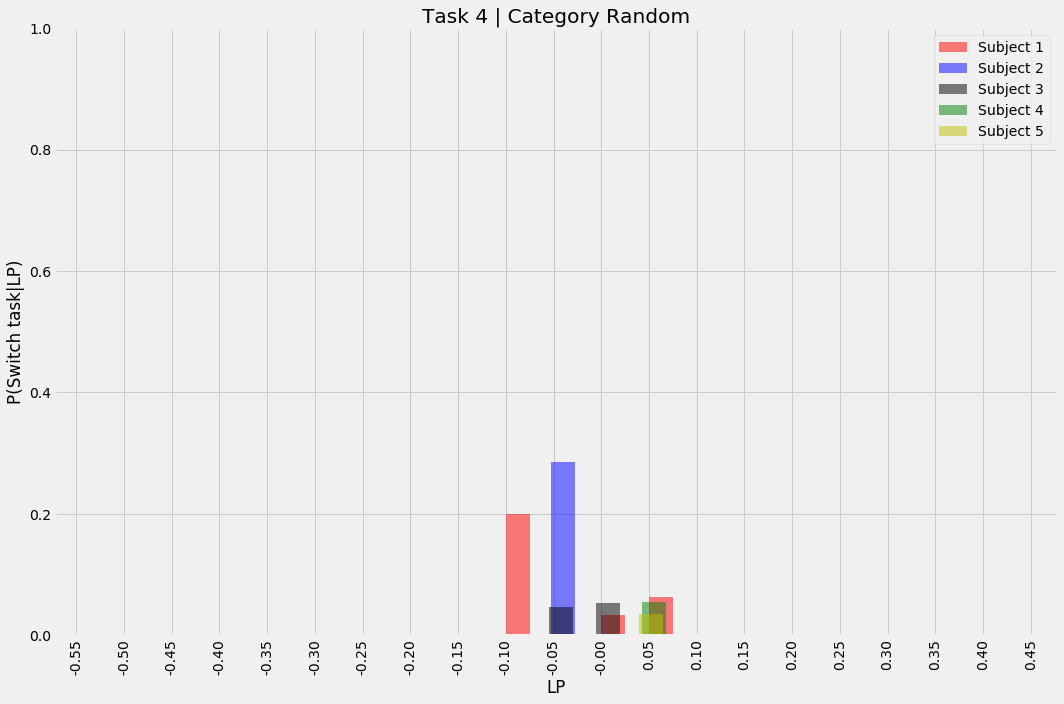

Window  40  Lookback LP  25


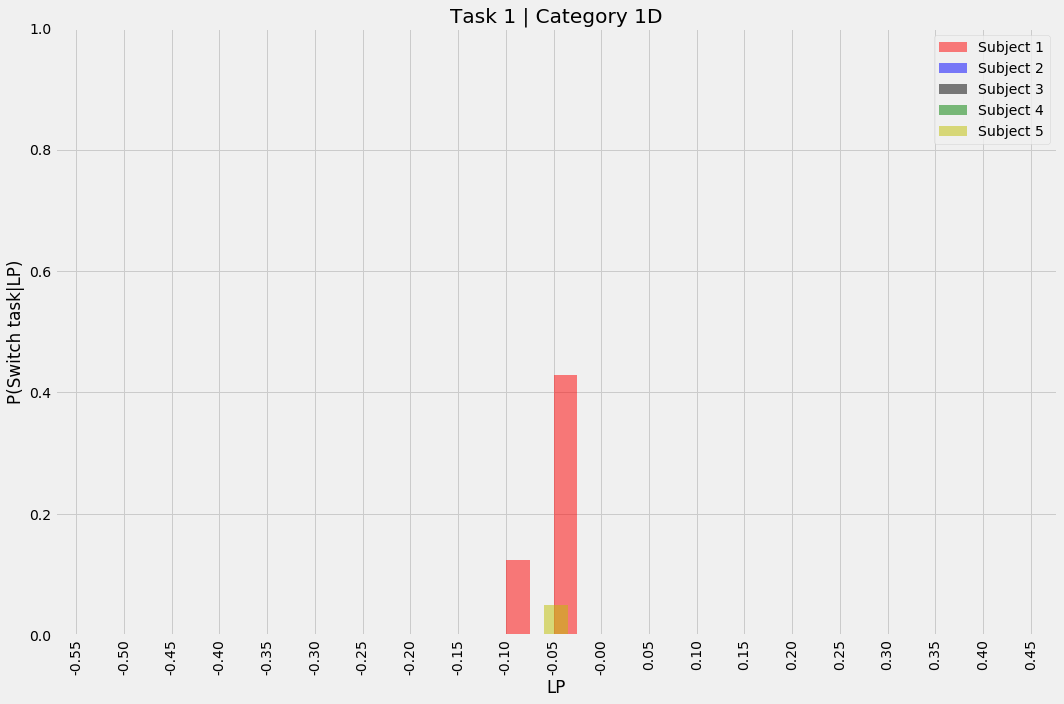

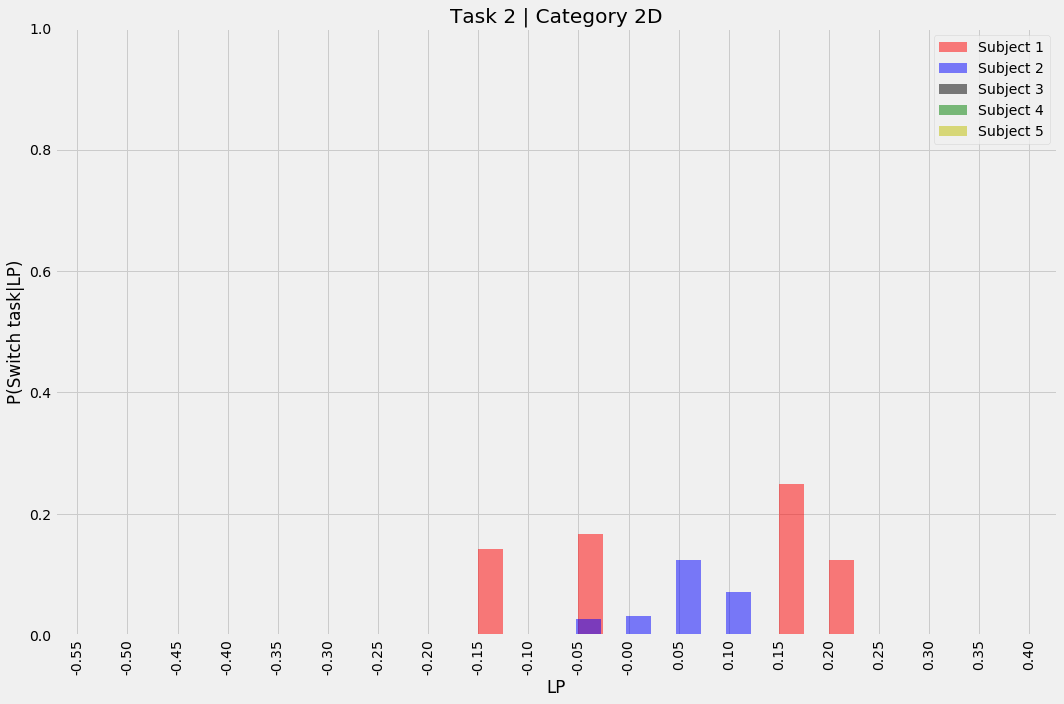

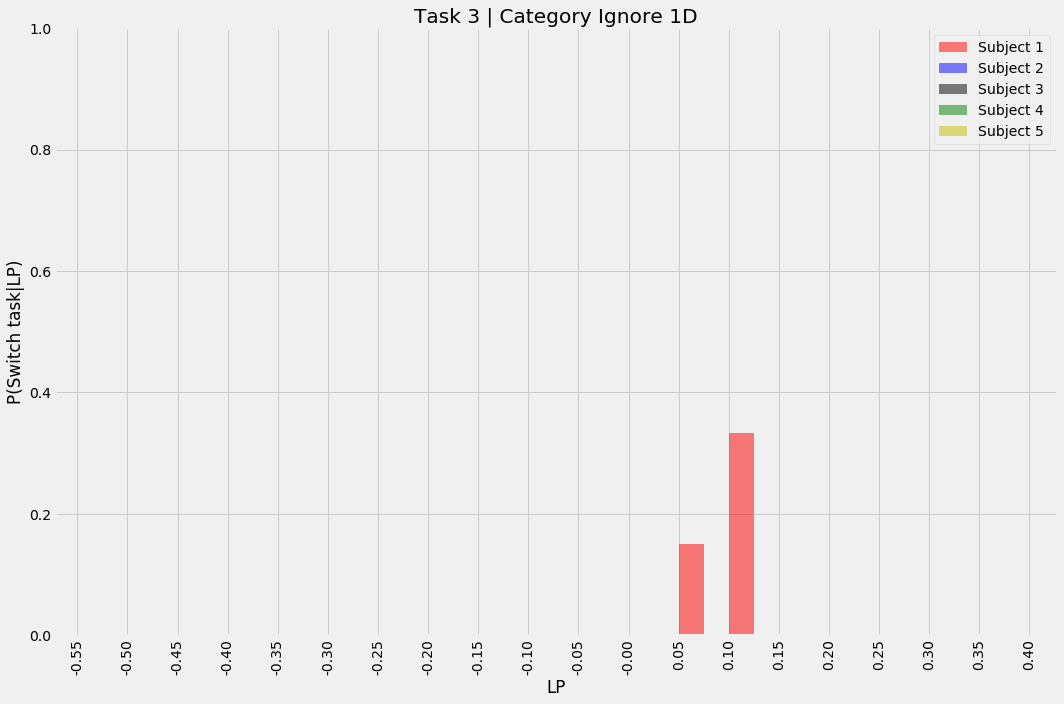

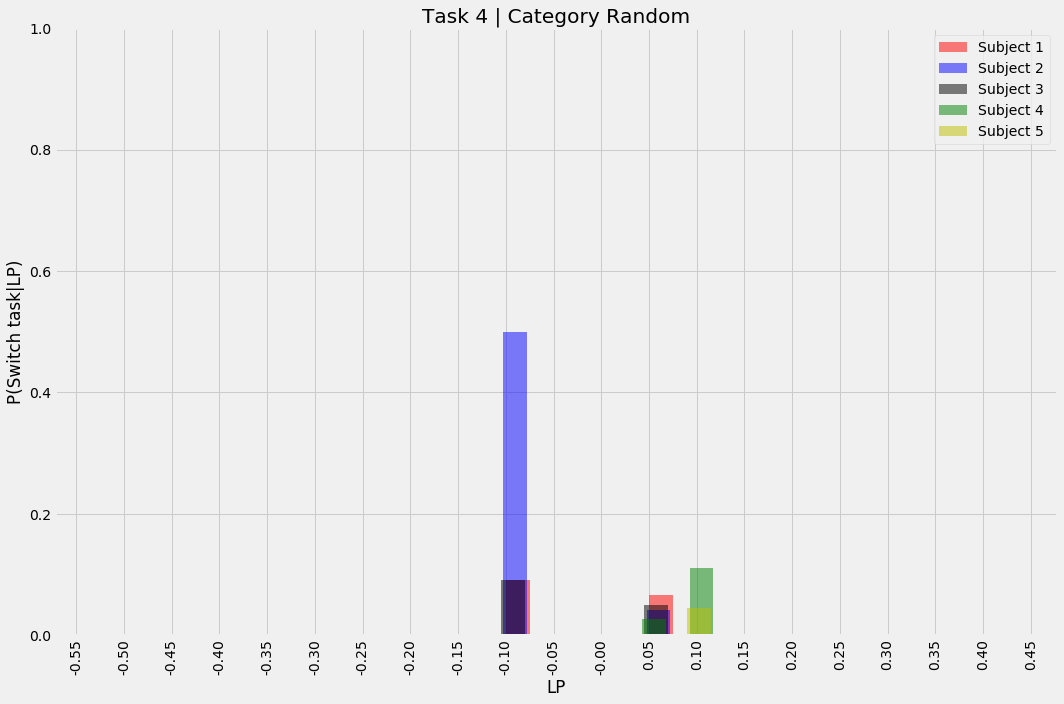

Window  40  Lookback LP  30


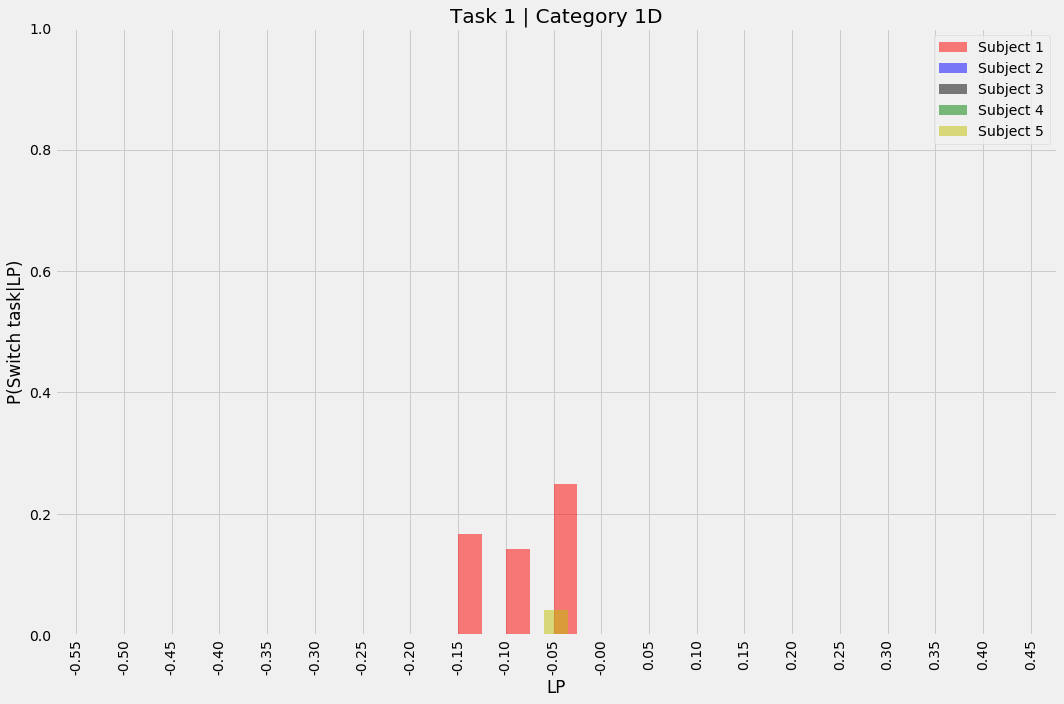

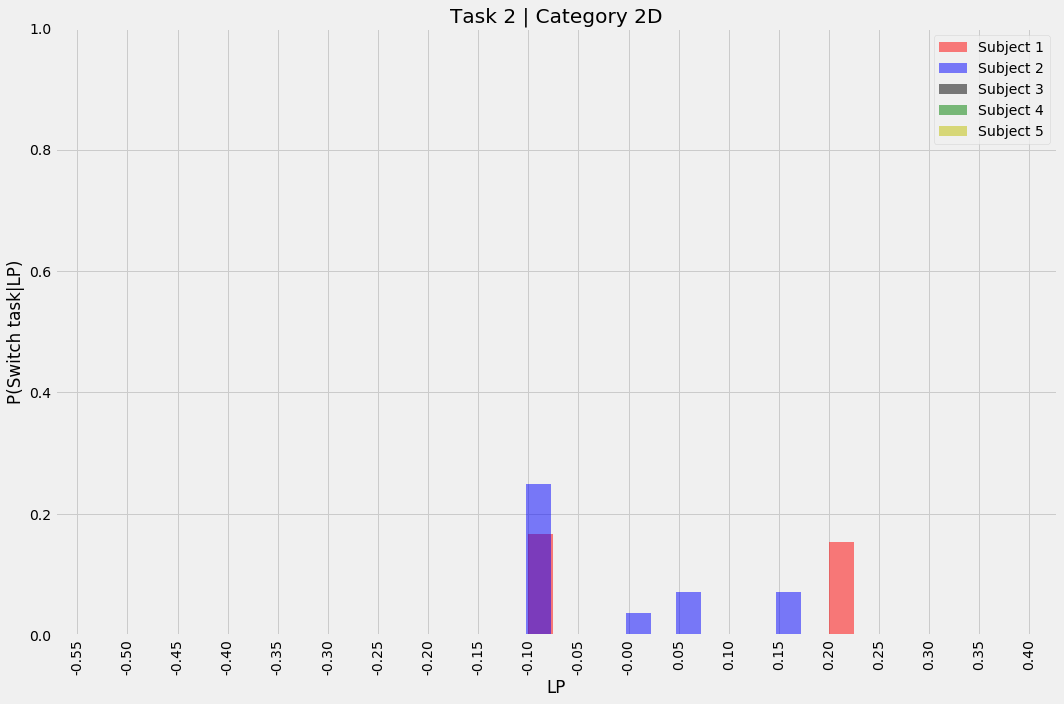

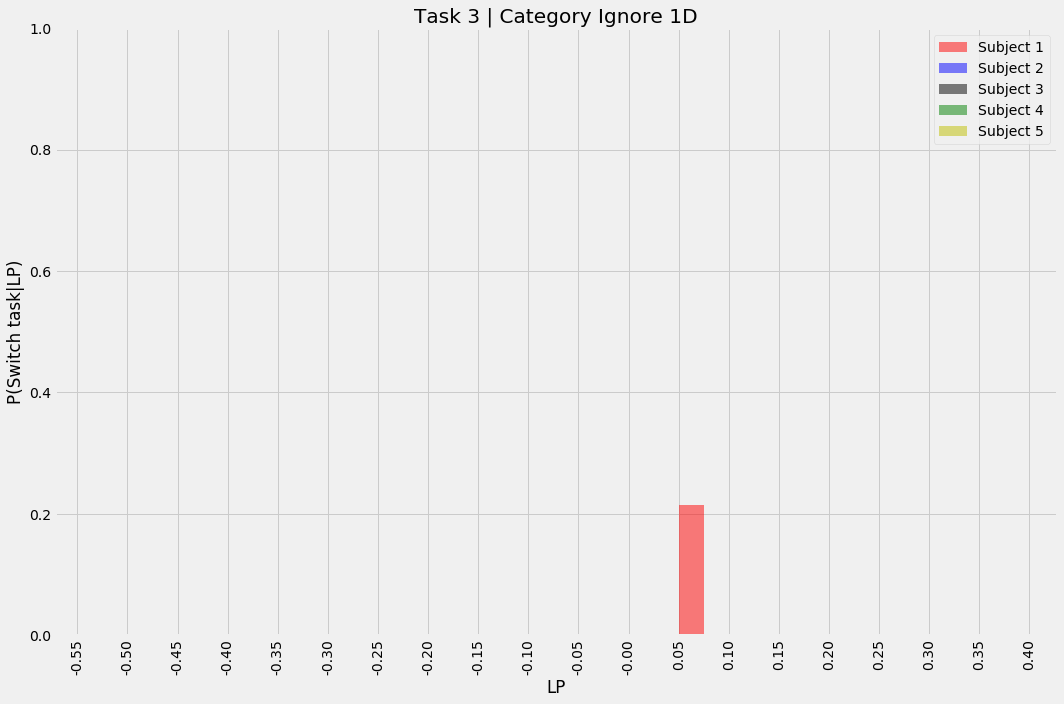

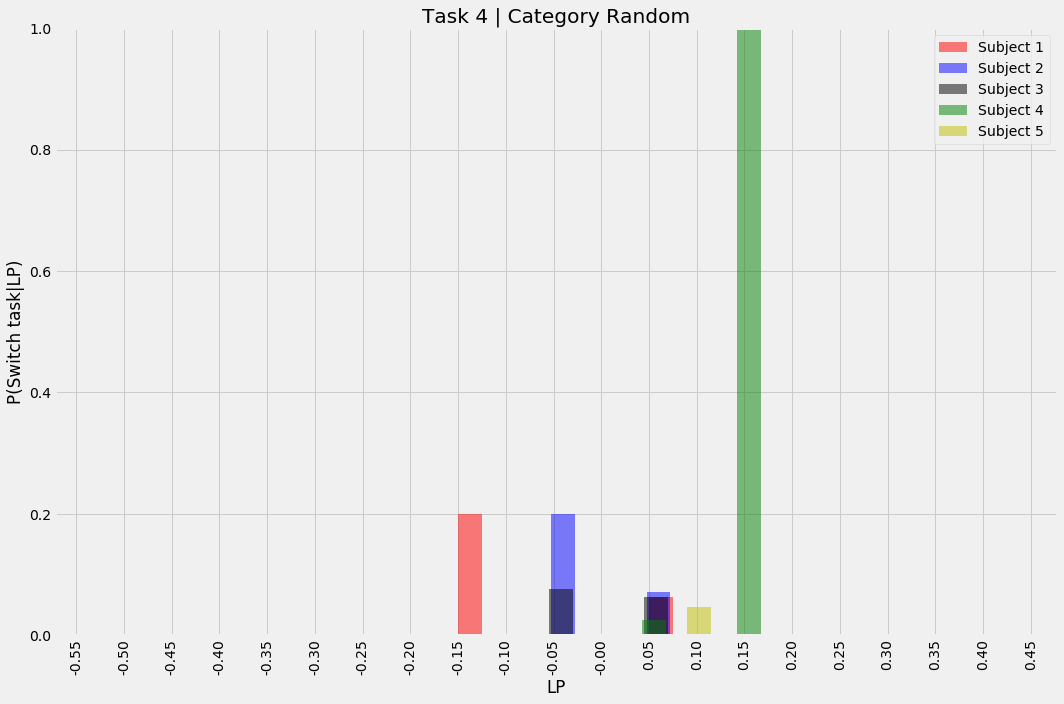

In [11]:
# Global Variables (Error section)
Window = 20
Errors = []

# Global variables (LP section)
Lookback = 15
LPU = []

for Window in [10, 15, 20, 25, 30, 35, 40]:
    for Lookback in [2, 5, 10, 15, 20, 25, 30]:
        print('Window ', Window, ' Lookback LP ', Lookback)
        plotError(Window, Lookback, False)